### Overview and Motivation

The goal of this notebook is to place bounds on the phase shift appearing in 2 to 2 scalar scattering amplitudes. The phase shift can be determined by an integral 

$$B (z) \sin \phi (z) = \frac{1}{4 \pi} \int_{- 1}^1 d z_1  \int_0^{2 \pi} d
   \phi_1 B (z_1) B (z_2) e^{i \phi (z_1) - i \phi (z_2)} $$
   
   where we use $z_2 = zz_1 + (1 - z^2)^{1 / 2}  (1 - z_1^2)^{1 / 2} \cos \phi_1$. Here $B(z)$ represents the differential cross section, where $z$ is $\cos \theta$, with $\theta$ the scattering angle. The goal will be to solve this equation for a function $\phi(z)$, the phase shift, assuming that $B(z)$ is given.

There are two questions that we can ask:

   1) For a given $B(z)$ do we have a solution to the equation ? In other words does there exist a unitary scattering amplitude fitting the given differential cross section ?
   
   2) For a given $B(z)$ is the $\phi(z)$ solution unique ? (Up to ambiguities like $f(\cos \theta) \rightarrow -f^\star(\cos \theta)$
   
  In particular bounds have been given in the litterature by considering $$\sup \frac{\int d \Omega_3 B (z_1) B (z_2)}{4 \pi B (z)} \equiv
   \sin \mu $$
   where existence is guaranteed for $\sin \mu <1$ (Martin 1969). Uniqueness has been proved up to $\sin \mu < 0.89$ (Gangal and Kupsch ). Assuming a finite partial wave expansion uniqueness has been verified up to $\sin \mu < 1$.

##### ML angle

To tackle this problem we will represent $\phi(z)$ by a neural network and try and solve the integral equation, by characterizing it as a loss term $\mathcal{L}$.

### Implementation

##### Start with the imports

Import the necessary modules and set up the Neptune logger with the API token and project name.

In [2]:
import os
import neptune.new as neptune
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch import Generator
import math
from collections import OrderedDict
import numpy as np
from itertools import chain

# Set the Neptune Logger variables
NEPTUNE_API_TOKEN = os.environ.get('NEPTUNE_API_TOKEN')
NEPTUNE_PROJECT = os.environ.get('NEPTUNE_ALIAS') + '/2to2scattering'


Check for available GPU or MPS and set the device for PyTorch tensors.

In [240]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

##### Define the networks

In [216]:
class PhiNet(nn.Module):
    def __init__(self, ffnlayers, activation, fund_dom, device='cpu', bound_phi = math.pi, final_layer='Sigmoid'):
        """
        Initialize the network with the number of FC layers, the activation function, and the device to use
        """
        super(PhiNet, self).__init__()
        
        self.device = device
        self.fund_dom = fund_dom
        self.bound_phi = bound_phi
        
        if activation=='ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise NotImplemented
        
        if final_layer=='Sigmoid':
            self.final_layer = nn.Sigmoid()
            self.final_l = 'Sigmoid'
        elif final_layer == 'Tanh':
            self.final_layer = nn.Tanh()
            self.final_l = 'Tanh'
        elif final_layer == 'Identity':
            self.final_layer = nn.Identity()
            self.final_l = 'Identity'
        else:
            raise NotImplemented
        
        # Create a list of layers from the parameters given. Add the appropriate activation function
        self.layer_sizes = ffnlayers
        layer_list = []
        
        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(1, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))
        
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], 1)))
        
        # The last layer is sigmoid to constrain outputs between 0 and 1 or tanh for [-1,1]
        layer_list.append(('final_layer', self.final_layer))
            
        
        self.model = nn.Sequential(OrderedDict(layer_list))
    
    
    def forward(self, x):
        """
        Network forward pass where the outputs for the phase are in [-pi/2, pi/2] or [-pi, pi]
        """
        #x = (x+1)/2 # Normalize the the cosine input variable
        x = self.model(x)
        if self.final_l == 'Identity':
            return x
        const_mult = 2 if self.final_l == 'Sigmoid' else 1
        if self.fund_dom:
            x = torch.tensor(const_mult*math.pi/2, device=self.device)*x - torch.tensor((const_mult*math.pi- self.bound_phi)/2, device=self.device)
        else:
            x = torch.tensor(const_mult*math.pi, device=self.device)*x - torch.tensor(const_mult*math.pi- self.bound_phi, device=self.device)
        return x
    
    
class ModuleNetManual(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self, scan_param=None):
        super(ModuleNetManual, self).__init__()
        self.scan_param = scan_param
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function. Can iterate on the overall scale if we want to
        """
        
        denom = self.scan_param if self.scan_param is not None else 1
        return (-torch.pow(x,3) + torch.pow(x,2) + x + 1)/denom
        #return torch.abs(3*x + 1)/denom
        #return (x + 4)/denom

class PhaseNetSolver():
    """
    Main class for crafting the simulation
    """
    def __init__(self, params_simu, phi_net, mod_net, optimizer, random_generator, scheduler, device='cpu'):
        """
        Initialize the simulation with the networks, the loss function and the optimizer
        """
        
        self.epochs = params_simu['epochs_num']
        self.batch_size = params_simu['batch_size']
        self.eval_points_num = params_simu['integral_points']
        self.scaled_loss = params_simu['scaled_loss']
        self.method_int = params_simu['method_int']
        self.p_value = params_simu['p_value']
        self.lambda_repulsive = params_simu['lambda_repulsive']
        self.loss_func = params_simu['loss']
        
        print("Begin Memory:", torch.cuda.memory_allocated(device))
        
        if isinstance(phi_net, list):
            self.multi_nets = [net.to(device) for net in phi_net]
            self.phi_net = None
            self.multiple_nets = True
        else:
            self.multi_nets = None
            self.phi_net = phi_net.to(device)
            self.multiple_nets = False
        self.mod_net = mod_net.to(device)
        self.device = device
        self.rand_gen = random_generator
        
        print("1 - After model to device", torch.cuda.memory_allocated(device))
        
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def z2(self, z, z1, phi):
        """
        Compute the z2 parameter (formula in motivation)
        Place the batch size on first dim, z1 on the second and phi on the third
        """
        term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
        term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
        return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    
    def integral_approximator(self, z, method='trapz'):
        """
        Approximate the value of the RHS of the integral equation.
        Compute the grids of z1 and phi points for given z values and integrate over the grids
        """
        
        # Linear partition of the space
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        grid_points = self.mod_net(z1_points).view(1,-1,1)*self.mod_net(self.z2(z, z1_points, phi_points))*torch.cos(self.phi_net(z1_points.view(1,-1,1)) - self.phi_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1)).squeeze())
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
        return integral
    
    def loss_function(self, zsamples):
        """
        Compute a loss based on the average residuals for the integral equation
        """
        
        # For each value of z we estimate the integral equation
        #target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else math.pi*zsamples
        #sol1 = torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(zsamples,2)-1)*np.sin(math.pi/9)-np.exp(-7*1j*math.pi/54)*np.sin(7*math.pi/54)-3*np.exp(-869*1j*math.pi/3600)*zsamples*np.sin(869*math.pi/3600))
        #target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else (math.pi - sol1 - torch.div(math.pi - sol1, math.pi, rounding_mode = "floor")*2*math.pi)
        #target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(zsamples,2)-1)*np.sin(math.pi/9)-np.exp(-7*1j*math.pi/54)*np.sin(7*math.pi/54)-3*np.exp(-869*1j*math.pi/3600)*zsamples*np.sin(869*math.pi/3600))
        #model_input = self.phi_net(zsamples.view(-1,1)).squeeze()
        target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        model_input = self.integral_approximator(zsamples, method=self.method_int)
        
        # If scaled then all targets should be 1 irrespective of the z point considered
        if self.scaled_loss:
            #model_input = model_input / math.pi*zsamples
            #model_input = model_input / torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(zsamples,2)-1)*np.sin(math.pi/9)-np.exp(-7*1j*math.pi/54)*np.sin(7*math.pi/54)-3*np.exp(-869*1j*math.pi/3600)*zsamples*np.sin(869*math.pi/3600))
            #model_input = model_input / (math.pi - sol1 - torch.div(math.pi - sol1, math.pi, rounding_mode = "floor")*2*math.pi) 
            model_input = model_input / (self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze()))
            
        # We have different choices of losses. Huber is more stable to outliers.
        if self.loss_func =='Huber':
            loss_out = F.huber_loss(model_input, target, delta=0.1)
        elif self.loss_func == 'MSE':
            loss_out = F.mse_loss(model_input, target)
        else:
            raise NotImplemented
        
        return loss_out
    
    def multi_loss_function(self, zsamples, logger=None):
        
        if not self.multiple_nets:
            raise NotImplemented
        
        total_loss = 0
        for i, net in enumerate(self.multi_nets):
            self.phi_net = net
            individual_loss = self.loss_function(zsamples)
            logger['metrics/solution_loss_{}'.format(i)].log(individual_loss)
            total_loss = total_loss + individual_loss
        
        return total_loss
    
    def dual_loss(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else self.multi_nets[0](zsamples.view(-1,1)).squeeze()
        model_input = (self.multi_nets[1](zsamples.view(-1,1))/self.multi_nets[0](zsamples.view(-1,1))).squeeze() if self.scaled_loss else self.multi_nets[1](zsamples.view(-1,1)).squeeze()
        
        # Maybe MSE makes more sense here since we are just comparing functions in the first place
        loss_out = torch.pow(F.mse_loss(model_input, target), -self.p_value)
        
        return loss_out
    
    def dual_loss_ambiguity(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        
        target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else self.multi_nets[0](zsamples.view(-1,1)).squeeze()
        model_input1 = (self.multi_nets[1](zsamples.view(-1,1))/self.multi_nets[0](zsamples.view(-1,1))).squeeze() if self.scaled_loss else self.multi_nets[1](zsamples.view(-1,1)).squeeze()
        
        input2 = math.pi*torch.ones(zsamples.size(), device=self.device) - self.multi_nets[1](zsamples.view(-1,1)).squeeze()
        
        # Cannot backpropagate through heaviside this option is not available
        #domaininput2 = input2 - 2*math.pi*torch.heaviside(input2-self.multi_nets[1].bound_phi*torch.ones(zsamples.size(), device=self.device), torch.tensor([0.0], device=self.device)) + 2*math.pi*torch.heaviside(-input2+(self.multi_nets[1].bound_phi-2*math.pi)*torch.ones(zsamples.size(), device=self.device), torch.tensor([0.0], device=self.device))
        
        # Instead lets do something that will work if the domain is [-pi, pi] -> could generalize later if we want to
        domaininput2 = input2 - torch.div(input2, math.pi, rounding_mode = "floor")*2*math.pi
        
        model_input2 = domaininput2/(self.multi_nets[0](zsamples.view(-1,1))).squeeze() if self.scaled_loss else domaininput2
        
        # Maybe MSE makes more sense here since we are just comparing functions in the first place
        loss_out1 = torch.pow(F.mse_loss(model_input1, target), -self.p_value)
        loss_out2 = torch.pow(F.mse_loss(model_input2, target), -self.p_value)
        
        return loss_out1 + loss_out2
    
    def complete_loss(self, zsamples, dual_active, logger=None):
        
        if not self.multiple_nets:
            return self.loss_function(zsamples)
        else:
            if len(self.multi_nets)!=2:
                raise NotImplemented
            if dual_active:
                repulsive_loss = self.dual_loss_ambiguity(zsamples)
            else: 
                repulsive_loss = 0.0
            logger['metrics/repulsive_loss'].log(repulsive_loss)
                
            return self.multi_loss_function(zsamples, logger=logger) + self.lambda_repulsive * repulsive_loss
    
    def point_loss(self, zsamples):
        """
        If we want to know the residuals at each given z point. This is useful for evaluation purposes
        """
        target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze())
        model_input = self.integral_approximator(zsamples)
        
        if self.scaled_loss:
            model_input = model_input / (self.mod_net(zsamples)*torch.sin(self.phi_net(zsamples.view(-1,1)).squeeze()))
        return torch.square(model_input - target)
        
    def train(self, neptune_run):
        """
        Main training loop. 
        Each epoch is a single optimization step over a unique batch.
        A batch is composed of a number of randomly selected z points between -1 and 1
        """
        
        for epoch_num in range(self.epochs):
            
            dual_active = False if epoch_num < 0.1*self.epochs or epoch_num > 0.4*self.epochs else True
            
            # Set the network in train mode
            if self.multiple_nets:
                for net in self.multi_nets:
                    net.train()
            else:
                self.phi_net.train()
            
            zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device='cpu').to(self.device)*2 - 1
            
            # Zero the grads, get the loss and backpropagate
            
            if type(self.optimizer).__name__ == 'LBFGS':
                
                loss = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                
                def closure():
                    if torch.is_grad_enabled():
                        self.optimizer.zero_grad()
                    loss_comp = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                    if loss_comp.requires_grad:
                        loss_comp.backward()
                    return loss_comp
                
                neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
                self.optimizer.step(closure)
                   
            else:
                self.optimizer.zero_grad()
                a =  torch.cuda.memory_allocated(device)
                loss = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                b = torch.cuda.memory_allocated(device)
                #print("2 - After forward pass", torch.cuda.memory_allocated(device))
                #print("2 - Memory consumed by forward pass", b-a)
                loss.backward()
                #print("3 - After backward pass", torch.cuda.memory_allocated(device))
                neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
                self.optimizer.step()
                #print("3 - After optimizer step", torch.cuda.memory_allocated(device))
                
            if self.scheduler is not None:
                self.scheduler.step()
            neptune_run['metrics/train_loss'].log(loss)
            
            if epoch_num % 20 == 0:
                print('Train Epoch: {} ; tLoss: {:.6f}'.format(epoch_num, loss.item()))

def scheduler_rate(step, factor, size_param, warmup):
    """
    For the Learning Rate scheduler we implement a warmup start, followed by a square root decay
    """
    if step == 0:
        step = 1
    return factor * size_param**(-0.5) * min(step**(-0.5), step*warmup ** (-1.5))

##### Define the training run

In [5]:
from torchinfo import summary

def train_run(parameters, device, run_neptune, module_net=None, seed_num=42, optim_name='Adam'):
    """
    Function to call for launching the training run
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(seed_num)
    torch.manual_seed(seed_num)   
    torch.cuda.manual_seed(seed_num)
    
    num_phi_nets = parameters['num_nets']
    
    # Define and register the networks
    if num_phi_nets>1:
        phinn = [PhiNet(parameters['layer_list'], parameters['activation'], parameters['fund_dom'], device=device, bound_phi=parameters['bound_phi'], final_layer=parameters['final_layer']) for i in range(num_phi_nets)]
        phidisp = phinn[0]
    else:
        phinn = PhiNet(parameters['layer_list'], parameters['activation'], parameters['fund_dom'], device=device, bound_phi=parameters['bound_phi'], final_layer=parameters['final_layer'])
        phidisp = phinn
    

    run_neptune["config/phimodel"] = type(phidisp).__name__
    with open(f"model_arch.txt", "w") as f:
        f.write(str(summary(phidisp, verbose=0, col_width=16, device=device)))
        f.write(str(phidisp))
    print(str(phidisp))
    
    if module_net is None:
        modnn = ModuleNetManual(scan_param=parameters['scan_param'])
    else:
        modnn = module_net
    run_neptune["config/modmodel"] = type(modnn).__name__
    
    run_neptune["model_arch"].upload("model_arch.txt")
    
    # Define and register the optimizer and scheduler
    if optim_name == 'Adam':
        if num_phi_nets>1:
            optimizer = torch.optim.Adam(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
        else:
            optimizer = torch.optim.Adam(phinn.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
    elif optim_name == 'LBFGS':
        if num_phi_nets>1:
            optimizer = torch.optim.LBFGS(chain.from_iterable([phinet.parameters() for phinet in phinn]), lr=parameters['learning_rate'], max_iter=4)
        else:
            optimizer = torch.optim.LBFGS(phinn.parameters(), lr=parameters['learning_rate'], max_iter=4)
            
    run_neptune["config/optimizer"] = type(optimizer).__name__
    
    
    if parameters['lr_scheduler']:
        lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate(step, 1/parameters['learning_rate'], 2048, 750))
    else:
        lr_scheduler = None
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolver(parameters, phinn, modnn, optimizer, random_gen_cpu, lr_scheduler, device=device)
    netsolver.train(run_neptune)

    return netsolver

##### Define the evaluation run

In [6]:
def eval_run(trained_solver, params, device, neptune_run, steps_eval=100, num=None):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    str_add = '_' + str(num) if num is not None else ''
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        results = trained_solver.phi_net(zpointstest.view(-1,1))
        phires = results.squeeze().cpu().numpy()
        sinphires = torch.sin(results).squeeze().cpu().numpy()
        
        # Also log the final loss values. Including the loss at individual z values
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_scaled' + str_add].log(eval_loss_scaled)
        
        eval_loss_base = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_base' + str_add].log(eval_loss_base)
        
        eval_point_loss_scaled = trained_solver.point_loss(zpointstest)
        eval_point_loss_non_scaled = trained_solver.point_loss(zpointstest)
    
    return zpointstest, phires, sinphires, eval_point_loss_scaled, eval_point_loss_non_scaled

##### Check the value of the $\sin(\mu)$ parameter

In [7]:
def sin_mu_integral(params, device, trained_solver, zpoints):
    """
    Helper function to compute the sin(\mu) variable defined in the motivation.
    This compute the relevant integral involving the differential cross section
    """
    z1_points = torch.linspace(-1,1,steps=params['integral_points'], device=device)
    phi_points = torch.linspace(0, 2*math.pi, steps=params['integral_points'], device=device)
    dx_z1 = 2/(params['integral_points']-1)
    dx_phi = 2*math.pi/(params['integral_points']-1)
        
    grid_points = trained_solver.mod_net(z1_points).view(1,-1,1)*trained_solver.mod_net(netsolver.z2(zpoints, z1_points, phi_points))
        
    integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
    return integral/trained_solver.mod_net(zpoints)
   

##### Define the plotting routines

In [8]:
import matplotlib.pyplot as plt
from neptune.new.types import File

def plot_phase(zpoints, phipoints, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
def plot_phases(zpoints, phipoints_list, neptune_run):

    fig = plt.figure(figsize=(14, 10))
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.legend(['Network {}'.format(i+1) for i in range(len(phipoints_list))])
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
    
def plot_point_loss(zpoints, point_loss_data_s, point_loss_data_no_s, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(), point_loss_data_s.cpu(), 'b-', linewidth = 2)  
    plt.plot(zpoints.cpu(), point_loss_data_no_s.cpu(), 'g-', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['Normalized loss at each point', 'Base loss'])
    plt.show()

    neptune_run[f'evaluation/point_loss_evaluation'].upload(File.as_image(fig))
    plt.close(fig)
    

def plot_sin_mu(zpoints, integralpoints, tags_run):

    sinmu = max(integralpoints.cpu())

    fig2 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: B(z) = {}'.format(tags_run['constant function']), fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    
def plot_summary(zpoints, phipoints, sinphipoints, integralpoints, neptune_run, tags_run):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.plot(zpoints.cpu(),sinphipoints, 'b--', linewidth = 2)       
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: B(z) = {}'.format(tags_run['constant function']), fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['$\phi(z)$', '$\sin \phi(z)$','$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()

    neptune_run[f'evaluation/overview'].upload(File.as_image(fig3))
    plt.close(fig3)

### Single function Run

##### Define the parameters

In [406]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_cubictest")

params = {'batch_size': 64,
         'epochs_num': 500,
         'learning_rate': 0.001,
         'lr_scheduler': False, 
         'beta1' : 0.85,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'fund_dom': False,
         'layer_list': [64, 128, 128, 64],
         'final_layer': 'Sigmoid',
         'loss': 'Huber',
         'scaled_loss': True,
         'scan_param': 3,
         'bound_phi': 0.5 + math.pi,
         'num_nets' : 1,
         'p_value': None,
         'lambda_repulsive': None}

tags = {'constant function': '(-z^3+z^2+z+1)/3', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-515
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


##### Training run

In [407]:
netsolver = train_run(params, device, run, seed_num=42)

PhiNet(
  (activation): ReLU()
  (final_layer): Sigmoid()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.055814
Train Epoch: 15 ; tLoss: 0.009835
Train Epoch: 30 ; tLoss: 0.004152
Train Epoch: 45 ; tLoss: 0.000620
Train Epoch: 60 ; tLoss: 0.000088
Train Epoch: 75 ; tLoss: 0.000033
Train Epoch: 90 ; tLoss: 0.000020
Train Epoch: 105 ; tLoss: 0.000008
Train Epoch: 120 ; tLoss: 0.000008
Train Epoch: 135 ; tLoss: 0.000008
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000004
Train Epoch: 180 ; tLoss: 0.0000

##### Evaluation and plots

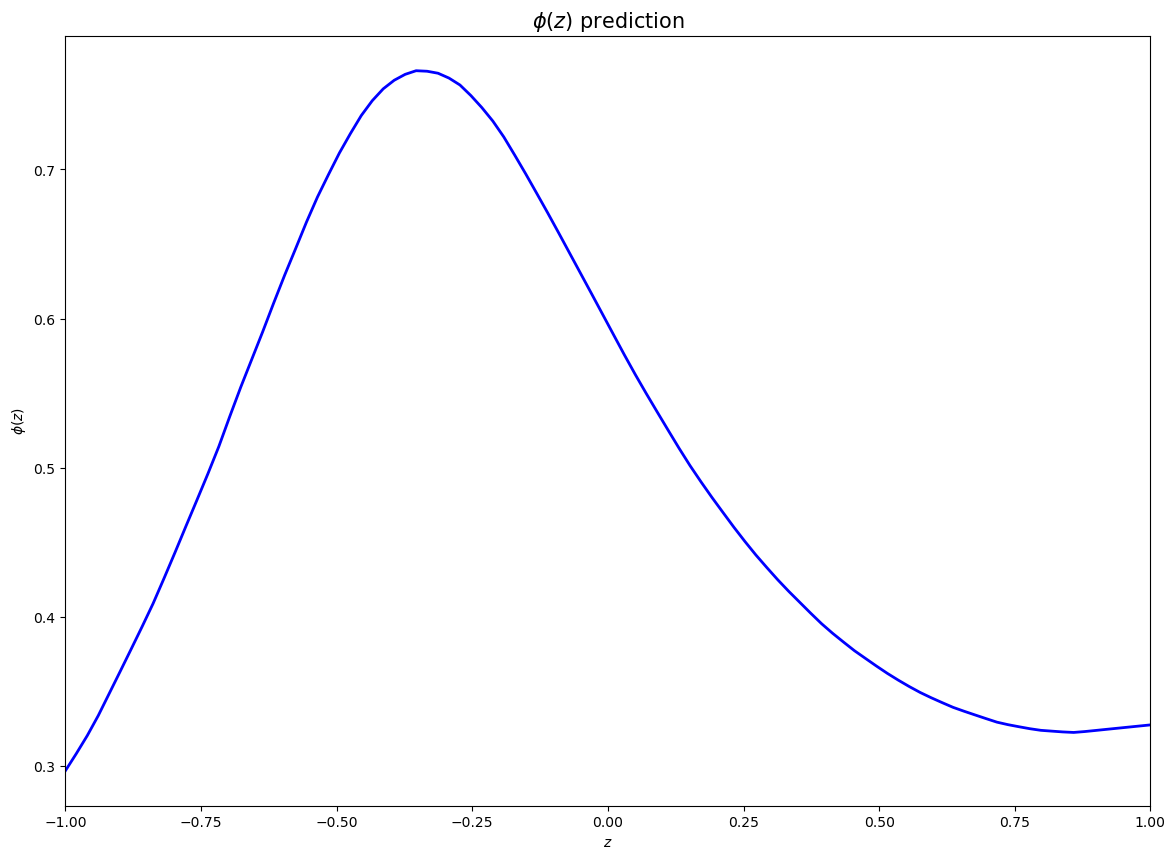

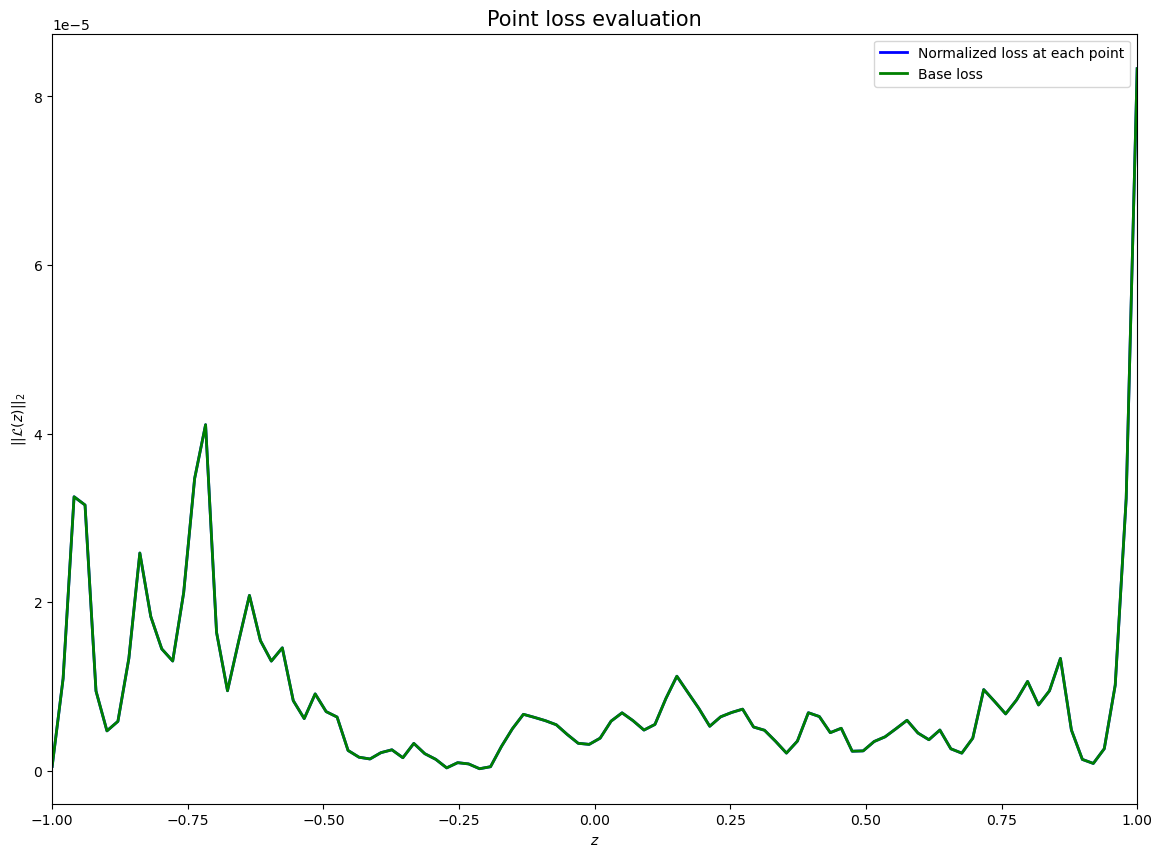

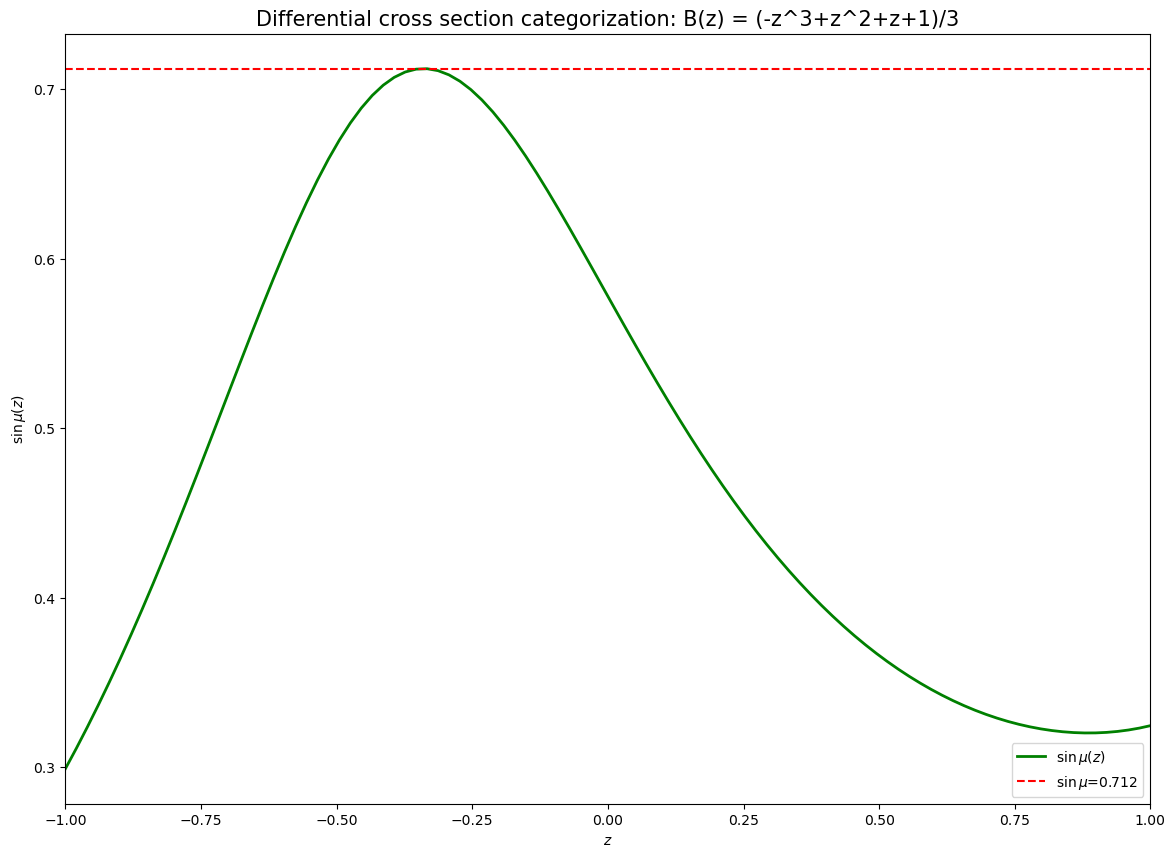

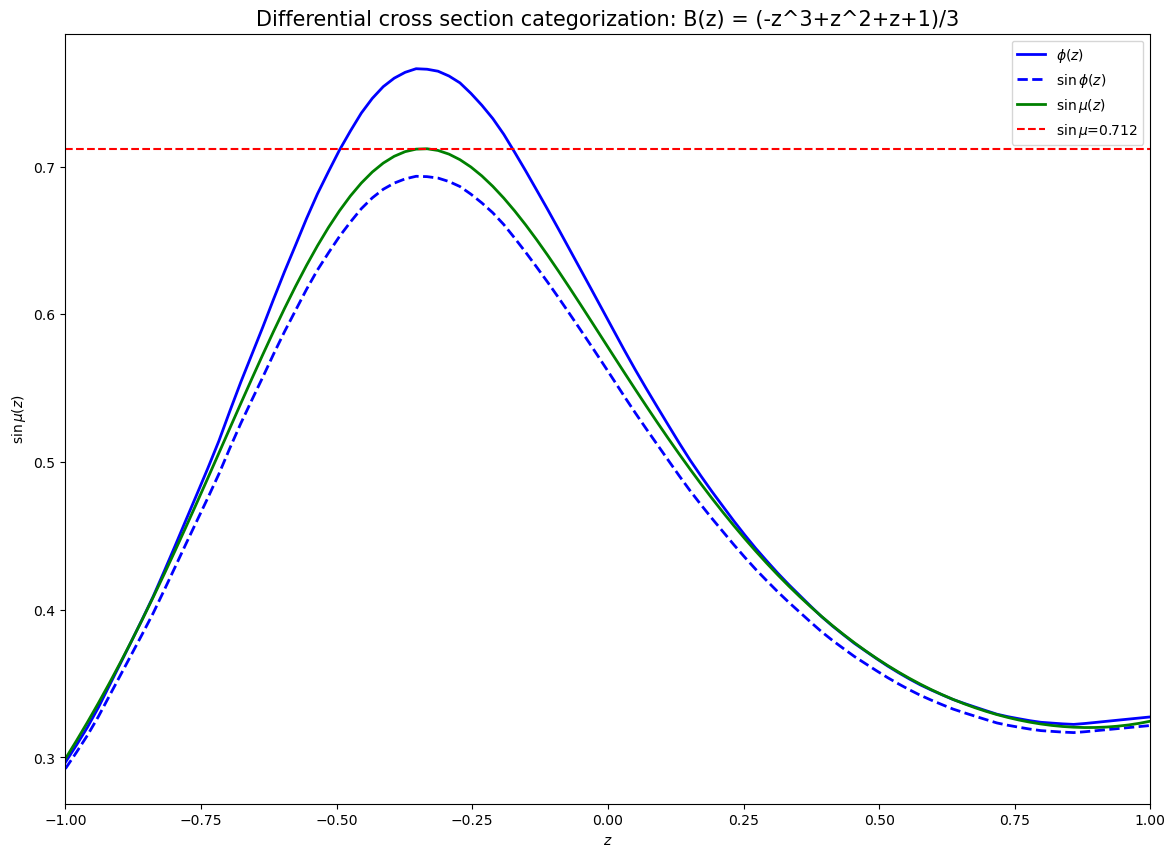

In [408]:
zpointseval, phieval, sinphieval, eval_pt_loss_s, eval_pt_loss_no_s = eval_run(netsolver, params, device, run)

plot_phase(zpointseval, phieval, run)
plot_point_loss(zpointseval, eval_pt_loss_s, eval_pt_loss_no_s, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summary(zpointseval, phieval, sinphieval, integralz, run, tags)

In [409]:
# Make sure to kill the Neptune logger run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 92 operations to synchronize with Neptune. Do not kill this process.
All 92 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-515


##### Error on the trapezoidal rule

The error on the trapezoidal rule is bounded by $$E\leq \max_x \frac{(b-a)^3}{12 N^2} |f''(x)|$$ The scaling with the number of evaluation points goes as $N^{-2}$ which is relevant for us to put some bound on the expected answer. In a multidimensional setting we can still expect the global error to grow as $N^{-2}$.

In [358]:
import sympy as sp

symbz = sp.Symbol('z')
symbphi = sp.Symbol('\phi')
symbz1 = sp.Symbol('z_1')

funcz = (1+symbz+symbz**2-symbz**3)/3
completesol=sp.factor(sp.integrate(sp.integrate((funcz.subs(symbz,symbz1) * funcz.subs(symbz,symbz1*symbz + sp.sqrt(1-symbz**2)*sp.sqrt(1-symbz1**2)*sp.cos(symbphi)))/(4*sp.pi*funcz),(symbphi, 0,2*sp.pi)),(symbz1,-1,1)))

In [362]:
params['integral_points'] = 25

integralapprox = sin_mu_integral(params, device, netsolver, zpointseval).to('cpu')
integralexact = torch.FloatTensor([completesol.subs(symbz,pt) for pt in zpointseval], device='cpu')
base=integralapprox - integralexact
print(base)
print(max(base))
print(min(base))

tensor([ 7.7218e-04,  7.7960e-04,  7.8663e-04,  7.9292e-04,  7.9852e-04,
         8.0335e-04,  8.0720e-04,  8.1030e-04,  8.1220e-04,  8.1304e-04,
         8.1235e-04,  8.1053e-04,  8.0717e-04,  8.0210e-04,  7.9554e-04,
         7.8708e-04,  7.7683e-04,  7.6455e-04,  7.5054e-04,  7.3445e-04,
         7.1639e-04,  6.9654e-04,  6.7455e-04,  6.5082e-04,  6.2543e-04,
         5.9837e-04,  5.7006e-04,  5.4049e-04,  5.0974e-04,  4.7839e-04,
         4.4638e-04,  4.1419e-04,  3.8195e-04,  3.4988e-04,  3.1841e-04,
         2.8741e-04,  2.5749e-04,  2.2864e-04,  2.0105e-04,  1.7464e-04,
         1.5008e-04,  1.2696e-04,  1.0550e-04,  8.5831e-05,  6.7890e-05,
         5.1737e-05,  3.7313e-05,  2.4617e-05,  1.3709e-05,  4.3511e-06,
        -3.3975e-06, -9.5963e-06, -1.4424e-05, -1.7524e-05, -1.9670e-05,
        -2.0266e-05, -1.9610e-05, -1.7971e-05, -1.5080e-05, -1.1235e-05,
        -6.3777e-06, -5.0664e-07,  6.2585e-06,  1.3798e-05,  2.2173e-05,
         3.1441e-05,  4.1366e-05,  5.2005e-05,  6.3

In [363]:
params['integral_points'] = 50

integralapprox = sin_mu_integral(params, device, netsolver, zpointseval).to('cpu')
integralexact = torch.FloatTensor([completesol.subs(symbz,pt) for pt in zpointseval])
print(base/(integralapprox - integralexact))

tensor([4.1716, 4.1708, 4.1692, 4.1689, 4.1696, 4.1689, 4.1688, 4.1682, 4.1678,
        4.1663, 4.1685, 4.1662, 4.1668, 4.1675, 4.1657, 4.1643, 4.1652, 4.1660,
        4.1654, 4.1642, 4.1646, 4.1632, 4.1622, 4.1644, 4.1639, 4.1621, 4.1619,
        4.1596, 4.1636, 4.1650, 4.1582, 4.1636, 4.1610, 4.1572, 4.1572, 4.1605,
        4.1578, 4.1650, 4.1591, 4.1679, 4.1551, 4.1602, 4.1647, 4.1618, 4.1722,
        4.1731, 4.1733, 4.1300, 4.1818, 4.5625, 3.8000, 4.0250, 4.1017, 4.1408,
        4.0741, 4.0476, 4.1646, 4.0743, 4.0480, 3.9684, 3.8909, 1.7000, 4.3750,
        4.3271, 4.3006, 4.2540, 4.2188, 4.2048, 4.1996, 4.1887, 4.1901, 4.1857,
        4.1883, 4.1864, 4.1813, 4.1763, 4.1777, 4.1775, 4.1749, 4.1750, 4.1737,
        4.1725, 4.1707, 4.1733, 4.1709, 4.1680, 4.1692, 4.1677, 4.1691, 4.1691,
        4.1668, 4.1663, 4.1662, 4.1664, 4.1644, 4.1672, 4.1644, 4.1659, 4.1640,
        4.1648])


In [364]:
params['integral_points'] = 250

integralapprox = sin_mu_integral(params, device, netsolver, zpointseval).to('cpu')
integralexact = torch.FloatTensor([completesol.subs(symbz,pt) for pt in zpointseval])
print(base/(integralapprox - integralexact))

tensor([ 108.4100,  107.6502,  107.2967,  107.2823,  108.0403,  107.3944,
         109.2137,  107.4664,  107.7194,  106.5664,  108.1667,  107.0748,
         107.0514,  107.2271,  107.6371,  107.3577,  107.7107,  107.7899,
         107.6239,  107.1478,  109.2636,  107.2110,  105.7664,  109.1900,
         108.1753,  109.1196,  108.6818,  106.6824,  108.2532,  108.4595,
         108.5362,  106.9077,  106.8000,  110.7547,  106.8400,  109.5909,
         108.0000,  106.5556,  105.4062,  112.6923,  114.4545,  101.4286,
         110.6250,  120.0000,  113.9000,  124.0000,  125.2000,  103.2500,
        -230.0000,   73.0000,   28.5000,   80.5000,   80.6667,   98.0000,
          66.0000,   68.0000,  109.6667,   67.0000,  101.2000,   75.4000,
          71.3333,    8.5000,   70.0000,  154.3333,  148.8000,  105.5000,
         106.7692,  124.6429,  106.2500,  110.0000,  118.1600,  103.1212,
         113.8235,  114.6842,  113.1860,  108.0000,  112.2453,  110.5254,
         109.4462,  110.4000,  108.623

As we increase the number of integral points considered we can verify the $N^{-2}$ scaling. Going from 25 points (per dimension) to 50 points indeed decreases the error by a factor 4, while going to 250 points decreases the error by a factor 100.

### Scan over Function runs

https://app.neptune.ai/zulap/2to2scattering/e/TOS-347
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.417605
Train Epoch: 15 ; tLoss: 0.052023
Train Epoch: 30 ; tLoss: 0.041178
Train Epoch: 45 ; tLoss: 0.034813
Train Epoch: 60 ; tLoss: 0.023217
Train Epoch: 75 ; tLoss: 0.021890
Train Epoch

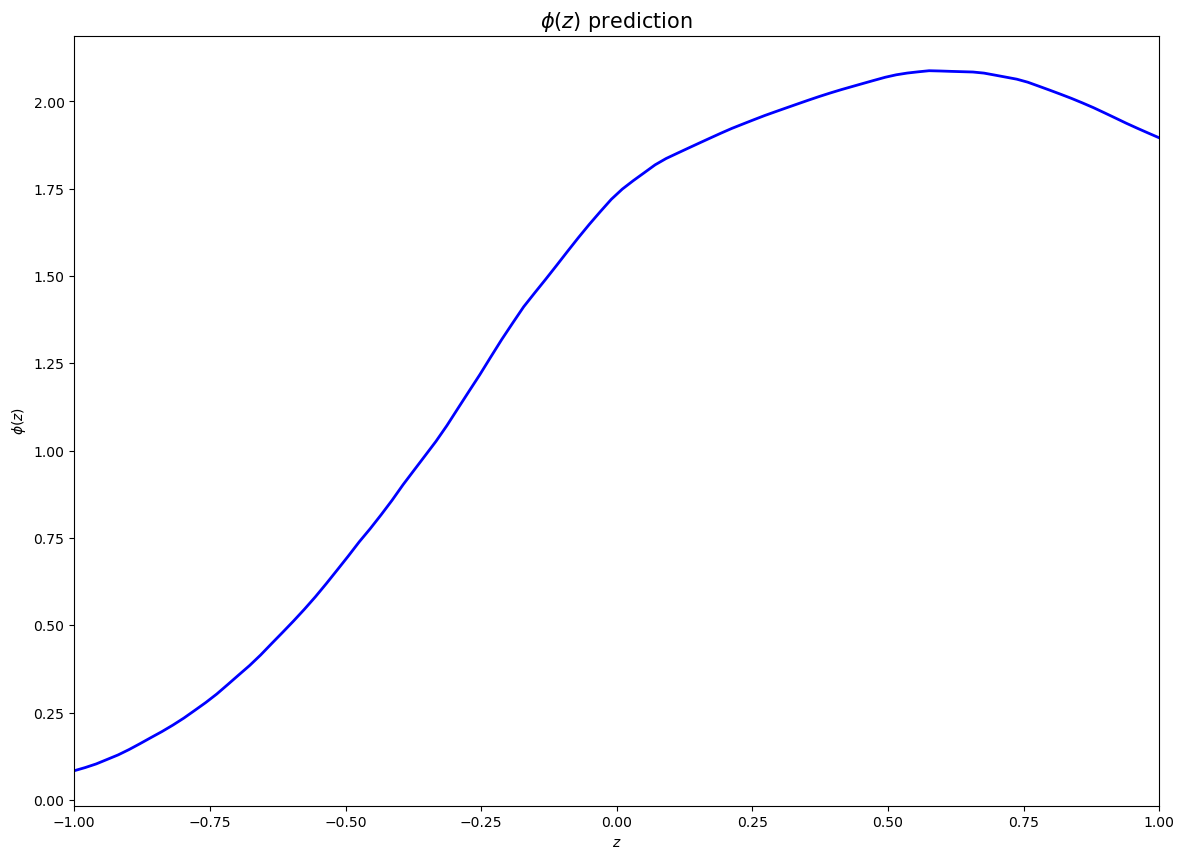

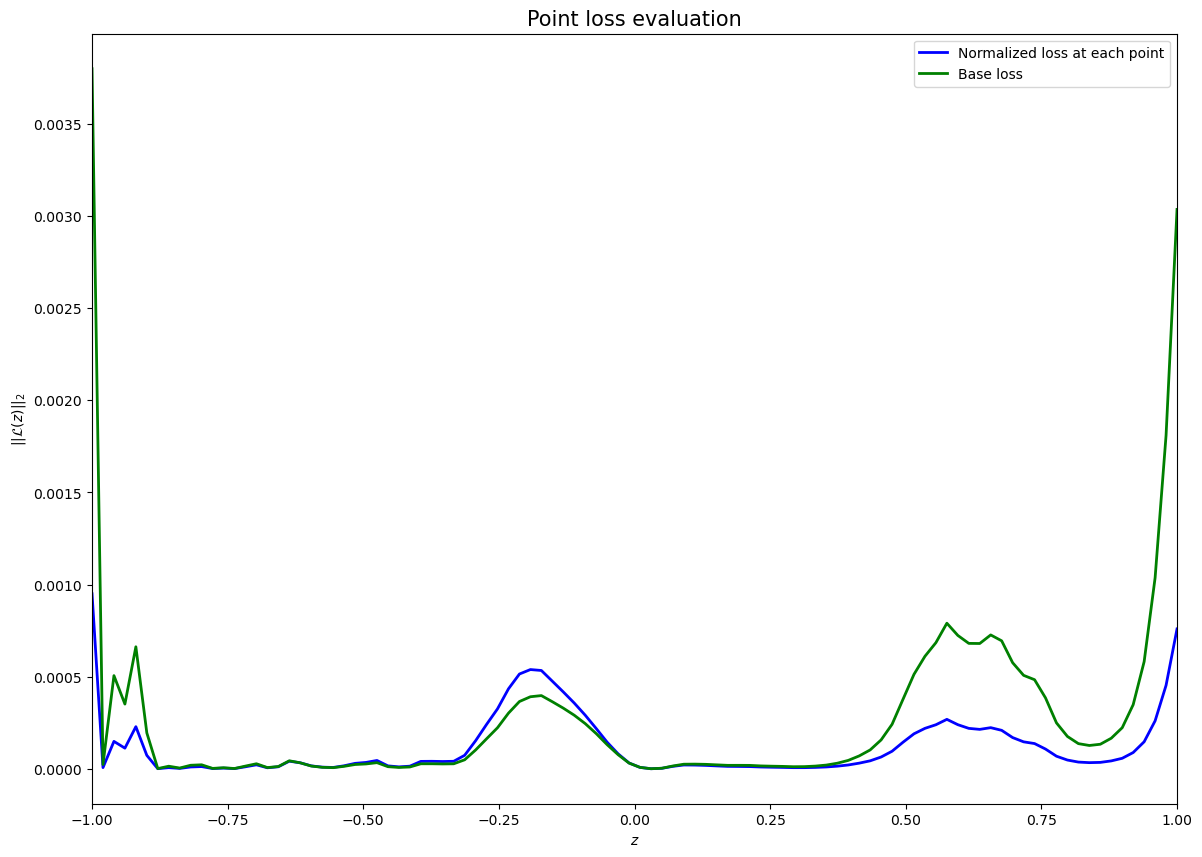

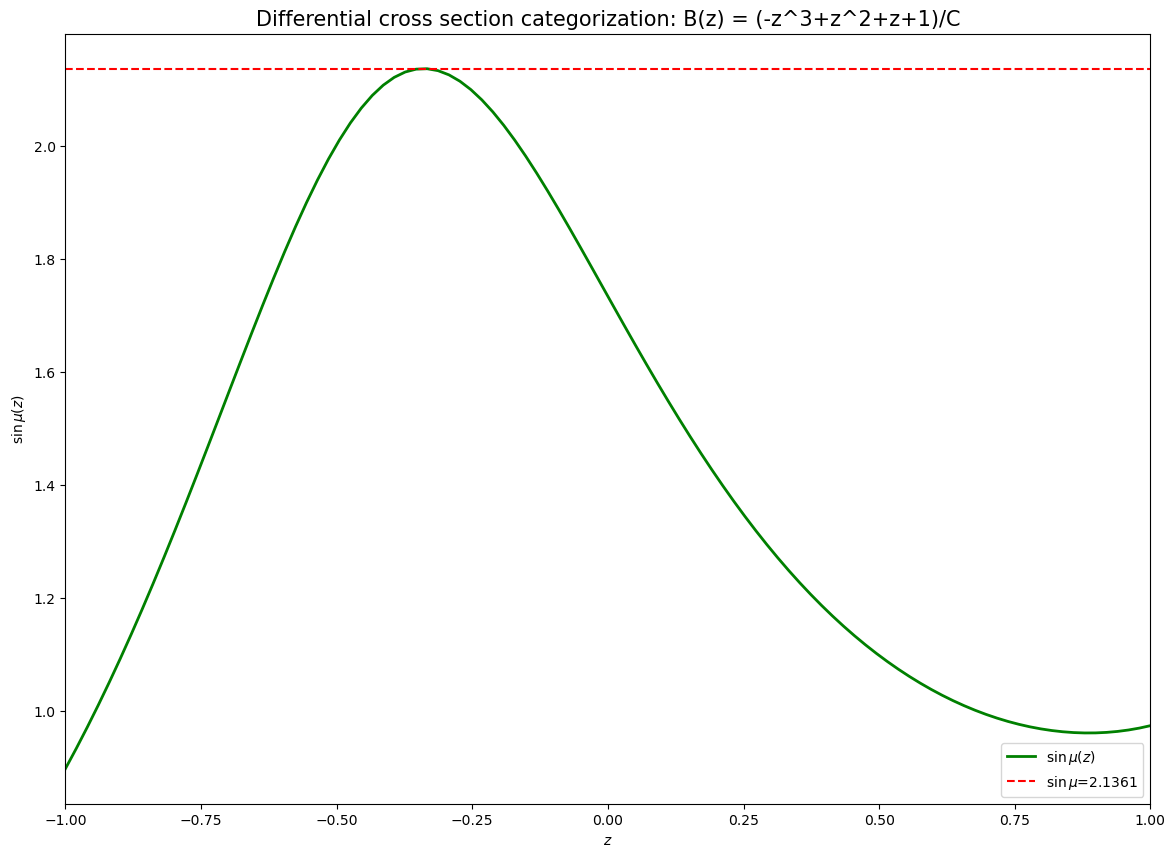

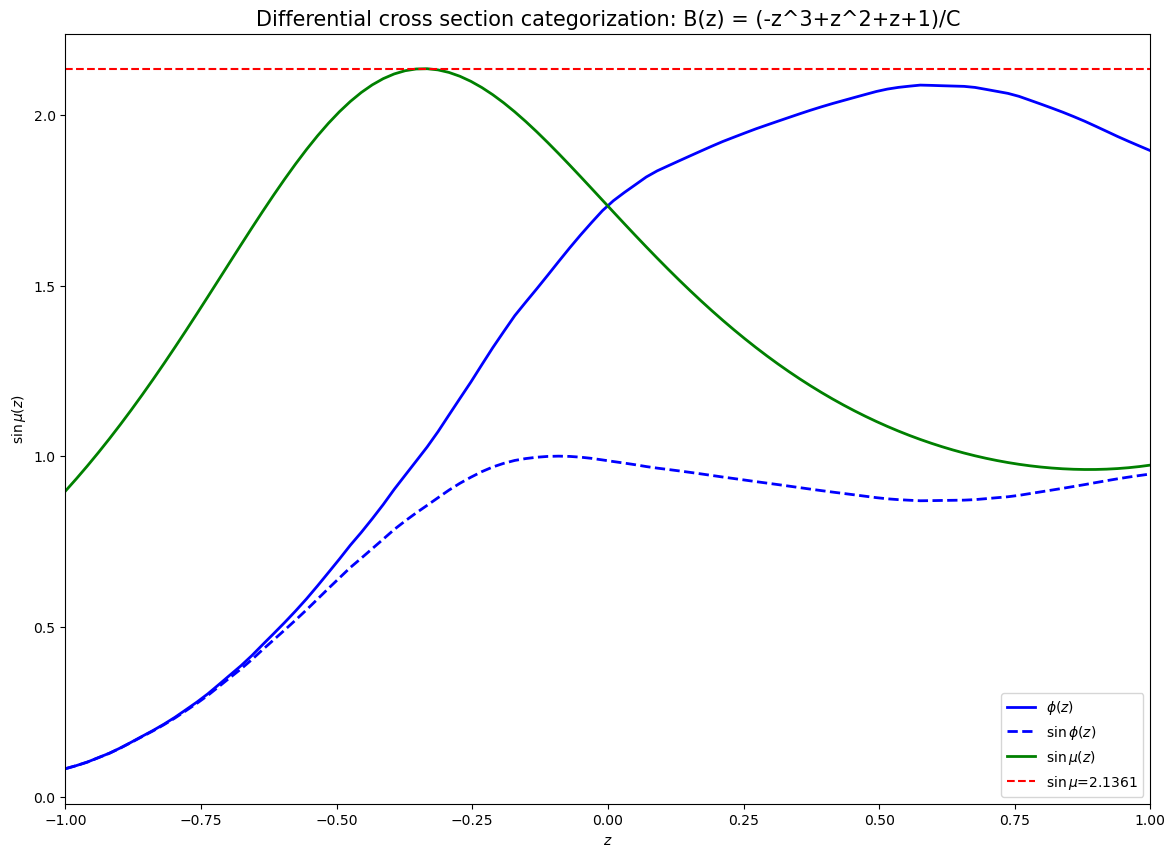

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 70 operations to synchronize with Neptune. Do not kill this process.
All 70 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-347
https://app.neptune.ai/zulap/2to2scattering/e/TOS-348
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

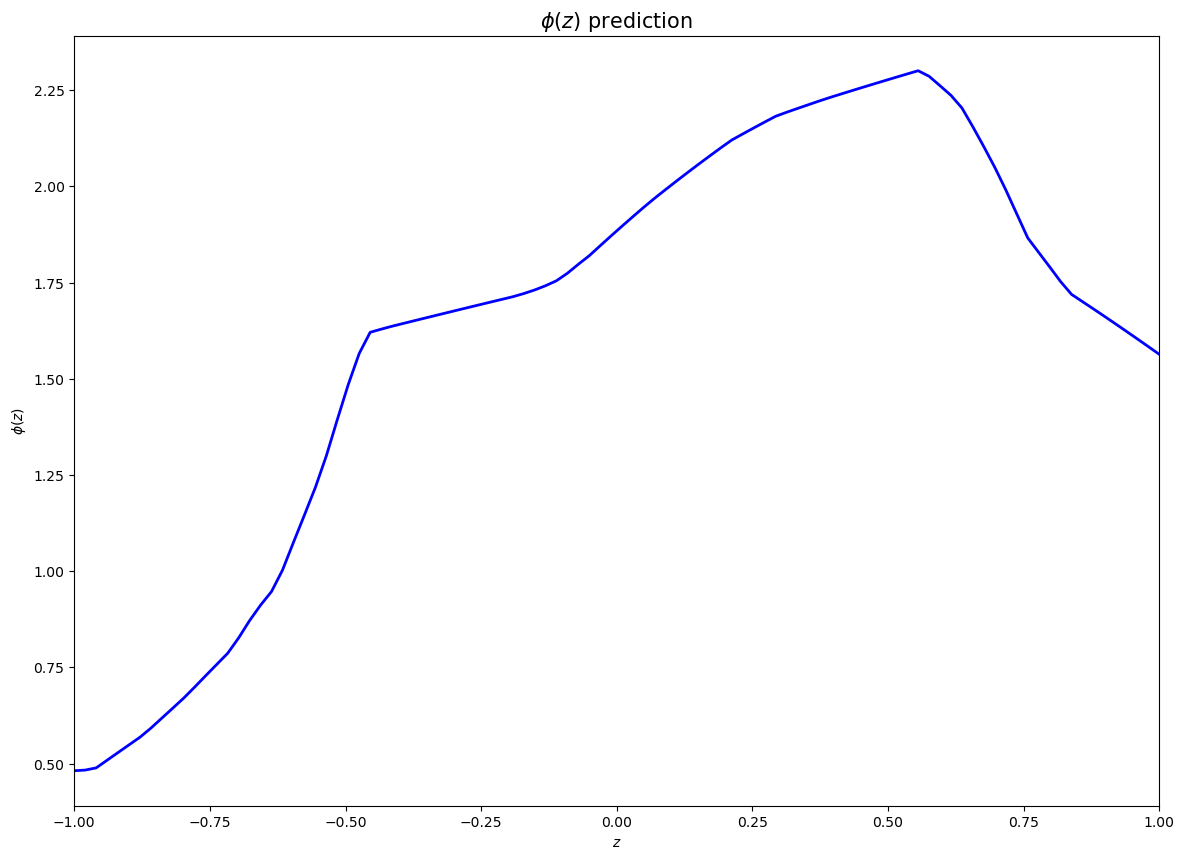

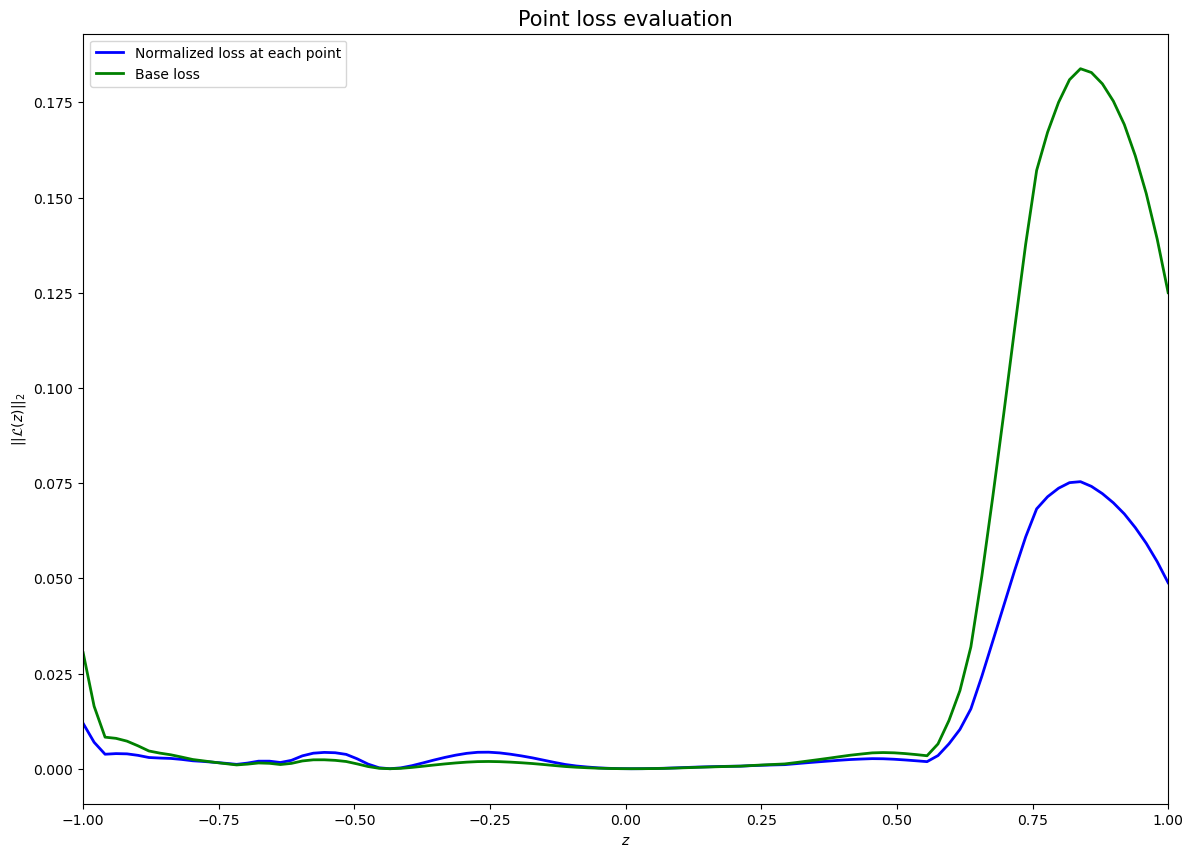

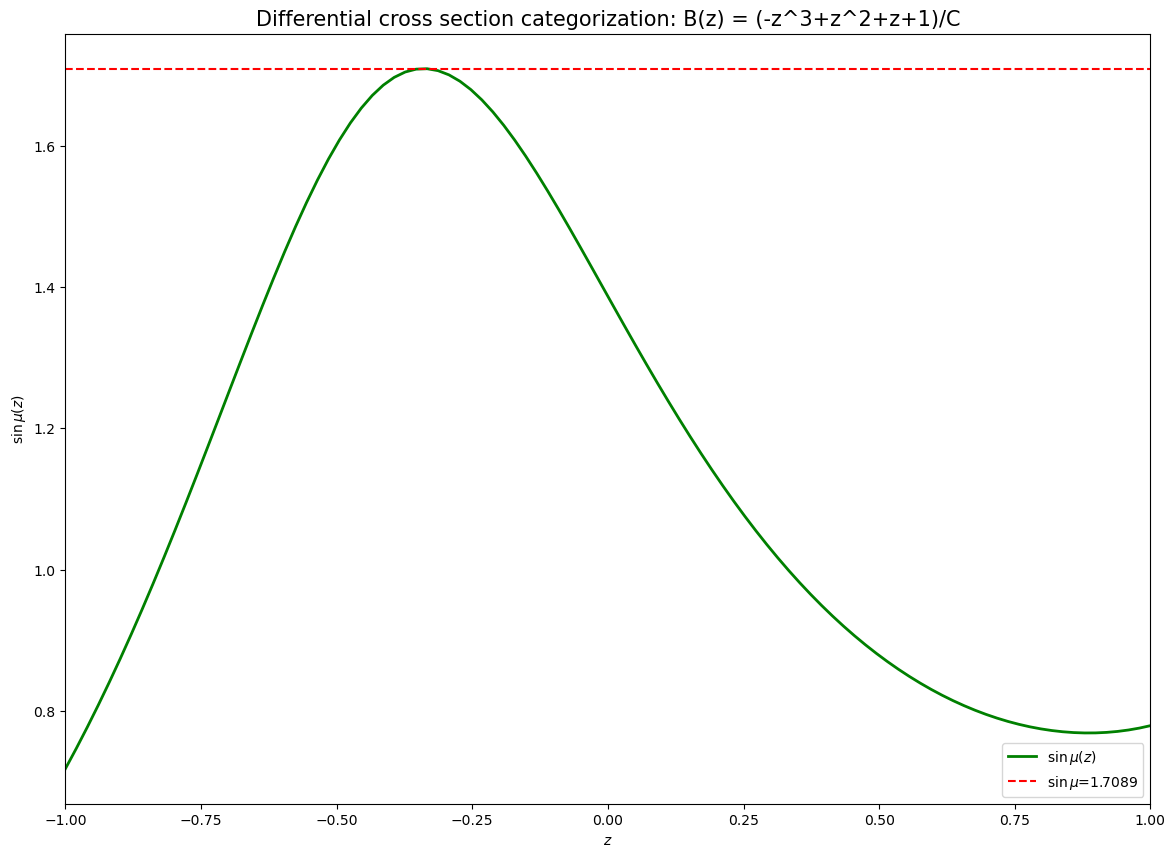

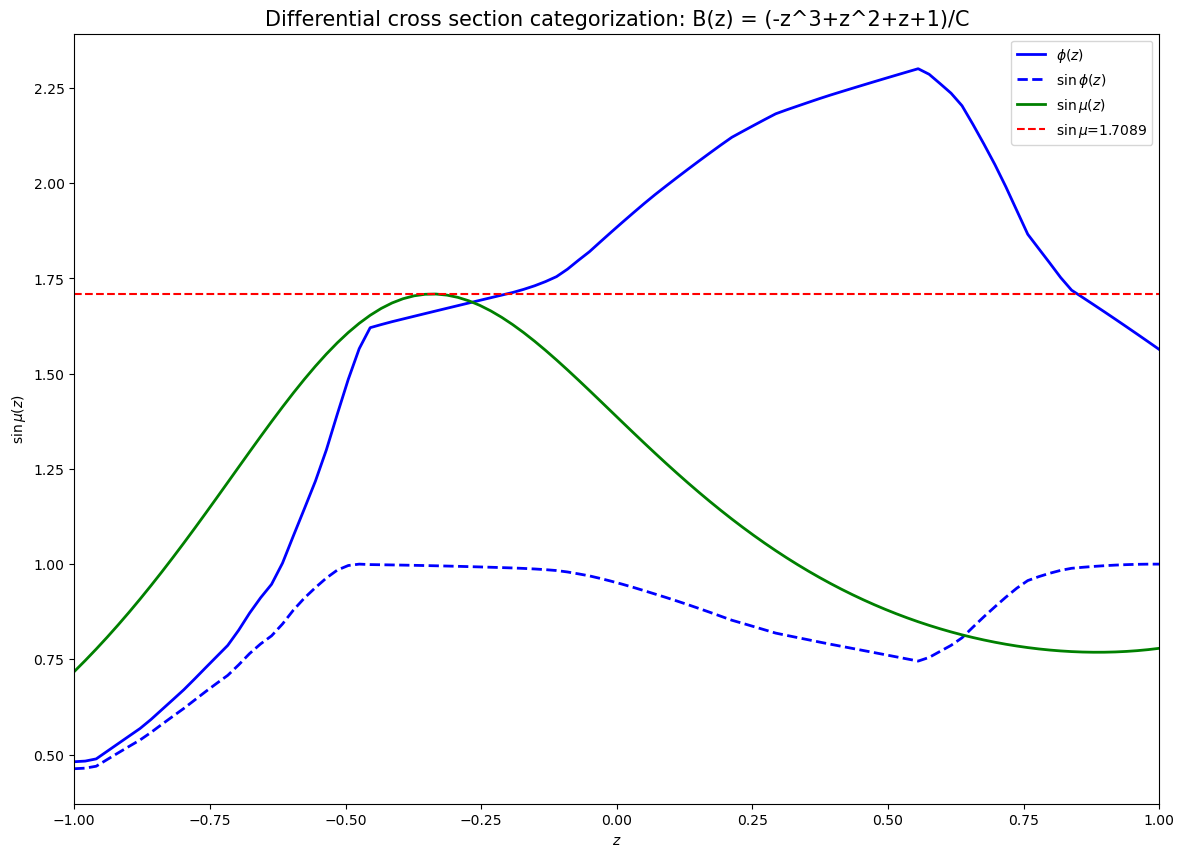

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 150 operations to synchronize with Neptune. Do not kill this process.
All 150 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-348
https://app.neptune.ai/zulap/2to2scattering/e/TOS-349
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_

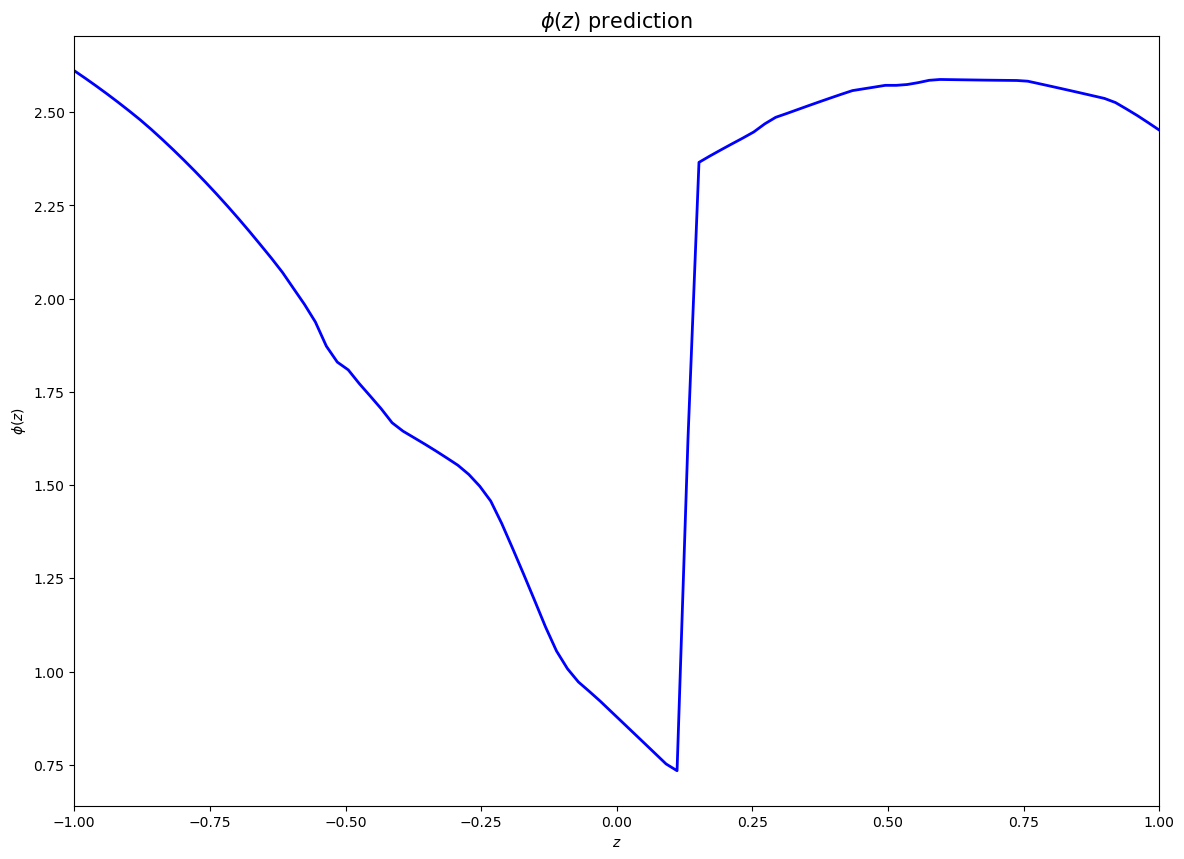

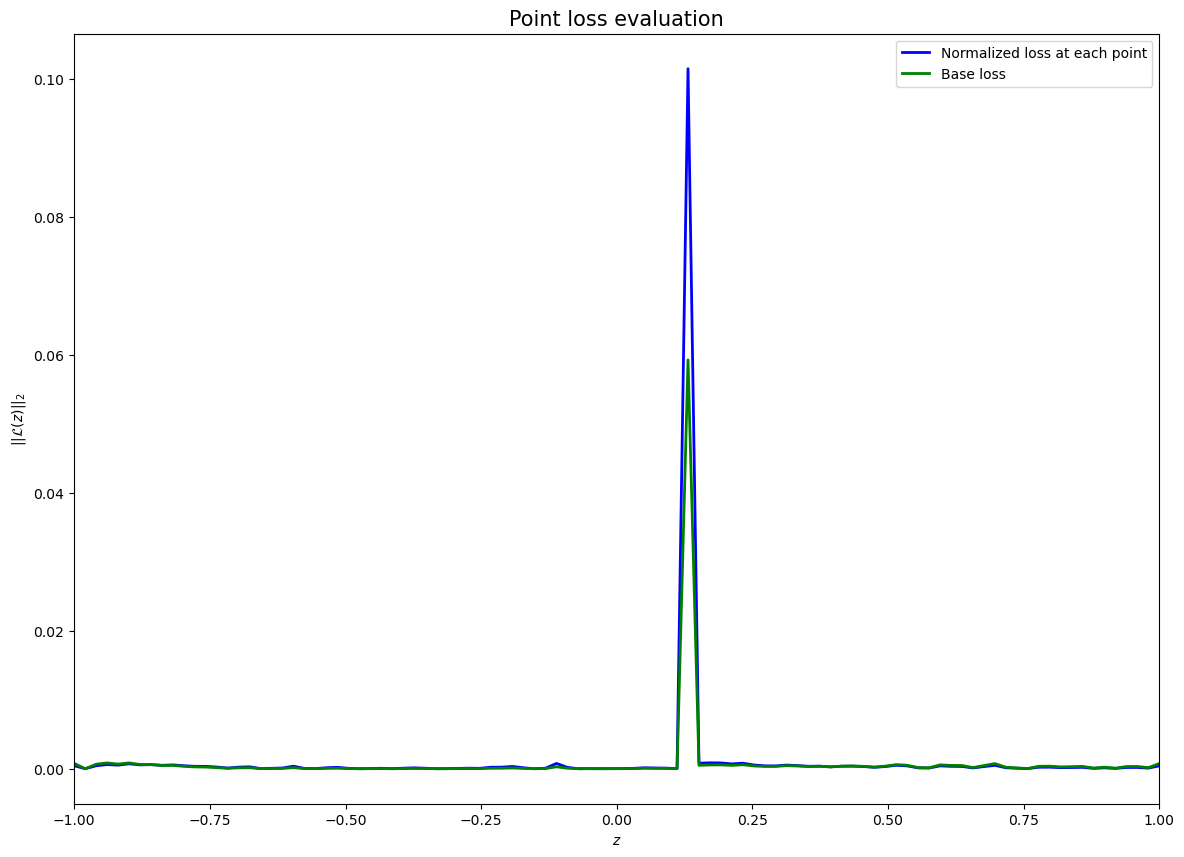

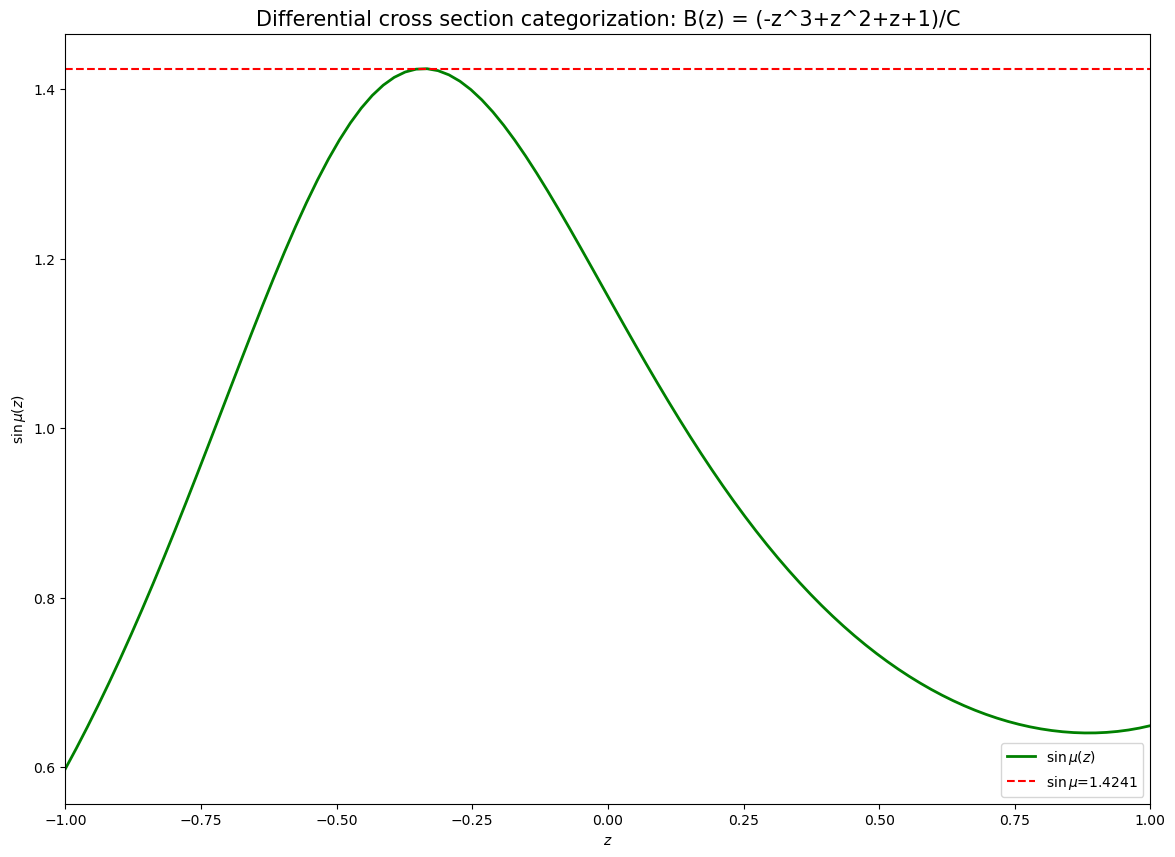

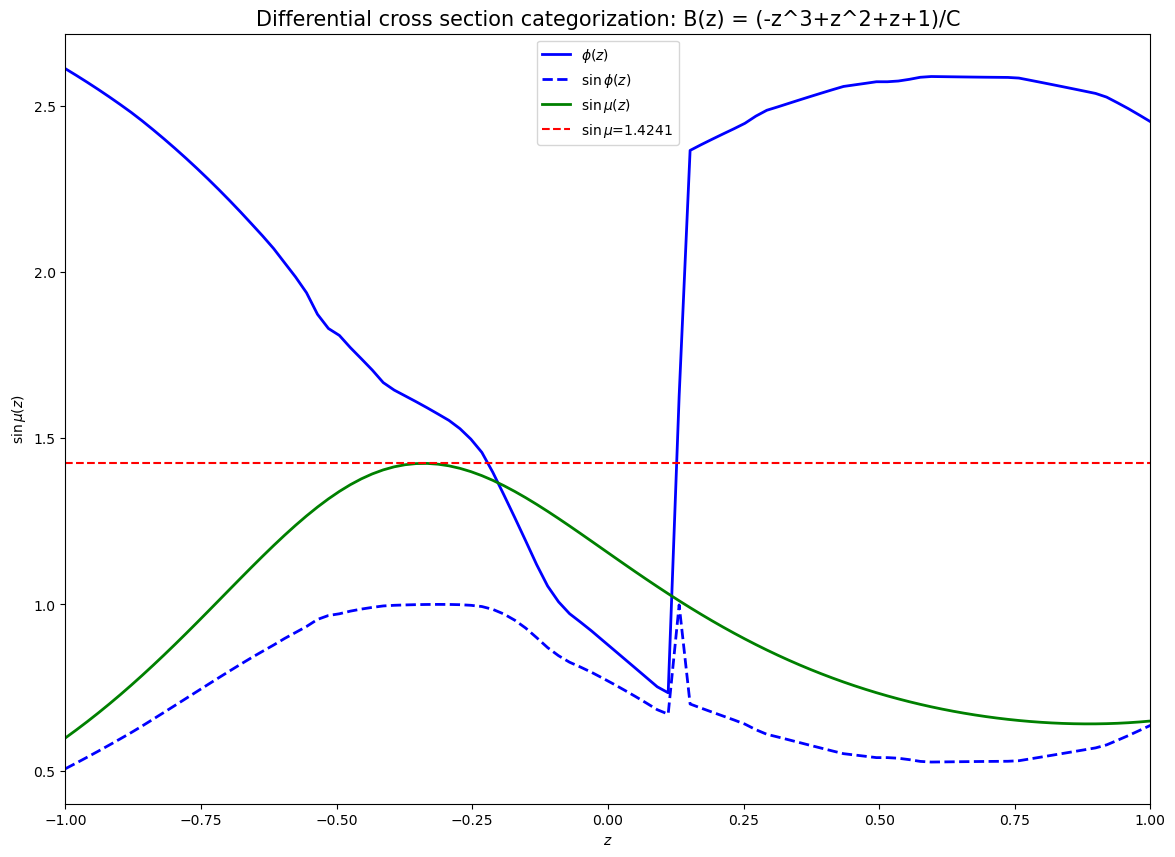

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 136 operations to synchronize with Neptune. Do not kill this process.
All 136 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-349
https://app.neptune.ai/zulap/2to2scattering/e/TOS-350
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_

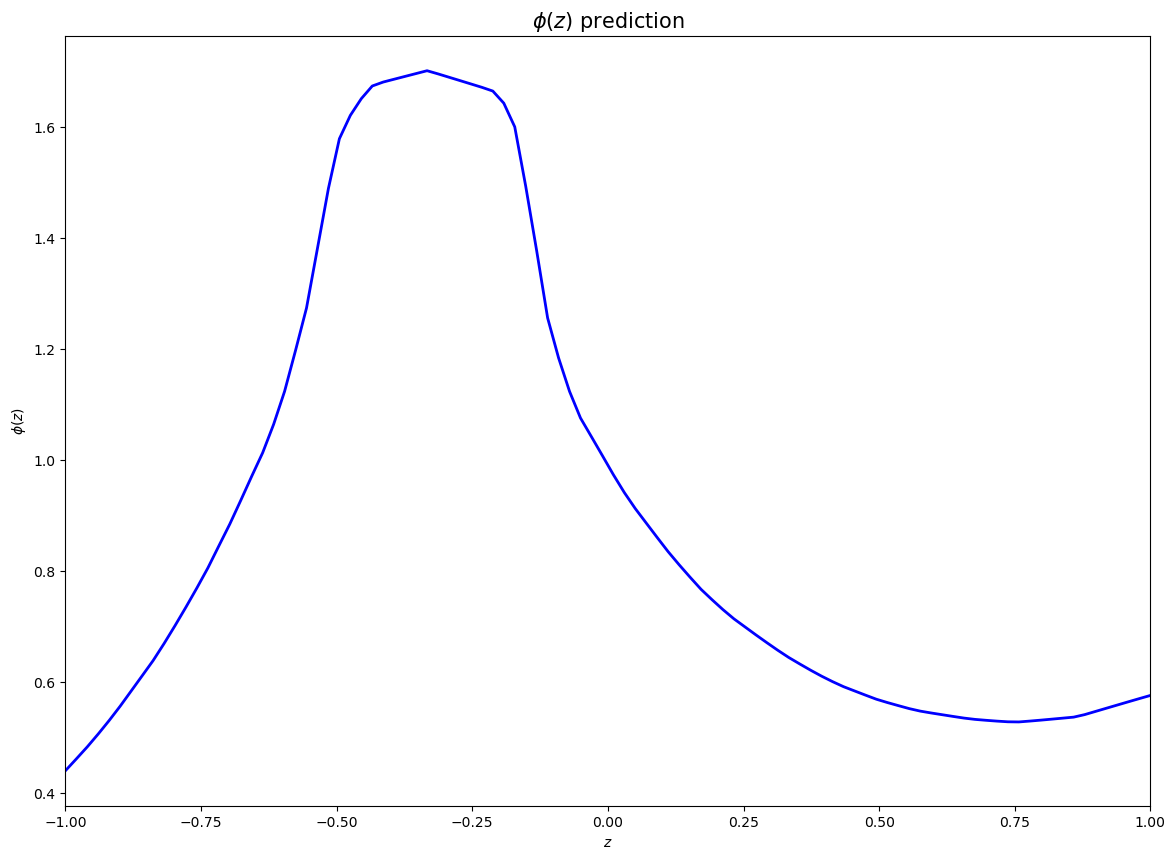

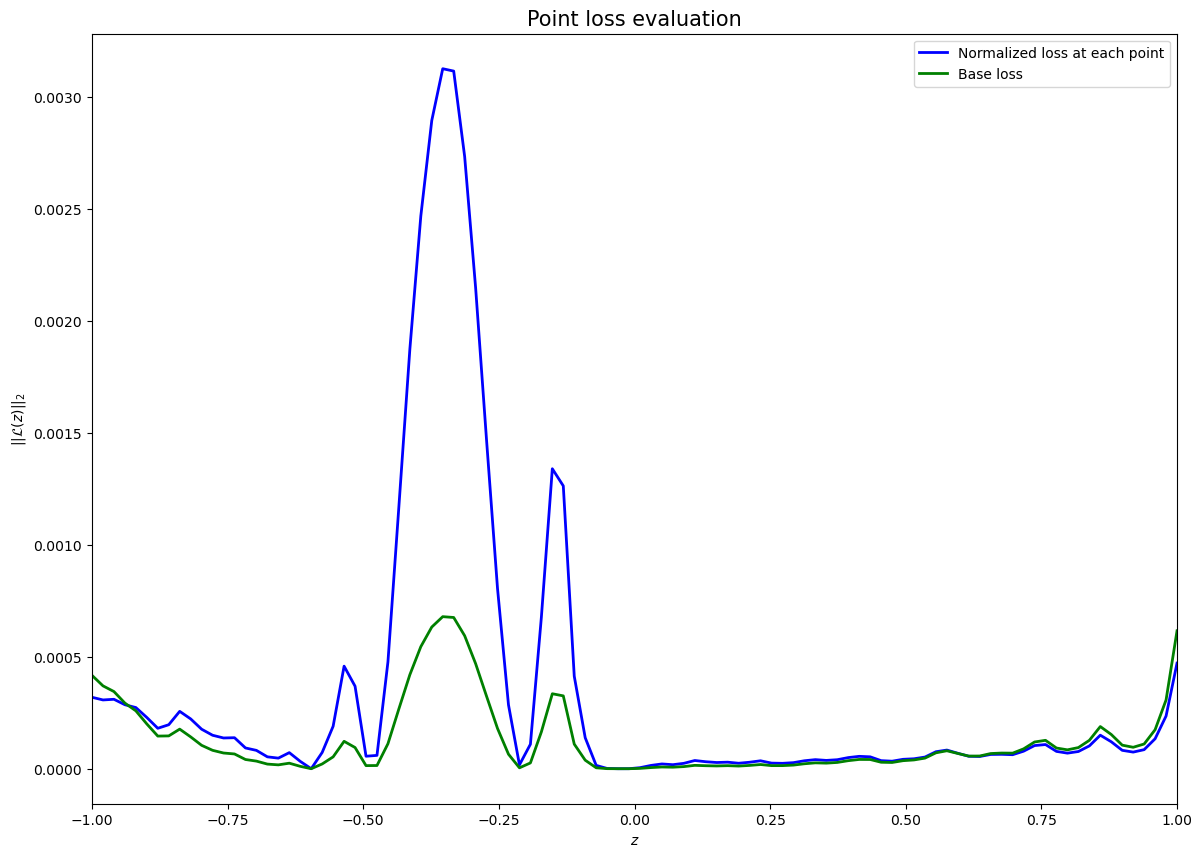

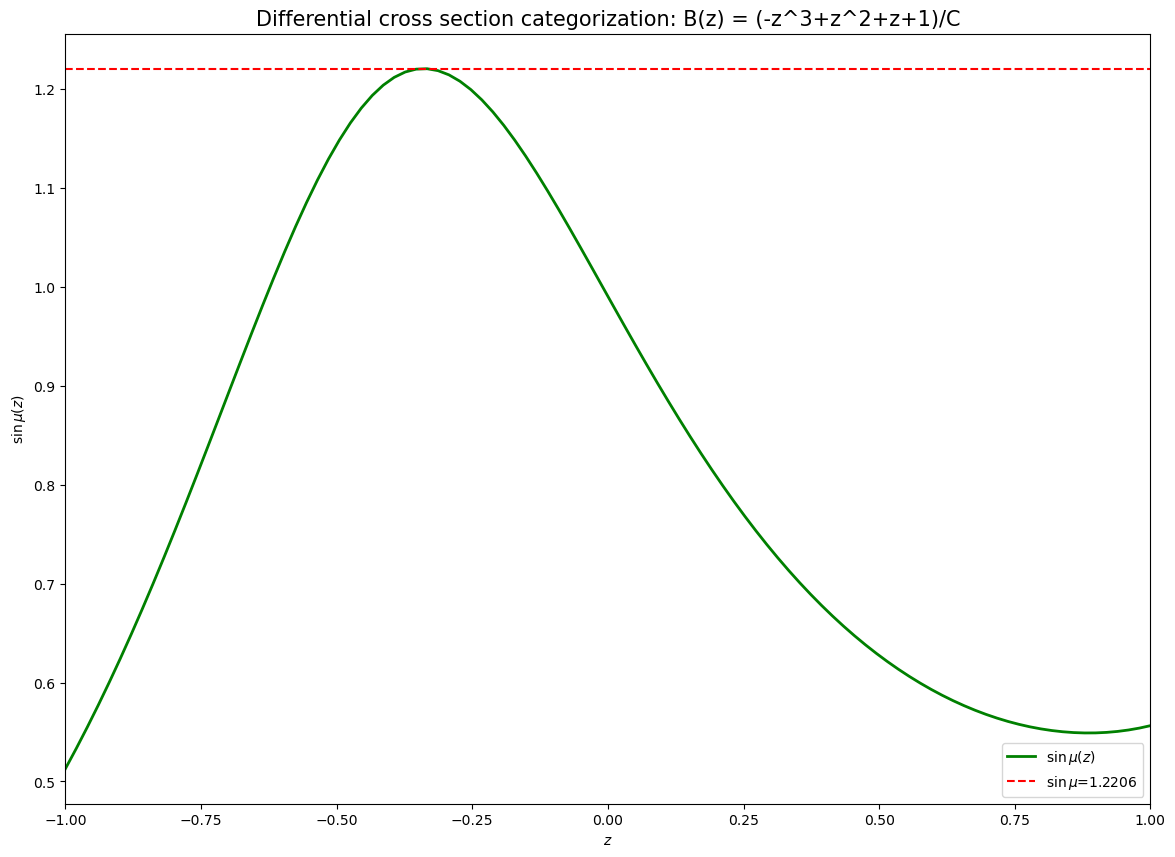

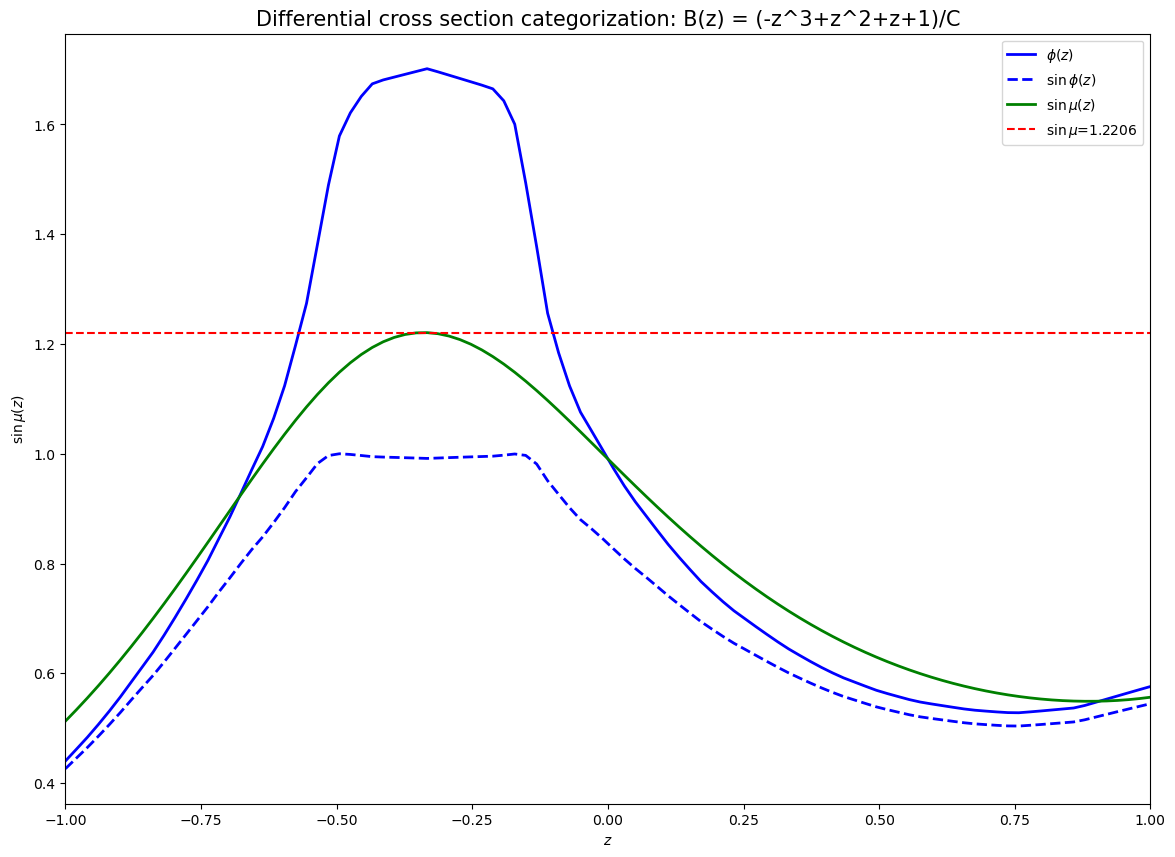

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 70 operations to synchronize with Neptune. Do not kill this process.
All 70 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-350
https://app.neptune.ai/zulap/2to2scattering/e/TOS-351
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

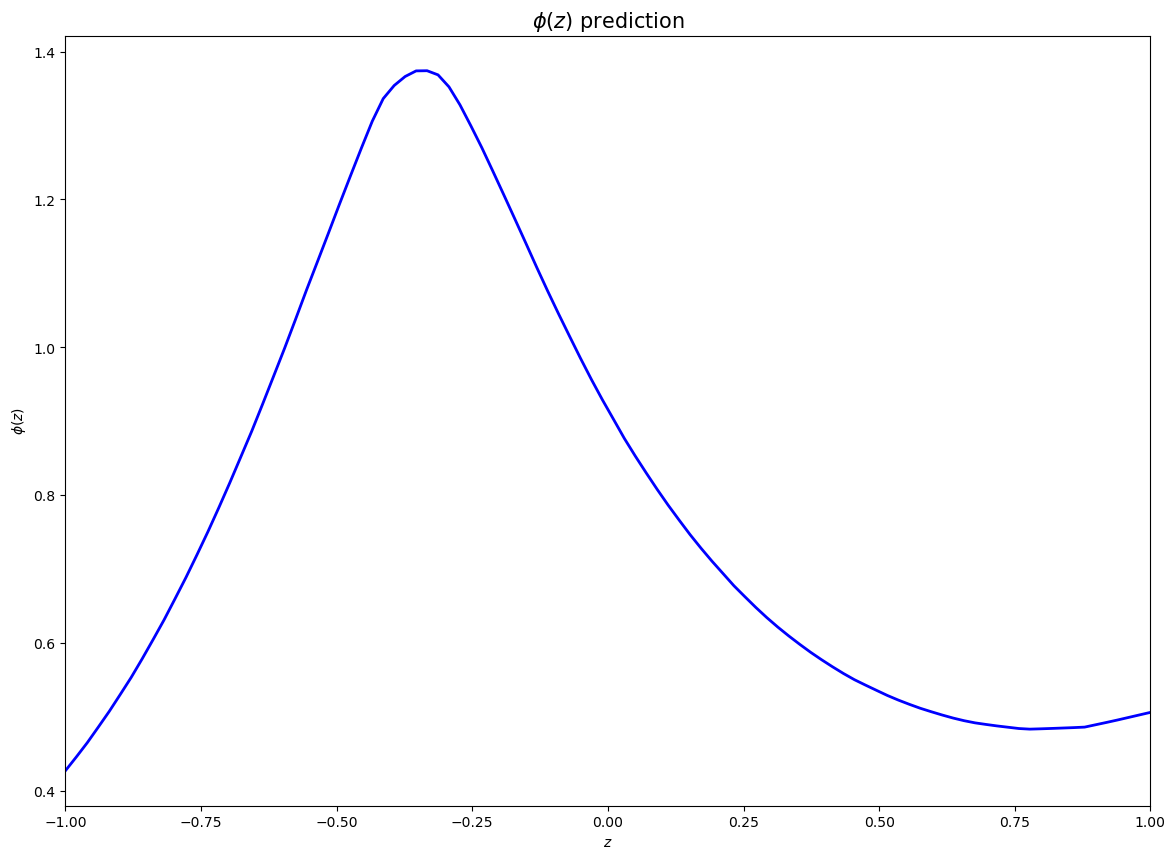

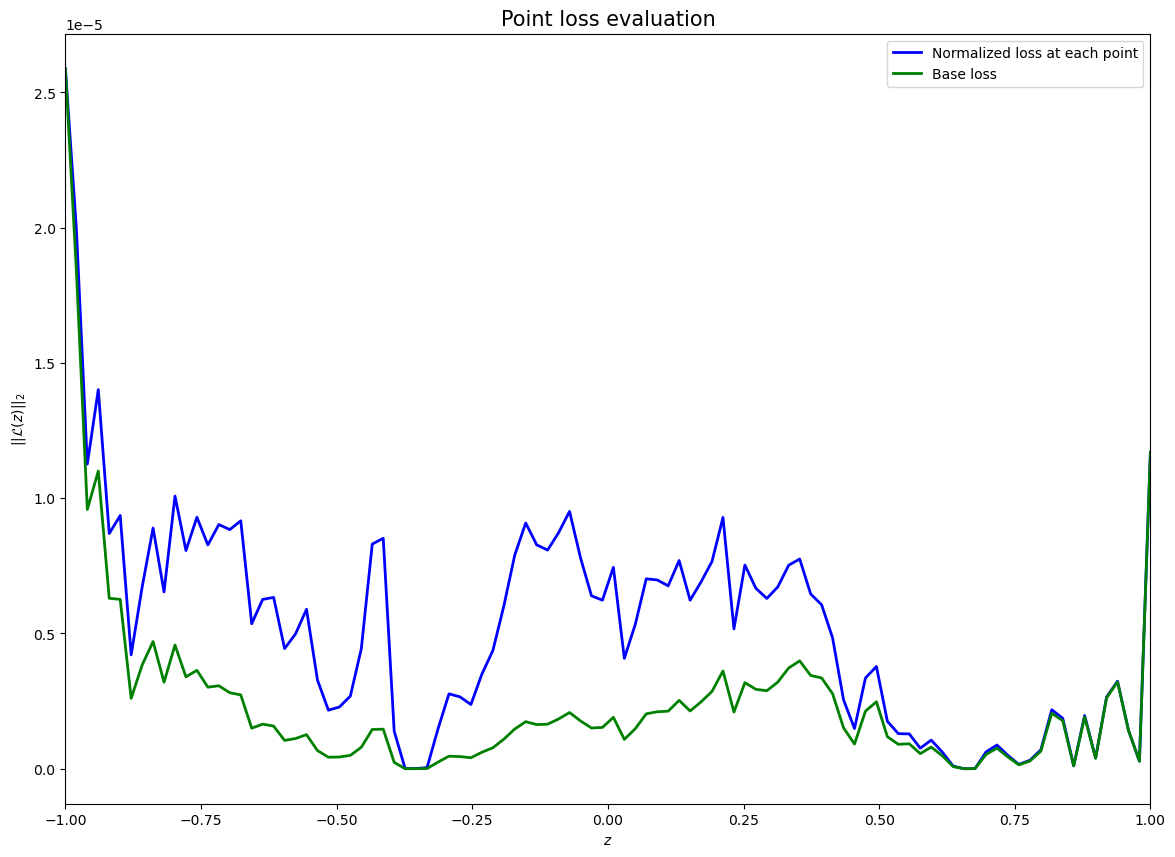

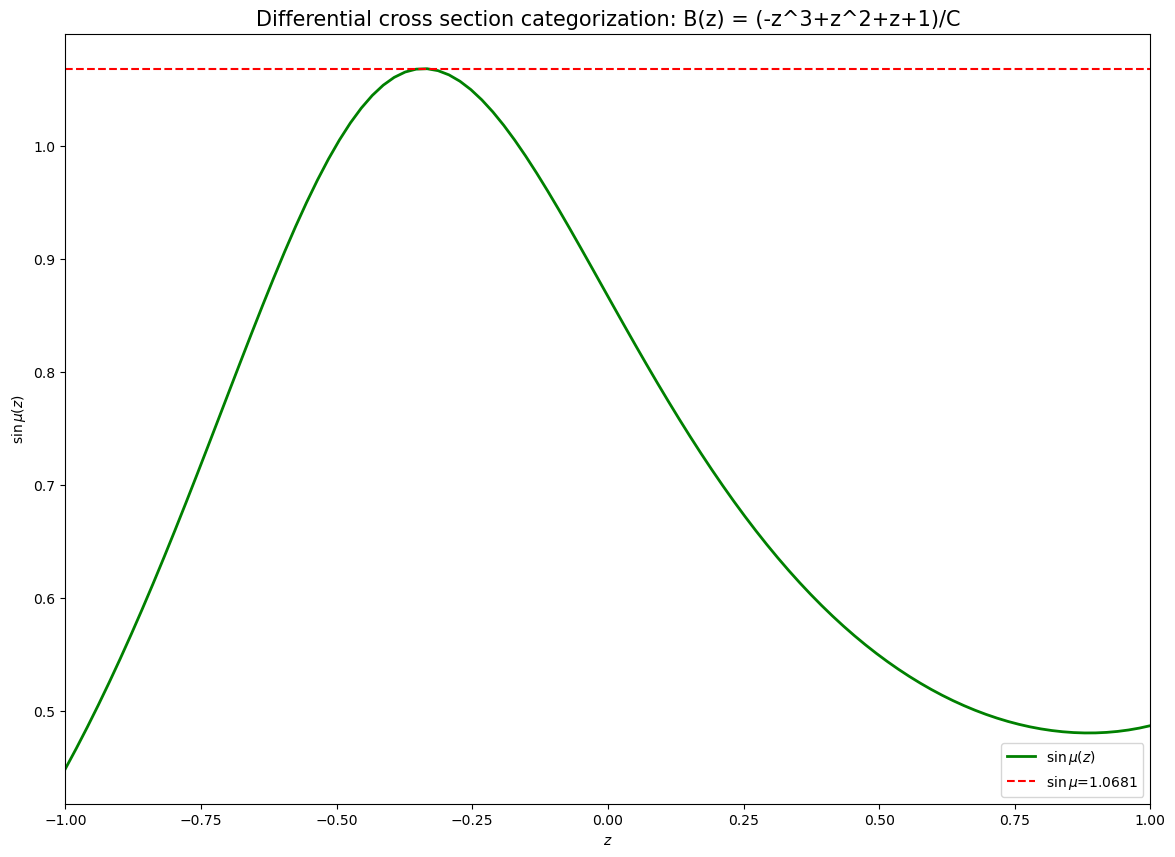

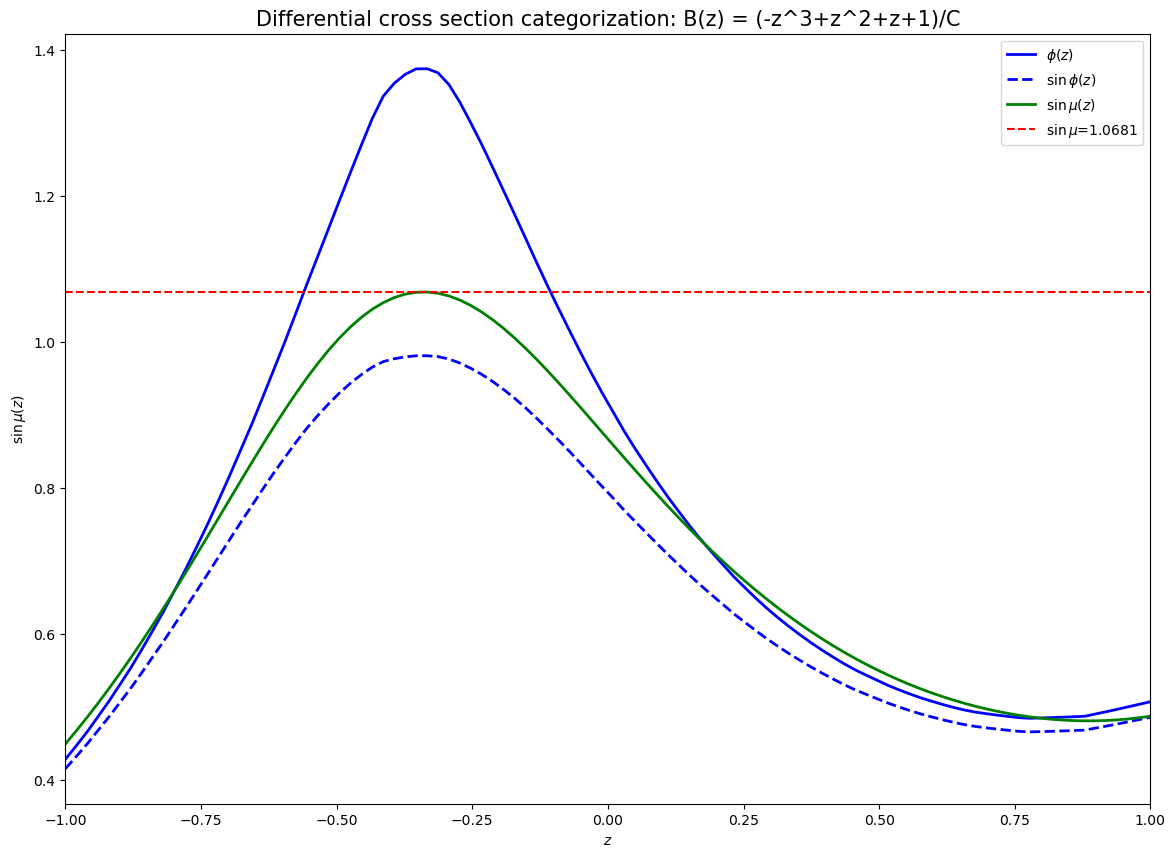

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 70 operations to synchronize with Neptune. Do not kill this process.
All 70 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-351
https://app.neptune.ai/zulap/2to2scattering/e/TOS-352
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

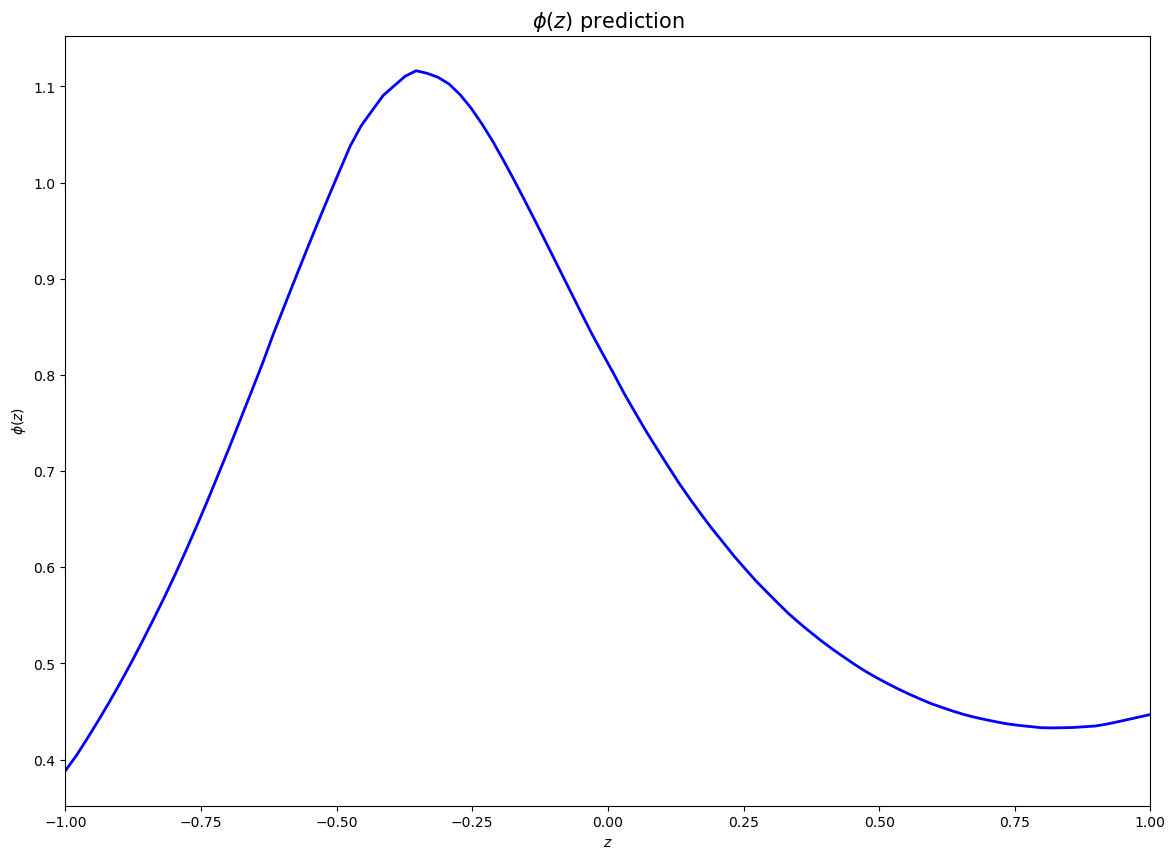

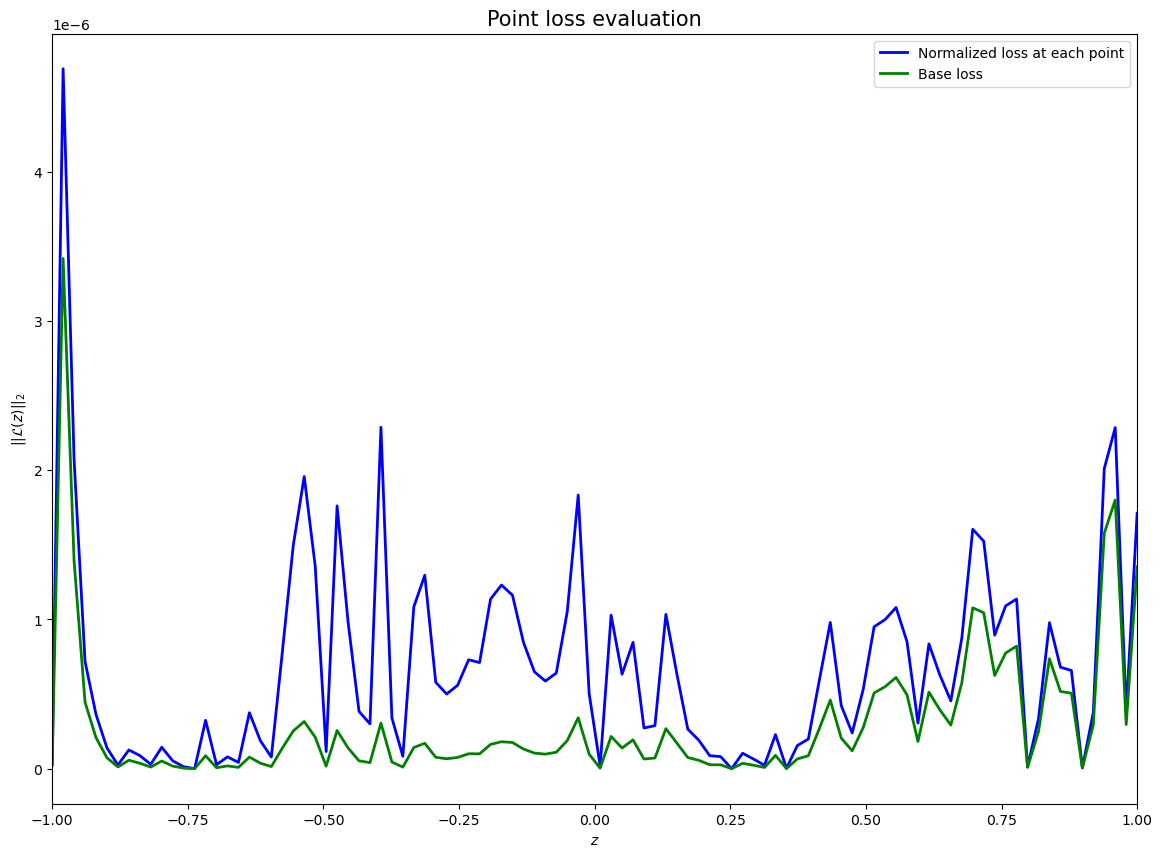

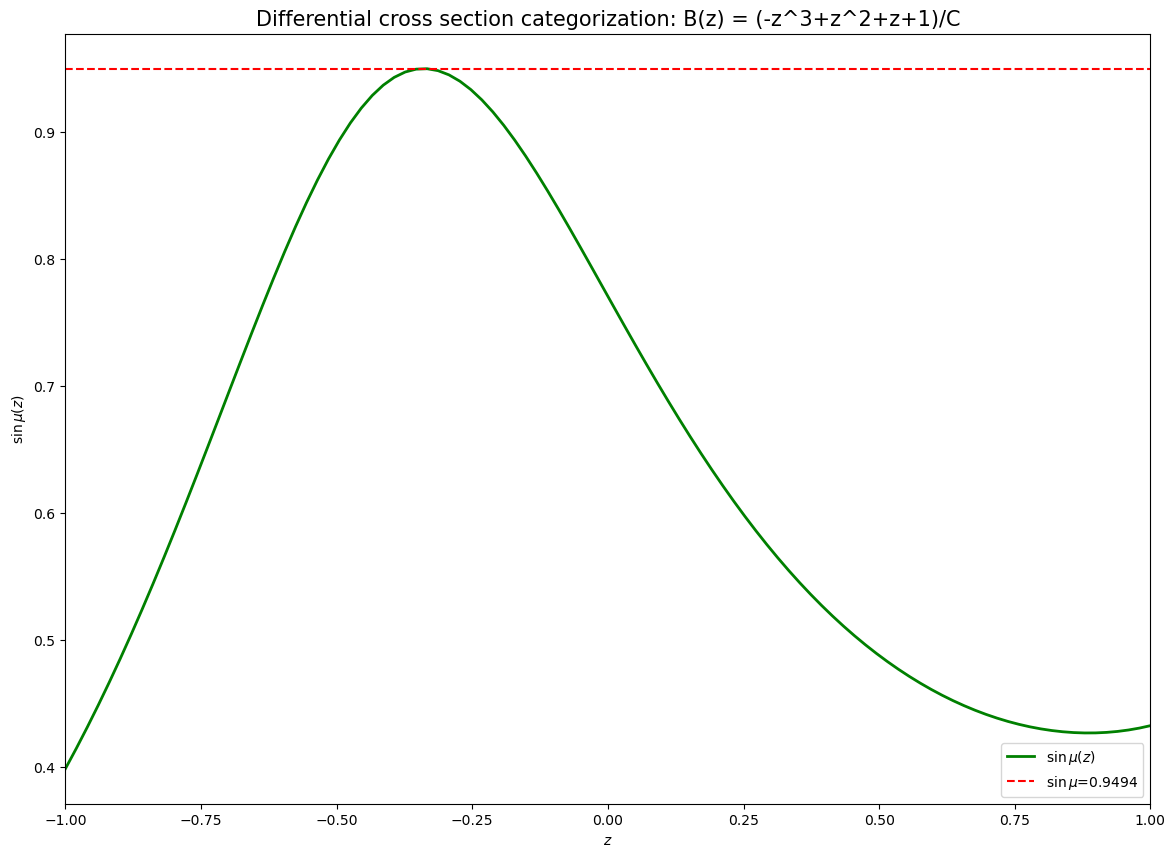

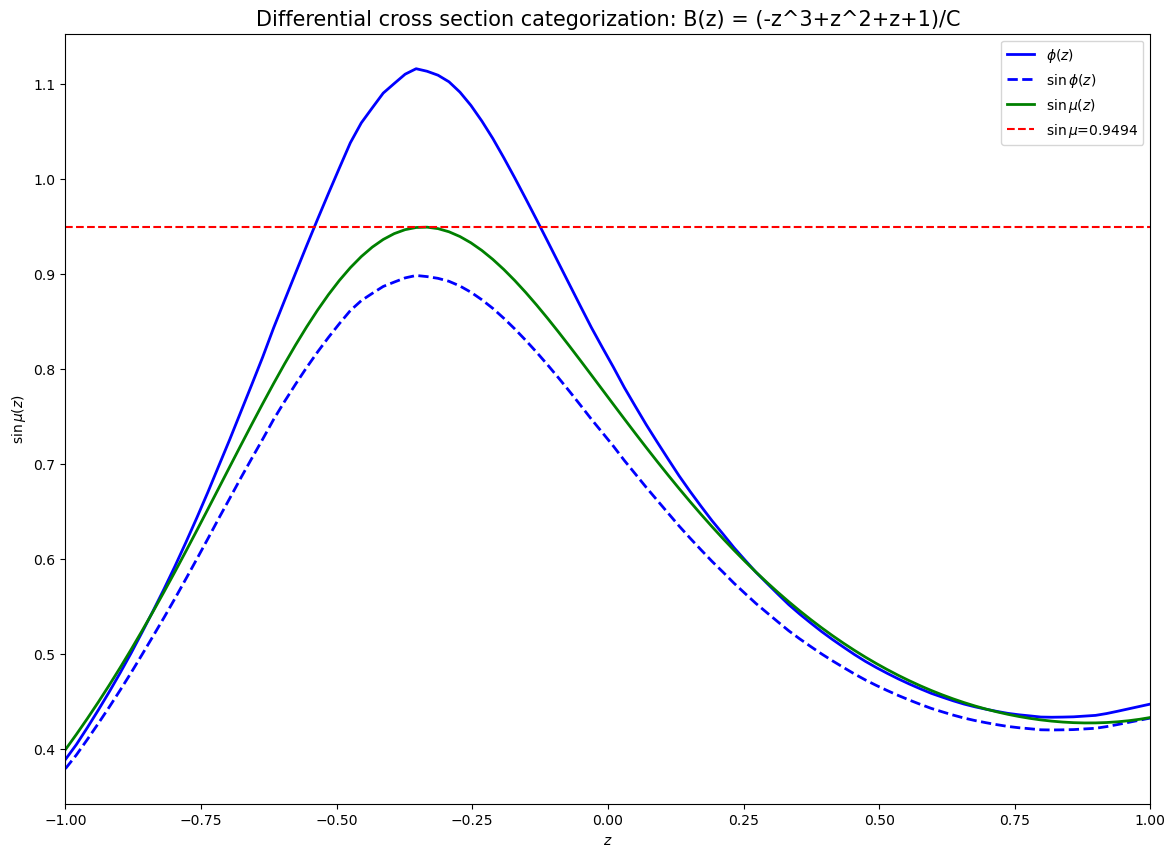

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 60 operations to synchronize with Neptune. Do not kill this process.
All 60 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-352
https://app.neptune.ai/zulap/2to2scattering/e/TOS-353
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

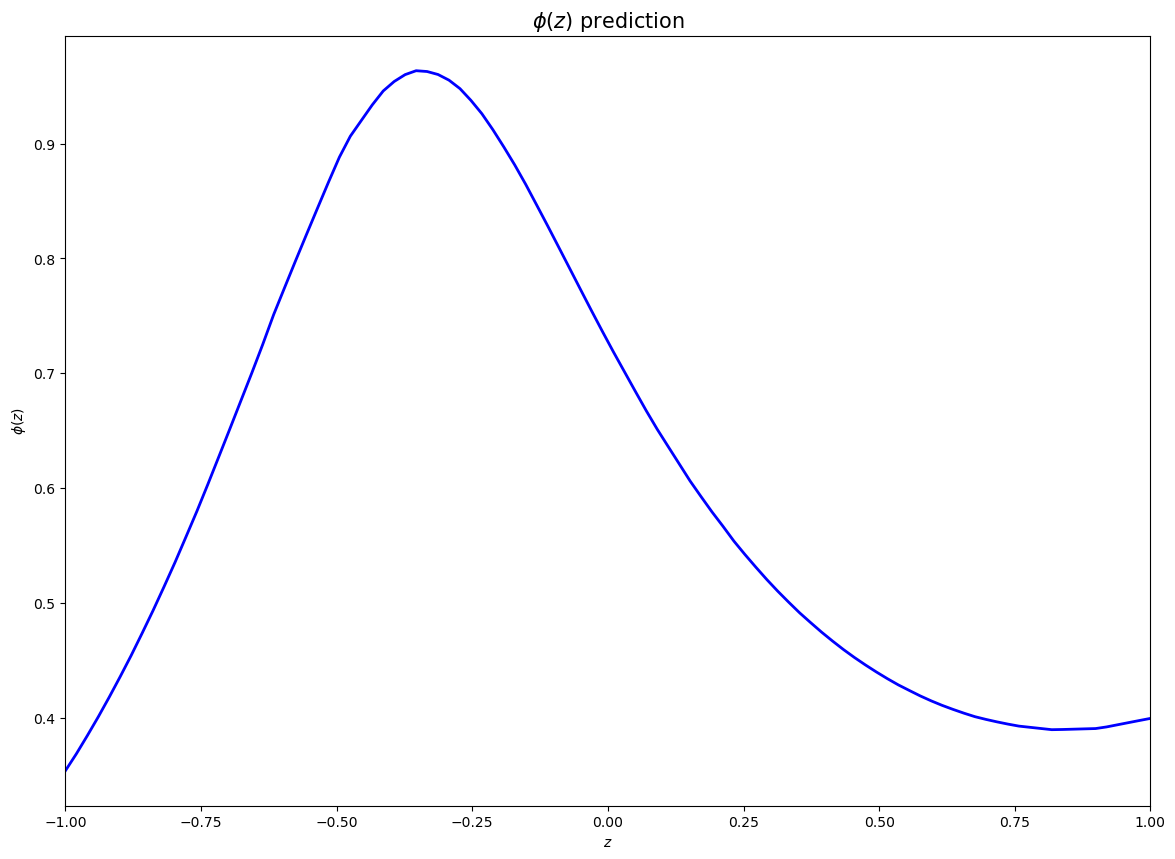

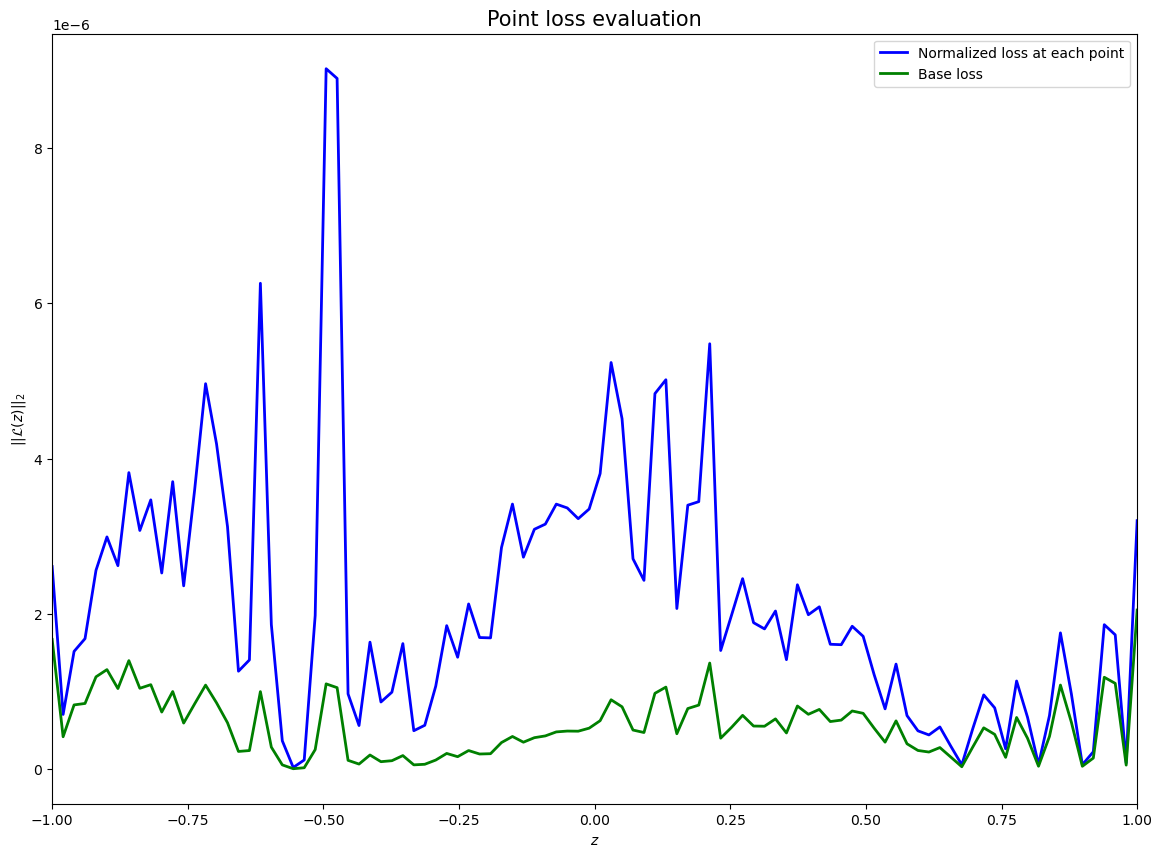

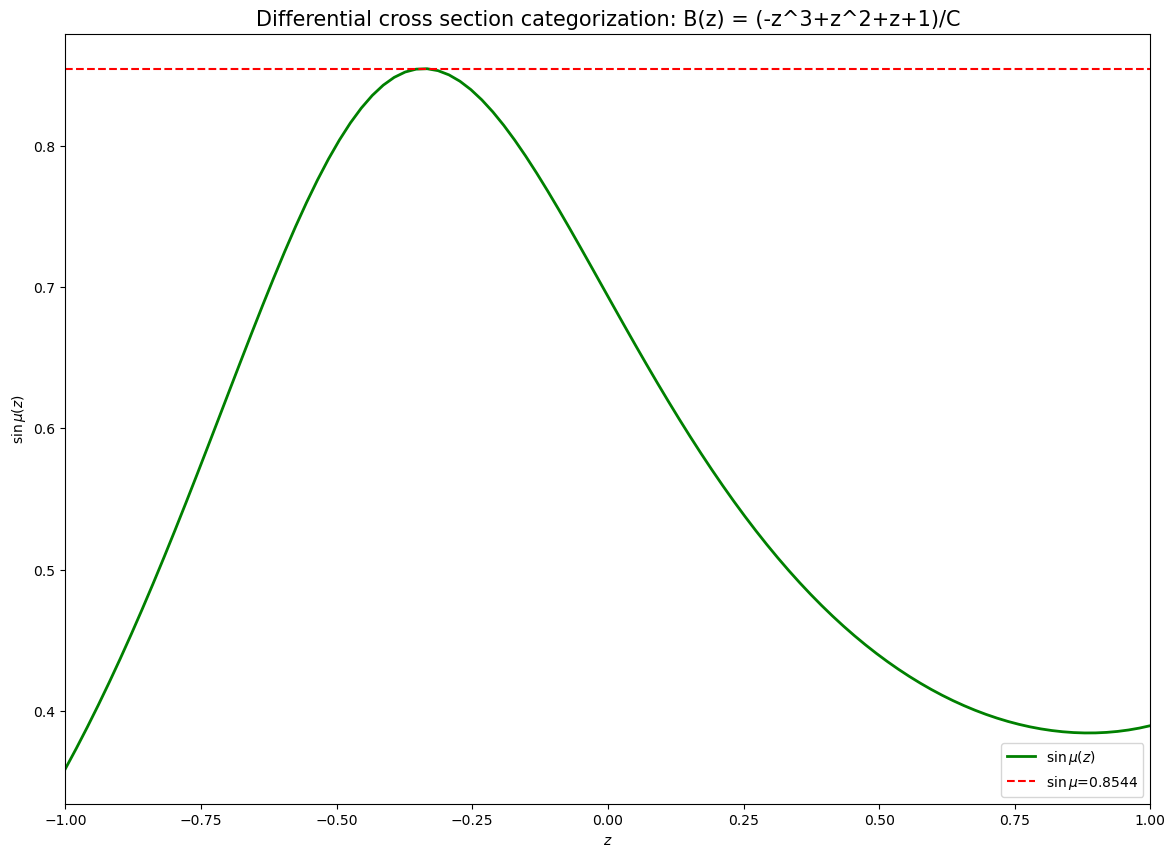

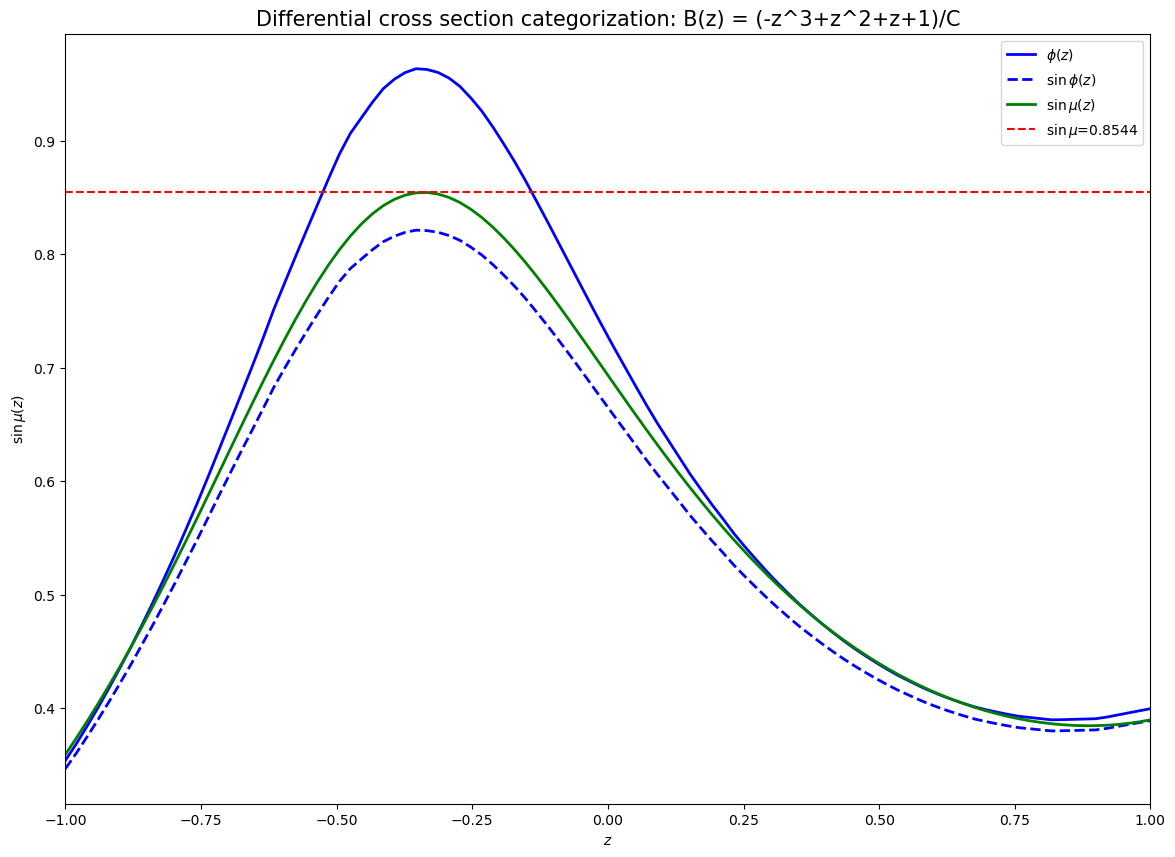

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 38 operations to synchronize with Neptune. Do not kill this process.
All 38 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-353
https://app.neptune.ai/zulap/2to2scattering/e/TOS-354
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5)

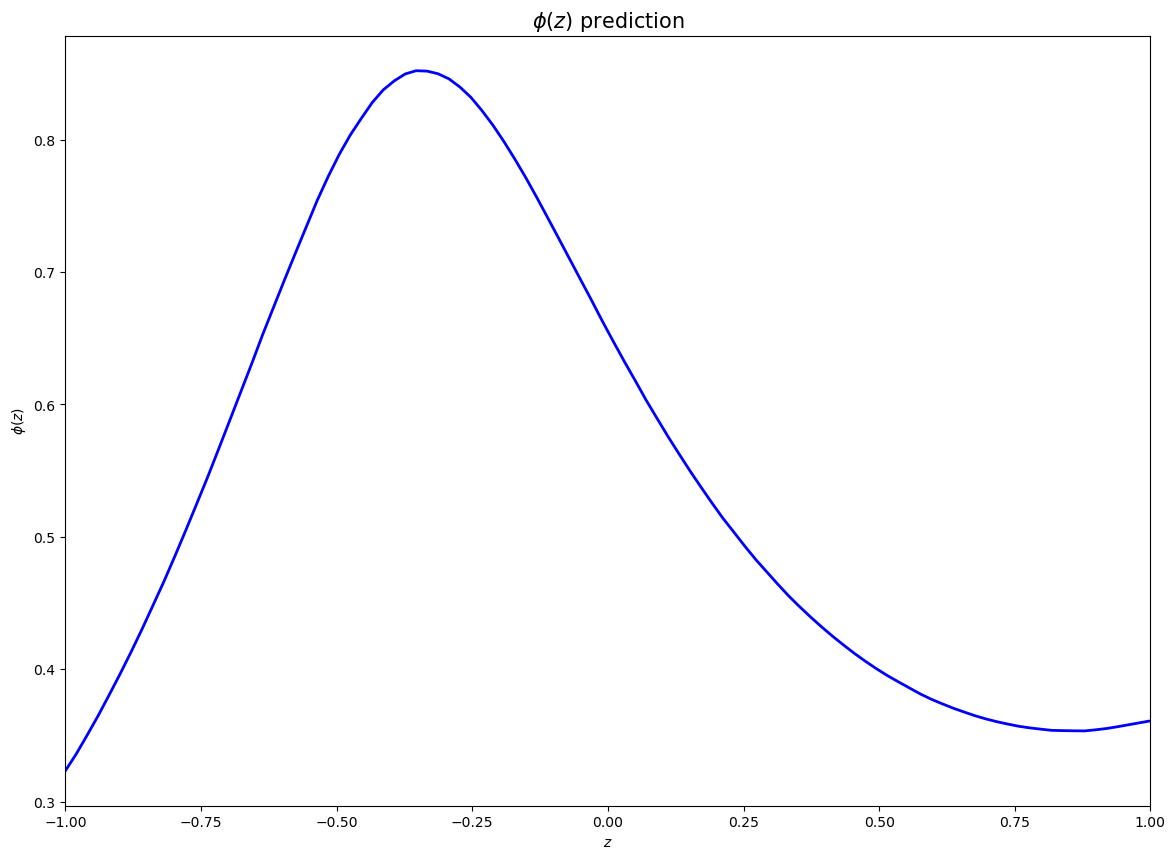

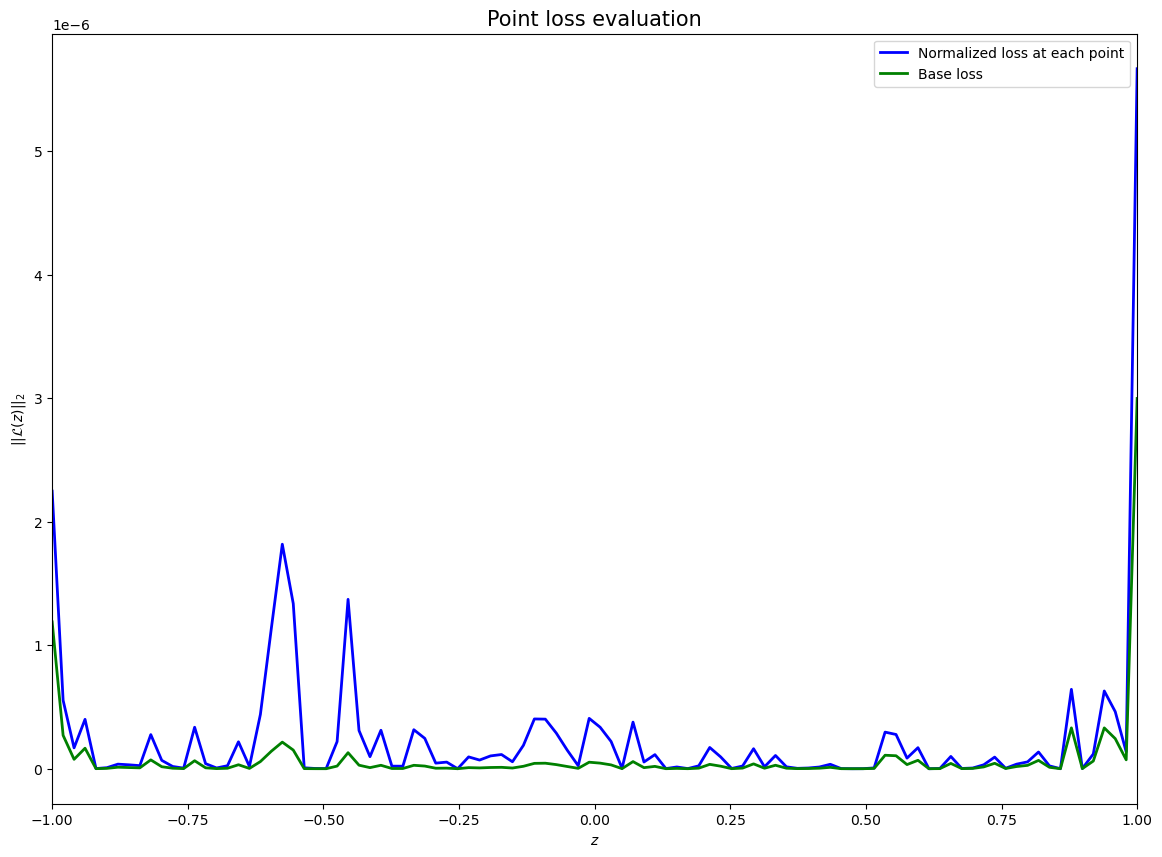

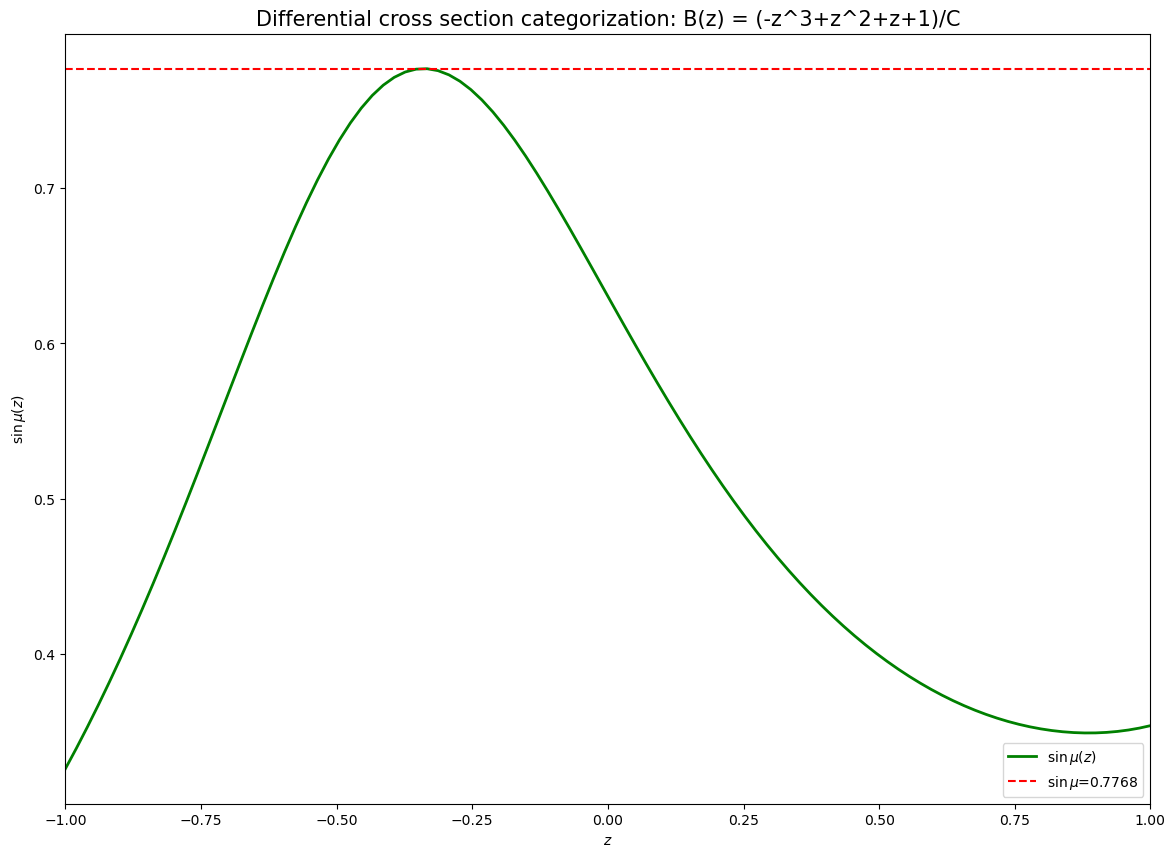

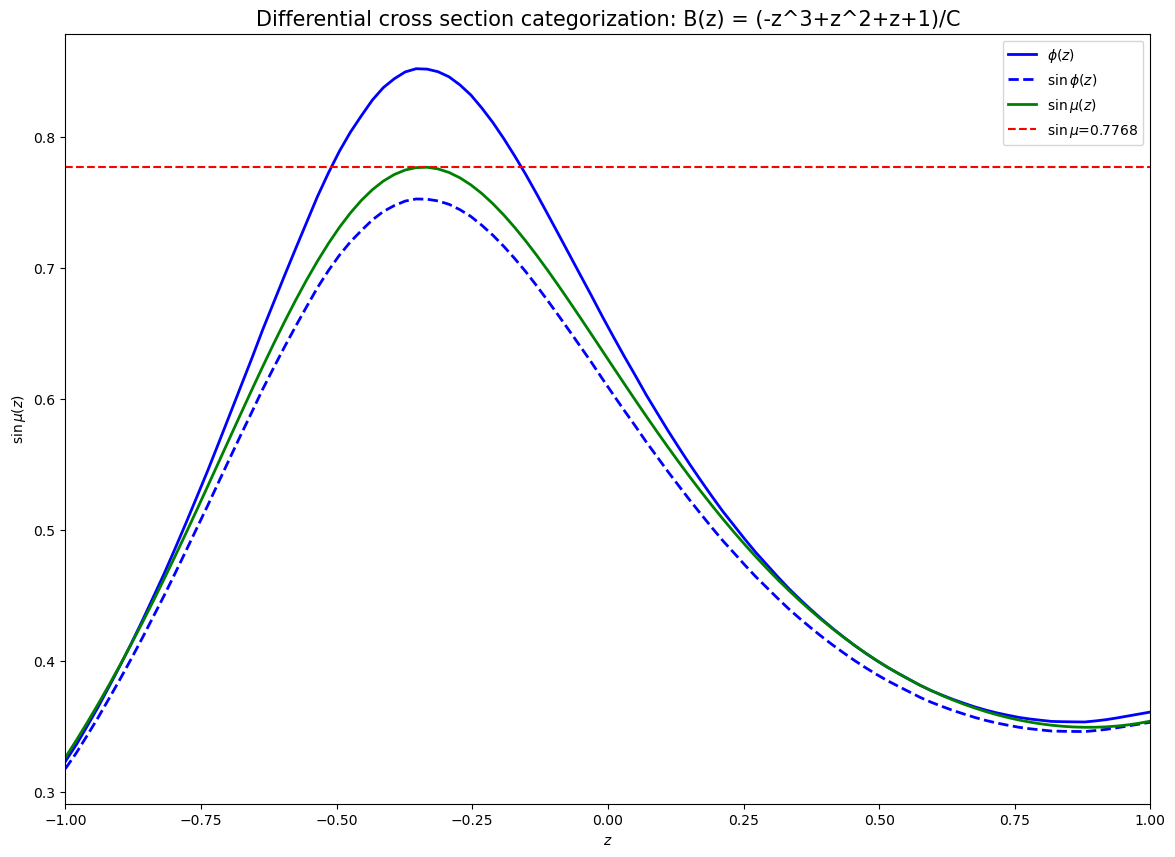

Shutting down background jobs, please wait a moment...


Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/websocket/_socket.py", line 108, in recv
    bytes_ = _recv()
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/websocket/_socket.py", line 87, in _recv
    return sock.recv(bufsize)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/ssl.py", line 1227, in recv
    return self.read(buflen)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/ssl.py", line 1102, in read
    return self._sslobj.read(len)
TimeoutError: [Errno 60] Operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/neptune/ne

Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-354
https://app.neptune.ai/zulap/2to2scattering/e/TOS-355
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.069205
Train Epoch: 15 ; tLoss: 0.014097
T

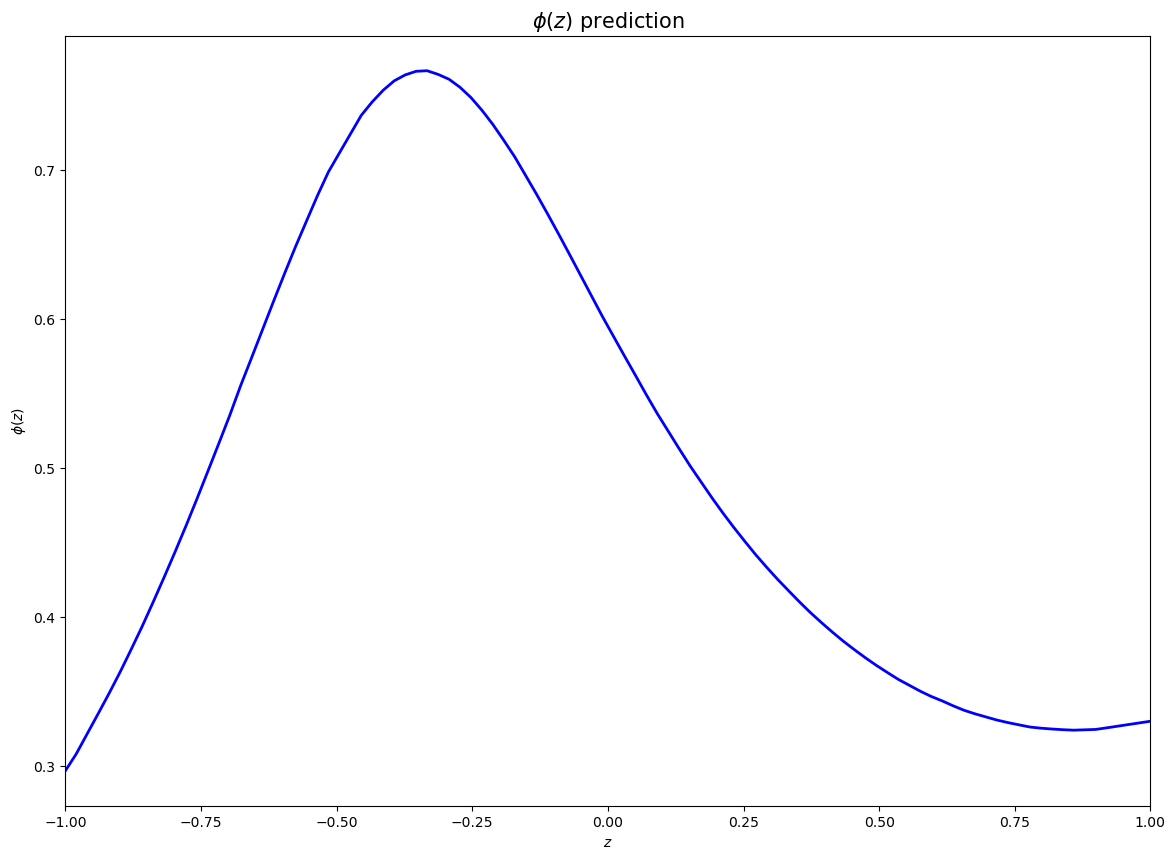

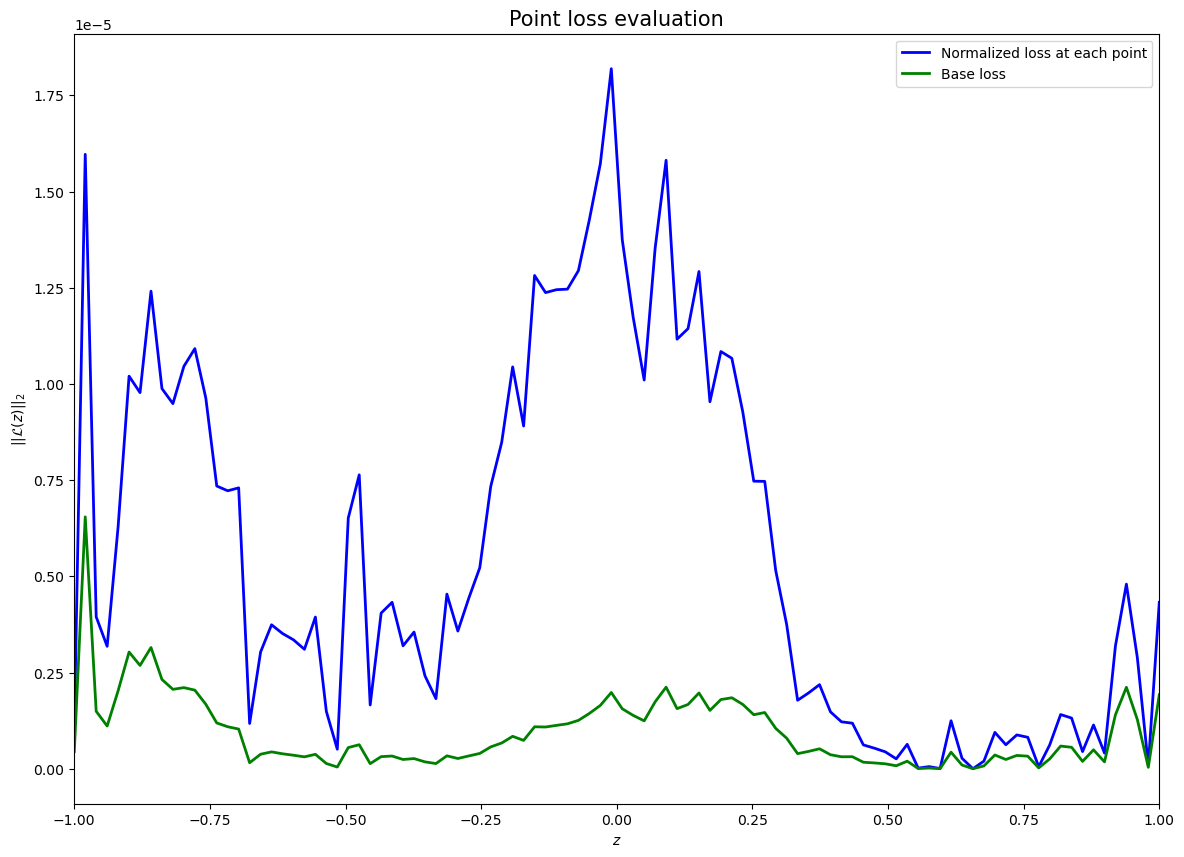

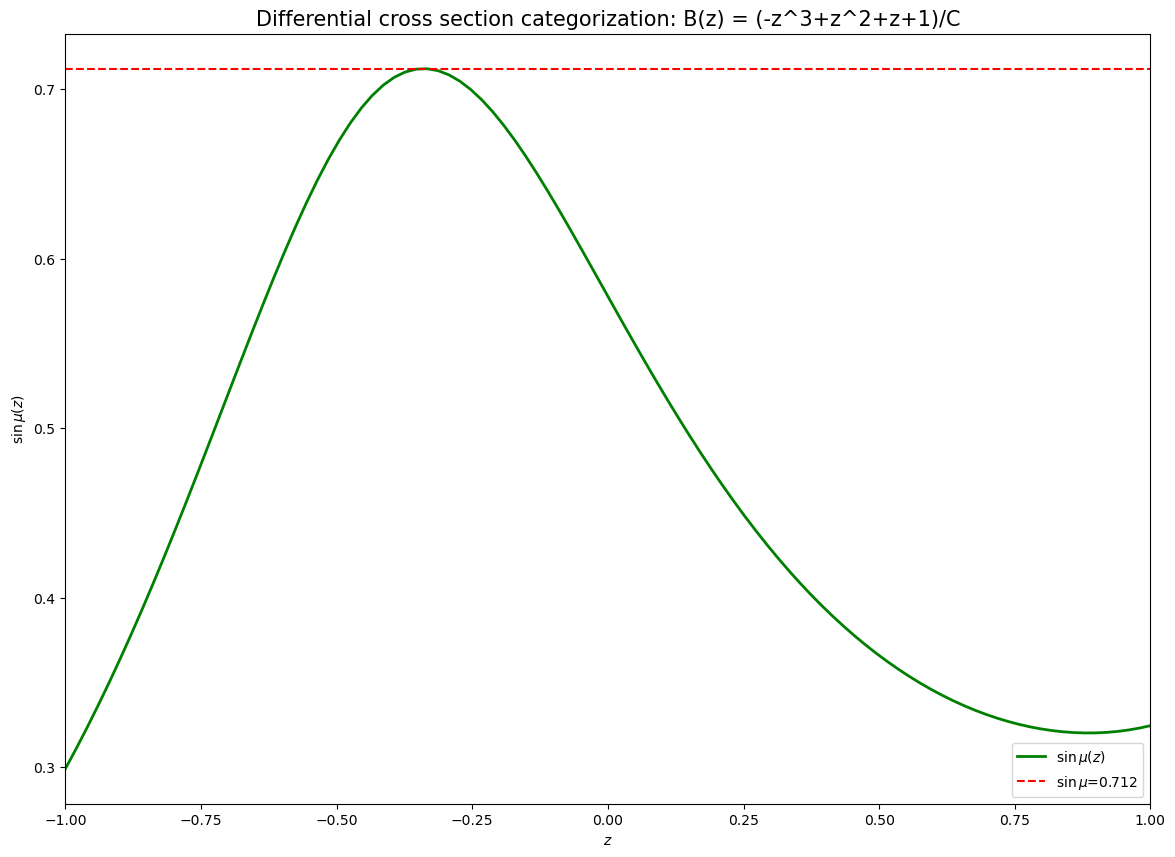

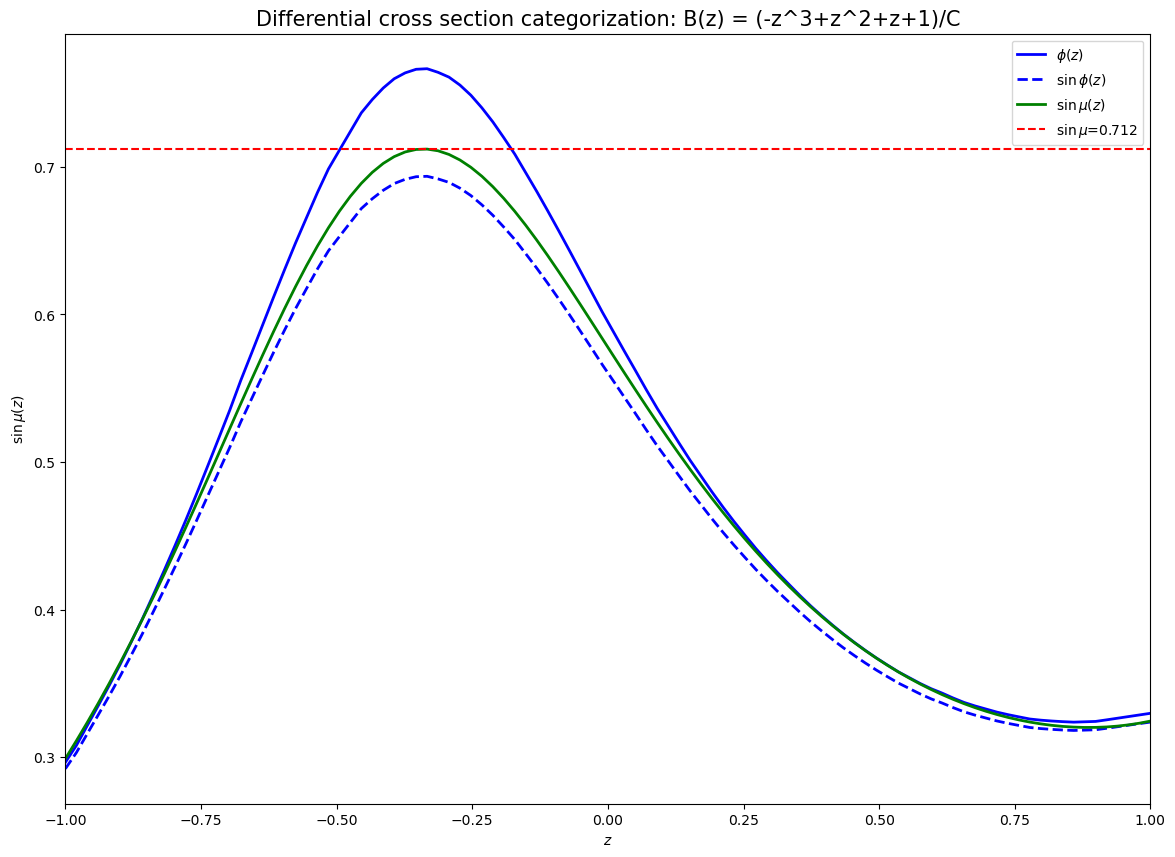

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 90 operations to synchronize with Neptune. Do not kill this process.
All 90 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-355


In [856]:
scan_range = np.linspace(1, 3, num=9)

for i, scan_param in enumerate(scan_range):

    run_scan = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_ConstScan18_{}".format(i))


    params_scan = {'batch_size': 64,
             'epochs_num': 2500,
             'learning_rate': 0.001,
             'lr_scheduler': False, 
             'beta1' : 0.85,
             'beta2' : 0.999,
             'integral_points': 25,
             'method_int': 'trapz',
             'activation': 'ReLU',
             'fund_dom': False,
             'layer_list': [64, 128, 128, 64],
             'final_layer': 'Sigmoid',
             'loss': 'Huber',
             'scaled_loss': True,
             'scan_param': scan_param,
             'num_nets' : 1,
             'p_value': None,
             'lambda_repulsive': None}
    

    tags_scan = {'constant function': '(-z^3+z^2+z+1)/C', 'optimizer': 'Adam', 'Mode': 'Scan param', 'Huber':'0.1'}
    run_scan["sys/tags"].add(list(tags_scan.values()))

    run_scan['parameters'] = params_scan
    
    netsolver = train_run(params_scan, device, run_scan)
    
    zpointseval, phieval, sinphieval, pt_loss_s, pt_loss_no_s = eval_run(netsolver, params_scan, device, run_scan)

    plot_phase(zpointseval, phieval, run_scan)
    plot_point_loss(zpointseval, pt_loss_s, pt_loss_no_s, run_scan)
    integralz = sin_mu_integral(params_scan, device, netsolver, zpointseval)
    plot_sin_mu(zpointseval, integralz, tags_scan)
    plot_summary(zpointseval, phieval, sinphieval, integralz, run_scan, tags_scan)
    
    # Make sure to kill the Neptune logger run
    run_scan.stop()

### Scan over linear functions

##### Assessing the existence

The idea here is to parametrize the differential cross section as $B(z)=az+b >0$ and map out the loss landscape. This will allow us to have a handle on the existence of a solution. We will tackle uniqueness later

Define the polynomial $B(z)$ network

In [231]:
class ModuleNetPolynomial(nn.Module):
    """
    Class for parametrizing the given differential cross section as a polynomial
    The input parameters correspond to the different weights of the polynomial
    """
    def __init__(self, polynomial_coeffs=None, device='cpu'):
        super(ModuleNetPolynomial, self).__init__()
        self.polynomial_coeffs = polynomial_coeffs
        self.device = device
        
    def forward(self, x):
        """
        Network forward pass is given by constructing the appropriate polynomial function
        """
        y = torch.zeros(x.size(), device=self.device)
        
        for i , coeff in enumerate(self.polynomial_coeffs):
            y = y + coeff * torch.pow(x, i)
        
        return y

##### Evaluation and plotting scripts

In [232]:
def eval_run_scans(trained_solver, params, device, neptune_run, steps_eval=100):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        
        # Also log the final loss values. Including the loss at individual z values
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_scaled'].log(eval_loss_scaled)
        
        eval_loss_base = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_base'].log(eval_loss_base)
        
        # Look at sim mu value
        sinmu = max((sin_mu_integral(params, device, trained_solver, zpointstest)).cpu())

    return sinmu, eval_loss_scaled, eval_loss_base

In [233]:
def plot_contour_loss_curves_linear(log_results, neptune_run, tags_scan, log_type='natural', logging=True):
    # Plot the log of the loss
    if log_type == 'base10':
        loss_scale = np.log10(log_results['loss_scale'])
        loss_no_scale = np.log10(log_results['loss_no_scale'])
    elif log_type == 'natural':
        loss_scale = np.log(log_results['loss_scale'])
        loss_no_scale = np.log(log_results['loss_no_scale'])
    else:
        raise NotImplemented
        
    sin_mu = log_results['sinmu']
    
    min_a = min(log_results['params'][:,0])
    max_a = max(log_results['params'][:,0])
    min_b = min(log_results['params'][:,1])
    max_b = max(log_results['params'][:,1])
    
    fig = plt.figure(figsize=(14, 10))

    plt.imshow(loss_scale, extent=[min_b,max_b,min_a,max_a], cmap='jet', vmax=-2, origin='lower')       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('Normalized loss lanscape of $B(z)={}$'.format(tags_scan['constant function']), fontsize = 15)
    plt.colorbar()
    plt.show()
    if logging:
        neptune_run[f'evaluation/contour_loss_scale'].upload(File.as_image(fig))
    plt.close(fig)
    
    fig2 = plt.figure(figsize=(14, 10))

    plt.imshow(loss_no_scale, extent=[min_b,max_b,min_a,max_a], cmap='jet', vmax=-2, origin='lower')       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('Base loss lanscape of $B(z)={}$'.format(tags_scan['constant function']), fontsize = 15)
    plt.colorbar()
    plt.show()
    if logging:
        neptune_run[f'evaluation/contour_loss_no_scale'].upload(File.as_image(fig2))
    plt.close(fig2)
    
        
    fig3 = plt.figure(figsize=(14, 10))

    plt.imshow(sin_mu, extent=[min_b,max_b,min_a,max_a], cmap='jet', vmax=1.5, origin='lower')       
    plt.xlabel('$b$ parameter')
    plt.ylabel('$a$ parameter')    
    plt.title('$\sin \mu$ value of $B(z)={}$'.format(tags_scan['constant function']), fontsize = 15)
    plt.colorbar()
    plt.show()
    if logging:
        neptune_run[f'evaluation/contour_sinmu'].upload(File.as_image(fig3))
    plt.close(fig3)

In [234]:
def plot_sinmu_losses(log_results, neptune_run, tags_scan, log_type='natural', logging=True):
    
    sin_mu = log_results['sinmu'].flatten()
    
    if log_type == 'base10':
        loss_scalef = np.log10(log_results['loss_scale']).flatten()
        loss_no_scalef = np.log10(log_results['loss_no_scale']).flatten()
        sin_muf = np.log10(log_results['sinmu'].flatten())
        add_str = '10'
    elif log_type == 'natural':
        loss_scalef = np.log(log_results['loss_scale']).flatten()
        loss_no_scalef = np.log(log_results['loss_no_scale']).flatten()
        sin_muf = np.log(log_results['sinmu'].flatten())
        add_str = ''
    else:
        raise NotImplemented

    fig = plt.figure(figsize=(14, 10))

    plt.scatter(sin_muf, loss_scalef, c='b')       
    plt.xlabel('$\log_{{{}}}(\sin \mu)$ parameter'.format(add_str))
    plt.ylabel('Log{} loss'.format(add_str))    
    plt.title('Normalized loss lanscape of $B(z)={}$'.format(tags_scan['constant function']), fontsize = 15)
    plt.show()
    if logging:
        neptune_run[f'evaluation/sinmu_loss_scale'].upload(File.as_image(fig))
    plt.close(fig)
    
    fig2 = plt.figure(figsize=(14, 10))

    plt.scatter(sin_muf, loss_no_scalef, c='g')       
    plt.xlabel('$\log_{{{}}}(\sin \mu)$ parameter'.format(add_str))
    plt.ylabel('Log{} loss'.format(add_str))    
    plt.title('Base loss lanscape of $B(z)={}$'.format(tags_scan['constant function']), fontsize = 15)
    plt.show()
    if logging:
        neptune_run[f'evaluation/sinmu_loss_no_scale'].upload(File.as_image(fig2))
    plt.close(fig2)
    
    
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.scatter(sin_mu, loss_scalef, c='b')       
    plt.xlabel('$\sin \mu$ parameter')
    plt.ylabel('Log{} loss'.format(add_str))    
    plt.xlim([0,3])
    plt.title('Normalized loss lanscape of $B(z)={}$'.format(tags_scan['constant function']), fontsize = 15)
    plt.show()
    if logging:
        neptune_run[f'evaluation/sinmu_loss_scale_r'].upload(File.as_image(fig3))
    plt.close(fig3)
    
    fig4 = plt.figure(figsize=(14, 10))

    plt.scatter(sin_mu, loss_no_scalef, c='g')       
    plt.xlabel('$\sin \mu$ parameter')
    plt.ylabel('Log{} loss'.format(add_str))    
    plt.xlim([0,3])
    plt.title('Base loss lanscape of $B(z)={}$'.format(tags_scan['constant function']), fontsize = 15)
    plt.show()
    if logging:
        neptune_run[f'evaluation/sinmu_loss_no_scale_r'].upload(File.as_image(fig4))
    plt.close(fig4)
    

##### Main scanning loop over $B(z) = az+b$

In [861]:
num_a = 30
num_b = 30

scan_range_a = np.linspace(-0.5, 0.5, num=num_a)
scan_range_b = np.linspace(0, 1.25, num=num_b)
param_grid = np.dstack(np.meshgrid(scan_range_a, scan_range_b)).reshape(-1, 2)



run_scan = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_LinScan3_{}".format(i))

log_res = {'params':param_grid, 'sinmu':np.empty([num_a, num_b]), 'loss_scale':np.empty([num_a, num_b]), 'loss_no_scale':np.empty([num_a, num_b])}

for i, params_lin in enumerate(param_grid):
    
    a_index = i % num_a
    b_index = int((i - i % num_a)/num_a)
    
    # Ensure that the differential cross section is positive for all z values
    if params_lin[1] > abs(params_lin[0]):
        print('Starting the simulation with a={} and b={}'.format(params_lin[0],params_lin[1]))

        params_scan = {'batch_size': 64,
                 'epochs_num': 300,
                 'learning_rate': 0.001,
                 'lr_scheduler': False, 
                 'beta1' : 0.85,
                 'beta2' : 0.999,
                 'integral_points': 25,
                 'method_int': 'trapz',
                 'activation': 'ReLU',
                 'fund_dom': False,
                 'layer_list': [64, 128, 128, 64],
                 'final_layer': 'Sigmoid',
                 'loss': 'Huber',
                 'scaled_loss': True,
                 'scan_param': None,
                 'num_nets' : 1,
                 'p_value': None,
                 'lambda_repulsive': None}

        tags_scan = {'constant function': 'az+b', 'optimizer': 'Adam', 'Mode': 'Scan param linear'}
        run_scan["sys/tags"].add(list(tags_scan.values()))

        run_scan['parameters'] = params_scan
        
        
        modnet = ModuleNetPolynomial(polynomial_coeffs=np.flip(params_lin), device=device)
        netsolver = train_run(params_scan, device, run_scan, module_net=modnet)

        sinmu, loss_scale, loss_no_scale = eval_run_scans(netsolver, params_scan, device, run_scan)
        log_res['sinmu'][a_index, b_index] = sinmu.cpu().numpy()
        log_res['loss_scale'][a_index, b_index] = loss_scale.cpu().numpy()
        log_res['loss_no_scale'][a_index, b_index] = loss_no_scale.cpu().numpy()
    else:
        log_res['sinmu'][a_index, b_index] = np.nan
        log_res['loss_scale'][a_index, b_index] = np.nan
        log_res['loss_no_scale'][a_index, b_index] = np.nan

https://app.neptune.ai/zulap/2to2scattering/e/TOS-356
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Starting the simulation with a=-0.017241379310344862 and b=0.04310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.077629
Train Epoch: 15 ; tLoss: 0.046971
Train Epoch: 30 ; tLoss: 0.042307
Train Epoch: 45 ; tLoss: 0.005917


Train Epoch: 15 ; tLoss: 0.041700
Train Epoch: 30 ; tLoss: 0.010892
Train Epoch: 45 ; tLoss: 0.002094
Train Epoch: 60 ; tLoss: 0.018238
Train Epoch: 75 ; tLoss: 0.001591
Train Epoch: 90 ; tLoss: 0.031241
Train Epoch: 105 ; tLoss: 0.005482
Train Epoch: 120 ; tLoss: 0.008680
Train Epoch: 135 ; tLoss: 0.002975
Train Epoch: 150 ; tLoss: 0.306188
Train Epoch: 165 ; tLoss: 0.011920
Train Epoch: 180 ; tLoss: 0.002915
Train Epoch: 195 ; tLoss: 0.020807
Train Epoch: 210 ; tLoss: 0.231646
Train Epoch: 225 ; tLoss: 0.000319
Train Epoch: 240 ; tLoss: 0.042783
Train Epoch: 255 ; tLoss: 0.023337
Train Epoch: 270 ; tLoss: 0.005086
Train Epoch: 285 ; tLoss: 0.010227
Starting the simulation with a=-0.12068965517241381 and b=0.12931034482758622
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(i

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/eval_loss_scaled


Train Epoch: 75 ; tLoss: 0.005095
Train Epoch: 90 ; tLoss: 0.007137
Train Epoch: 105 ; tLoss: 0.004864
Train Epoch: 120 ; tLoss: 0.002121
Train Epoch: 135 ; tLoss: 0.004516
Train Epoch: 150 ; tLoss: 0.003163
Train Epoch: 165 ; tLoss: 0.001513
Train Epoch: 180 ; tLoss: 0.001152
Train Epoch: 195 ; tLoss: 0.001693
Train Epoch: 210 ; tLoss: 0.003869
Train Epoch: 225 ; tLoss: 0.005434
Train Epoch: 240 ; tLoss: 0.001886
Train Epoch: 255 ; tLoss: 0.003117
Train Epoch: 270 ; tLoss: 0.003837
Train Epoch: 285 ; tLoss: 0.005235
Starting the simulation with a=-0.08620689655172414 and b=0.12931034482758622
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=Tru

Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.12068965517241381 and b=0.12931034482758622
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.054300
Train Epoch: 15 ; tLoss: 0.006068
Train Epoch: 30 ; tLoss: 0.002068
Train Epoch: 45 ; tLoss: 0.000534
Train Epoch: 60 ; tLoss: 0.002934
Train Epoch: 75 ; tLoss: 0.000546
Train Epoch: 90 ; tLoss: 0.003905
Train Epoch: 105 ; tLoss: 0.000847
Train Epoch: 120 ; tLoss: 0.001314
Train Epoch: 135 ; tL

Train Epoch: 15 ; tLoss: 0.000312
Train Epoch: 30 ; tLoss: 0.000029
Train Epoch: 45 ; tLoss: 0.000008
Train Epoch: 60 ; tLoss: 0.000002
Train Epoch: 75 ; tLoss: 0.000001
Train Epoch: 90 ; tLoss: 0.000000
Train Epoch: 105 ; tLoss: 0.000000
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.051724137931034475 and b=0.1724137931034483
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000036
Train Epoch: 225 ; tLoss: 0.000047
Train Epoch: 240 ; tLoss: 0.000015
Train Epoch: 255 ; tLoss: 0.000012
Train Epoch: 270 ; tLoss: 0.000046
Train Epoch: 285 ; tLoss: 0.000056
Starting the simulation with a=-0.12068965517241381 and b=0.21551724137931036
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.031377
Train Epoch: 15 ; tLoss: 0.001483
Train Epoch: 30 ; tLoss: 0.000147
Train Epoch: 45 ; tLoss: 0.000075
Train Epoch: 60 ; tLoss: 0.000042
Train Epoch: 75 ; 

Train Epoch: 15 ; tLoss: 0.000171
Train Epoch: 30 ; tLoss: 0.000034
Train Epoch: 45 ; tLoss: 0.000003
Train Epoch: 60 ; tLoss: 0.000004
Train Epoch: 75 ; tLoss: 0.000001
Train Epoch: 90 ; tLoss: 0.000002
Train Epoch: 105 ; tLoss: 0.000000
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.21551724137931036
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000022
Train Epoch: 225 ; tLoss: 0.000007
Train Epoch: 240 ; tLoss: 0.000087
Train Epoch: 255 ; tLoss: 0.000056
Train Epoch: 270 ; tLoss: 0.000008
Train Epoch: 285 ; tLoss: 0.000008
Starting the simulation with a=-0.12068965517241381 and b=0.25862068965517243
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.026256
Train Epoch: 15 ; tLoss: 0.001368
Train Epoch: 30 ; tLoss: 0.000125
Train Epoch: 45 ; tLoss: 0.000021
Train Epoch: 60 ; tLoss: 0.000007
Train Epoch: 75 ; 

Train Epoch: 15 ; tLoss: 0.000277
Train Epoch: 30 ; tLoss: 0.000050
Train Epoch: 45 ; tLoss: 0.000017
Train Epoch: 60 ; tLoss: 0.000001
Train Epoch: 75 ; tLoss: 0.000001
Train Epoch: 90 ; tLoss: 0.000001
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000002
Train Epoch: 210 ; tLoss: 0.000003
Train Epoch: 225 ; tLoss: 0.000076
Train Epoch: 240 ; tLoss: 0.000005
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.25862068965517243
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/eval_loss_scaled


Train Epoch: 75 ; tLoss: 0.050490
Train Epoch: 90 ; tLoss: 0.061196
Train Epoch: 105 ; tLoss: 0.045002
Train Epoch: 120 ; tLoss: 0.032334
Train Epoch: 135 ; tLoss: 0.044264
Train Epoch: 150 ; tLoss: 0.041898
Train Epoch: 165 ; tLoss: 0.022724
Train Epoch: 180 ; tLoss: 0.019537
Train Epoch: 195 ; tLoss: 0.018147
Train Epoch: 210 ; tLoss: 0.048964
Train Epoch: 225 ; tLoss: 0.049136
Train Epoch: 240 ; tLoss: 0.026567
Train Epoch: 255 ; tLoss: 0.033491
Train Epoch: 270 ; tLoss: 0.046437
Train Epoch: 285 ; tLoss: 0.048768
Starting the simulation with a=-0.25862068965517243 and b=0.3017241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True

Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.051724137931034475 and b=0.3017241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.010357
Train Epoch: 15 ; tLoss: 0.000041
Train Epoch: 30 ; tLoss: 0.000004
Train Epoch: 45 ; tLoss: 0.000003
Train Epoch: 60 ; tLoss: 0.000001
Train Epoch: 75 ; tLoss: 0.000000
Train Epoch: 90 ; tLoss: 0.000000
Train Epoch: 105 ; tLoss: 0.000000
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; t

Train Epoch: 15 ; tLoss: 0.000551
Train Epoch: 30 ; tLoss: 0.000038
Train Epoch: 45 ; tLoss: 0.000012
Train Epoch: 60 ; tLoss: 0.000012
Train Epoch: 75 ; tLoss: 0.000001
Train Epoch: 90 ; tLoss: 0.000004
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000006
Train Epoch: 165 ; tLoss: 0.000024
Train Epoch: 180 ; tLoss: 0.000002
Train Epoch: 195 ; tLoss: 0.000070
Train Epoch: 210 ; tLoss: 0.000078
Train Epoch: 225 ; tLoss: 0.000013
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000002
Train Epoch: 285 ; tLoss: 0.000010
Starting the simulation with a=0.18965517241379315 and b=0.3017241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.014222
Train Epoch: 225 ; tLoss: 0.009854
Train Epoch: 240 ; tLoss: 0.008274
Train Epoch: 255 ; tLoss: 0.009092
Train Epoch: 270 ; tLoss: 0.011160
Train Epoch: 285 ; tLoss: 0.009476
Starting the simulation with a=-0.25862068965517243 and b=0.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.095208
Train Epoch: 15 ; tLoss: 0.008083
Train Epoch: 30 ; tLoss: 0.004580
Train Epoch: 45 ; tLoss: 0.002133
Train Epoch: 60 ; tLoss: 0.003007
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.000073
Train Epoch: 30 ; tLoss: 0.000004
Train Epoch: 45 ; tLoss: 0.000004
Train Epoch: 60 ; tLoss: 0.000000
Train Epoch: 75 ; tLoss: 0.000000
Train Epoch: 90 ; tLoss: 0.000000
Train Epoch: 105 ; tLoss: 0.000000
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.017241379310344862 and b=0.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(i

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.18965517241379315 and b=0.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.027881
Train Epoch: 15 ; tLoss: 0.001512
Train Epoch: 30 ; tLoss: 0.000221
Train Epoch: 45 ; tLoss: 0.000047
Train Epoch: 60 ; tLoss: 0.000036
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.016169
Train Epoch: 30 ; tLoss: 0.014072
Train Epoch: 45 ; tLoss: 0.008005
Train Epoch: 60 ; tLoss: 0.011845
Train Epoch: 75 ; tLoss: 0.019159
Train Epoch: 90 ; tLoss: 0.017923
Train Epoch: 105 ; tLoss: 0.012875
Train Epoch: 120 ; tLoss: 0.012924
Train Epoch: 135 ; tLoss: 0.010507
Train Epoch: 150 ; tLoss: 0.015248
Train Epoch: 165 ; tLoss: 0.009021
Train Epoch: 180 ; tLoss: 0.007882
Train Epoch: 195 ; tLoss: 0.005453
Train Epoch: 210 ; tLoss: 0.017412
Train Epoch: 225 ; tLoss: 0.011882
Train Epoch: 240 ; tLoss: 0.010675
Train Epoch: 255 ; tLoss: 0.011506
Train Epoch: 270 ; tLoss: 0.013974
Train Epoch: 285 ; tLoss: 0.011549
Starting the simulation with a=-0.2931034482758621 and b=0.3879310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.08620689655172414 and b=0.3879310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.041355
Train Epoch: 15 ; tLoss: 0.000436
Train Epoch: 30 ; tLoss: 0.000093
Train Epoch: 45 ; tLoss: 0.000011
Train Epoch: 60 ; tLoss: 0.000002
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.000957
Train Epoch: 30 ; tLoss: 0.000201
Train Epoch: 45 ; tLoss: 0.000015
Train Epoch: 60 ; tLoss: 0.000010
Train Epoch: 75 ; tLoss: 0.000003
Train Epoch: 90 ; tLoss: 0.000002
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.15517241379310343 and b=0.3879310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.001612
Train Epoch: 225 ; tLoss: 0.000333
Train Epoch: 240 ; tLoss: 0.001693
Train Epoch: 255 ; tLoss: 0.001421
Train Epoch: 270 ; tLoss: 0.001359
Train Epoch: 285 ; tLoss: 0.001862
Starting the simulation with a=0.3620689655172413 and b=0.3879310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.092764
Train Epoch: 15 ; tLoss: 0.024637
Train Epoch: 30 ; tLoss: 0.011549
Train Epoch: 45 ; tLoss: 0.004955
Train Epoch: 60 ; tLoss: 0.011748
Train Epoch: 75 ; tLo

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/eval_loss_scaled


Train Epoch: 60 ; tLoss: 0.030452
Train Epoch: 75 ; tLoss: 0.047901
Train Epoch: 90 ; tLoss: 0.047389
Train Epoch: 105 ; tLoss: 0.034752
Train Epoch: 120 ; tLoss: 0.032147
Train Epoch: 135 ; tLoss: 0.029789
Train Epoch: 150 ; tLoss: 0.038650
Train Epoch: 165 ; tLoss: 0.023830
Train Epoch: 180 ; tLoss: 0.021797
Train Epoch: 195 ; tLoss: 0.014909
Train Epoch: 210 ; tLoss: 0.043376
Train Epoch: 225 ; tLoss: 0.033292
Train Epoch: 240 ; tLoss: 0.026417
Train Epoch: 255 ; tLoss: 0.029257
Train Epoch: 270 ; tLoss: 0.036326
Train Epoch: 285 ; tLoss: 0.031786
Starting the simulation with a=-0.3620689655172414 and b=0.4310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_feature

Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.15517241379310343 and b=0.4310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.065603
Train Epoch: 15 ; tLoss: 0.002055
Train Epoch: 30 ; tLoss: 0.000295
Train Epoch: 45 ; tLoss: 0.000028
Train Epoch: 60 ; tLoss: 0.000018
Train Epoch: 75 ; tLoss: 0.000012
Train Epoch: 90 ; tLoss: 0.000009
Train Epoch: 105 ; tLoss: 0.000004
Train Epoch: 120 ; tL

Train Epoch: 15 ; tLoss: 0.002192
Train Epoch: 30 ; tLoss: 0.000037
Train Epoch: 45 ; tLoss: 0.000014
Train Epoch: 60 ; tLoss: 0.000004
Train Epoch: 75 ; tLoss: 0.000002
Train Epoch: 90 ; tLoss: 0.000002
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.08620689655172409 and b=0.4310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000005
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000002
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.2931034482758621 and b=0.4310344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.065520
Train Epoch: 15 ; tLoss: 0.012262
Train Epoch: 30 ; tLoss: 0.002625
Train Epoch: 45 ; tLoss: 0.000665
Train Epoch: 60 ; tLoss: 0.000611
Train Epoch: 75 ; tLo

Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute metrics/eval_loss_scaled


Train Epoch: 30 ; tLoss: 0.122386
Train Epoch: 45 ; tLoss: 0.045058
Train Epoch: 60 ; tLoss: 0.089332
Train Epoch: 75 ; tLoss: 0.110538
Train Epoch: 90 ; tLoss: 0.137271
Train Epoch: 105 ; tLoss: 0.103741
Train Epoch: 120 ; tLoss: 0.071482
Train Epoch: 135 ; tLoss: 0.111396
Train Epoch: 150 ; tLoss: 0.093520
Train Epoch: 165 ; tLoss: 0.053270
Train Epoch: 180 ; tLoss: 0.049910
Train Epoch: 195 ; tLoss: 0.044128
Train Epoch: 210 ; tLoss: 0.105458
Train Epoch: 225 ; tLoss: 0.117924
Train Epoch: 240 ; tLoss: 0.059098
Train Epoch: 255 ; tLoss: 0.075317
Train Epoch: 270 ; tLoss: 0.111566
Train Epoch: 285 ; tLoss: 0.118081
Starting the simulation with a=-0.43103448275862066 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, 

Train Epoch: 225 ; tLoss: 0.000386
Train Epoch: 240 ; tLoss: 0.000115
Train Epoch: 255 ; tLoss: 0.000199
Train Epoch: 270 ; tLoss: 0.000250
Train Epoch: 285 ; tLoss: 0.000375
Starting the simulation with a=-0.22413793103448276 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.093658
Train Epoch: 15 ; tLoss: 0.005910
Train Epoch: 30 ; tLoss: 0.001059
Train Epoch: 45 ; tLoss: 0.000371
Train Epoch: 60 ; tLoss: 0.000192
Train Epoch: 75 ; tLoss: 0.000138
Train Epoch: 90 ; t

Train Epoch: 15 ; tLoss: 0.002232
Train Epoch: 30 ; tLoss: 0.000255
Train Epoch: 45 ; tLoss: 0.000016
Train Epoch: 60 ; tLoss: 0.000001
Train Epoch: 75 ; tLoss: 0.000000
Train Epoch: 90 ; tLoss: 0.000000
Train Epoch: 105 ; tLoss: 0.000000
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.017241379310344862 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(i

Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.22413793103448276 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.071357
Train Epoch: 15 ; tLoss: 0.006773
Train Epoch: 30 ; tLoss: 0.000697
Train Epoch: 45 ; tLoss: 0.000120
Train Epoch: 60 ; tLoss: 0.000061
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.035574
Train Epoch: 30 ; tLoss: 0.013659
Train Epoch: 45 ; tLoss: 0.006722
Train Epoch: 60 ; tLoss: 0.011908
Train Epoch: 75 ; tLoss: 0.004735
Train Epoch: 90 ; tLoss: 0.016289
Train Epoch: 105 ; tLoss: 0.007062
Train Epoch: 120 ; tLoss: 0.012619
Train Epoch: 135 ; tLoss: 0.009644
Train Epoch: 150 ; tLoss: 0.012402
Train Epoch: 165 ; tLoss: 0.013940
Train Epoch: 180 ; tLoss: 0.005180
Train Epoch: 195 ; tLoss: 0.012779
Train Epoch: 210 ; tLoss: 0.006790
Train Epoch: 225 ; tLoss: 0.003231
Train Epoch: 240 ; tLoss: 0.009445
Train Epoch: 255 ; tLoss: 0.006103
Train Epoch: 270 ; tLoss: 0.008381
Train Epoch: 285 ; tLoss: 0.007899
Starting the simulation with a=0.4655172413793103 and b=0.47413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.009900
Train Epoch: 225 ; tLoss: 0.006372
Train Epoch: 240 ; tLoss: 0.006384
Train Epoch: 255 ; tLoss: 0.006710
Train Epoch: 270 ; tLoss: 0.008005
Train Epoch: 285 ; tLoss: 0.006203
Starting the simulation with a=-0.3275862068965517 and b=0.5172413793103449
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.139444
Train Epoch: 15 ; tLoss: 0.022945
Train Epoch: 30 ; tLoss: 0.006538
Train Epoch: 45 ; tLoss: 0.003022
Train Epoch: 60 ; tLoss: 0.003638
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.001756
Train Epoch: 30 ; tLoss: 0.000492
Train Epoch: 45 ; tLoss: 0.000023
Train Epoch: 60 ; tLoss: 0.000010
Train Epoch: 75 ; tLoss: 0.000006
Train Epoch: 90 ; tLoss: 0.000004
Train Epoch: 105 ; tLoss: 0.000002
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.08620689655172414 and b=0.5172413793103449
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.5172413793103449
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.081674
Train Epoch: 15 ; tLoss: 0.002139
Train Epoch: 30 ; tLoss: 0.000186
Train Epoch: 45 ; tLoss: 0.000049
Train Epoch: 60 ; tLoss: 0.000008
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.018343
Train Epoch: 30 ; tLoss: 0.003963
Train Epoch: 45 ; tLoss: 0.001089
Train Epoch: 60 ; tLoss: 0.000803
Train Epoch: 75 ; tLoss: 0.000148
Train Epoch: 90 ; tLoss: 0.000533
Train Epoch: 105 ; tLoss: 0.000101
Train Epoch: 120 ; tLoss: 0.000181
Train Epoch: 135 ; tLoss: 0.000089
Train Epoch: 150 ; tLoss: 0.000214
Train Epoch: 165 ; tLoss: 0.000153
Train Epoch: 180 ; tLoss: 0.000048
Train Epoch: 195 ; tLoss: 0.000155
Train Epoch: 210 ; tLoss: 0.000088
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000056
Train Epoch: 255 ; tLoss: 0.000040
Train Epoch: 270 ; tLoss: 0.000021
Train Epoch: 285 ; tLoss: 0.000044
Starting the simulation with a=0.3620689655172413 and b=0.5172413793103449
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.038238
Train Epoch: 240 ; tLoss: 0.033061
Train Epoch: 255 ; tLoss: 0.035062
Train Epoch: 270 ; tLoss: 0.042533
Train Epoch: 285 ; tLoss: 0.035613
Starting the simulation with a=-0.46551724137931033 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.237474
Train Epoch: 15 ; tLoss: 0.043225
Train Epoch: 30 ; tLoss: 0.029069
Train Epoch: 45 ; tLoss: 0.018491
Train Epoch: 60 ; tLoss: 0.021833
Train Epoch: 75 ; tLoss: 0.037030
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.014588
Train Epoch: 30 ; tLoss: 0.002183
Train Epoch: 45 ; tLoss: 0.000605
Train Epoch: 60 ; tLoss: 0.000569
Train Epoch: 75 ; tLoss: 0.000503
Train Epoch: 90 ; tLoss: 0.000500
Train Epoch: 105 ; tLoss: 0.000288
Train Epoch: 120 ; tLoss: 0.000142
Train Epoch: 135 ; tLoss: 0.000220
Train Epoch: 150 ; tLoss: 0.000173
Train Epoch: 165 ; tLoss: 0.000081
Train Epoch: 180 ; tLoss: 0.000058
Train Epoch: 195 ; tLoss: 0.000082
Train Epoch: 210 ; tLoss: 0.000189
Train Epoch: 225 ; tLoss: 0.000257
Train Epoch: 240 ; tLoss: 0.000080
Train Epoch: 255 ; tLoss: 0.000133
Train Epoch: 270 ; tLoss: 0.000171
Train Epoch: 285 ; tLoss: 0.000248
Starting the simulation with a=-0.22413793103448276 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.017241379310344862 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.098773
Train Epoch: 15 ; tLoss: 0.000347
Train Epoch: 30 ; tLoss: 0.000217
Train Epoch: 45 ; tLoss: 0.000019
Train Epoch: 60 ; tLoss: 0.000007
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.009653
Train Epoch: 30 ; tLoss: 0.001020
Train Epoch: 45 ; tLoss: 0.000063
Train Epoch: 60 ; tLoss: 0.000043
Train Epoch: 75 ; tLoss: 0.000010
Train Epoch: 90 ; tLoss: 0.000007
Train Epoch: 105 ; tLoss: 0.000002
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000001
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.22413793103448276 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000947
Train Epoch: 225 ; tLoss: 0.000256
Train Epoch: 240 ; tLoss: 0.001081
Train Epoch: 255 ; tLoss: 0.000912
Train Epoch: 270 ; tLoss: 0.000974
Train Epoch: 285 ; tLoss: 0.001189
Starting the simulation with a=0.43103448275862066 and b=0.560344827586207
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.126965
Train Epoch: 15 ; tLoss: 0.025337
Train Epoch: 30 ; tLoss: 0.008204
Train Epoch: 45 ; tLoss: 0.003458
Train Epoch: 60 ; tLoss: 0.004131
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.029045
Train Epoch: 30 ; tLoss: 0.014933
Train Epoch: 45 ; tLoss: 0.007494
Train Epoch: 60 ; tLoss: 0.007782
Train Epoch: 75 ; tLoss: 0.013159
Train Epoch: 90 ; tLoss: 0.011395
Train Epoch: 105 ; tLoss: 0.008481
Train Epoch: 120 ; tLoss: 0.009044
Train Epoch: 135 ; tLoss: 0.006938
Train Epoch: 150 ; tLoss: 0.010540
Train Epoch: 165 ; tLoss: 0.006811
Train Epoch: 180 ; tLoss: 0.006405
Train Epoch: 195 ; tLoss: 0.003947
Train Epoch: 210 ; tLoss: 0.011173
Train Epoch: 225 ; tLoss: 0.007380
Train Epoch: 240 ; tLoss: 0.007449
Train Epoch: 255 ; tLoss: 0.007769
Train Epoch: 270 ; tLoss: 0.009274
Train Epoch: 285 ; tLoss: 0.007036
Starting the simulation with a=-0.3620689655172414 and b=0.603448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=-0.15517241379310343 and b=0.603448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.125001
Train Epoch: 15 ; tLoss: 0.006727
Train Epoch: 30 ; tLoss: 0.000219
Train Epoch: 45 ; tLoss: 0.000091
Train Epoch: 60 ; tLoss: 0.000027
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.004694
Train Epoch: 30 ; tLoss: 0.000679
Train Epoch: 45 ; tLoss: 0.000065
Train Epoch: 60 ; tLoss: 0.000005
Train Epoch: 75 ; tLoss: 0.000001
Train Epoch: 90 ; tLoss: 0.000001
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.08620689655172409 and b=0.603448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.2931034482758621 and b=0.603448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.120064
Train Epoch: 15 ; tLoss: 0.015791
Train Epoch: 30 ; tLoss: 0.001128
Train Epoch: 45 ; tLoss: 0.000590
Train Epoch: 60 ; tLoss: 0.000277
Train Epoch: 75 ; tLos

Train Epoch: 15 ; tLoss: 0.030136
Train Epoch: 30 ; tLoss: 0.013449
Train Epoch: 45 ; tLoss: 0.005920
Train Epoch: 60 ; tLoss: 0.008391
Train Epoch: 75 ; tLoss: 0.003638
Train Epoch: 90 ; tLoss: 0.010683
Train Epoch: 105 ; tLoss: 0.005187
Train Epoch: 120 ; tLoss: 0.008723
Train Epoch: 135 ; tLoss: 0.007107
Train Epoch: 150 ; tLoss: 0.008075
Train Epoch: 165 ; tLoss: 0.010070
Train Epoch: 180 ; tLoss: 0.003860
Train Epoch: 195 ; tLoss: 0.008938
Train Epoch: 210 ; tLoss: 0.004965
Train Epoch: 225 ; tLoss: 0.003033
Train Epoch: 240 ; tLoss: 0.007246
Train Epoch: 255 ; tLoss: 0.004250
Train Epoch: 270 ; tLoss: 0.006640
Train Epoch: 285 ; tLoss: 0.005929
Starting the simulation with a=-0.5 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, ou

Train Epoch: 225 ; tLoss: 0.002429
Train Epoch: 240 ; tLoss: 0.002426
Train Epoch: 255 ; tLoss: 0.002551
Train Epoch: 270 ; tLoss: 0.003058
Train Epoch: 285 ; tLoss: 0.002343
Starting the simulation with a=-0.2931034482758621 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.162870
Train Epoch: 15 ; tLoss: 0.017706
Train Epoch: 30 ; tLoss: 0.003580
Train Epoch: 45 ; tLoss: 0.001582
Train Epoch: 60 ; tLoss: 0.001572
Train Epoch: 75 ; tLoss: 0.002186
Train Epoch: 90 ; tLos

Train Epoch: 15 ; tLoss: 0.006536
Train Epoch: 30 ; tLoss: 0.000713
Train Epoch: 45 ; tLoss: 0.000073
Train Epoch: 60 ; tLoss: 0.000008
Train Epoch: 75 ; tLoss: 0.000002
Train Epoch: 90 ; tLoss: 0.000001
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.051724137931034475 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.15517241379310343 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.128428
Train Epoch: 15 ; tLoss: 0.011227
Train Epoch: 30 ; tLoss: 0.000384
Train Epoch: 45 ; tLoss: 0.000103
Train Epoch: 60 ; tLoss: 0.000025
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.018323
Train Epoch: 30 ; tLoss: 0.005457
Train Epoch: 45 ; tLoss: 0.001257
Train Epoch: 60 ; tLoss: 0.001025
Train Epoch: 75 ; tLoss: 0.000359
Train Epoch: 90 ; tLoss: 0.000826
Train Epoch: 105 ; tLoss: 0.000243
Train Epoch: 120 ; tLoss: 0.000459
Train Epoch: 135 ; tLoss: 0.000281
Train Epoch: 150 ; tLoss: 0.000442
Train Epoch: 165 ; tLoss: 0.000428
Train Epoch: 180 ; tLoss: 0.000167
Train Epoch: 195 ; tLoss: 0.000393
Train Epoch: 210 ; tLoss: 0.000227
Train Epoch: 225 ; tLoss: 0.000037
Train Epoch: 240 ; tLoss: 0.000215
Train Epoch: 255 ; tLoss: 0.000187
Train Epoch: 270 ; tLoss: 0.000149
Train Epoch: 285 ; tLoss: 0.000237
Starting the simulation with a=0.39655172413793105 and b=0.646551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.012857
Train Epoch: 240 ; tLoss: 0.012667
Train Epoch: 255 ; tLoss: 0.012961
Train Epoch: 270 ; tLoss: 0.015366
Train Epoch: 285 ; tLoss: 0.011755
Starting the simulation with a=-0.43103448275862066 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.218121
Train Epoch: 15 ; tLoss: 0.027750
Train Epoch: 30 ; tLoss: 0.022535
Train Epoch: 45 ; tLoss: 0.009754
Train Epoch: 60 ; tLoss: 0.009285
Train Epoch: 75 ; tLoss: 0.015974
Train Epoch: 90 ; tL

Train Epoch: 15 ; tLoss: 0.014354
Train Epoch: 30 ; tLoss: 0.002657
Train Epoch: 45 ; tLoss: 0.000528
Train Epoch: 60 ; tLoss: 0.000340
Train Epoch: 75 ; tLoss: 0.000328
Train Epoch: 90 ; tLoss: 0.000249
Train Epoch: 105 ; tLoss: 0.000138
Train Epoch: 120 ; tLoss: 0.000080
Train Epoch: 135 ; tLoss: 0.000083
Train Epoch: 150 ; tLoss: 0.000068
Train Epoch: 165 ; tLoss: 0.000034
Train Epoch: 180 ; tLoss: 0.000022
Train Epoch: 195 ; tLoss: 0.000027
Train Epoch: 210 ; tLoss: 0.000066
Train Epoch: 225 ; tLoss: 0.000075
Train Epoch: 240 ; tLoss: 0.000028
Train Epoch: 255 ; tLoss: 0.000040
Train Epoch: 270 ; tLoss: 0.000050
Train Epoch: 285 ; tLoss: 0.000067
Starting the simulation with a=-0.1896551724137931 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.017241379310344862 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.144451
Train Epoch: 15 ; tLoss: 0.008293
Train Epoch: 30 ; tLoss: 0.000675
Train Epoch: 45 ; tLoss: 0.000073
Train Epoch: 60 ; tLoss: 0.000023
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.012862
Train Epoch: 30 ; tLoss: 0.001958
Train Epoch: 45 ; tLoss: 0.000123
Train Epoch: 60 ; tLoss: 0.000109
Train Epoch: 75 ; tLoss: 0.000045
Train Epoch: 90 ; tLoss: 0.000057
Train Epoch: 105 ; tLoss: 0.000015
Train Epoch: 120 ; tLoss: 0.000011
Train Epoch: 135 ; tLoss: 0.000005
Train Epoch: 150 ; tLoss: 0.000005
Train Epoch: 165 ; tLoss: 0.000003
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000002
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.2586206896551724 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001135
Train Epoch: 225 ; tLoss: 0.000509
Train Epoch: 240 ; tLoss: 0.001405
Train Epoch: 255 ; tLoss: 0.001021
Train Epoch: 270 ; tLoss: 0.001303
Train Epoch: 285 ; tLoss: 0.001287
Starting the simulation with a=0.4655172413793103 and b=0.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.167266
Train Epoch: 15 ; tLoss: 0.022080
Train Epoch: 30 ; tLoss: 0.014843
Train Epoch: 45 ; tLoss: 0.004124
Train Epoch: 60 ; tLoss: 0.003749
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.020348
Train Epoch: 30 ; tLoss: 0.012153
Train Epoch: 45 ; tLoss: 0.004745
Train Epoch: 60 ; tLoss: 0.004601
Train Epoch: 75 ; tLoss: 0.007760
Train Epoch: 90 ; tLoss: 0.006577
Train Epoch: 105 ; tLoss: 0.004951
Train Epoch: 120 ; tLoss: 0.005367
Train Epoch: 135 ; tLoss: 0.004037
Train Epoch: 150 ; tLoss: 0.006192
Train Epoch: 165 ; tLoss: 0.004042
Train Epoch: 180 ; tLoss: 0.003831
Train Epoch: 195 ; tLoss: 0.002337
Train Epoch: 210 ; tLoss: 0.006458
Train Epoch: 225 ; tLoss: 0.004227
Train Epoch: 240 ; tLoss: 0.004378
Train Epoch: 255 ; tLoss: 0.004548
Train Epoch: 270 ; tLoss: 0.005385
Train Epoch: 285 ; tLoss: 0.003998
Starting the simulation with a=-0.3275862068965517 and b=0.7327586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000003
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=-0.12068965517241381 and b=0.7327586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.167526
Train Epoch: 15 ; tLoss: 0.010857
Train Epoch: 30 ; tLoss: 0.000720
Train Epoch: 45 ; tLoss: 0.000095
Train Epoch: 60 ; tLoss: 0.000017
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.009876
Train Epoch: 30 ; tLoss: 0.000422
Train Epoch: 45 ; tLoss: 0.000071
Train Epoch: 60 ; tLoss: 0.000017
Train Epoch: 75 ; tLoss: 0.000002
Train Epoch: 90 ; tLoss: 0.000001
Train Epoch: 105 ; tLoss: 0.000000
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000000
Train Epoch: 165 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000000
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241381 and b=0.7327586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000019
Train Epoch: 225 ; tLoss: 0.000005
Train Epoch: 240 ; tLoss: 0.000015
Train Epoch: 255 ; tLoss: 0.000011
Train Epoch: 270 ; tLoss: 0.000008
Train Epoch: 285 ; tLoss: 0.000012
Starting the simulation with a=0.3275862068965517 and b=0.7327586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.166193
Train Epoch: 15 ; tLoss: 0.014355
Train Epoch: 30 ; tLoss: 0.005843
Train Epoch: 45 ; tLoss: 0.000774
Train Epoch: 60 ; tLoss: 0.000657
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.030177
Train Epoch: 30 ; tLoss: 0.032106
Train Epoch: 45 ; tLoss: 0.016824
Train Epoch: 60 ; tLoss: 0.014662
Train Epoch: 75 ; tLoss: 0.024584
Train Epoch: 90 ; tLoss: 0.021494
Train Epoch: 105 ; tLoss: 0.016380
Train Epoch: 120 ; tLoss: 0.017348
Train Epoch: 135 ; tLoss: 0.013892
Train Epoch: 150 ; tLoss: 0.019901
Train Epoch: 165 ; tLoss: 0.014188
Train Epoch: 180 ; tLoss: 0.015007
Train Epoch: 195 ; tLoss: 0.008346
Train Epoch: 210 ; tLoss: 0.020058
Train Epoch: 225 ; tLoss: 0.014977
Train Epoch: 240 ; tLoss: 0.014680
Train Epoch: 255 ; tLoss: 0.014652
Train Epoch: 270 ; tLoss: 0.017179
Train Epoch: 285 ; tLoss: 0.013588
Starting the simulation with a=-0.46551724137931033 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.002942
Train Epoch: 225 ; tLoss: 0.001837
Train Epoch: 240 ; tLoss: 0.001889
Train Epoch: 255 ; tLoss: 0.001976
Train Epoch: 270 ; tLoss: 0.002338
Train Epoch: 285 ; tLoss: 0.001762
Starting the simulation with a=-0.25862068965517243 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.198731
Train Epoch: 15 ; tLoss: 0.013823
Train Epoch: 30 ; tLoss: 0.007602
Train Epoch: 45 ; tLoss: 0.001757
Train Epoch: 60 ; tLoss: 0.001484
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.008955
Train Epoch: 30 ; tLoss: 0.000702
Train Epoch: 45 ; tLoss: 0.000192
Train Epoch: 60 ; tLoss: 0.000069
Train Epoch: 75 ; tLoss: 0.000019
Train Epoch: 90 ; tLoss: 0.000004
Train Epoch: 105 ; tLoss: 0.000002
Train Epoch: 120 ; tLoss: 0.000002
Train Epoch: 135 ; tLoss: 0.000002
Train Epoch: 150 ; tLoss: 0.000001
Train Epoch: 165 ; tLoss: 0.000001
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=-0.017241379310344862 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(i

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.18965517241379315 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.175186
Train Epoch: 15 ; tLoss: 0.009664
Train Epoch: 30 ; tLoss: 0.003363
Train Epoch: 45 ; tLoss: 0.000324
Train Epoch: 60 ; tLoss: 0.000072
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.015656
Train Epoch: 30 ; tLoss: 0.011706
Train Epoch: 45 ; tLoss: 0.002380
Train Epoch: 60 ; tLoss: 0.001673
Train Epoch: 75 ; tLoss: 0.000814
Train Epoch: 90 ; tLoss: 0.001694
Train Epoch: 105 ; tLoss: 0.000807
Train Epoch: 120 ; tLoss: 0.001278
Train Epoch: 135 ; tLoss: 0.001000
Train Epoch: 150 ; tLoss: 0.001082
Train Epoch: 165 ; tLoss: 0.001256
Train Epoch: 180 ; tLoss: 0.000530
Train Epoch: 195 ; tLoss: 0.001162
Train Epoch: 210 ; tLoss: 0.000696
Train Epoch: 225 ; tLoss: 0.000316
Train Epoch: 240 ; tLoss: 0.000817
Train Epoch: 255 ; tLoss: 0.000590
Train Epoch: 270 ; tLoss: 0.000752
Train Epoch: 285 ; tLoss: 0.000786
Starting the simulation with a=0.43103448275862066 and b=0.7758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 225 ; tLoss: 0.008856
Train Epoch: 240 ; tLoss: 0.008838
Train Epoch: 255 ; tLoss: 0.008867
Train Epoch: 270 ; tLoss: 0.010402
Train Epoch: 285 ; tLoss: 0.007995
Starting the simulation with a=-0.39655172413793105 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.240463
Train Epoch: 15 ; tLoss: 0.019814
Train Epoch: 30 ; tLoss: 0.020330
Train Epoch: 45 ; tLoss: 0.011442
Train Epoch: 60 ; tLoss: 0.007378
Train Epoch: 75 ; tLoss: 0.011672
Train Epoch: 90 ; tL

Train Epoch: 15 ; tLoss: 0.009796
Train Epoch: 30 ; tLoss: 0.004335
Train Epoch: 45 ; tLoss: 0.000930
Train Epoch: 60 ; tLoss: 0.000363
Train Epoch: 75 ; tLoss: 0.000424
Train Epoch: 90 ; tLoss: 0.000359
Train Epoch: 105 ; tLoss: 0.000235
Train Epoch: 120 ; tLoss: 0.000194
Train Epoch: 135 ; tLoss: 0.000164
Train Epoch: 150 ; tLoss: 0.000201
Train Epoch: 165 ; tLoss: 0.000113
Train Epoch: 180 ; tLoss: 0.000087
Train Epoch: 195 ; tLoss: 0.000064
Train Epoch: 210 ; tLoss: 0.000229
Train Epoch: 225 ; tLoss: 0.000181
Train Epoch: 240 ; tLoss: 0.000114
Train Epoch: 255 ; tLoss: 0.000132
Train Epoch: 270 ; tLoss: 0.000171
Train Epoch: 285 ; tLoss: 0.000167
Starting the simulation with a=-0.15517241379310343 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.051724137931034475 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.190496
Train Epoch: 15 ; tLoss: 0.007340
Train Epoch: 30 ; tLoss: 0.001394
Train Epoch: 45 ; tLoss: 0.000105
Train Epoch: 60 ; tLoss: 0.000068
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.009544
Train Epoch: 30 ; tLoss: 0.005882
Train Epoch: 45 ; tLoss: 0.000906
Train Epoch: 60 ; tLoss: 0.000334
Train Epoch: 75 ; tLoss: 0.000153
Train Epoch: 90 ; tLoss: 0.000236
Train Epoch: 105 ; tLoss: 0.000099
Train Epoch: 120 ; tLoss: 0.000121
Train Epoch: 135 ; tLoss: 0.000080
Train Epoch: 150 ; tLoss: 0.000086
Train Epoch: 165 ; tLoss: 0.000078
Train Epoch: 180 ; tLoss: 0.000032
Train Epoch: 195 ; tLoss: 0.000060
Train Epoch: 210 ; tLoss: 0.000032
Train Epoch: 225 ; tLoss: 0.000009
Train Epoch: 240 ; tLoss: 0.000023
Train Epoch: 255 ; tLoss: 0.000020
Train Epoch: 270 ; tLoss: 0.000015
Train Epoch: 285 ; tLoss: 0.000024
Starting the simulation with a=0.2931034482758621 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001674
Train Epoch: 225 ; tLoss: 0.001186
Train Epoch: 240 ; tLoss: 0.002440
Train Epoch: 255 ; tLoss: 0.001453
Train Epoch: 270 ; tLoss: 0.002291
Train Epoch: 285 ; tLoss: 0.001930
Starting the simulation with a=0.5 and b=0.8189655172413793
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.210763
Train Epoch: 15 ; tLoss: 0.019734
Train Epoch: 30 ; tLoss: 0.020756
Train Epoch: 45 ; tLoss: 0.004908
Train Epoch: 60 ; tLoss: 0.004710
Train Epoch: 75 ; tLoss: 0.002241
Tr

Train Epoch: 15 ; tLoss: 0.014151
Train Epoch: 30 ; tLoss: 0.015219
Train Epoch: 45 ; tLoss: 0.009815
Train Epoch: 60 ; tLoss: 0.004630
Train Epoch: 75 ; tLoss: 0.007301
Train Epoch: 90 ; tLoss: 0.006084
Train Epoch: 105 ; tLoss: 0.004692
Train Epoch: 120 ; tLoss: 0.005000
Train Epoch: 135 ; tLoss: 0.003882
Train Epoch: 150 ; tLoss: 0.005778
Train Epoch: 165 ; tLoss: 0.003974
Train Epoch: 180 ; tLoss: 0.004026
Train Epoch: 195 ; tLoss: 0.002309
Train Epoch: 210 ; tLoss: 0.005849
Train Epoch: 225 ; tLoss: 0.004030
Train Epoch: 240 ; tLoss: 0.004109
Train Epoch: 255 ; tLoss: 0.004193
Train Epoch: 270 ; tLoss: 0.004923
Train Epoch: 285 ; tLoss: 0.003675
Starting the simulation with a=-0.2931034482758621 and b=0.8620689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000016
Train Epoch: 225 ; tLoss: 0.000013
Train Epoch: 240 ; tLoss: 0.000007
Train Epoch: 255 ; tLoss: 0.000008
Train Epoch: 270 ; tLoss: 0.000009
Train Epoch: 285 ; tLoss: 0.000008
Starting the simulation with a=-0.08620689655172414 and b=0.8620689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.211596
Train Epoch: 15 ; tLoss: 0.005966
Train Epoch: 30 ; tLoss: 0.001527
Train Epoch: 45 ; tLoss: 0.000322
Train Epoch: 60 ; tLoss: 0.000079
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.005392
Train Epoch: 30 ; tLoss: 0.003567
Train Epoch: 45 ; tLoss: 0.000110
Train Epoch: 60 ; tLoss: 0.000035
Train Epoch: 75 ; tLoss: 0.000014
Train Epoch: 90 ; tLoss: 0.000007
Train Epoch: 105 ; tLoss: 0.000004
Train Epoch: 120 ; tLoss: 0.000003
Train Epoch: 135 ; tLoss: 0.000002
Train Epoch: 150 ; tLoss: 0.000002
Train Epoch: 165 ; tLoss: 0.000001
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.15517241379310343 and b=0.8620689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000351
Train Epoch: 225 ; tLoss: 0.000175
Train Epoch: 240 ; tLoss: 0.000430
Train Epoch: 255 ; tLoss: 0.000301
Train Epoch: 270 ; tLoss: 0.000378
Train Epoch: 285 ; tLoss: 0.000401
Starting the simulation with a=0.3620689655172413 and b=0.8620689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.212530
Train Epoch: 15 ; tLoss: 0.012226
Train Epoch: 30 ; tLoss: 0.012794
Train Epoch: 45 ; tLoss: 0.001264
Train Epoch: 60 ; tLoss: 0.001587
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.022275
Train Epoch: 30 ; tLoss: 0.026172
Train Epoch: 45 ; tLoss: 0.021957
Train Epoch: 60 ; tLoss: 0.012556
Train Epoch: 75 ; tLoss: 0.019618
Train Epoch: 90 ; tLoss: 0.016673
Train Epoch: 105 ; tLoss: 0.012953
Train Epoch: 120 ; tLoss: 0.013778
Train Epoch: 135 ; tLoss: 0.011119
Train Epoch: 150 ; tLoss: 0.015630
Train Epoch: 165 ; tLoss: 0.011500
Train Epoch: 180 ; tLoss: 0.012551
Train Epoch: 195 ; tLoss: 0.006896
Train Epoch: 210 ; tLoss: 0.015263
Train Epoch: 225 ; tLoss: 0.011976
Train Epoch: 240 ; tLoss: 0.011735
Train Epoch: 255 ; tLoss: 0.011357
Train Epoch: 270 ; tLoss: 0.013145
Train Epoch: 285 ; tLoss: 0.010806
Starting the simulation with a=-0.43103448275862066 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.003579
Train Epoch: 225 ; tLoss: 0.002396
Train Epoch: 240 ; tLoss: 0.002482
Train Epoch: 255 ; tLoss: 0.002533
Train Epoch: 270 ; tLoss: 0.002966
Train Epoch: 285 ; tLoss: 0.002197
Starting the simulation with a=-0.22413793103448276 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.239000
Train Epoch: 15 ; tLoss: 0.007777
Train Epoch: 30 ; tLoss: 0.009037
Train Epoch: 45 ; tLoss: 0.005077
Train Epoch: 60 ; tLoss: 0.002081
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.002945
Train Epoch: 30 ; tLoss: 0.004644
Train Epoch: 45 ; tLoss: 0.001315
Train Epoch: 60 ; tLoss: 0.000176
Train Epoch: 75 ; tLoss: 0.000076
Train Epoch: 90 ; tLoss: 0.000069
Train Epoch: 105 ; tLoss: 0.000033
Train Epoch: 120 ; tLoss: 0.000020
Train Epoch: 135 ; tLoss: 0.000010
Train Epoch: 150 ; tLoss: 0.000005
Train Epoch: 165 ; tLoss: 0.000002
Train Epoch: 180 ; tLoss: 0.000002
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.017241379310344862 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000033
Train Epoch: 225 ; tLoss: 0.000016
Train Epoch: 240 ; tLoss: 0.000034
Train Epoch: 255 ; tLoss: 0.000026
Train Epoch: 270 ; tLoss: 0.000028
Train Epoch: 285 ; tLoss: 0.000030
Starting the simulation with a=0.22413793103448276 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.221947
Train Epoch: 15 ; tLoss: 0.006362
Train Epoch: 30 ; tLoss: 0.007866
Train Epoch: 45 ; tLoss: 0.003393
Train Epoch: 60 ; tLoss: 0.000406
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.014950
Train Epoch: 30 ; tLoss: 0.016961
Train Epoch: 45 ; tLoss: 0.010770
Train Epoch: 60 ; tLoss: 0.003658
Train Epoch: 75 ; tLoss: 0.001784
Train Epoch: 90 ; tLoss: 0.002959
Train Epoch: 105 ; tLoss: 0.001784
Train Epoch: 120 ; tLoss: 0.002490
Train Epoch: 135 ; tLoss: 0.002125
Train Epoch: 150 ; tLoss: 0.002213
Train Epoch: 165 ; tLoss: 0.002729
Train Epoch: 180 ; tLoss: 0.001113
Train Epoch: 195 ; tLoss: 0.002569
Train Epoch: 210 ; tLoss: 0.001311
Train Epoch: 225 ; tLoss: 0.001121
Train Epoch: 240 ; tLoss: 0.001764
Train Epoch: 255 ; tLoss: 0.001229
Train Epoch: 270 ; tLoss: 0.001666
Train Epoch: 285 ; tLoss: 0.001382
Starting the simulation with a=0.4655172413793103 and b=0.9051724137931035
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.008572
Train Epoch: 240 ; tLoss: 0.008438
Train Epoch: 255 ; tLoss: 0.008127
Train Epoch: 270 ; tLoss: 0.009374
Train Epoch: 285 ; tLoss: 0.007708
Starting the simulation with a=-0.3620689655172414 and b=0.9482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.273939
Train Epoch: 15 ; tLoss: 0.014174
Train Epoch: 30 ; tLoss: 0.017383
Train Epoch: 45 ; tLoss: 0.015085
Train Epoch: 60 ; tLoss: 0.010198
Train Epoch: 75 ; tLoss: 0.011833
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.003835
Train Epoch: 30 ; tLoss: 0.005667
Train Epoch: 45 ; tLoss: 0.004264
Train Epoch: 60 ; tLoss: 0.002828
Train Epoch: 75 ; tLoss: 0.001808
Train Epoch: 90 ; tLoss: 0.001243
Train Epoch: 105 ; tLoss: 0.000922
Train Epoch: 120 ; tLoss: 0.000989
Train Epoch: 135 ; tLoss: 0.000751
Train Epoch: 150 ; tLoss: 0.001125
Train Epoch: 165 ; tLoss: 0.000740
Train Epoch: 180 ; tLoss: 0.000711
Train Epoch: 195 ; tLoss: 0.000426
Train Epoch: 210 ; tLoss: 0.001214
Train Epoch: 225 ; tLoss: 0.000789
Train Epoch: 240 ; tLoss: 0.000798
Train Epoch: 255 ; tLoss: 0.000816
Train Epoch: 270 ; tLoss: 0.000967
Train Epoch: 285 ; tLoss: 0.000725
Starting the simulation with a=-0.12068965517241381 and b=0.9482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.08620689655172409 and b=0.9482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.236747
Train Epoch: 15 ; tLoss: 0.001636
Train Epoch: 30 ; tLoss: 0.000832
Train Epoch: 45 ; tLoss: 0.000357
Train Epoch: 60 ; tLoss: 0.000277
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.008729
Train Epoch: 30 ; tLoss: 0.008673
Train Epoch: 45 ; tLoss: 0.002189
Train Epoch: 60 ; tLoss: 0.002201
Train Epoch: 75 ; tLoss: 0.000934
Train Epoch: 90 ; tLoss: 0.001276
Train Epoch: 105 ; tLoss: 0.000696
Train Epoch: 120 ; tLoss: 0.000852
Train Epoch: 135 ; tLoss: 0.000711
Train Epoch: 150 ; tLoss: 0.000700
Train Epoch: 165 ; tLoss: 0.000780
Train Epoch: 180 ; tLoss: 0.000333
Train Epoch: 195 ; tLoss: 0.000751
Train Epoch: 210 ; tLoss: 0.000368
Train Epoch: 225 ; tLoss: 0.000330
Train Epoch: 240 ; tLoss: 0.000527
Train Epoch: 255 ; tLoss: 0.000381
Train Epoch: 270 ; tLoss: 0.000500
Train Epoch: 285 ; tLoss: 0.000467
Starting the simulation with a=0.3275862068965517 and b=0.9482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.002115
Train Epoch: 240 ; tLoss: 0.002170
Train Epoch: 255 ; tLoss: 0.002396
Train Epoch: 270 ; tLoss: 0.002366
Train Epoch: 285 ; tLoss: 0.001836
Starting the simulation with a=-0.5 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.318496
Train Epoch: 15 ; tLoss: 0.023089
Train Epoch: 30 ; tLoss: 0.028362
Train Epoch: 45 ; tLoss: 0.026936
Train Epoch: 60 ; tLoss: 0.021080
Train Epoch: 75 ; tLoss: 0.024452
Train Epoch: 90 ; tLoss: 0.020709
Tr

Train Epoch: 15 ; tLoss: 0.009728
Train Epoch: 30 ; tLoss: 0.012610
Train Epoch: 45 ; tLoss: 0.011733
Train Epoch: 60 ; tLoss: 0.010111
Train Epoch: 75 ; tLoss: 0.009603
Train Epoch: 90 ; tLoss: 0.007443
Train Epoch: 105 ; tLoss: 0.005823
Train Epoch: 120 ; tLoss: 0.006236
Train Epoch: 135 ; tLoss: 0.005011
Train Epoch: 150 ; tLoss: 0.007015
Train Epoch: 165 ; tLoss: 0.005179
Train Epoch: 180 ; tLoss: 0.005640
Train Epoch: 195 ; tLoss: 0.003155
Train Epoch: 210 ; tLoss: 0.006702
Train Epoch: 225 ; tLoss: 0.005199
Train Epoch: 240 ; tLoss: 0.005164
Train Epoch: 255 ; tLoss: 0.004938
Train Epoch: 270 ; tLoss: 0.005689
Train Epoch: 285 ; tLoss: 0.004645
Starting the simulation with a=-0.25862068965517243 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000498
Train Epoch: 225 ; tLoss: 0.000342
Train Epoch: 240 ; tLoss: 0.000339
Train Epoch: 255 ; tLoss: 0.000350
Train Epoch: 270 ; tLoss: 0.000410
Train Epoch: 285 ; tLoss: 0.000315
Starting the simulation with a=-0.051724137931034475 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.256481
Train Epoch: 15 ; tLoss: 0.000322
Train Epoch: 30 ; tLoss: 0.001046
Train Epoch: 45 ; tLoss: 0.000355
Train Epoch: 60 ; tLoss: 0.000235
Train Epoch: 75 ; 

Train Epoch: 15 ; tLoss: 0.003421
Train Epoch: 30 ; tLoss: 0.002406
Train Epoch: 45 ; tLoss: 0.000673
Train Epoch: 60 ; tLoss: 0.000786
Train Epoch: 75 ; tLoss: 0.000434
Train Epoch: 90 ; tLoss: 0.000525
Train Epoch: 105 ; tLoss: 0.000346
Train Epoch: 120 ; tLoss: 0.000345
Train Epoch: 135 ; tLoss: 0.000302
Train Epoch: 150 ; tLoss: 0.000268
Train Epoch: 165 ; tLoss: 0.000289
Train Epoch: 180 ; tLoss: 0.000182
Train Epoch: 195 ; tLoss: 0.000244
Train Epoch: 210 ; tLoss: 0.000143
Train Epoch: 225 ; tLoss: 0.000143
Train Epoch: 240 ; tLoss: 0.000167
Train Epoch: 255 ; tLoss: 0.000132
Train Epoch: 270 ; tLoss: 0.000174
Train Epoch: 285 ; tLoss: 0.000139
Starting the simulation with a=0.18965517241379315 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000993
Train Epoch: 225 ; tLoss: 0.000947
Train Epoch: 240 ; tLoss: 0.001046
Train Epoch: 255 ; tLoss: 0.001046
Train Epoch: 270 ; tLoss: 0.001088
Train Epoch: 285 ; tLoss: 0.000865
Starting the simulation with a=0.39655172413793105 and b=0.9913793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.258986
Train Epoch: 15 ; tLoss: 0.013699
Train Epoch: 30 ; tLoss: 0.011786
Train Epoch: 45 ; tLoss: 0.004114
Train Epoch: 60 ; tLoss: 0.004704
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.017828
Train Epoch: 30 ; tLoss: 0.022222
Train Epoch: 45 ; tLoss: 0.021555
Train Epoch: 60 ; tLoss: 0.020065
Train Epoch: 75 ; tLoss: 0.022197
Train Epoch: 90 ; tLoss: 0.016713
Train Epoch: 105 ; tLoss: 0.013087
Train Epoch: 120 ; tLoss: 0.013856
Train Epoch: 135 ; tLoss: 0.011342
Train Epoch: 150 ; tLoss: 0.015376
Train Epoch: 165 ; tLoss: 0.011728
Train Epoch: 180 ; tLoss: 0.013105
Train Epoch: 195 ; tLoss: 0.007326
Train Epoch: 210 ; tLoss: 0.014424
Train Epoch: 225 ; tLoss: 0.012168
Train Epoch: 240 ; tLoss: 0.011651
Train Epoch: 255 ; tLoss: 0.010926
Train Epoch: 270 ; tLoss: 0.012352
Train Epoch: 285 ; tLoss: 0.010829
Starting the simulation with a=-0.39655172413793105 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.004786
Train Epoch: 225 ; tLoss: 0.003586
Train Epoch: 240 ; tLoss: 0.003640
Train Epoch: 255 ; tLoss: 0.003404
Train Epoch: 270 ; tLoss: 0.003784
Train Epoch: 285 ; tLoss: 0.003315
Starting the simulation with a=-0.1896551724137931 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.281399
Train Epoch: 15 ; tLoss: 0.005052
Train Epoch: 30 ; tLoss: 0.006734
Train Epoch: 45 ; tLoss: 0.005674
Train Epoch: 60 ; tLoss: 0.004003
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.000914
Train Epoch: 30 ; tLoss: 0.001219
Train Epoch: 45 ; tLoss: 0.000481
Train Epoch: 60 ; tLoss: 0.000447
Train Epoch: 75 ; tLoss: 0.000484
Train Epoch: 90 ; tLoss: 0.000450
Train Epoch: 105 ; tLoss: 0.000349
Train Epoch: 120 ; tLoss: 0.000379
Train Epoch: 135 ; tLoss: 0.000309
Train Epoch: 150 ; tLoss: 0.000358
Train Epoch: 165 ; tLoss: 0.000281
Train Epoch: 180 ; tLoss: 0.000264
Train Epoch: 195 ; tLoss: 0.000188
Train Epoch: 210 ; tLoss: 0.000370
Train Epoch: 225 ; tLoss: 0.000267
Train Epoch: 240 ; tLoss: 0.000252
Train Epoch: 255 ; tLoss: 0.000244
Train Epoch: 270 ; tLoss: 0.000261
Train Epoch: 285 ; tLoss: 0.000228
Starting the simulation with a=0.051724137931034475 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000575
Train Epoch: 225 ; tLoss: 0.000593
Train Epoch: 240 ; tLoss: 0.000622
Train Epoch: 255 ; tLoss: 0.000563
Train Epoch: 270 ; tLoss: 0.000568
Train Epoch: 285 ; tLoss: 0.000500
Starting the simulation with a=0.2586206896551724 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.268709
Train Epoch: 15 ; tLoss: 0.008517
Train Epoch: 30 ; tLoss: 0.006176
Train Epoch: 45 ; tLoss: 0.002040
Train Epoch: 60 ; tLoss: 0.002530
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.017700
Train Epoch: 30 ; tLoss: 0.014567
Train Epoch: 45 ; tLoss: 0.005841
Train Epoch: 60 ; tLoss: 0.006959
Train Epoch: 75 ; tLoss: 0.004122
Train Epoch: 90 ; tLoss: 0.006115
Train Epoch: 105 ; tLoss: 0.003934
Train Epoch: 120 ; tLoss: 0.004167
Train Epoch: 135 ; tLoss: 0.003761
Train Epoch: 150 ; tLoss: 0.003173
Train Epoch: 165 ; tLoss: 0.003059
Train Epoch: 180 ; tLoss: 0.002390
Train Epoch: 195 ; tLoss: 0.002636
Train Epoch: 210 ; tLoss: 0.001860
Train Epoch: 225 ; tLoss: 0.001784
Train Epoch: 240 ; tLoss: 0.001551
Train Epoch: 255 ; tLoss: 0.001904
Train Epoch: 270 ; tLoss: 0.001386
Train Epoch: 285 ; tLoss: 0.001069
Starting the simulation with a=0.5 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, ou

Train Epoch: 225 ; tLoss: 0.009328
Train Epoch: 240 ; tLoss: 0.009098
Train Epoch: 255 ; tLoss: 0.008390
Train Epoch: 270 ; tLoss: 0.009363
Train Epoch: 285 ; tLoss: 0.008120
Starting the simulation with a=-0.3275862068965517 and b=1.0775862068965518
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.312209
Train Epoch: 15 ; tLoss: 0.012305
Train Epoch: 30 ; tLoss: 0.015345
Train Epoch: 45 ; tLoss: 0.014533
Train Epoch: 60 ; tLoss: 0.011536
Train Epoch: 75 ; tLoss: 0.014492
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.004552
Train Epoch: 30 ; tLoss: 0.005497
Train Epoch: 45 ; tLoss: 0.004727
Train Epoch: 60 ; tLoss: 0.004238
Train Epoch: 75 ; tLoss: 0.005096
Train Epoch: 90 ; tLoss: 0.004708
Train Epoch: 105 ; tLoss: 0.003713
Train Epoch: 120 ; tLoss: 0.003759
Train Epoch: 135 ; tLoss: 0.003171
Train Epoch: 150 ; tLoss: 0.003832
Train Epoch: 165 ; tLoss: 0.002776
Train Epoch: 180 ; tLoss: 0.002812
Train Epoch: 195 ; tLoss: 0.001594
Train Epoch: 210 ; tLoss: 0.002983
Train Epoch: 225 ; tLoss: 0.002446
Train Epoch: 240 ; tLoss: 0.002242
Train Epoch: 255 ; tLoss: 0.002380
Train Epoch: 270 ; tLoss: 0.002428
Train Epoch: 285 ; tLoss: 0.001859
Starting the simulation with a=-0.08620689655172414 and b=1.0775862068965518
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.001084
Train Epoch: 225 ; tLoss: 0.000776
Train Epoch: 240 ; tLoss: 0.000726
Train Epoch: 255 ; tLoss: 0.000567
Train Epoch: 270 ; tLoss: 0.000576
Train Epoch: 285 ; tLoss: 0.000569
Starting the simulation with a=0.12068965517241381 and b=1.0775862068965518
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.283125
Train Epoch: 15 ; tLoss: 0.005675
Train Epoch: 30 ; tLoss: 0.004285
Train Epoch: 45 ; tLoss: 0.002348
Train Epoch: 60 ; tLoss: 0.001692
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.012869
Train Epoch: 30 ; tLoss: 0.009802
Train Epoch: 45 ; tLoss: 0.004060
Train Epoch: 60 ; tLoss: 0.004463
Train Epoch: 75 ; tLoss: 0.003505
Train Epoch: 90 ; tLoss: 0.004041
Train Epoch: 105 ; tLoss: 0.002723
Train Epoch: 120 ; tLoss: 0.003037
Train Epoch: 135 ; tLoss: 0.002519
Train Epoch: 150 ; tLoss: 0.002164
Train Epoch: 165 ; tLoss: 0.001936
Train Epoch: 180 ; tLoss: 0.001715
Train Epoch: 195 ; tLoss: 0.001508
Train Epoch: 210 ; tLoss: 0.001324
Train Epoch: 225 ; tLoss: 0.001422
Train Epoch: 240 ; tLoss: 0.001397
Train Epoch: 255 ; tLoss: 0.001338
Train Epoch: 270 ; tLoss: 0.001183
Train Epoch: 285 ; tLoss: 0.001134
Starting the simulation with a=0.3620689655172413 and b=1.0775862068965518
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.017483
Train Epoch: 240 ; tLoss: 0.016358
Train Epoch: 255 ; tLoss: 0.015685
Train Epoch: 270 ; tLoss: 0.017331
Train Epoch: 285 ; tLoss: 0.014706
Starting the simulation with a=-0.46551724137931033 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.350078
Train Epoch: 15 ; tLoss: 0.020773
Train Epoch: 30 ; tLoss: 0.025572
Train Epoch: 45 ; tLoss: 0.024777
Train Epoch: 60 ; tLoss: 0.022716
Train Epoch: 75 ; tLoss: 0.026310
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.010904
Train Epoch: 30 ; tLoss: 0.012745
Train Epoch: 45 ; tLoss: 0.011694
Train Epoch: 60 ; tLoss: 0.009827
Train Epoch: 75 ; tLoss: 0.012637
Train Epoch: 90 ; tLoss: 0.011393
Train Epoch: 105 ; tLoss: 0.008929
Train Epoch: 120 ; tLoss: 0.008390
Train Epoch: 135 ; tLoss: 0.006843
Train Epoch: 150 ; tLoss: 0.008782
Train Epoch: 165 ; tLoss: 0.006893
Train Epoch: 180 ; tLoss: 0.007752
Train Epoch: 195 ; tLoss: 0.004607
Train Epoch: 210 ; tLoss: 0.008109
Train Epoch: 225 ; tLoss: 0.006919
Train Epoch: 240 ; tLoss: 0.006546
Train Epoch: 255 ; tLoss: 0.006112
Train Epoch: 270 ; tLoss: 0.006576
Train Epoch: 285 ; tLoss: 0.004966
Starting the simulation with a=-0.22413793103448276 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.004502
Train Epoch: 225 ; tLoss: 0.003318
Train Epoch: 240 ; tLoss: 0.003180
Train Epoch: 255 ; tLoss: 0.002988
Train Epoch: 270 ; tLoss: 0.003107
Train Epoch: 285 ; tLoss: 0.002480
Starting the simulation with a=-0.017241379310344862 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.301853
Train Epoch: 15 ; tLoss: 0.007466
Train Epoch: 30 ; tLoss: 0.006759
Train Epoch: 45 ; tLoss: 0.005795
Train Epoch: 60 ; tLoss: 0.004646
Train Epoch: 75 ; t

Train Epoch: 15 ; tLoss: 0.010583
Train Epoch: 30 ; tLoss: 0.008574
Train Epoch: 45 ; tLoss: 0.005478
Train Epoch: 60 ; tLoss: 0.003501
Train Epoch: 75 ; tLoss: 0.004226
Train Epoch: 90 ; tLoss: 0.003736
Train Epoch: 105 ; tLoss: 0.002696
Train Epoch: 120 ; tLoss: 0.002911
Train Epoch: 135 ; tLoss: 0.002256
Train Epoch: 150 ; tLoss: 0.002685
Train Epoch: 165 ; tLoss: 0.001894
Train Epoch: 180 ; tLoss: 0.001651
Train Epoch: 195 ; tLoss: 0.001344
Train Epoch: 210 ; tLoss: 0.001372
Train Epoch: 225 ; tLoss: 0.000944
Train Epoch: 240 ; tLoss: 0.000961
Train Epoch: 255 ; tLoss: 0.000665
Train Epoch: 270 ; tLoss: 0.000609
Train Epoch: 285 ; tLoss: 0.000745
Starting the simulation with a=0.22413793103448276 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001950
Train Epoch: 225 ; tLoss: 0.001987
Train Epoch: 240 ; tLoss: 0.002217
Train Epoch: 255 ; tLoss: 0.001767
Train Epoch: 270 ; tLoss: 0.001708
Train Epoch: 285 ; tLoss: 0.001540
Starting the simulation with a=0.43103448275862066 and b=1.120689655172414
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.305518
Train Epoch: 15 ; tLoss: 0.018982
Train Epoch: 30 ; tLoss: 0.015248
Train Epoch: 45 ; tLoss: 0.007449
Train Epoch: 60 ; tLoss: 0.007455
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.018507
Train Epoch: 30 ; tLoss: 0.021753
Train Epoch: 45 ; tLoss: 0.020407
Train Epoch: 60 ; tLoss: 0.016968
Train Epoch: 75 ; tLoss: 0.022139
Train Epoch: 90 ; tLoss: 0.019633
Train Epoch: 105 ; tLoss: 0.015270
Train Epoch: 120 ; tLoss: 0.014640
Train Epoch: 135 ; tLoss: 0.012420
Train Epoch: 150 ; tLoss: 0.015934
Train Epoch: 165 ; tLoss: 0.012660
Train Epoch: 180 ; tLoss: 0.014288
Train Epoch: 195 ; tLoss: 0.008523
Train Epoch: 210 ; tLoss: 0.014907
Train Epoch: 225 ; tLoss: 0.013148
Train Epoch: 240 ; tLoss: 0.012185
Train Epoch: 255 ; tLoss: 0.011597
Train Epoch: 270 ; tLoss: 0.012541
Train Epoch: 285 ; tLoss: 0.009957
Starting the simulation with a=-0.3620689655172414 and b=1.163793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.006946
Train Epoch: 225 ; tLoss: 0.004562
Train Epoch: 240 ; tLoss: 0.005457
Train Epoch: 255 ; tLoss: 0.005091
Train Epoch: 270 ; tLoss: 0.005971
Train Epoch: 285 ; tLoss: 0.005242
Starting the simulation with a=-0.15517241379310343 and b=1.163793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.325006
Train Epoch: 15 ; tLoss: 0.011800
Train Epoch: 30 ; tLoss: 0.012157
Train Epoch: 45 ; tLoss: 0.011796
Train Epoch: 60 ; tLoss: 0.011464
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.012261
Train Epoch: 30 ; tLoss: 0.011207
Train Epoch: 45 ; tLoss: 0.009624
Train Epoch: 60 ; tLoss: 0.006213
Train Epoch: 75 ; tLoss: 0.007702
Train Epoch: 90 ; tLoss: 0.006155
Train Epoch: 105 ; tLoss: 0.004528
Train Epoch: 120 ; tLoss: 0.004865
Train Epoch: 135 ; tLoss: 0.003890
Train Epoch: 150 ; tLoss: 0.005195
Train Epoch: 165 ; tLoss: 0.003749
Train Epoch: 180 ; tLoss: 0.003760
Train Epoch: 195 ; tLoss: 0.002400
Train Epoch: 210 ; tLoss: 0.004801
Train Epoch: 225 ; tLoss: 0.003282
Train Epoch: 240 ; tLoss: 0.003181
Train Epoch: 255 ; tLoss: 0.002760
Train Epoch: 270 ; tLoss: 0.002509
Train Epoch: 285 ; tLoss: 0.002220
Starting the simulation with a=0.08620689655172409 and b=1.163793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.002478
Train Epoch: 225 ; tLoss: 0.001417
Train Epoch: 240 ; tLoss: 0.001479
Train Epoch: 255 ; tLoss: 0.000981
Train Epoch: 270 ; tLoss: 0.000833
Train Epoch: 285 ; tLoss: 0.001144
Starting the simulation with a=0.2931034482758621 and b=1.163793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.315472
Train Epoch: 15 ; tLoss: 0.016664
Train Epoch: 30 ; tLoss: 0.014099
Train Epoch: 45 ; tLoss: 0.009335
Train Epoch: 60 ; tLoss: 0.005993
Train Epoch: 75 ; tLos

Train Epoch: 15 ; tLoss: 0.024002
Train Epoch: 30 ; tLoss: 0.020035
Train Epoch: 45 ; tLoss: 0.010865
Train Epoch: 60 ; tLoss: 0.009916
Train Epoch: 75 ; tLoss: 0.009124
Train Epoch: 90 ; tLoss: 0.009598
Train Epoch: 105 ; tLoss: 0.006963
Train Epoch: 120 ; tLoss: 0.007357
Train Epoch: 135 ; tLoss: 0.005787
Train Epoch: 150 ; tLoss: 0.004685
Train Epoch: 165 ; tLoss: 0.002882
Train Epoch: 180 ; tLoss: 0.002682
Train Epoch: 195 ; tLoss: 0.002968
Train Epoch: 210 ; tLoss: 0.001985
Train Epoch: 225 ; tLoss: 0.001852
Train Epoch: 240 ; tLoss: 0.002338
Train Epoch: 255 ; tLoss: 0.001574
Train Epoch: 270 ; tLoss: 0.001364
Train Epoch: 285 ; tLoss: 0.001412
Starting the simulation with a=-0.5 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, ou

Train Epoch: 225 ; tLoss: 0.011285
Train Epoch: 240 ; tLoss: 0.010202
Train Epoch: 255 ; tLoss: 0.009864
Train Epoch: 270 ; tLoss: 0.010261
Train Epoch: 285 ; tLoss: 0.007136
Starting the simulation with a=-0.2931034482758621 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.353016
Train Epoch: 15 ; tLoss: 0.017590
Train Epoch: 30 ; tLoss: 0.019089
Train Epoch: 45 ; tLoss: 0.018426
Train Epoch: 60 ; tLoss: 0.017316
Train Epoch: 75 ; tLoss: 0.019226
Train Epoch: 90 ; tLos

Train Epoch: 15 ; tLoss: 0.015876
Train Epoch: 30 ; tLoss: 0.015420
Train Epoch: 45 ; tLoss: 0.014526
Train Epoch: 60 ; tLoss: 0.012475
Train Epoch: 75 ; tLoss: 0.014939
Train Epoch: 90 ; tLoss: 0.011366
Train Epoch: 105 ; tLoss: 0.008076
Train Epoch: 120 ; tLoss: 0.008629
Train Epoch: 135 ; tLoss: 0.007004
Train Epoch: 150 ; tLoss: 0.009370
Train Epoch: 165 ; tLoss: 0.007024
Train Epoch: 180 ; tLoss: 0.007552
Train Epoch: 195 ; tLoss: 0.004616
Train Epoch: 210 ; tLoss: 0.008532
Train Epoch: 225 ; tLoss: 0.006752
Train Epoch: 240 ; tLoss: 0.006362
Train Epoch: 255 ; tLoss: 0.005708
Train Epoch: 270 ; tLoss: 0.005877
Train Epoch: 285 ; tLoss: 0.005125
Starting the simulation with a=-0.051724137931034475 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.005453
Train Epoch: 225 ; tLoss: 0.003679
Train Epoch: 240 ; tLoss: 0.003530
Train Epoch: 255 ; tLoss: 0.002786
Train Epoch: 270 ; tLoss: 0.002266
Train Epoch: 285 ; tLoss: 0.002202
Starting the simulation with a=0.15517241379310343 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.329589
Train Epoch: 15 ; tLoss: 0.017667
Train Epoch: 30 ; tLoss: 0.016185
Train Epoch: 45 ; tLoss: 0.013701
Train Epoch: 60 ; tLoss: 0.008270
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.022007
Train Epoch: 30 ; tLoss: 0.019269
Train Epoch: 45 ; tLoss: 0.013645
Train Epoch: 60 ; tLoss: 0.008424
Train Epoch: 75 ; tLoss: 0.009530
Train Epoch: 90 ; tLoss: 0.008467
Train Epoch: 105 ; tLoss: 0.006591
Train Epoch: 120 ; tLoss: 0.006620
Train Epoch: 135 ; tLoss: 0.005424
Train Epoch: 150 ; tLoss: 0.005883
Train Epoch: 165 ; tLoss: 0.004015
Train Epoch: 180 ; tLoss: 0.003548
Train Epoch: 195 ; tLoss: 0.003130
Train Epoch: 210 ; tLoss: 0.002631
Train Epoch: 225 ; tLoss: 0.001803
Train Epoch: 240 ; tLoss: 0.002130
Train Epoch: 255 ; tLoss: 0.001319
Train Epoch: 270 ; tLoss: 0.001196
Train Epoch: 285 ; tLoss: 0.001589
Starting the simulation with a=0.39655172413793105 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 240 ; tLoss: 0.015359
Train Epoch: 255 ; tLoss: 0.015486
Train Epoch: 270 ; tLoss: 0.015807
Train Epoch: 285 ; tLoss: 0.011394
Starting the simulation with a=-0.43103448275862066 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.386606
Train Epoch: 15 ; tLoss: 0.024680
Train Epoch: 30 ; tLoss: 0.027546
Train Epoch: 45 ; tLoss: 0.026304
Train Epoch: 60 ; tLoss: 0.023281
Train Epoch: 75 ; tLoss: 0.028075
Train Epoch: 90 ; tLoss: 0.026319
Train Epoch: 105 ; tLoss: 0.021442


Train Epoch: 15 ; tLoss: 0.020441
Train Epoch: 30 ; tLoss: 0.020846
Train Epoch: 45 ; tLoss: 0.020531
Train Epoch: 60 ; tLoss: 0.019798
Train Epoch: 75 ; tLoss: 0.024765
Train Epoch: 90 ; tLoss: 0.021150
Train Epoch: 105 ; tLoss: 0.017869
Train Epoch: 120 ; tLoss: 0.014166
Train Epoch: 135 ; tLoss: 0.011665
Train Epoch: 150 ; tLoss: 0.015025
Train Epoch: 165 ; tLoss: 0.011572
Train Epoch: 180 ; tLoss: 0.012870
Train Epoch: 195 ; tLoss: 0.008046
Train Epoch: 210 ; tLoss: 0.013325
Train Epoch: 225 ; tLoss: 0.011585
Train Epoch: 240 ; tLoss: 0.010488
Train Epoch: 255 ; tLoss: 0.009464
Train Epoch: 270 ; tLoss: 0.009993
Train Epoch: 285 ; tLoss: 0.009082
Starting the simulation with a=-0.1896551724137931 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, 

Train Epoch: 240 ; tLoss: 0.006822
Train Epoch: 255 ; tLoss: 0.006061
Train Epoch: 270 ; tLoss: 0.006273
Train Epoch: 285 ; tLoss: 0.005736
Starting the simulation with a=0.017241379310344862 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.347542
Train Epoch: 15 ; tLoss: 0.020659
Train Epoch: 30 ; tLoss: 0.019688
Train Epoch: 45 ; tLoss: 0.018254
Train Epoch: 60 ; tLoss: 0.014396
Train Epoch: 75 ; tLoss: 0.014863
Train Epoch: 90 ; tLoss: 0.011434
Train Epoch: 105 ; tLoss: 0.008290


Train Epoch: 15 ; tLoss: 0.022919
Train Epoch: 30 ; tLoss: 0.021180
Train Epoch: 45 ; tLoss: 0.017976
Train Epoch: 60 ; tLoss: 0.010834
Train Epoch: 75 ; tLoss: 0.011369
Train Epoch: 90 ; tLoss: 0.009889
Train Epoch: 105 ; tLoss: 0.007243
Train Epoch: 120 ; tLoss: 0.007582
Train Epoch: 135 ; tLoss: 0.006068
Train Epoch: 150 ; tLoss: 0.007857
Train Epoch: 165 ; tLoss: 0.005541
Train Epoch: 180 ; tLoss: 0.005413
Train Epoch: 195 ; tLoss: 0.004089
Train Epoch: 210 ; tLoss: 0.006316
Train Epoch: 225 ; tLoss: 0.004227
Train Epoch: 240 ; tLoss: 0.004181
Train Epoch: 255 ; tLoss: 0.002998
Train Epoch: 270 ; tLoss: 0.002516
Train Epoch: 285 ; tLoss: 0.002889
Starting the simulation with a=0.2586206896551724 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, o

Train Epoch: 255 ; tLoss: 0.001787
Train Epoch: 270 ; tLoss: 0.001559
Train Epoch: 285 ; tLoss: 0.002479
Starting the simulation with a=0.4655172413793103 and b=1.25
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.352100
Train Epoch: 15 ; tLoss: 0.028605
Train Epoch: 30 ; tLoss: 0.025571
Train Epoch: 45 ; tLoss: 0.018398
Train Epoch: 60 ; tLoss: 0.011524
Train Epoch: 75 ; tLoss: 0.012764
Train Epoch: 90 ; tLoss: 0.011180
Train Epoch: 105 ; tLoss: 0.009084
Train Epoch: 120 ; tLoss: 0.008247
Tr

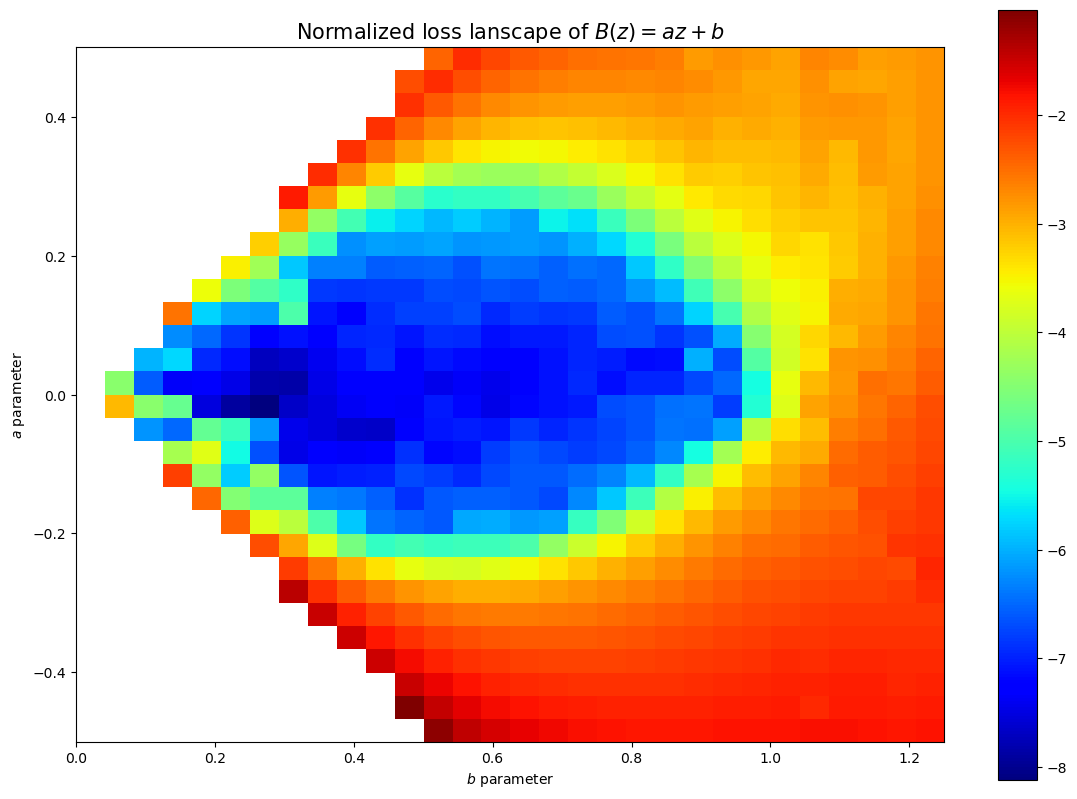

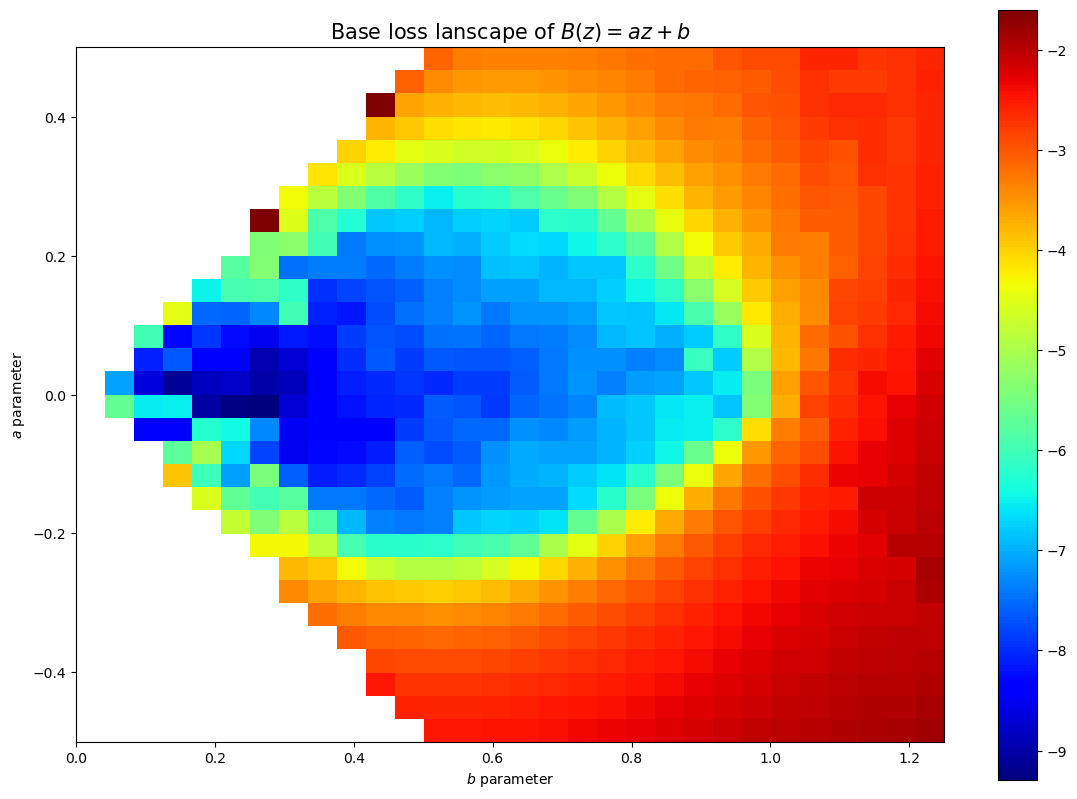

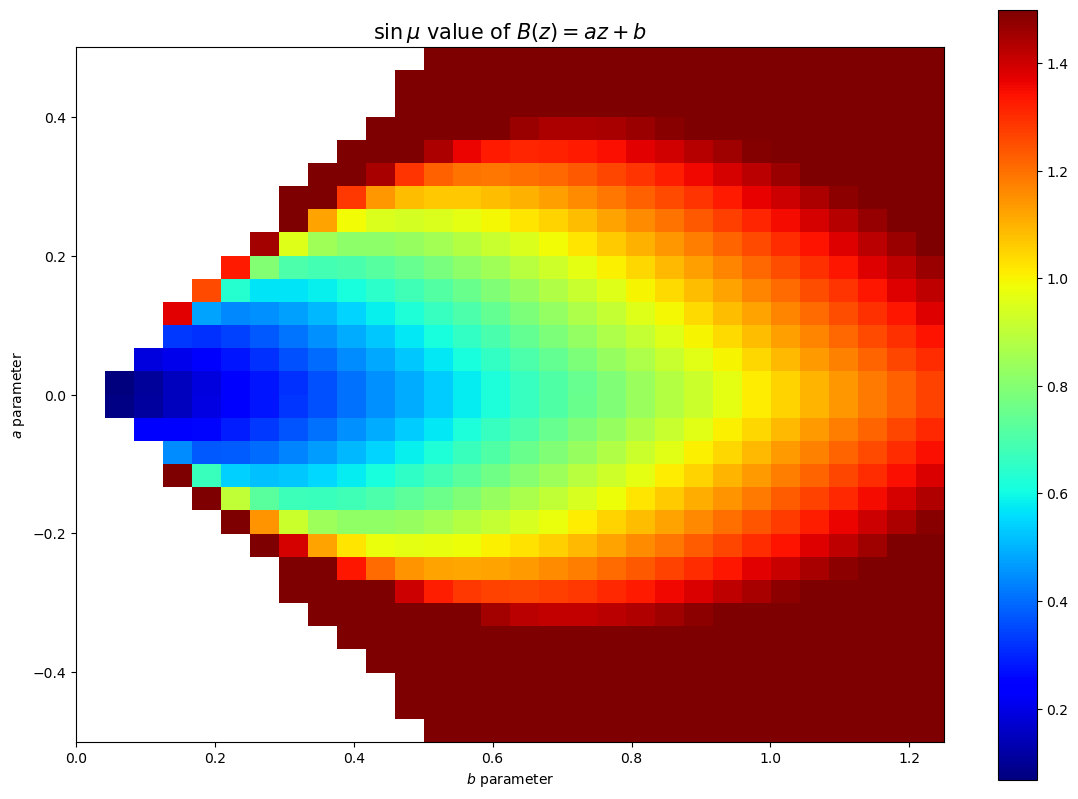

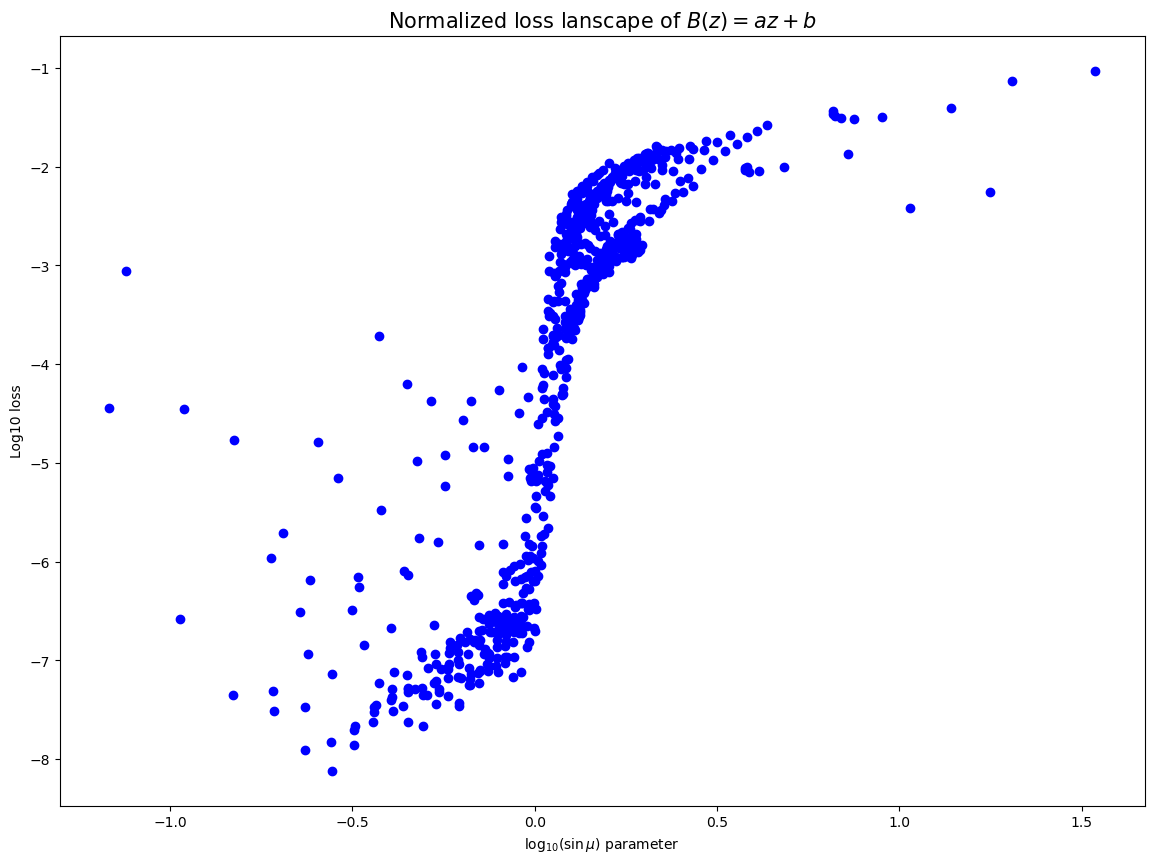

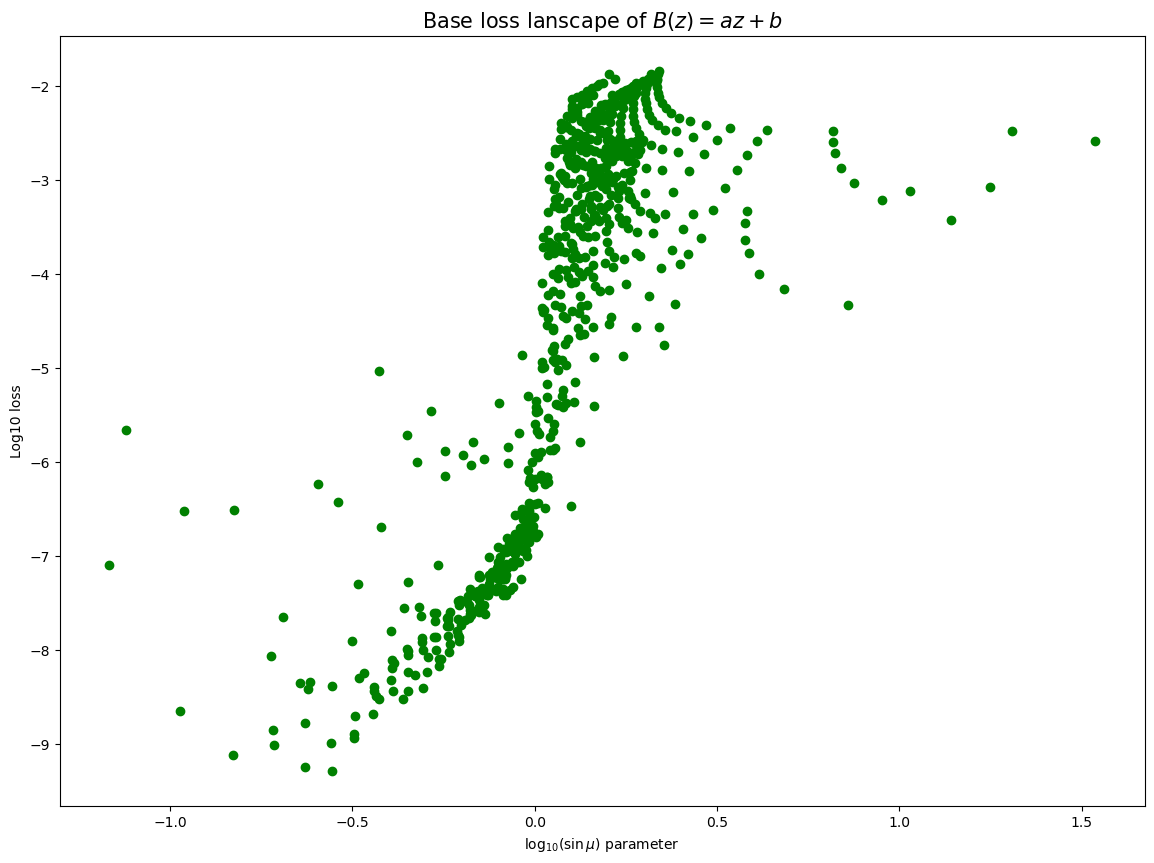

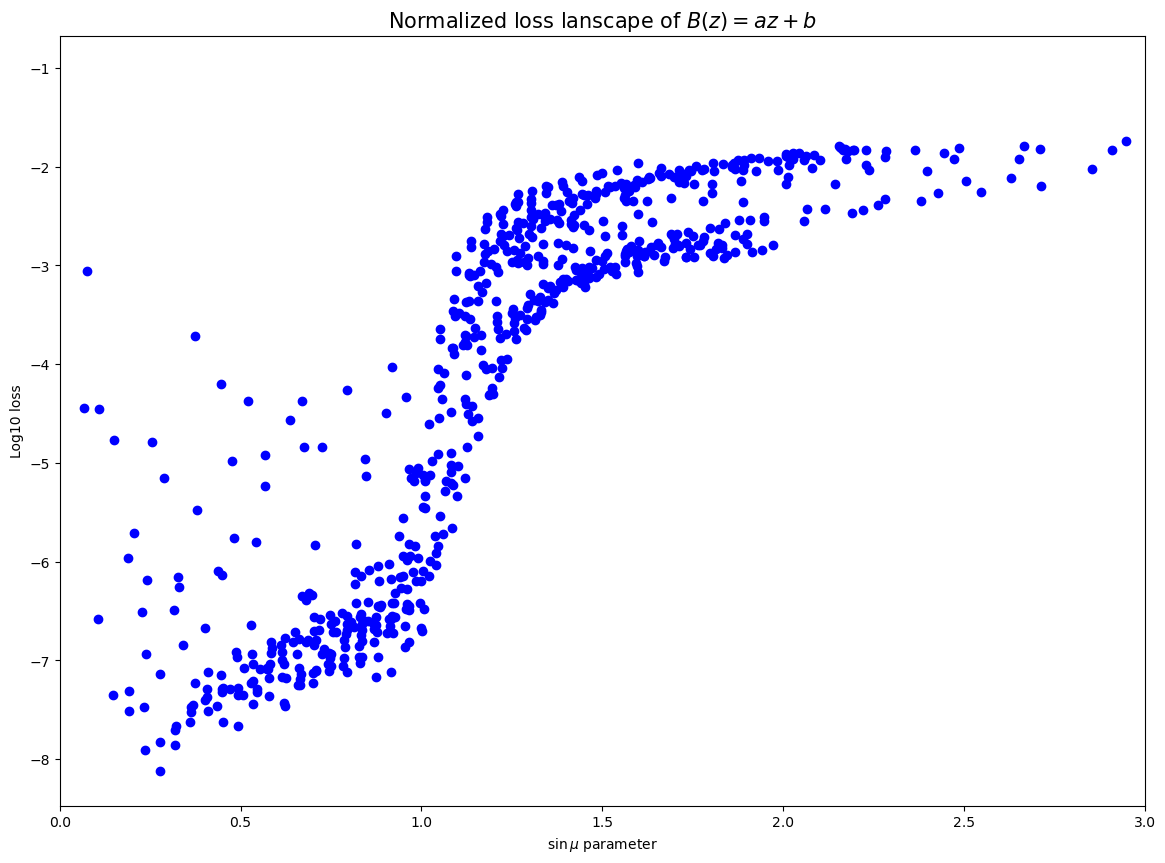

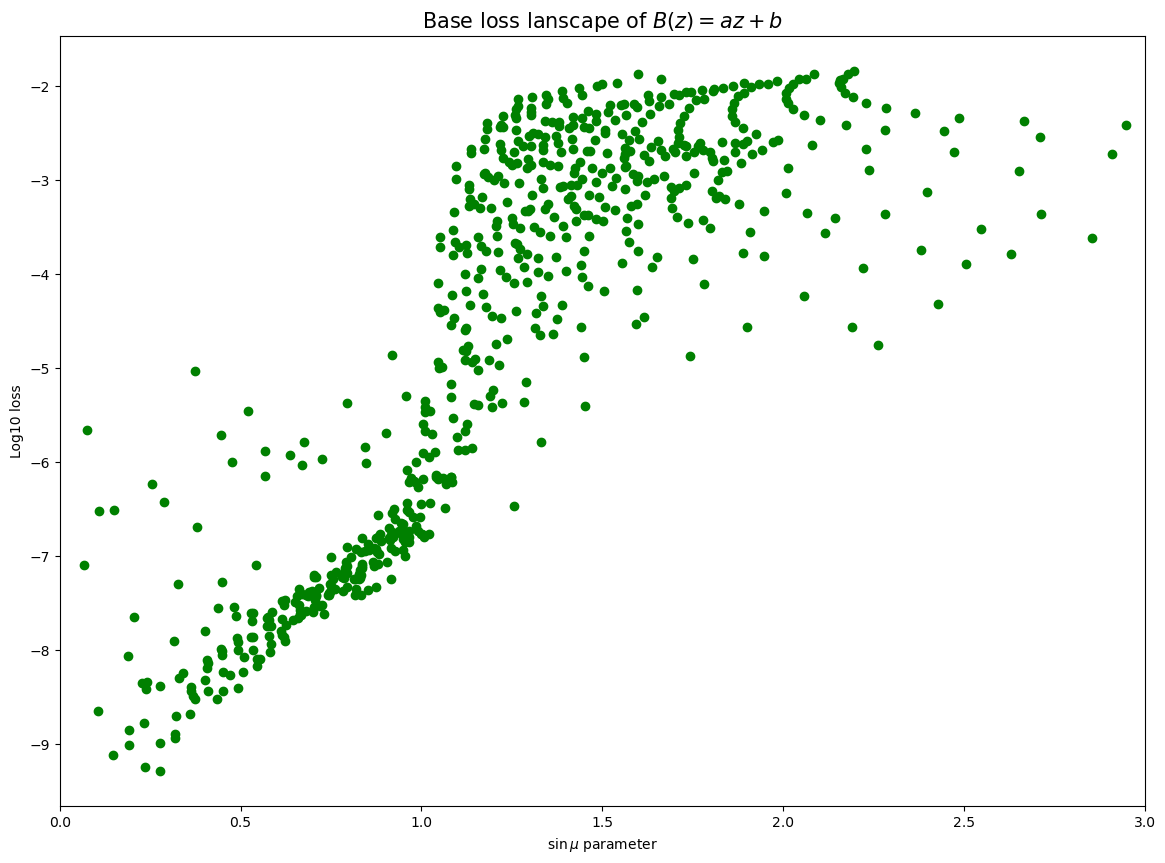

In [862]:
plot_contour_loss_curves_linear(log_res, run_scan, tags_scan, log_type='base10')
plot_sinmu_losses(log_res, run_scan, tags_scan, log_type='base10')

In [863]:
# Make sure to kill the Neptune logger run
run_scan.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-356


##### Doing a similar exercise reshaping $B(z) = a(z+b)$

In [774]:
num_a = 30
num_b = 30

scan_range_a2 = np.linspace(0, 0.5, num=num_a)
scan_range_b2 = np.linspace(1, 2, num=num_b)
param_grid2 = np.dstack(np.meshgrid(scan_range_a2, scan_range_b2)).reshape(-1, 2)



run_scan = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_LinScan4_{}".format(i))

log_res2 = {'params':param_grid2, 'sinmu':np.empty([num_a, num_b]), 'loss_scale':np.empty([num_a, num_b]), 'loss_no_scale':np.empty([num_a, num_b])}

for i, params_lin in enumerate(param_grid2):
    
    a_index = i % num_a
    b_index = int((i - i % num_a)/num_a)
    
    # Ensure that the differential cross section is positive for all z values
    if params_lin[1] * params_lin[0] > abs(params_lin[0]):
        print('Starting the simulation with a={} and b={}'.format(params_lin[0],params_lin[1]))

        params_scan = {'batch_size': 64,
                 'epochs_num': 300,
                 'learning_rate': 0.001,
                 'lr_scheduler': False, 
                 'beta1' : 0.85,
                 'beta2' : 0.999,
                 'integral_points': 25,
                 'method_int': 'trapz',
                 'activation': 'ReLU',
                 'fund_dom': False,
                 'layer_list': [64, 128, 128, 64],
                 'final_layer': 'Sigmoid',
                 'loss': 'Huber',
                 'scaled_loss': True,
                 'scan_param': None,
                 'num_nets' : 1,
                 'p_value': None,
                 'lambda_repulsive': None}

        tags_scan = {'constant function': 'a(z+b)', 'optimizer': 'Adam', 'Mode': 'Scan param linear'}
        run_scan["sys/tags"].add(list(tags_scan.values()))

        run_scan['parameters'] = params_scan
        
        coeffs_scan = np.array([params_lin[0] * params_lin[1], params_lin[0]])
        
        modnet = ModuleNetPolynomial(polynomial_coeffs=coeffs_scan, device=device)
        netsolver = train_run(params_scan, device, run_scan, module_net=modnet)

        sinmu, loss_scale, loss_no_scale = eval_run_scans(netsolver, params_scan, device, run_scan)
        log_res2['sinmu'][a_index, b_index] = sinmu.cpu().numpy()
        log_res2['loss_scale'][a_index, b_index] = loss_scale.cpu().numpy()
        log_res2['loss_no_scale'][a_index, b_index] = loss_no_scale.cpu().numpy()
    else:
        log_res2['sinmu'][a_index, b_index] = np.nan
        log_res2['loss_scale'][a_index, b_index] = np.nan
        log_res2['loss_no_scale'][a_index, b_index] = np.nan

https://app.neptune.ai/zulap/2to2scattering/e/TOS-319
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Starting the simulation with a=0.017241379310344827 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.080233
Train Epoch: 15 ; tLoss: 0.058290
Train Epoch: 30 ; tLoss: 0.021084
Train Epoch: 45 ; tLoss: 0.007951
Tr

Train Epoch: 15 ; tLoss: 0.016956
Train Epoch: 30 ; tLoss: 0.007215
Train Epoch: 45 ; tLoss: 0.002388
Train Epoch: 60 ; tLoss: 0.008276
Train Epoch: 75 ; tLoss: 0.001139
Train Epoch: 90 ; tLoss: 0.009885
Train Epoch: 105 ; tLoss: 0.002215
Train Epoch: 120 ; tLoss: 0.004219
Train Epoch: 135 ; tLoss: 0.001737
Train Epoch: 150 ; tLoss: 0.010082
Train Epoch: 165 ; tLoss: 0.004200
Train Epoch: 180 ; tLoss: 0.001307
Train Epoch: 195 ; tLoss: 0.004144
Train Epoch: 210 ; tLoss: 0.002752
Train Epoch: 225 ; tLoss: 0.000075
Train Epoch: 240 ; tLoss: 0.001473
Train Epoch: 255 ; tLoss: 0.001145
Train Epoch: 270 ; tLoss: 0.000520
Train Epoch: 285 ; tLoss: 0.001224
Starting the simulation with a=0.13793103448275862 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.006643
Train Epoch: 225 ; tLoss: 0.000741
Train Epoch: 240 ; tLoss: 0.005072
Train Epoch: 255 ; tLoss: 0.004230
Train Epoch: 270 ; tLoss: 0.003310
Train Epoch: 285 ; tLoss: 0.005568
Starting the simulation with a=0.24137931034482757 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.185755
Train Epoch: 15 ; tLoss: 0.048068
Train Epoch: 30 ; tLoss: 0.023009
Train Epoch: 45 ; tLoss: 0.008973
Train Epoch: 60 ; tLoss: 0.017426
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.052708
Train Epoch: 30 ; tLoss: 0.043783
Train Epoch: 45 ; tLoss: 0.015308
Train Epoch: 60 ; tLoss: 0.026855
Train Epoch: 75 ; tLoss: 0.007982
Train Epoch: 90 ; tLoss: 0.032834
Train Epoch: 105 ; tLoss: 0.010961
Train Epoch: 120 ; tLoss: 0.021128
Train Epoch: 135 ; tLoss: 0.014078
Train Epoch: 150 ; tLoss: 0.025033
Train Epoch: 165 ; tLoss: 0.021992
Train Epoch: 180 ; tLoss: 0.007678
Train Epoch: 195 ; tLoss: 0.021437
Train Epoch: 210 ; tLoss: 0.012625
Train Epoch: 225 ; tLoss: 0.002895
Train Epoch: 240 ; tLoss: 0.012630
Train Epoch: 255 ; tLoss: 0.009093
Train Epoch: 270 ; tLoss: 0.009718
Train Epoch: 285 ; tLoss: 0.011616
Starting the simulation with a=0.3620689655172414 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.017689
Train Epoch: 225 ; tLoss: 0.006434
Train Epoch: 240 ; tLoss: 0.019727
Train Epoch: 255 ; tLoss: 0.012768
Train Epoch: 270 ; tLoss: 0.015884
Train Epoch: 285 ; tLoss: 0.017716
Starting the simulation with a=0.46551724137931033 and b=1.0344827586206897
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.455741
Train Epoch: 15 ; tLoss: 0.060281
Train Epoch: 30 ; tLoss: 0.052014
Train Epoch: 45 ; tLoss: 0.029032
Train Epoch: 60 ; tLoss: 0.041282
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.007351
Train Epoch: 30 ; tLoss: 0.002331
Train Epoch: 45 ; tLoss: 0.000752
Train Epoch: 60 ; tLoss: 0.002452
Train Epoch: 75 ; tLoss: 0.000299
Train Epoch: 90 ; tLoss: 0.002717
Train Epoch: 105 ; tLoss: 0.000388
Train Epoch: 120 ; tLoss: 0.001033
Train Epoch: 135 ; tLoss: 0.000224
Train Epoch: 150 ; tLoss: 0.001112
Train Epoch: 165 ; tLoss: 0.000519
Train Epoch: 180 ; tLoss: 0.000403
Train Epoch: 195 ; tLoss: 0.000932
Train Epoch: 210 ; tLoss: 0.001344
Train Epoch: 225 ; tLoss: 0.000094
Train Epoch: 240 ; tLoss: 0.000037
Train Epoch: 255 ; tLoss: 0.000080
Train Epoch: 270 ; tLoss: 0.000022
Train Epoch: 285 ; tLoss: 0.000413
Starting the simulation with a=0.08620689655172414 and b=1.0689655172413792
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.001711
Train Epoch: 225 ; tLoss: 0.000046
Train Epoch: 240 ; tLoss: 0.001292
Train Epoch: 255 ; tLoss: 0.001013
Train Epoch: 270 ; tLoss: 0.000601
Train Epoch: 285 ; tLoss: 0.001251
Starting the simulation with a=0.1896551724137931 and b=1.0689655172413792
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.100441
Train Epoch: 15 ; tLoss: 0.031809
Train Epoch: 30 ; tLoss: 0.011432
Train Epoch: 45 ; tLoss: 0.003680
Train Epoch: 60 ; tLoss: 0.007086
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.042266
Train Epoch: 30 ; tLoss: 0.022127
Train Epoch: 45 ; tLoss: 0.008715
Train Epoch: 60 ; tLoss: 0.013942
Train Epoch: 75 ; tLoss: 0.004407
Train Epoch: 90 ; tLoss: 0.015373
Train Epoch: 105 ; tLoss: 0.005366
Train Epoch: 120 ; tLoss: 0.009853
Train Epoch: 135 ; tLoss: 0.006528
Train Epoch: 150 ; tLoss: 0.010050
Train Epoch: 165 ; tLoss: 0.009468
Train Epoch: 180 ; tLoss: 0.003291
Train Epoch: 195 ; tLoss: 0.008518
Train Epoch: 210 ; tLoss: 0.004870
Train Epoch: 225 ; tLoss: 0.000993
Train Epoch: 240 ; tLoss: 0.005039
Train Epoch: 255 ; tLoss: 0.004073
Train Epoch: 270 ; tLoss: 0.004053
Train Epoch: 285 ; tLoss: 0.005202
Starting the simulation with a=0.3103448275862069 and b=1.0689655172413792
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.008466
Train Epoch: 225 ; tLoss: 0.003392
Train Epoch: 240 ; tLoss: 0.010699
Train Epoch: 255 ; tLoss: 0.007247
Train Epoch: 270 ; tLoss: 0.009118
Train Epoch: 285 ; tLoss: 0.009116
Starting the simulation with a=0.41379310344827586 and b=1.0689655172413792
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.342681
Train Epoch: 15 ; tLoss: 0.046431
Train Epoch: 30 ; tLoss: 0.041808
Train Epoch: 45 ; tLoss: 0.016518
Train Epoch: 60 ; tLoss: 0.022159
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.408788
Train Epoch: 30 ; tLoss: 0.914217
Train Epoch: 45 ; tLoss: 0.149843
Train Epoch: 60 ; tLoss: 0.132665
Train Epoch: 75 ; tLoss: 0.120923
Train Epoch: 90 ; tLoss: 0.133911
Train Epoch: 105 ; tLoss: 0.123059
Train Epoch: 120 ; tLoss: 0.130238
Train Epoch: 135 ; tLoss: 0.121228
Train Epoch: 150 ; tLoss: 0.110822
Train Epoch: 165 ; tLoss: 0.106235
Train Epoch: 180 ; tLoss: 0.099558
Train Epoch: 195 ; tLoss: 0.099362
Train Epoch: 210 ; tLoss: 0.098017
Train Epoch: 225 ; tLoss: 0.097636
Train Epoch: 240 ; tLoss: 0.098001
Train Epoch: 255 ; tLoss: 0.097587
Train Epoch: 270 ; tLoss: 0.097862
Train Epoch: 285 ; tLoss: 0.097858
Starting the simulation with a=0.034482758620689655 and b=1.103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000364
Train Epoch: 225 ; tLoss: 0.000141
Train Epoch: 240 ; tLoss: 0.000080
Train Epoch: 255 ; tLoss: 0.000063
Train Epoch: 270 ; tLoss: 0.000022
Train Epoch: 285 ; tLoss: 0.000131
Starting the simulation with a=0.13793103448275862 and b=1.103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.053151
Train Epoch: 15 ; tLoss: 0.010205
Train Epoch: 30 ; tLoss: 0.004110
Train Epoch: 45 ; tLoss: 0.001378
Train Epoch: 60 ; tLoss: 0.002771
Train Epoch: 75 ; tLo

Experiencing connection interruptions. Reestablishing communication with Neptune.
Experiencing connection interruptions. Reestablishing communication with Neptune.


Train Epoch: 255 ; tLoss: 0.000211
Train Epoch: 270 ; tLoss: 0.000067
Train Epoch: 285 ; tLoss: 0.000384
Starting the simulation with a=0.1724137931034483 and b=1.103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.076048
Train Epoch: 15 ; tLoss: 0.018265
Train Epoch: 30 ; tLoss: 0.006633
Train Epoch: 45 ; tLoss: 0.002259
Train Epoch: 60 ; tLoss: 0.003995
Train Epoch: 75 ; tLoss: 0.000770
Train Epoch: 90 ; tLoss: 0.004247
Train Epoch: 105 ; tLoss: 0.000904
Train Epoch: 120 ; tLoss

Experiencing connection interruptions. Reestablishing communication with Neptune.
Experiencing connection interruptions. Reestablishing communication with Neptune.


Train Epoch: 75 ; tLoss: 0.001819
Train Epoch: 90 ; tLoss: 0.006819
Train Epoch: 105 ; tLoss: 0.001644
Train Epoch: 120 ; tLoss: 0.003627
Train Epoch: 135 ; tLoss: 0.002137
Train Epoch: 150 ; tLoss: 0.003585
Train Epoch: 165 ; tLoss: 0.003107
Train Epoch: 180 ; tLoss: 0.001148
Train Epoch: 195 ; tLoss: 0.002911
Train Epoch: 210 ; tLoss: 0.001520
Train Epoch: 225 ; tLoss: 0.000049
Train Epoch: 240 ; tLoss: 0.001309
Train Epoch: 255 ; tLoss: 0.001057
Train Epoch: 270 ; tLoss: 0.000759
Train Epoch: 285 ; tLoss: 0.001350
Starting the simulation with a=0.24137931034482757 and b=1.103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)


Train Epoch: 270 ; tLoss: 0.003631
Train Epoch: 285 ; tLoss: 0.004368
Starting the simulation with a=0.3448275862068966 and b=1.103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.254413
Train Epoch: 15 ; tLoss: 0.039019
Train Epoch: 30 ; tLoss: 0.033153
Train Epoch: 45 ; tLoss: 0.009956
Train Epoch: 60 ; tLoss: 0.013668
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
Train Epoch: 75 ; 

Train Epoch: 15 ; tLoss: 0.042761
Train Epoch: 30 ; tLoss: 0.039233
Train Epoch: 45 ; tLoss: 0.014268
Train Epoch: 60 ; tLoss: 0.019376
Train Epoch: 75 ; tLoss: 0.007202
Train Epoch: 90 ; tLoss: 0.019740
Train Epoch: 105 ; tLoss: 0.008419
Train Epoch: 120 ; tLoss: 0.014096
Train Epoch: 135 ; tLoss: 0.010830
Train Epoch: 150 ; tLoss: 0.013303
Train Epoch: 165 ; tLoss: 0.015438
Train Epoch: 180 ; tLoss: 0.005845
Train Epoch: 195 ; tLoss: 0.013823
Train Epoch: 210 ; tLoss: 0.007218
Train Epoch: 225 ; tLoss: 0.003896
Train Epoch: 240 ; tLoss: 0.010341
Train Epoch: 255 ; tLoss: 0.006467
Train Epoch: 270 ; tLoss: 0.009218
Train Epoch: 285 ; tLoss: 0.008580
Starting the simulation with a=0.46551724137931033 and b=1.103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.000561
Train Epoch: 240 ; tLoss: 0.000062
Train Epoch: 255 ; tLoss: 0.000049
Train Epoch: 270 ; tLoss: 0.000010
Train Epoch: 285 ; tLoss: 0.000015
Starting the simulation with a=0.06896551724137931 and b=1.1379310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.044029
Train Epoch: 15 ; tLoss: 0.004428
Train Epoch: 30 ; tLoss: 0.001070
Train Epoch: 45 ; tLoss: 0.000195
Train Epoch: 60 ; tLoss: 0.000949
Train Epoch: 75 ; tLoss: 0.000112
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.016452
Train Epoch: 30 ; tLoss: 0.006052
Train Epoch: 45 ; tLoss: 0.001717
Train Epoch: 60 ; tLoss: 0.002667
Train Epoch: 75 ; tLoss: 0.000428
Train Epoch: 90 ; tLoss: 0.002504
Train Epoch: 105 ; tLoss: 0.000519
Train Epoch: 120 ; tLoss: 0.000841
Train Epoch: 135 ; tLoss: 0.000376
Train Epoch: 150 ; tLoss: 0.001306
Train Epoch: 165 ; tLoss: 0.000727
Train Epoch: 180 ; tLoss: 0.000184
Train Epoch: 195 ; tLoss: 0.000663
Train Epoch: 210 ; tLoss: 0.000394
Train Epoch: 225 ; tLoss: 0.000033
Train Epoch: 240 ; tLoss: 0.000212
Train Epoch: 255 ; tLoss: 0.000146
Train Epoch: 270 ; tLoss: 0.000066
Train Epoch: 285 ; tLoss: 0.000167
Starting the simulation with a=0.1896551724137931 and b=1.1379310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001598
Train Epoch: 225 ; tLoss: 0.000271
Train Epoch: 240 ; tLoss: 0.001591
Train Epoch: 255 ; tLoss: 0.001275
Train Epoch: 270 ; tLoss: 0.001110
Train Epoch: 285 ; tLoss: 0.001727
Starting the simulation with a=0.29310344827586204 and b=1.1379310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.196642
Train Epoch: 15 ; tLoss: 0.035031
Train Epoch: 30 ; tLoss: 0.020468
Train Epoch: 45 ; tLoss: 0.006733
Train Epoch: 60 ; tLoss: 0.008099
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.036788
Train Epoch: 30 ; tLoss: 0.034759
Train Epoch: 45 ; tLoss: 0.011895
Train Epoch: 60 ; tLoss: 0.014385
Train Epoch: 75 ; tLoss: 0.005103
Train Epoch: 90 ; tLoss: 0.012909
Train Epoch: 105 ; tLoss: 0.005303
Train Epoch: 120 ; tLoss: 0.008870
Train Epoch: 135 ; tLoss: 0.006673
Train Epoch: 150 ; tLoss: 0.007958
Train Epoch: 165 ; tLoss: 0.008897
Train Epoch: 180 ; tLoss: 0.003278
Train Epoch: 195 ; tLoss: 0.007975
Train Epoch: 210 ; tLoss: 0.004217
Train Epoch: 225 ; tLoss: 0.001670
Train Epoch: 240 ; tLoss: 0.005673
Train Epoch: 255 ; tLoss: 0.003884
Train Epoch: 270 ; tLoss: 0.004886
Train Epoch: 285 ; tLoss: 0.004848
Starting the simulation with a=0.41379310344827586 and b=1.1379310344827587
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 225 ; tLoss: 0.004491
Train Epoch: 240 ; tLoss: 0.010627
Train Epoch: 255 ; tLoss: 0.006231
Train Epoch: 270 ; tLoss: 0.009490
Train Epoch: 285 ; tLoss: 0.008864
Starting the simulation with a=0.017241379310344827 and b=1.1724137931034484
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.077275
Train Epoch: 15 ; tLoss: 0.522689
Train Epoch: 30 ; tLoss: 0.118623
Train Epoch: 45 ; tLoss: 0.110352
Train Epoch: 60 ; tLoss: 0.107622
Train Epoch: 75 ; tLoss: 0.102341
Train Epoch: 90 ; tL

Train Epoch: 15 ; tLoss: 0.005886
Train Epoch: 30 ; tLoss: 0.002035
Train Epoch: 45 ; tLoss: 0.000466
Train Epoch: 60 ; tLoss: 0.001140
Train Epoch: 75 ; tLoss: 0.000107
Train Epoch: 90 ; tLoss: 0.000744
Train Epoch: 105 ; tLoss: 0.000206
Train Epoch: 120 ; tLoss: 0.000208
Train Epoch: 135 ; tLoss: 0.000071
Train Epoch: 150 ; tLoss: 0.000380
Train Epoch: 165 ; tLoss: 0.000145
Train Epoch: 180 ; tLoss: 0.000082
Train Epoch: 195 ; tLoss: 0.000204
Train Epoch: 210 ; tLoss: 0.000342
Train Epoch: 225 ; tLoss: 0.000068
Train Epoch: 240 ; tLoss: 0.000048
Train Epoch: 255 ; tLoss: 0.000011
Train Epoch: 270 ; tLoss: 0.000009
Train Epoch: 285 ; tLoss: 0.000026
Starting the simulation with a=0.13793103448275862 and b=1.1724137931034484
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000528
Train Epoch: 225 ; tLoss: 0.000008
Train Epoch: 240 ; tLoss: 0.000434
Train Epoch: 255 ; tLoss: 0.000312
Train Epoch: 270 ; tLoss: 0.000198
Train Epoch: 285 ; tLoss: 0.000303
Starting the simulation with a=0.24137931034482757 and b=1.1724137931034484
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.143148
Train Epoch: 15 ; tLoss: 0.031383
Train Epoch: 30 ; tLoss: 0.012749
Train Epoch: 45 ; tLoss: 0.003776
Train Epoch: 60 ; tLoss: 0.004364
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.033115
Train Epoch: 30 ; tLoss: 0.026747
Train Epoch: 45 ; tLoss: 0.008181
Train Epoch: 60 ; tLoss: 0.009110
Train Epoch: 75 ; tLoss: 0.003143
Train Epoch: 90 ; tLoss: 0.007949
Train Epoch: 105 ; tLoss: 0.003074
Train Epoch: 120 ; tLoss: 0.005108
Train Epoch: 135 ; tLoss: 0.003536
Train Epoch: 150 ; tLoss: 0.004386
Train Epoch: 165 ; tLoss: 0.004594
Train Epoch: 180 ; tLoss: 0.001619
Train Epoch: 195 ; tLoss: 0.003910
Train Epoch: 210 ; tLoss: 0.002186
Train Epoch: 225 ; tLoss: 0.000579
Train Epoch: 240 ; tLoss: 0.002506
Train Epoch: 255 ; tLoss: 0.002040
Train Epoch: 270 ; tLoss: 0.002154
Train Epoch: 285 ; tLoss: 0.002620
Starting the simulation with a=0.3620689655172414 and b=1.1724137931034484
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.004459
Train Epoch: 225 ; tLoss: 0.002601
Train Epoch: 240 ; tLoss: 0.006568
Train Epoch: 255 ; tLoss: 0.004101
Train Epoch: 270 ; tLoss: 0.005949
Train Epoch: 285 ; tLoss: 0.005302
Starting the simulation with a=0.46551724137931033 and b=1.1724137931034484
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.373571
Train Epoch: 15 ; tLoss: 0.037788
Train Epoch: 30 ; tLoss: 0.034488
Train Epoch: 45 ; tLoss: 0.017118
Train Epoch: 60 ; tLoss: 0.016114
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.003293
Train Epoch: 30 ; tLoss: 0.000599
Train Epoch: 45 ; tLoss: 0.000246
Train Epoch: 60 ; tLoss: 0.000380
Train Epoch: 75 ; tLoss: 0.000069
Train Epoch: 90 ; tLoss: 0.000262
Train Epoch: 105 ; tLoss: 0.000047
Train Epoch: 120 ; tLoss: 0.000054
Train Epoch: 135 ; tLoss: 0.000023
Train Epoch: 150 ; tLoss: 0.000067
Train Epoch: 165 ; tLoss: 0.000021
Train Epoch: 180 ; tLoss: 0.000024
Train Epoch: 195 ; tLoss: 0.000054
Train Epoch: 210 ; tLoss: 0.000028
Train Epoch: 225 ; tLoss: 0.000008
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000016
Train Epoch: 285 ; tLoss: 0.000071
Starting the simulation with a=0.08620689655172414 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000109
Train Epoch: 225 ; tLoss: 0.000024
Train Epoch: 240 ; tLoss: 0.000031
Train Epoch: 255 ; tLoss: 0.000017
Train Epoch: 270 ; tLoss: 0.000003
Train Epoch: 285 ; tLoss: 0.000022
Starting the simulation with a=0.1896551724137931 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.091029
Train Epoch: 15 ; tLoss: 0.023696
Train Epoch: 30 ; tLoss: 0.005970
Train Epoch: 45 ; tLoss: 0.001729
Train Epoch: 60 ; tLoss: 0.002147
Train Epoch: 75 ; tLos

Train Epoch: 15 ; tLoss: 0.030895
Train Epoch: 30 ; tLoss: 0.018633
Train Epoch: 45 ; tLoss: 0.006164
Train Epoch: 60 ; tLoss: 0.006024
Train Epoch: 75 ; tLoss: 0.002012
Train Epoch: 90 ; tLoss: 0.004987
Train Epoch: 105 ; tLoss: 0.001590
Train Epoch: 120 ; tLoss: 0.002703
Train Epoch: 135 ; tLoss: 0.001674
Train Epoch: 150 ; tLoss: 0.002198
Train Epoch: 165 ; tLoss: 0.002111
Train Epoch: 180 ; tLoss: 0.000787
Train Epoch: 195 ; tLoss: 0.001793
Train Epoch: 210 ; tLoss: 0.000942
Train Epoch: 225 ; tLoss: 0.000146
Train Epoch: 240 ; tLoss: 0.000936
Train Epoch: 255 ; tLoss: 0.000732
Train Epoch: 270 ; tLoss: 0.000632
Train Epoch: 285 ; tLoss: 0.000976
Starting the simulation with a=0.3103448275862069 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_fe

Train Epoch: 210 ; tLoss: 0.002631
Train Epoch: 225 ; tLoss: 0.000976
Train Epoch: 240 ; tLoss: 0.003451
Train Epoch: 255 ; tLoss: 0.002468
Train Epoch: 270 ; tLoss: 0.002991
Train Epoch: 285 ; tLoss: 0.003058
Starting the simulation with a=0.41379310344827586 and b=1.206896551724138
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.322701
Train Epoch: 15 ; tLoss: 0.032574
Train Epoch: 30 ; tLoss: 0.029780
Train Epoch: 45 ; tLoss: 0.009998
Train Epoch: 60 ; tLoss: 0.010605
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.048212
Train Epoch: 30 ; tLoss: 0.009788
Train Epoch: 45 ; tLoss: 0.002170
Train Epoch: 60 ; tLoss: 0.000953
Train Epoch: 75 ; tLoss: 0.000125
Train Epoch: 90 ; tLoss: 0.000197
Train Epoch: 105 ; tLoss: 0.000056
Train Epoch: 120 ; tLoss: 0.000057
Train Epoch: 135 ; tLoss: 0.000020
Train Epoch: 150 ; tLoss: 0.000073
Train Epoch: 165 ; tLoss: 0.000039
Train Epoch: 180 ; tLoss: 0.000918
Train Epoch: 195 ; tLoss: 0.004007
Train Epoch: 210 ; tLoss: 0.000308
Train Epoch: 225 ; tLoss: 0.000010
Train Epoch: 240 ; tLoss: 0.000016
Train Epoch: 255 ; tLoss: 0.000005
Train Epoch: 270 ; tLoss: 0.000006
Train Epoch: 285 ; tLoss: 0.000004
Starting the simulation with a=0.034482758620689655 and b=1.2413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000062
Train Epoch: 225 ; tLoss: 0.000007
Train Epoch: 240 ; tLoss: 0.000020
Train Epoch: 255 ; tLoss: 0.000012
Train Epoch: 270 ; tLoss: 0.000004
Train Epoch: 285 ; tLoss: 0.000014
Starting the simulation with a=0.13793103448275862 and b=1.2413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.044171
Train Epoch: 15 ; tLoss: 0.006663
Train Epoch: 30 ; tLoss: 0.001832
Train Epoch: 45 ; tLoss: 0.000423
Train Epoch: 60 ; tLoss: 0.000689
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.028093
Train Epoch: 30 ; tLoss: 0.009356
Train Epoch: 45 ; tLoss: 0.002976
Train Epoch: 60 ; tLoss: 0.002831
Train Epoch: 75 ; tLoss: 0.000704
Train Epoch: 90 ; tLoss: 0.002212
Train Epoch: 105 ; tLoss: 0.000454
Train Epoch: 120 ; tLoss: 0.000913
Train Epoch: 135 ; tLoss: 0.000472
Train Epoch: 150 ; tLoss: 0.000871
Train Epoch: 165 ; tLoss: 0.000688
Train Epoch: 180 ; tLoss: 0.000210
Train Epoch: 195 ; tLoss: 0.000570
Train Epoch: 210 ; tLoss: 0.000284
Train Epoch: 225 ; tLoss: 0.000006
Train Epoch: 240 ; tLoss: 0.000198
Train Epoch: 255 ; tLoss: 0.000135
Train Epoch: 270 ; tLoss: 0.000078
Train Epoch: 285 ; tLoss: 0.000122
Starting the simulation with a=0.25862068965517243 and b=1.2413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.001281
Train Epoch: 225 ; tLoss: 0.000321
Train Epoch: 240 ; tLoss: 0.001367
Train Epoch: 255 ; tLoss: 0.001156
Train Epoch: 270 ; tLoss: 0.001169
Train Epoch: 285 ; tLoss: 0.001500
Starting the simulation with a=0.3620689655172414 and b=1.2413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.272749
Train Epoch: 15 ; tLoss: 0.029488
Train Epoch: 30 ; tLoss: 0.025031
Train Epoch: 45 ; tLoss: 0.007049
Train Epoch: 60 ; tLoss: 0.007633
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.034473
Train Epoch: 30 ; tLoss: 0.030597
Train Epoch: 45 ; tLoss: 0.013651
Train Epoch: 60 ; tLoss: 0.012786
Train Epoch: 75 ; tLoss: 0.004940
Train Epoch: 90 ; tLoss: 0.010850
Train Epoch: 105 ; tLoss: 0.005138
Train Epoch: 120 ; tLoss: 0.007555
Train Epoch: 135 ; tLoss: 0.006004
Train Epoch: 150 ; tLoss: 0.006484
Train Epoch: 165 ; tLoss: 0.008042
Train Epoch: 180 ; tLoss: 0.003061
Train Epoch: 195 ; tLoss: 0.006927
Train Epoch: 210 ; tLoss: 0.003636
Train Epoch: 225 ; tLoss: 0.002255
Train Epoch: 240 ; tLoss: 0.005499
Train Epoch: 255 ; tLoss: 0.003263
Train Epoch: 270 ; tLoss: 0.004965
Train Epoch: 285 ; tLoss: 0.004374
Starting the simulation with a=0.48275862068965514 and b=1.2413793103448276
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000021
Train Epoch: 225 ; tLoss: 0.000092
Train Epoch: 240 ; tLoss: 0.000005
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000014
Train Epoch: 285 ; tLoss: 0.000029
Starting the simulation with a=0.08620689655172414 and b=1.2758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.030407
Train Epoch: 15 ; tLoss: 0.003038
Train Epoch: 30 ; tLoss: 0.000561
Train Epoch: 45 ; tLoss: 0.000104
Train Epoch: 60 ; tLoss: 0.000250
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.023007
Train Epoch: 30 ; tLoss: 0.006051
Train Epoch: 45 ; tLoss: 0.001342
Train Epoch: 60 ; tLoss: 0.001378
Train Epoch: 75 ; tLoss: 0.000156
Train Epoch: 90 ; tLoss: 0.000738
Train Epoch: 105 ; tLoss: 0.000121
Train Epoch: 120 ; tLoss: 0.000181
Train Epoch: 135 ; tLoss: 0.000058
Train Epoch: 150 ; tLoss: 0.000245
Train Epoch: 165 ; tLoss: 0.000121
Train Epoch: 180 ; tLoss: 0.000037
Train Epoch: 195 ; tLoss: 0.000117
Train Epoch: 210 ; tLoss: 0.000066
Train Epoch: 225 ; tLoss: 0.000014
Train Epoch: 240 ; tLoss: 0.000022
Train Epoch: 255 ; tLoss: 0.000013
Train Epoch: 270 ; tLoss: 0.000007
Train Epoch: 285 ; tLoss: 0.000020
Starting the simulation with a=0.20689655172413793 and b=1.2758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000467
Train Epoch: 225 ; tLoss: 0.000040
Train Epoch: 240 ; tLoss: 0.000454
Train Epoch: 255 ; tLoss: 0.000321
Train Epoch: 270 ; tLoss: 0.000221
Train Epoch: 285 ; tLoss: 0.000376
Starting the simulation with a=0.3103448275862069 and b=1.2758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.222656
Train Epoch: 15 ; tLoss: 0.027829
Train Epoch: 30 ; tLoss: 0.018058
Train Epoch: 45 ; tLoss: 0.005368
Train Epoch: 60 ; tLoss: 0.004968
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.029748
Train Epoch: 30 ; tLoss: 0.027092
Train Epoch: 45 ; tLoss: 0.009632
Train Epoch: 60 ; tLoss: 0.009047
Train Epoch: 75 ; tLoss: 0.003572
Train Epoch: 90 ; tLoss: 0.007472
Train Epoch: 105 ; tLoss: 0.003313
Train Epoch: 120 ; tLoss: 0.004977
Train Epoch: 135 ; tLoss: 0.003782
Train Epoch: 150 ; tLoss: 0.004093
Train Epoch: 165 ; tLoss: 0.004701
Train Epoch: 180 ; tLoss: 0.001785
Train Epoch: 195 ; tLoss: 0.004069
Train Epoch: 210 ; tLoss: 0.002121
Train Epoch: 225 ; tLoss: 0.000887
Train Epoch: 240 ; tLoss: 0.002803
Train Epoch: 255 ; tLoss: 0.002006
Train Epoch: 270 ; tLoss: 0.002468
Train Epoch: 285 ; tLoss: 0.002418
Starting the simulation with a=0.43103448275862066 and b=1.2758620689655173
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 225 ; tLoss: 0.001499
Train Epoch: 240 ; tLoss: 0.000654
Train Epoch: 255 ; tLoss: 0.000102
Train Epoch: 270 ; tLoss: 0.000174
Train Epoch: 285 ; tLoss: 0.000056
Starting the simulation with a=0.034482758620689655 and b=1.3103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.058419
Train Epoch: 15 ; tLoss: 0.002125
Train Epoch: 30 ; tLoss: 0.000435
Train Epoch: 45 ; tLoss: 0.000091
Train Epoch: 60 ; tLoss: 0.000198
Train Epoch: 75 ; tLoss: 0.000016
Train Epoch: 90 ; tL

Train Epoch: 15 ; tLoss: 0.005253
Train Epoch: 30 ; tLoss: 0.001649
Train Epoch: 45 ; tLoss: 0.000318
Train Epoch: 60 ; tLoss: 0.000474
Train Epoch: 75 ; tLoss: 0.000046
Train Epoch: 90 ; tLoss: 0.000221
Train Epoch: 105 ; tLoss: 0.000031
Train Epoch: 120 ; tLoss: 0.000040
Train Epoch: 135 ; tLoss: 0.000021
Train Epoch: 150 ; tLoss: 0.000084
Train Epoch: 165 ; tLoss: 0.000035
Train Epoch: 180 ; tLoss: 0.000017
Train Epoch: 195 ; tLoss: 0.000025
Train Epoch: 210 ; tLoss: 0.000022
Train Epoch: 225 ; tLoss: 0.000020
Train Epoch: 240 ; tLoss: 0.000013
Train Epoch: 255 ; tLoss: 0.000004
Train Epoch: 270 ; tLoss: 0.000004
Train Epoch: 285 ; tLoss: 0.000007
Starting the simulation with a=0.15517241379310345 and b=1.3103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000141
Train Epoch: 225 ; tLoss: 0.000009
Train Epoch: 240 ; tLoss: 0.000073
Train Epoch: 255 ; tLoss: 0.000047
Train Epoch: 270 ; tLoss: 0.000025
Train Epoch: 285 ; tLoss: 0.000038
Starting the simulation with a=0.25862068965517243 and b=1.3103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.171782
Train Epoch: 15 ; tLoss: 0.026513
Train Epoch: 30 ; tLoss: 0.011003
Train Epoch: 45 ; tLoss: 0.003052
Train Epoch: 60 ; tLoss: 0.002743
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.026756
Train Epoch: 30 ; tLoss: 0.022869
Train Epoch: 45 ; tLoss: 0.005868
Train Epoch: 60 ; tLoss: 0.006249
Train Epoch: 75 ; tLoss: 0.002259
Train Epoch: 90 ; tLoss: 0.004747
Train Epoch: 105 ; tLoss: 0.001850
Train Epoch: 120 ; tLoss: 0.002905
Train Epoch: 135 ; tLoss: 0.001981
Train Epoch: 150 ; tLoss: 0.002155
Train Epoch: 165 ; tLoss: 0.002226
Train Epoch: 180 ; tLoss: 0.000799
Train Epoch: 195 ; tLoss: 0.001806
Train Epoch: 210 ; tLoss: 0.001023
Train Epoch: 225 ; tLoss: 0.000261
Train Epoch: 240 ; tLoss: 0.001076
Train Epoch: 255 ; tLoss: 0.000931
Train Epoch: 270 ; tLoss: 0.000935
Train Epoch: 285 ; tLoss: 0.001221
Starting the simulation with a=0.3793103448275862 and b=1.3103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.002802
Train Epoch: 225 ; tLoss: 0.001771
Train Epoch: 240 ; tLoss: 0.004276
Train Epoch: 255 ; tLoss: 0.002528
Train Epoch: 270 ; tLoss: 0.003922
Train Epoch: 285 ; tLoss: 0.003412
Starting the simulation with a=0.48275862068965514 and b=1.3103448275862069
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.411659
Train Epoch: 15 ; tLoss: 0.034344
Train Epoch: 30 ; tLoss: 0.028726
Train Epoch: 45 ; tLoss: 0.016856
Train Epoch: 60 ; tLoss: 0.012243
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.002636
Train Epoch: 30 ; tLoss: 0.000387
Train Epoch: 45 ; tLoss: 0.000047
Train Epoch: 60 ; tLoss: 0.000158
Train Epoch: 75 ; tLoss: 0.000027
Train Epoch: 90 ; tLoss: 0.000086
Train Epoch: 105 ; tLoss: 0.000020
Train Epoch: 120 ; tLoss: 0.000013
Train Epoch: 135 ; tLoss: 0.000009
Train Epoch: 150 ; tLoss: 0.000020
Train Epoch: 165 ; tLoss: 0.000053
Train Epoch: 180 ; tLoss: 0.000084
Train Epoch: 195 ; tLoss: 0.000021
Train Epoch: 210 ; tLoss: 0.000034
Train Epoch: 225 ; tLoss: 0.000037
Train Epoch: 240 ; tLoss: 0.000040
Train Epoch: 255 ; tLoss: 0.000139
Train Epoch: 270 ; tLoss: 0.000023
Train Epoch: 285 ; tLoss: 0.000005
Starting the simulation with a=0.10344827586206896 and b=1.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000040
Train Epoch: 225 ; tLoss: 0.000007
Train Epoch: 240 ; tLoss: 0.000015
Train Epoch: 255 ; tLoss: 0.000010
Train Epoch: 270 ; tLoss: 0.000006
Train Epoch: 285 ; tLoss: 0.000011
Starting the simulation with a=0.20689655172413793 and b=1.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.119716
Train Epoch: 15 ; tLoss: 0.023544
Train Epoch: 30 ; tLoss: 0.005937
Train Epoch: 45 ; tLoss: 0.001941
Train Epoch: 60 ; tLoss: 0.001377
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.025641
Train Epoch: 30 ; tLoss: 0.017894
Train Epoch: 45 ; tLoss: 0.004907
Train Epoch: 60 ; tLoss: 0.003929
Train Epoch: 75 ; tLoss: 0.001298
Train Epoch: 90 ; tLoss: 0.002716
Train Epoch: 105 ; tLoss: 0.000777
Train Epoch: 120 ; tLoss: 0.001287
Train Epoch: 135 ; tLoss: 0.000716
Train Epoch: 150 ; tLoss: 0.000972
Train Epoch: 165 ; tLoss: 0.000886
Train Epoch: 180 ; tLoss: 0.000335
Train Epoch: 195 ; tLoss: 0.000753
Train Epoch: 210 ; tLoss: 0.000376
Train Epoch: 225 ; tLoss: 0.000060
Train Epoch: 240 ; tLoss: 0.000364
Train Epoch: 255 ; tLoss: 0.000261
Train Epoch: 270 ; tLoss: 0.000198
Train Epoch: 285 ; tLoss: 0.000306
Starting the simulation with a=0.3275862068965517 and b=1.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001616
Train Epoch: 225 ; tLoss: 0.000665
Train Epoch: 240 ; tLoss: 0.002071
Train Epoch: 255 ; tLoss: 0.001525
Train Epoch: 270 ; tLoss: 0.001844
Train Epoch: 285 ; tLoss: 0.001833
Starting the simulation with a=0.43103448275862066 and b=1.3448275862068966
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.363159
Train Epoch: 15 ; tLoss: 0.029057
Train Epoch: 30 ; tLoss: 0.025591
Train Epoch: 45 ; tLoss: 0.008713
Train Epoch: 60 ; tLoss: 0.007777
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.001766
Train Epoch: 30 ; tLoss: 0.000219
Train Epoch: 45 ; tLoss: 0.000074
Train Epoch: 60 ; tLoss: 0.000110
Train Epoch: 75 ; tLoss: 0.000013
Train Epoch: 90 ; tLoss: 0.000062
Train Epoch: 105 ; tLoss: 0.002255
Train Epoch: 120 ; tLoss: 0.000422
Train Epoch: 135 ; tLoss: 0.000011
Train Epoch: 150 ; tLoss: 0.000028
Train Epoch: 165 ; tLoss: 0.000005
Train Epoch: 180 ; tLoss: 0.000038
Train Epoch: 195 ; tLoss: 0.000025
Train Epoch: 210 ; tLoss: 0.000063
Train Epoch: 225 ; tLoss: 0.000047
Train Epoch: 240 ; tLoss: 0.000103
Train Epoch: 255 ; tLoss: 0.000005
Train Epoch: 270 ; tLoss: 0.000070
Train Epoch: 285 ; tLoss: 0.000058
Starting the simulation with a=0.05172413793103448 and b=1.3793103448275863
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000009
Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000002
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000003
Starting the simulation with a=0.15517241379310345 and b=1.3793103448275863
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.066180
Train Epoch: 15 ; tLoss: 0.011935
Train Epoch: 30 ; tLoss: 0.002921
Train Epoch: 45 ; tLoss: 0.000540
Train Epoch: 60 ; tLoss: 0.000447
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.025164
Train Epoch: 30 ; tLoss: 0.009538
Train Epoch: 45 ; tLoss: 0.002873
Train Epoch: 60 ; tLoss: 0.002244
Train Epoch: 75 ; tLoss: 0.000599
Train Epoch: 90 ; tLoss: 0.001318
Train Epoch: 105 ; tLoss: 0.000251
Train Epoch: 120 ; tLoss: 0.000408
Train Epoch: 135 ; tLoss: 0.000187
Train Epoch: 150 ; tLoss: 0.000363
Train Epoch: 165 ; tLoss: 0.000249
Train Epoch: 180 ; tLoss: 0.000073
Train Epoch: 195 ; tLoss: 0.000207
Train Epoch: 210 ; tLoss: 0.000108
Train Epoch: 225 ; tLoss: 0.000007
Train Epoch: 240 ; tLoss: 0.000065
Train Epoch: 255 ; tLoss: 0.000040
Train Epoch: 270 ; tLoss: 0.000026
Train Epoch: 285 ; tLoss: 0.000035
Starting the simulation with a=0.27586206896551724 and b=1.3793103448275863
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000730
Train Epoch: 225 ; tLoss: 0.000192
Train Epoch: 240 ; tLoss: 0.000739
Train Epoch: 255 ; tLoss: 0.000646
Train Epoch: 270 ; tLoss: 0.000635
Train Epoch: 285 ; tLoss: 0.000853
Starting the simulation with a=0.3793103448275862 and b=1.3793103448275863
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.313441
Train Epoch: 15 ; tLoss: 0.025269
Train Epoch: 30 ; tLoss: 0.022428
Train Epoch: 45 ; tLoss: 0.005098
Train Epoch: 60 ; tLoss: 0.005706
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.033540
Train Epoch: 30 ; tLoss: 0.027026
Train Epoch: 45 ; tLoss: 0.019125
Train Epoch: 60 ; tLoss: 0.010425
Train Epoch: 75 ; tLoss: 0.004086
Train Epoch: 90 ; tLoss: 0.008224
Train Epoch: 105 ; tLoss: 0.004182
Train Epoch: 120 ; tLoss: 0.005763
Train Epoch: 135 ; tLoss: 0.004711
Train Epoch: 150 ; tLoss: 0.004821
Train Epoch: 165 ; tLoss: 0.006122
Train Epoch: 180 ; tLoss: 0.002274
Train Epoch: 195 ; tLoss: 0.005119
Train Epoch: 210 ; tLoss: 0.002784
Train Epoch: 225 ; tLoss: 0.001922
Train Epoch: 240 ; tLoss: 0.004265
Train Epoch: 255 ; tLoss: 0.002376
Train Epoch: 270 ; tLoss: 0.003850
Train Epoch: 285 ; tLoss: 0.003411
Starting the simulation with a=0.5 and b=1.3793103448275863
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, ou

Train Epoch: 210 ; tLoss: 0.000079
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000043
Train Epoch: 270 ; tLoss: 0.000011
Train Epoch: 285 ; tLoss: 0.000023
Starting the simulation with a=0.10344827586206896 and b=1.4137931034482758
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.027136
Train Epoch: 15 ; tLoss: 0.002308
Train Epoch: 30 ; tLoss: 0.000242
Train Epoch: 45 ; tLoss: 0.000100
Train Epoch: 60 ; tLoss: 0.000081
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.022575
Train Epoch: 30 ; tLoss: 0.004720
Train Epoch: 45 ; tLoss: 0.001561
Train Epoch: 60 ; tLoss: 0.000931
Train Epoch: 75 ; tLoss: 0.000094
Train Epoch: 90 ; tLoss: 0.000336
Train Epoch: 105 ; tLoss: 0.000054
Train Epoch: 120 ; tLoss: 0.000069
Train Epoch: 135 ; tLoss: 0.000028
Train Epoch: 150 ; tLoss: 0.000093
Train Epoch: 165 ; tLoss: 0.000057
Train Epoch: 180 ; tLoss: 0.000011
Train Epoch: 195 ; tLoss: 0.000041
Train Epoch: 210 ; tLoss: 0.000026
Train Epoch: 225 ; tLoss: 0.000004
Train Epoch: 240 ; tLoss: 0.000012
Train Epoch: 255 ; tLoss: 0.000007
Train Epoch: 270 ; tLoss: 0.000005
Train Epoch: 285 ; tLoss: 0.000007
Starting the simulation with a=0.22413793103448276 and b=1.4137931034482758
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000240
Train Epoch: 225 ; tLoss: 0.000044
Train Epoch: 240 ; tLoss: 0.000218
Train Epoch: 255 ; tLoss: 0.000150
Train Epoch: 270 ; tLoss: 0.000105
Train Epoch: 285 ; tLoss: 0.000169
Starting the simulation with a=0.3275862068965517 and b=1.4137931034482758
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.262252
Train Epoch: 15 ; tLoss: 0.023459
Train Epoch: 30 ; tLoss: 0.017714
Train Epoch: 45 ; tLoss: 0.004535
Train Epoch: 60 ; tLoss: 0.003466
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.028162
Train Epoch: 30 ; tLoss: 0.024099
Train Epoch: 45 ; tLoss: 0.008750
Train Epoch: 60 ; tLoss: 0.007047
Train Epoch: 75 ; tLoss: 0.002829
Train Epoch: 90 ; tLoss: 0.005756
Train Epoch: 105 ; tLoss: 0.002767
Train Epoch: 120 ; tLoss: 0.003902
Train Epoch: 135 ; tLoss: 0.003035
Train Epoch: 150 ; tLoss: 0.003166
Train Epoch: 165 ; tLoss: 0.003811
Train Epoch: 180 ; tLoss: 0.001460
Train Epoch: 195 ; tLoss: 0.003193
Train Epoch: 210 ; tLoss: 0.001664
Train Epoch: 225 ; tLoss: 0.000850
Train Epoch: 240 ; tLoss: 0.002262
Train Epoch: 255 ; tLoss: 0.001485
Train Epoch: 270 ; tLoss: 0.001986
Train Epoch: 285 ; tLoss: 0.001828
Starting the simulation with a=0.4482758620689655 and b=1.4137931034482758
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.05172413793103448 and b=1.4482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.038996
Train Epoch: 15 ; tLoss: 0.001326
Train Epoch: 30 ; tLoss: 0.000145
Train Epoch: 45 ; tLoss: 0.000013
Train Epoch: 60 ; tLoss: 0.000076
Train Epoch: 75 ; tLoss: 0.000078
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.012077
Train Epoch: 30 ; tLoss: 0.002586
Train Epoch: 45 ; tLoss: 0.000459
Train Epoch: 60 ; tLoss: 0.000307
Train Epoch: 75 ; tLoss: 0.000017
Train Epoch: 90 ; tLoss: 0.000104
Train Epoch: 105 ; tLoss: 0.000021
Train Epoch: 120 ; tLoss: 0.000026
Train Epoch: 135 ; tLoss: 0.000008
Train Epoch: 150 ; tLoss: 0.000036
Train Epoch: 165 ; tLoss: 0.000020
Train Epoch: 180 ; tLoss: 0.000008
Train Epoch: 195 ; tLoss: 0.000016
Train Epoch: 210 ; tLoss: 0.000010
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000004
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000003
Starting the simulation with a=0.1724137931034483 and b=1.4482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000061
Train Epoch: 225 ; tLoss: 0.000004
Train Epoch: 240 ; tLoss: 0.000037
Train Epoch: 255 ; tLoss: 0.000021
Train Epoch: 270 ; tLoss: 0.000014
Train Epoch: 285 ; tLoss: 0.000017
Starting the simulation with a=0.27586206896551724 and b=1.4482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.209407
Train Epoch: 15 ; tLoss: 0.023398
Train Epoch: 30 ; tLoss: 0.012804
Train Epoch: 45 ; tLoss: 0.003425
Train Epoch: 60 ; tLoss: 0.002342
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.024048
Train Epoch: 30 ; tLoss: 0.021392
Train Epoch: 45 ; tLoss: 0.005270
Train Epoch: 60 ; tLoss: 0.004988
Train Epoch: 75 ; tLoss: 0.001990
Train Epoch: 90 ; tLoss: 0.003683
Train Epoch: 105 ; tLoss: 0.001537
Train Epoch: 120 ; tLoss: 0.002235
Train Epoch: 135 ; tLoss: 0.001572
Train Epoch: 150 ; tLoss: 0.001582
Train Epoch: 165 ; tLoss: 0.001647
Train Epoch: 180 ; tLoss: 0.000615
Train Epoch: 195 ; tLoss: 0.001330
Train Epoch: 210 ; tLoss: 0.000755
Train Epoch: 225 ; tLoss: 0.000209
Train Epoch: 240 ; tLoss: 0.000785
Train Epoch: 255 ; tLoss: 0.000672
Train Epoch: 270 ; tLoss: 0.000679
Train Epoch: 285 ; tLoss: 0.000895
Starting the simulation with a=0.39655172413793105 and b=1.4482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.002507
Train Epoch: 225 ; tLoss: 0.001873
Train Epoch: 240 ; tLoss: 0.003899
Train Epoch: 255 ; tLoss: 0.002205
Train Epoch: 270 ; tLoss: 0.003587
Train Epoch: 285 ; tLoss: 0.003044
Starting the simulation with a=0.5 and b=1.4482758620689655
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.464862
Train Epoch: 15 ; tLoss: 0.035783
Train Epoch: 30 ; tLoss: 0.025922
Train Epoch: 45 ; tLoss: 0.020416
Train Epoch: 60 ; tLoss: 0.012702
Train Epoch: 75 ; tLoss: 0.004604
Tr

Train Epoch: 15 ; tLoss: 0.001680
Train Epoch: 30 ; tLoss: 0.000274
Train Epoch: 45 ; tLoss: 0.000030
Train Epoch: 60 ; tLoss: 0.000045
Train Epoch: 75 ; tLoss: 0.000003
Train Epoch: 90 ; tLoss: 0.000036
Train Epoch: 105 ; tLoss: 0.000265
Train Epoch: 120 ; tLoss: 0.000097
Train Epoch: 135 ; tLoss: 0.000024
Train Epoch: 150 ; tLoss: 0.000009
Train Epoch: 165 ; tLoss: 0.000005
Train Epoch: 180 ; tLoss: 0.000007
Train Epoch: 195 ; tLoss: 0.000025
Train Epoch: 210 ; tLoss: 0.000028
Train Epoch: 225 ; tLoss: 0.000008
Train Epoch: 240 ; tLoss: 0.000013
Train Epoch: 255 ; tLoss: 0.000010
Train Epoch: 270 ; tLoss: 0.000030
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.12068965517241378 and b=1.4827586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000018
Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000009
Train Epoch: 255 ; tLoss: 0.000005
Train Epoch: 270 ; tLoss: 0.000003
Train Epoch: 285 ; tLoss: 0.000005
Starting the simulation with a=0.22413793103448276 and b=1.4827586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.154766
Train Epoch: 15 ; tLoss: 0.022711
Train Epoch: 30 ; tLoss: 0.006247
Train Epoch: 45 ; tLoss: 0.001478
Train Epoch: 60 ; tLoss: 0.000964
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.021939
Train Epoch: 30 ; tLoss: 0.018061
Train Epoch: 45 ; tLoss: 0.003612
Train Epoch: 60 ; tLoss: 0.003226
Train Epoch: 75 ; tLoss: 0.001099
Train Epoch: 90 ; tLoss: 0.002029
Train Epoch: 105 ; tLoss: 0.000595
Train Epoch: 120 ; tLoss: 0.000960
Train Epoch: 135 ; tLoss: 0.000497
Train Epoch: 150 ; tLoss: 0.000631
Train Epoch: 165 ; tLoss: 0.000558
Train Epoch: 180 ; tLoss: 0.000202
Train Epoch: 195 ; tLoss: 0.000458
Train Epoch: 210 ; tLoss: 0.000234
Train Epoch: 225 ; tLoss: 0.000052
Train Epoch: 240 ; tLoss: 0.000217
Train Epoch: 255 ; tLoss: 0.000156
Train Epoch: 270 ; tLoss: 0.000118
Train Epoch: 285 ; tLoss: 0.000180
Starting the simulation with a=0.3448275862068966 and b=1.4827586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001411
Train Epoch: 225 ; tLoss: 0.000725
Train Epoch: 240 ; tLoss: 0.001880
Train Epoch: 255 ; tLoss: 0.001268
Train Epoch: 270 ; tLoss: 0.001704
Train Epoch: 285 ; tLoss: 0.001555
Starting the simulation with a=0.4482758620689655 and b=1.4827586206896552
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.414531
Train Epoch: 15 ; tLoss: 0.029710
Train Epoch: 30 ; tLoss: 0.024089
Train Epoch: 45 ; tLoss: 0.016890
Train Epoch: 60 ; tLoss: 0.007882
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.002170
Train Epoch: 30 ; tLoss: 0.000161
Train Epoch: 45 ; tLoss: 0.000024
Train Epoch: 60 ; tLoss: 0.000046
Train Epoch: 75 ; tLoss: 0.000010
Train Epoch: 90 ; tLoss: 0.000036
Train Epoch: 105 ; tLoss: 0.000013
Train Epoch: 120 ; tLoss: 0.000017
Train Epoch: 135 ; tLoss: 0.000003
Train Epoch: 150 ; tLoss: 0.000013
Train Epoch: 165 ; tLoss: 0.000003
Train Epoch: 180 ; tLoss: 0.000003
Train Epoch: 195 ; tLoss: 0.000036
Train Epoch: 210 ; tLoss: 0.000048
Train Epoch: 225 ; tLoss: 0.000004
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000059
Train Epoch: 270 ; tLoss: 0.000011
Train Epoch: 285 ; tLoss: 0.000007
Starting the simulation with a=0.06896551724137931 and b=1.5172413793103448
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000006
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.1724137931034483 and b=1.5172413793103448
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.098221
Train Epoch: 15 ; tLoss: 0.018493
Train Epoch: 30 ; tLoss: 0.004117
Train Epoch: 45 ; tLoss: 0.000607
Train Epoch: 60 ; tLoss: 0.000404
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.021863
Train Epoch: 30 ; tLoss: 0.011183
Train Epoch: 45 ; tLoss: 0.002803
Train Epoch: 60 ; tLoss: 0.001728
Train Epoch: 75 ; tLoss: 0.000457
Train Epoch: 90 ; tLoss: 0.000877
Train Epoch: 105 ; tLoss: 0.000178
Train Epoch: 120 ; tLoss: 0.000273
Train Epoch: 135 ; tLoss: 0.000117
Train Epoch: 150 ; tLoss: 0.000217
Train Epoch: 165 ; tLoss: 0.000152
Train Epoch: 180 ; tLoss: 0.000047
Train Epoch: 195 ; tLoss: 0.000126
Train Epoch: 210 ; tLoss: 0.000065
Train Epoch: 225 ; tLoss: 0.000009
Train Epoch: 240 ; tLoss: 0.000045
Train Epoch: 255 ; tLoss: 0.000026
Train Epoch: 270 ; tLoss: 0.000018
Train Epoch: 285 ; tLoss: 0.000025
Starting the simulation with a=0.29310344827586204 and b=1.5172413793103448
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000649
Train Epoch: 225 ; tLoss: 0.000188
Train Epoch: 240 ; tLoss: 0.000682
Train Epoch: 255 ; tLoss: 0.000577
Train Epoch: 270 ; tLoss: 0.000567
Train Epoch: 285 ; tLoss: 0.000737
Starting the simulation with a=0.39655172413793105 and b=1.5172413793103448
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.362407
Train Epoch: 15 ; tLoss: 0.024553
Train Epoch: 30 ; tLoss: 0.021144
Train Epoch: 45 ; tLoss: 0.006394
Train Epoch: 60 ; tLoss: 0.004896
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.036674
Train Epoch: 30 ; tLoss: 0.024689
Train Epoch: 45 ; tLoss: 0.020558
Train Epoch: 60 ; tLoss: 0.017610
Train Epoch: 75 ; tLoss: 0.004519
Train Epoch: 90 ; tLoss: 0.007855
Train Epoch: 105 ; tLoss: 0.004258
Train Epoch: 120 ; tLoss: 0.005559
Train Epoch: 135 ; tLoss: 0.004701
Train Epoch: 150 ; tLoss: 0.004681
Train Epoch: 165 ; tLoss: 0.005972
Train Epoch: 180 ; tLoss: 0.002302
Train Epoch: 195 ; tLoss: 0.005168
Train Epoch: 210 ; tLoss: 0.002597
Train Epoch: 225 ; tLoss: 0.002210
Train Epoch: 240 ; tLoss: 0.004079
Train Epoch: 255 ; tLoss: 0.002453
Train Epoch: 270 ; tLoss: 0.003903
Train Epoch: 285 ; tLoss: 0.003204
Starting the simulation with a=0.017241379310344827 and b=1.5517241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000055
Train Epoch: 225 ; tLoss: 0.000023
Train Epoch: 240 ; tLoss: 0.000011
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.12068965517241378 and b=1.5517241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.040561
Train Epoch: 15 ; tLoss: 0.003378
Train Epoch: 30 ; tLoss: 0.000459
Train Epoch: 45 ; tLoss: 0.000050
Train Epoch: 60 ; tLoss: 0.000047
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.022228
Train Epoch: 30 ; tLoss: 0.007282
Train Epoch: 45 ; tLoss: 0.001506
Train Epoch: 60 ; tLoss: 0.000942
Train Epoch: 75 ; tLoss: 0.000156
Train Epoch: 90 ; tLoss: 0.000281
Train Epoch: 105 ; tLoss: 0.000037
Train Epoch: 120 ; tLoss: 0.000051
Train Epoch: 135 ; tLoss: 0.000020
Train Epoch: 150 ; tLoss: 0.000054
Train Epoch: 165 ; tLoss: 0.000028
Train Epoch: 180 ; tLoss: 0.000007
Train Epoch: 195 ; tLoss: 0.000021
Train Epoch: 210 ; tLoss: 0.000013
Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000007
Train Epoch: 255 ; tLoss: 0.000004
Train Epoch: 270 ; tLoss: 0.000002
Train Epoch: 285 ; tLoss: 0.000004
Starting the simulation with a=0.24137931034482757 and b=1.5517241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/websocket/_socket.py", line 108, in recv
    bytes_ = _recv()
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/websocket/_socket.py", line 87, in _recv
    return sock.recv(bufsize)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/ssl.py", line 1227, in recv
    return self.read(buflen)
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/ssl.py", line 1102, in read
    return self._sslobj.read(len)
TimeoutError: [Errno 60] Operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/neptune/ne

Train Epoch: 255 ; tLoss: 0.000020
Train Epoch: 270 ; tLoss: 0.000014
Train Epoch: 285 ; tLoss: 0.000019
Starting the simulation with a=0.29310344827586204 and b=1.5517241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.246379
Train Epoch: 15 ; tLoss: 0.020875
Train Epoch: 30 ; tLoss: 0.014307
Train Epoch: 45 ; tLoss: 0.003428
Train Epoch: 60 ; tLoss: 0.002166
Train Epoch: 75 ; tLoss: 0.000655
Train Epoch: 90 ; tLoss: 0.001140
Train Epoch: 105 ; tLoss: 0.000248
Train Epoch: 120 ; tLo

Train Epoch: 15 ; tLoss: 0.024437
Train Epoch: 30 ; tLoss: 0.020753
Train Epoch: 45 ; tLoss: 0.006625
Train Epoch: 60 ; tLoss: 0.004764
Train Epoch: 75 ; tLoss: 0.001970
Train Epoch: 90 ; tLoss: 0.003568
Train Epoch: 105 ; tLoss: 0.001591
Train Epoch: 120 ; tLoss: 0.002201
Train Epoch: 135 ; tLoss: 0.001612
Train Epoch: 150 ; tLoss: 0.001650
Train Epoch: 165 ; tLoss: 0.001832
Train Epoch: 180 ; tLoss: 0.000707
Train Epoch: 195 ; tLoss: 0.001486
Train Epoch: 210 ; tLoss: 0.000781
Train Epoch: 225 ; tLoss: 0.000285
Train Epoch: 240 ; tLoss: 0.000886
Train Epoch: 255 ; tLoss: 0.000719
Train Epoch: 270 ; tLoss: 0.000763
Train Epoch: 285 ; tLoss: 0.000881
Starting the simulation with a=0.41379310344827586 and b=1.5517241379310345
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 225 ; tLoss: 0.002223
Train Epoch: 240 ; tLoss: 0.003992
Train Epoch: 255 ; tLoss: 0.002458
Train Epoch: 270 ; tLoss: 0.003868
Train Epoch: 285 ; tLoss: 0.003156
Starting the simulation with a=0.017241379310344827 and b=1.5862068965517242
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.073977
Train Epoch: 15 ; tLoss: 0.003392
Train Epoch: 30 ; tLoss: 0.000242
Train Epoch: 45 ; tLoss: 0.000095
Train Epoch: 60 ; tLoss: 0.000101
Train Epoch: 75 ; tLoss: 0.000006
Train Epoch: 90 ; tL

Train Epoch: 15 ; tLoss: 0.006154
Train Epoch: 30 ; tLoss: 0.000867
Train Epoch: 45 ; tLoss: 0.000082
Train Epoch: 60 ; tLoss: 0.000073
Train Epoch: 75 ; tLoss: 0.000003
Train Epoch: 90 ; tLoss: 0.000015
Train Epoch: 105 ; tLoss: 0.000003
Train Epoch: 120 ; tLoss: 0.000004
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000005
Train Epoch: 165 ; tLoss: 0.000002
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000002
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.13793103448275862 and b=1.5862068965517242
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000013
Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000007
Train Epoch: 255 ; tLoss: 0.000004
Train Epoch: 270 ; tLoss: 0.000002
Train Epoch: 285 ; tLoss: 0.000004
Starting the simulation with a=0.24137931034482757 and b=1.5862068965517242
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.189319
Train Epoch: 15 ; tLoss: 0.021461
Train Epoch: 30 ; tLoss: 0.007984
Train Epoch: 45 ; tLoss: 0.001668
Train Epoch: 60 ; tLoss: 0.001098
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.020686
Train Epoch: 30 ; tLoss: 0.017858
Train Epoch: 45 ; tLoss: 0.002986
Train Epoch: 60 ; tLoss: 0.003220
Train Epoch: 75 ; tLoss: 0.001230
Train Epoch: 90 ; tLoss: 0.002101
Train Epoch: 105 ; tLoss: 0.000717
Train Epoch: 120 ; tLoss: 0.001066
Train Epoch: 135 ; tLoss: 0.000618
Train Epoch: 150 ; tLoss: 0.000652
Train Epoch: 165 ; tLoss: 0.000582
Train Epoch: 180 ; tLoss: 0.000211
Train Epoch: 195 ; tLoss: 0.000446
Train Epoch: 210 ; tLoss: 0.000244
Train Epoch: 225 ; tLoss: 0.000048
Train Epoch: 240 ; tLoss: 0.000220
Train Epoch: 255 ; tLoss: 0.000173
Train Epoch: 270 ; tLoss: 0.000140
Train Epoch: 285 ; tLoss: 0.000205
Starting the simulation with a=0.3620689655172414 and b=1.5862068965517242
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001637
Train Epoch: 225 ; tLoss: 0.001094
Train Epoch: 240 ; tLoss: 0.002398
Train Epoch: 255 ; tLoss: 0.001392
Train Epoch: 270 ; tLoss: 0.002158
Train Epoch: 285 ; tLoss: 0.001906
Starting the simulation with a=0.46551724137931033 and b=1.5862068965517242
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.462616
Train Epoch: 15 ; tLoss: 0.032742
Train Epoch: 30 ; tLoss: 0.022783
Train Epoch: 45 ; tLoss: 0.018402
Train Epoch: 60 ; tLoss: 0.012695
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.000963
Train Epoch: 30 ; tLoss: 0.000121
Train Epoch: 45 ; tLoss: 0.000010
Train Epoch: 60 ; tLoss: 0.000025
Train Epoch: 75 ; tLoss: 0.000002
Train Epoch: 90 ; tLoss: 0.000005
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000004
Train Epoch: 165 ; tLoss: 0.000003
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000005
Train Epoch: 210 ; tLoss: 0.000074
Train Epoch: 225 ; tLoss: 0.000008
Train Epoch: 240 ; tLoss: 0.000009
Train Epoch: 255 ; tLoss: 0.000005
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.08620689655172414 and b=1.6206896551724137
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000006
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.1896551724137931 and b=1.6206896551724137
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.130198
Train Epoch: 15 ; tLoss: 0.019880
Train Epoch: 30 ; tLoss: 0.002772
Train Epoch: 45 ; tLoss: 0.000935
Train Epoch: 60 ; tLoss: 0.000410
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.019437
Train Epoch: 30 ; tLoss: 0.012871
Train Epoch: 45 ; tLoss: 0.003108
Train Epoch: 60 ; tLoss: 0.001795
Train Epoch: 75 ; tLoss: 0.000575
Train Epoch: 90 ; tLoss: 0.001001
Train Epoch: 105 ; tLoss: 0.000219
Train Epoch: 120 ; tLoss: 0.000302
Train Epoch: 135 ; tLoss: 0.000128
Train Epoch: 150 ; tLoss: 0.000193
Train Epoch: 165 ; tLoss: 0.000134
Train Epoch: 180 ; tLoss: 0.000042
Train Epoch: 195 ; tLoss: 0.000108
Train Epoch: 210 ; tLoss: 0.000053
Train Epoch: 225 ; tLoss: 0.000010
Train Epoch: 240 ; tLoss: 0.000039
Train Epoch: 255 ; tLoss: 0.000023
Train Epoch: 270 ; tLoss: 0.000016
Train Epoch: 285 ; tLoss: 0.000022
Starting the simulation with a=0.3103448275862069 and b=1.6206896551724137
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000735
Train Epoch: 225 ; tLoss: 0.000284
Train Epoch: 240 ; tLoss: 0.000823
Train Epoch: 255 ; tLoss: 0.000664
Train Epoch: 270 ; tLoss: 0.000726
Train Epoch: 285 ; tLoss: 0.000804
Starting the simulation with a=0.41379310344827586 and b=1.6206896551724137
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.408159
Train Epoch: 15 ; tLoss: 0.026394
Train Epoch: 30 ; tLoss: 0.021224
Train Epoch: 45 ; tLoss: 0.014247
Train Epoch: 60 ; tLoss: 0.006311
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.001270
Train Epoch: 30 ; tLoss: 0.003247
Train Epoch: 45 ; tLoss: 0.000198
Train Epoch: 60 ; tLoss: 0.000034
Train Epoch: 75 ; tLoss: 0.000011
Train Epoch: 90 ; tLoss: 0.000011
Train Epoch: 105 ; tLoss: 0.000042
Train Epoch: 120 ; tLoss: 0.004888
Train Epoch: 135 ; tLoss: 0.001566
Train Epoch: 150 ; tLoss: 0.000201
Train Epoch: 165 ; tLoss: 0.000060
Train Epoch: 180 ; tLoss: 0.000067
Train Epoch: 195 ; tLoss: 0.000020
Train Epoch: 210 ; tLoss: 0.000003
Train Epoch: 225 ; tLoss: 0.000018
Train Epoch: 240 ; tLoss: 0.000020
Train Epoch: 255 ; tLoss: 0.000005
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.034482758620689655 and b=1.6551724137931034
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.13793103448275862 and b=1.6551724137931034
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.068961
Train Epoch: 15 ; tLoss: 0.009308
Train Epoch: 30 ; tLoss: 0.001494
Train Epoch: 45 ; tLoss: 0.000189
Train Epoch: 60 ; tLoss: 0.000118
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.020349
Train Epoch: 30 ; tLoss: 0.008066
Train Epoch: 45 ; tLoss: 0.001556
Train Epoch: 60 ; tLoss: 0.000979
Train Epoch: 75 ; tLoss: 0.000217
Train Epoch: 90 ; tLoss: 0.000326
Train Epoch: 105 ; tLoss: 0.000059
Train Epoch: 120 ; tLoss: 0.000081
Train Epoch: 135 ; tLoss: 0.000033
Train Epoch: 150 ; tLoss: 0.000067
Train Epoch: 165 ; tLoss: 0.000042
Train Epoch: 180 ; tLoss: 0.000013
Train Epoch: 195 ; tLoss: 0.000034
Train Epoch: 210 ; tLoss: 0.000018
Train Epoch: 225 ; tLoss: 0.000004
Train Epoch: 240 ; tLoss: 0.000013
Train Epoch: 255 ; tLoss: 0.000007
Train Epoch: 270 ; tLoss: 0.000005
Train Epoch: 285 ; tLoss: 0.000006
Starting the simulation with a=0.25862068965517243 and b=1.6551724137931034
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000219
Train Epoch: 225 ; tLoss: 0.000055
Train Epoch: 240 ; tLoss: 0.000185
Train Epoch: 255 ; tLoss: 0.000151
Train Epoch: 270 ; tLoss: 0.000123
Train Epoch: 285 ; tLoss: 0.000177
Starting the simulation with a=0.3620689655172414 and b=1.6551724137931034
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.351648
Train Epoch: 15 ; tLoss: 0.021338
Train Epoch: 30 ; tLoss: 0.018384
Train Epoch: 45 ; tLoss: 0.004401
Train Epoch: 60 ; tLoss: 0.003291
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.034059
Train Epoch: 30 ; tLoss: 0.021842
Train Epoch: 45 ; tLoss: 0.018356
Train Epoch: 60 ; tLoss: 0.014996
Train Epoch: 75 ; tLoss: 0.003533
Train Epoch: 90 ; tLoss: 0.005953
Train Epoch: 105 ; tLoss: 0.003253
Train Epoch: 120 ; tLoss: 0.004143
Train Epoch: 135 ; tLoss: 0.003467
Train Epoch: 150 ; tLoss: 0.003435
Train Epoch: 165 ; tLoss: 0.004278
Train Epoch: 180 ; tLoss: 0.001637
Train Epoch: 195 ; tLoss: 0.003707
Train Epoch: 210 ; tLoss: 0.001845
Train Epoch: 225 ; tLoss: 0.001516
Train Epoch: 240 ; tLoss: 0.002860
Train Epoch: 255 ; tLoss: 0.001702
Train Epoch: 270 ; tLoss: 0.002716
Train Epoch: 285 ; tLoss: 0.002217
Starting the simulation with a=0.48275862068965514 and b=1.6551724137931034
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000214
Train Epoch: 225 ; tLoss: 0.000059
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.08620689655172414 and b=1.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.020445
Train Epoch: 15 ; tLoss: 0.001132
Train Epoch: 30 ; tLoss: 0.000131
Train Epoch: 45 ; tLoss: 0.000019
Train Epoch: 60 ; tLoss: 0.000020
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.019665
Train Epoch: 30 ; tLoss: 0.002155
Train Epoch: 45 ; tLoss: 0.000866
Train Epoch: 60 ; tLoss: 0.000341
Train Epoch: 75 ; tLoss: 0.000033
Train Epoch: 90 ; tLoss: 0.000077
Train Epoch: 105 ; tLoss: 0.000011
Train Epoch: 120 ; tLoss: 0.000013
Train Epoch: 135 ; tLoss: 0.000005
Train Epoch: 150 ; tLoss: 0.000017
Train Epoch: 165 ; tLoss: 0.000010
Train Epoch: 180 ; tLoss: 0.000003
Train Epoch: 195 ; tLoss: 0.000008
Train Epoch: 210 ; tLoss: 0.000005
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.20689655172413793 and b=1.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000042
Train Epoch: 225 ; tLoss: 0.000010
Train Epoch: 240 ; tLoss: 0.000031
Train Epoch: 255 ; tLoss: 0.000017
Train Epoch: 270 ; tLoss: 0.000011
Train Epoch: 285 ; tLoss: 0.000018
Starting the simulation with a=0.3103448275862069 and b=1.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.293030
Train Epoch: 15 ; tLoss: 0.018432
Train Epoch: 30 ; tLoss: 0.014568
Train Epoch: 45 ; tLoss: 0.002629
Train Epoch: 60 ; tLoss: 0.002147
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.026991
Train Epoch: 30 ; tLoss: 0.020506
Train Epoch: 45 ; tLoss: 0.015266
Train Epoch: 60 ; tLoss: 0.007119
Train Epoch: 75 ; tLoss: 0.002609
Train Epoch: 90 ; tLoss: 0.004181
Train Epoch: 105 ; tLoss: 0.002119
Train Epoch: 120 ; tLoss: 0.002601
Train Epoch: 135 ; tLoss: 0.001989
Train Epoch: 150 ; tLoss: 0.001952
Train Epoch: 165 ; tLoss: 0.002274
Train Epoch: 180 ; tLoss: 0.000861
Train Epoch: 195 ; tLoss: 0.001855
Train Epoch: 210 ; tLoss: 0.001036
Train Epoch: 225 ; tLoss: 0.000524
Train Epoch: 240 ; tLoss: 0.001291
Train Epoch: 255 ; tLoss: 0.000831
Train Epoch: 270 ; tLoss: 0.001091
Train Epoch: 285 ; tLoss: 0.001037
Starting the simulation with a=0.43103448275862066 and b=1.6896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000004
Train Epoch: 255 ; tLoss: 0.000010
Train Epoch: 270 ; tLoss: 0.002859
Train Epoch: 285 ; tLoss: 0.001466
Starting the simulation with a=0.034482758620689655 and b=1.7241379310344827
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.050032
Train Epoch: 15 ; tLoss: 0.001799
Train Epoch: 30 ; tLoss: 0.000272
Train Epoch: 45 ; tLoss: 0.000017
Train Epoch: 60 ; tLoss: 0.000025
Train Epoch: 75 ; tLoss: 0.000005
Train Epoch: 90 ; tL

Train Epoch: 15 ; tLoss: 0.010785
Train Epoch: 30 ; tLoss: 0.001129
Train Epoch: 45 ; tLoss: 0.000185
Train Epoch: 60 ; tLoss: 0.000112
Train Epoch: 75 ; tLoss: 0.000009
Train Epoch: 90 ; tLoss: 0.000025
Train Epoch: 105 ; tLoss: 0.000004
Train Epoch: 120 ; tLoss: 0.000005
Train Epoch: 135 ; tLoss: 0.000002
Train Epoch: 150 ; tLoss: 0.000007
Train Epoch: 165 ; tLoss: 0.000004
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000003
Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.15517241379310345 and b=1.7241379310344827
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000008
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000004
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.25862068965517243 and b=1.7241379310344827
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.232261
Train Epoch: 15 ; tLoss: 0.018674
Train Epoch: 30 ; tLoss: 0.009335
Train Epoch: 45 ; tLoss: 0.002030
Train Epoch: 60 ; tLoss: 0.000994
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.021371
Train Epoch: 30 ; tLoss: 0.018696
Train Epoch: 45 ; tLoss: 0.007937
Train Epoch: 60 ; tLoss: 0.003787
Train Epoch: 75 ; tLoss: 0.001425
Train Epoch: 90 ; tLoss: 0.002454
Train Epoch: 105 ; tLoss: 0.001087
Train Epoch: 120 ; tLoss: 0.001371
Train Epoch: 135 ; tLoss: 0.000908
Train Epoch: 150 ; tLoss: 0.000884
Train Epoch: 165 ; tLoss: 0.000857
Train Epoch: 180 ; tLoss: 0.000342
Train Epoch: 195 ; tLoss: 0.000647
Train Epoch: 210 ; tLoss: 0.000351
Train Epoch: 225 ; tLoss: 0.000098
Train Epoch: 240 ; tLoss: 0.000330
Train Epoch: 255 ; tLoss: 0.000284
Train Epoch: 270 ; tLoss: 0.000247
Train Epoch: 285 ; tLoss: 0.000352
Starting the simulation with a=0.3793103448275862 and b=1.7241379310344827
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001869
Train Epoch: 225 ; tLoss: 0.001597
Train Epoch: 240 ; tLoss: 0.002838
Train Epoch: 255 ; tLoss: 0.001738
Train Epoch: 270 ; tLoss: 0.002739
Train Epoch: 285 ; tLoss: 0.002208
Starting the simulation with a=0.48275862068965514 and b=1.7241379310344827
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.524553
Train Epoch: 15 ; tLoss: 0.039387
Train Epoch: 30 ; tLoss: 0.021521
Train Epoch: 45 ; tLoss: 0.019016
Train Epoch: 60 ; tLoss: 0.018825
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.000852
Train Epoch: 30 ; tLoss: 0.000052
Train Epoch: 45 ; tLoss: 0.000012
Train Epoch: 60 ; tLoss: 0.000014
Train Epoch: 75 ; tLoss: 0.000003
Train Epoch: 90 ; tLoss: 0.000004
Train Epoch: 105 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000004
Train Epoch: 165 ; tLoss: 0.000008
Train Epoch: 180 ; tLoss: 0.000029
Train Epoch: 195 ; tLoss: 0.000020
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000007
Train Epoch: 255 ; tLoss: 0.000191
Train Epoch: 270 ; tLoss: 0.000017
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.10344827586206896 and b=1.7586206896551724
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000005
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.20689655172413793 and b=1.7586206896551724
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.169303
Train Epoch: 15 ; tLoss: 0.019963
Train Epoch: 30 ; tLoss: 0.006199
Train Epoch: 45 ; tLoss: 0.000929
Train Epoch: 60 ; tLoss: 0.000488
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.017778
Train Epoch: 30 ; tLoss: 0.014605
Train Epoch: 45 ; tLoss: 0.002036
Train Epoch: 60 ; tLoss: 0.001919
Train Epoch: 75 ; tLoss: 0.000712
Train Epoch: 90 ; tLoss: 0.001107
Train Epoch: 105 ; tLoss: 0.000306
Train Epoch: 120 ; tLoss: 0.000427
Train Epoch: 135 ; tLoss: 0.000210
Train Epoch: 150 ; tLoss: 0.000239
Train Epoch: 165 ; tLoss: 0.000165
Train Epoch: 180 ; tLoss: 0.000055
Train Epoch: 195 ; tLoss: 0.000122
Train Epoch: 210 ; tLoss: 0.000062
Train Epoch: 225 ; tLoss: 0.000022
Train Epoch: 240 ; tLoss: 0.000047
Train Epoch: 255 ; tLoss: 0.000029
Train Epoch: 270 ; tLoss: 0.000020
Train Epoch: 285 ; tLoss: 0.000029
Starting the simulation with a=0.3275862068965517 and b=1.7586206896551724
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.001033
Train Epoch: 225 ; tLoss: 0.000582
Train Epoch: 240 ; tLoss: 0.001371
Train Epoch: 255 ; tLoss: 0.000849
Train Epoch: 270 ; tLoss: 0.001221
Train Epoch: 285 ; tLoss: 0.001122
Starting the simulation with a=0.43103448275862066 and b=1.7586206896551724
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.466465
Train Epoch: 15 ; tLoss: 0.030609
Train Epoch: 30 ; tLoss: 0.019925
Train Epoch: 45 ; tLoss: 0.016310
Train Epoch: 60 ; tLoss: 0.010934
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.002777
Train Epoch: 30 ; tLoss: 0.000138
Train Epoch: 45 ; tLoss: 0.000036
Train Epoch: 60 ; tLoss: 0.000025
Train Epoch: 75 ; tLoss: 0.000004
Train Epoch: 90 ; tLoss: 0.000017
Train Epoch: 105 ; tLoss: 0.000004
Train Epoch: 120 ; tLoss: 0.000004
Train Epoch: 135 ; tLoss: 0.000003
Train Epoch: 150 ; tLoss: 0.000007
Train Epoch: 165 ; tLoss: 0.000004
Train Epoch: 180 ; tLoss: 0.000003
Train Epoch: 195 ; tLoss: 0.000002
Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.05172413793103448 and b=1.793103448275862
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.15517241379310345 and b=1.793103448275862
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.104125
Train Epoch: 15 ; tLoss: 0.015185
Train Epoch: 30 ; tLoss: 0.002659
Train Epoch: 45 ; tLoss: 0.000333
Train Epoch: 60 ; tLoss: 0.000158
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.017590
Train Epoch: 30 ; tLoss: 0.009352
Train Epoch: 45 ; tLoss: 0.002011
Train Epoch: 60 ; tLoss: 0.000907
Train Epoch: 75 ; tLoss: 0.000209
Train Epoch: 90 ; tLoss: 0.000295
Train Epoch: 105 ; tLoss: 0.000054
Train Epoch: 120 ; tLoss: 0.000072
Train Epoch: 135 ; tLoss: 0.000025
Train Epoch: 150 ; tLoss: 0.000042
Train Epoch: 165 ; tLoss: 0.000026
Train Epoch: 180 ; tLoss: 0.000009
Train Epoch: 195 ; tLoss: 0.000022
Train Epoch: 210 ; tLoss: 0.000011
Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000007
Train Epoch: 255 ; tLoss: 0.000004
Train Epoch: 270 ; tLoss: 0.000003
Train Epoch: 285 ; tLoss: 0.000004
Starting the simulation with a=0.27586206896551724 and b=1.793103448275862
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000345
Train Epoch: 225 ; tLoss: 0.000096
Train Epoch: 240 ; tLoss: 0.000331
Train Epoch: 255 ; tLoss: 0.000286
Train Epoch: 270 ; tLoss: 0.000255
Train Epoch: 285 ; tLoss: 0.000350
Starting the simulation with a=0.3793103448275862 and b=1.793103448275862
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.406194
Train Epoch: 15 ; tLoss: 0.023597
Train Epoch: 30 ; tLoss: 0.018653
Train Epoch: 45 ; tLoss: 0.011883
Train Epoch: 60 ; tLoss: 0.004264
Train Epoch: 75 ; tLos

Train Epoch: 15 ; tLoss: 0.042226
Train Epoch: 30 ; tLoss: 0.020984
Train Epoch: 45 ; tLoss: 0.018838
Train Epoch: 60 ; tLoss: 0.019716
Train Epoch: 75 ; tLoss: 0.013932
Train Epoch: 90 ; tLoss: 0.009224
Train Epoch: 105 ; tLoss: 0.004092
Train Epoch: 120 ; tLoss: 0.005016
Train Epoch: 135 ; tLoss: 0.004400
Train Epoch: 150 ; tLoss: 0.004100
Train Epoch: 165 ; tLoss: 0.005119
Train Epoch: 180 ; tLoss: 0.002352
Train Epoch: 195 ; tLoss: 0.004381
Train Epoch: 210 ; tLoss: 0.002421
Train Epoch: 225 ; tLoss: 0.002193
Train Epoch: 240 ; tLoss: 0.003433
Train Epoch: 255 ; tLoss: 0.002335
Train Epoch: 270 ; tLoss: 0.003593
Train Epoch: 285 ; tLoss: 0.002958
Starting the simulation with a=0.5 and b=1.793103448275862
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out

Train Epoch: 225 ; tLoss: 0.000003
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.10344827586206896 and b=1.8275862068965516
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.037031
Train Epoch: 15 ; tLoss: 0.003785
Train Epoch: 30 ; tLoss: 0.000350
Train Epoch: 45 ; tLoss: 0.000043
Train Epoch: 60 ; tLoss: 0.000034
Train Epoch: 75 ; tLoss: 0.000003
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.019446
Train Epoch: 30 ; tLoss: 0.006078
Train Epoch: 45 ; tLoss: 0.000899
Train Epoch: 60 ; tLoss: 0.000479
Train Epoch: 75 ; tLoss: 0.000092
Train Epoch: 90 ; tLoss: 0.000128
Train Epoch: 105 ; tLoss: 0.000023
Train Epoch: 120 ; tLoss: 0.000027
Train Epoch: 135 ; tLoss: 0.000010
Train Epoch: 150 ; tLoss: 0.000017
Train Epoch: 165 ; tLoss: 0.000007
Train Epoch: 180 ; tLoss: 0.000002
Train Epoch: 195 ; tLoss: 0.000005
Train Epoch: 210 ; tLoss: 0.000004
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000002
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.22413793103448276 and b=1.8275862068965516
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000060
Train Epoch: 225 ; tLoss: 0.000018
Train Epoch: 240 ; tLoss: 0.000049
Train Epoch: 255 ; tLoss: 0.000029
Train Epoch: 270 ; tLoss: 0.000027
Train Epoch: 285 ; tLoss: 0.000035
Starting the simulation with a=0.3275862068965517 and b=1.8275862068965516
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.343709
Train Epoch: 15 ; tLoss: 0.018442
Train Epoch: 30 ; tLoss: 0.015926
Train Epoch: 45 ; tLoss: 0.003242
Train Epoch: 60 ; tLoss: 0.002223
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.032289
Train Epoch: 30 ; tLoss: 0.019216
Train Epoch: 45 ; tLoss: 0.016330
Train Epoch: 60 ; tLoss: 0.012936
Train Epoch: 75 ; tLoss: 0.002702
Train Epoch: 90 ; tLoss: 0.004497
Train Epoch: 105 ; tLoss: 0.002516
Train Epoch: 120 ; tLoss: 0.003099
Train Epoch: 135 ; tLoss: 0.002564
Train Epoch: 150 ; tLoss: 0.002529
Train Epoch: 165 ; tLoss: 0.003046
Train Epoch: 180 ; tLoss: 0.001167
Train Epoch: 195 ; tLoss: 0.002649
Train Epoch: 210 ; tLoss: 0.001309
Train Epoch: 225 ; tLoss: 0.001027
Train Epoch: 240 ; tLoss: 0.001962
Train Epoch: 255 ; tLoss: 0.001202
Train Epoch: 270 ; tLoss: 0.001860
Train Epoch: 285 ; tLoss: 0.001542
Starting the simulation with a=0.4482758620689655 and b=1.8275862068965516
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.05172413793103448 and b=1.8620689655172413
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.026220
Train Epoch: 15 ; tLoss: 0.000572
Train Epoch: 30 ; tLoss: 0.000082
Train Epoch: 45 ; tLoss: 0.000004
Train Epoch: 60 ; tLoss: 0.000011
Train Epoch: 75 ; tLoss: 0.000002
Train Epoch: 90 ; tLo

Train Epoch: 15 ; tLoss: 0.015698
Train Epoch: 30 ; tLoss: 0.002665
Train Epoch: 45 ; tLoss: 0.000273
Train Epoch: 60 ; tLoss: 0.000136
Train Epoch: 75 ; tLoss: 0.000019
Train Epoch: 90 ; tLoss: 0.000032
Train Epoch: 105 ; tLoss: 0.000005
Train Epoch: 120 ; tLoss: 0.000006
Train Epoch: 135 ; tLoss: 0.000002
Train Epoch: 150 ; tLoss: 0.000007
Train Epoch: 165 ; tLoss: 0.000004
Train Epoch: 180 ; tLoss: 0.000002
Train Epoch: 195 ; tLoss: 0.000003
Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.1724137931034483 and b=1.8620689655172413
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000008
Train Epoch: 225 ; tLoss: 0.000002
Train Epoch: 240 ; tLoss: 0.000005
Train Epoch: 255 ; tLoss: 0.000003
Train Epoch: 270 ; tLoss: 0.000002
Train Epoch: 285 ; tLoss: 0.000003
Starting the simulation with a=0.27586206896551724 and b=1.8620689655172413
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.278981
Train Epoch: 15 ; tLoss: 0.016231
Train Epoch: 30 ; tLoss: 0.011039
Train Epoch: 45 ; tLoss: 0.002099
Train Epoch: 60 ; tLoss: 0.001114
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.024367
Train Epoch: 30 ; tLoss: 0.018088
Train Epoch: 45 ; tLoss: 0.012978
Train Epoch: 60 ; tLoss: 0.004934
Train Epoch: 75 ; tLoss: 0.001848
Train Epoch: 90 ; tLoss: 0.002910
Train Epoch: 105 ; tLoss: 0.001491
Train Epoch: 120 ; tLoss: 0.001814
Train Epoch: 135 ; tLoss: 0.001357
Train Epoch: 150 ; tLoss: 0.001325
Train Epoch: 165 ; tLoss: 0.001472
Train Epoch: 180 ; tLoss: 0.000549
Train Epoch: 195 ; tLoss: 0.001117
Train Epoch: 210 ; tLoss: 0.000609
Train Epoch: 225 ; tLoss: 0.000245
Train Epoch: 240 ; tLoss: 0.000622
Train Epoch: 255 ; tLoss: 0.000456
Train Epoch: 270 ; tLoss: 0.000520
Train Epoch: 285 ; tLoss: 0.000555
Starting the simulation with a=0.39655172413793105 and b=1.8620689655172413
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.002846
Train Epoch: 225 ; tLoss: 0.002546
Train Epoch: 240 ; tLoss: 0.003850
Train Epoch: 255 ; tLoss: 0.002734
Train Epoch: 270 ; tLoss: 0.003947
Train Epoch: 285 ; tLoss: 0.003294
Starting the simulation with a=0.5 and b=1.8620689655172413
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.590965
Train Epoch: 15 ; tLoss: 0.049960
Train Epoch: 30 ; tLoss: 0.021581
Train Epoch: 45 ; tLoss: 0.019475
Train Epoch: 60 ; tLoss: 0.020484
Train Epoch: 75 ; tLoss: 0.016846
Tr

Train Epoch: 15 ; tLoss: 0.005031
Train Epoch: 30 ; tLoss: 0.000394
Train Epoch: 45 ; tLoss: 0.000054
Train Epoch: 60 ; tLoss: 0.000037
Train Epoch: 75 ; tLoss: 0.000003
Train Epoch: 90 ; tLoss: 0.000010
Train Epoch: 105 ; tLoss: 0.000002
Train Epoch: 120 ; tLoss: 0.000002
Train Epoch: 135 ; tLoss: 0.000001
Train Epoch: 150 ; tLoss: 0.000002
Train Epoch: 165 ; tLoss: 0.000001
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241378 and b=1.896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_f

Train Epoch: 210 ; tLoss: 0.000005
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000002
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.22413793103448276 and b=1.896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.211986
Train Epoch: 15 ; tLoss: 0.017747
Train Epoch: 30 ; tLoss: 0.007108
Train Epoch: 45 ; tLoss: 0.001046
Train Epoch: 60 ; tLoss: 0.000528
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.018537
Train Epoch: 30 ; tLoss: 0.016462
Train Epoch: 45 ; tLoss: 0.005645
Train Epoch: 60 ; tLoss: 0.002364
Train Epoch: 75 ; tLoss: 0.000935
Train Epoch: 90 ; tLoss: 0.001499
Train Epoch: 105 ; tLoss: 0.000559
Train Epoch: 120 ; tLoss: 0.000688
Train Epoch: 135 ; tLoss: 0.000386
Train Epoch: 150 ; tLoss: 0.000372
Train Epoch: 165 ; tLoss: 0.000296
Train Epoch: 180 ; tLoss: 0.000107
Train Epoch: 195 ; tLoss: 0.000210
Train Epoch: 210 ; tLoss: 0.000110
Train Epoch: 225 ; tLoss: 0.000031
Train Epoch: 240 ; tLoss: 0.000088
Train Epoch: 255 ; tLoss: 0.000066
Train Epoch: 270 ; tLoss: 0.000056
Train Epoch: 285 ; tLoss: 0.000080
Starting the simulation with a=0.3448275862068966 and b=1.896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_fe

Train Epoch: 210 ; tLoss: 0.001377
Train Epoch: 225 ; tLoss: 0.001137
Train Epoch: 240 ; tLoss: 0.002034
Train Epoch: 255 ; tLoss: 0.001275
Train Epoch: 270 ; tLoss: 0.001964
Train Epoch: 285 ; tLoss: 0.001594
Starting the simulation with a=0.4482758620689655 and b=1.896551724137931
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.528972
Train Epoch: 15 ; tLoss: 0.038404
Train Epoch: 30 ; tLoss: 0.019094
Train Epoch: 45 ; tLoss: 0.017059
Train Epoch: 60 ; tLoss: 0.016720
Train Epoch: 75 ; tLos

Train Epoch: 15 ; tLoss: 0.000512
Train Epoch: 30 ; tLoss: 0.000043
Train Epoch: 45 ; tLoss: 0.000027
Train Epoch: 60 ; tLoss: 0.000010
Train Epoch: 75 ; tLoss: 0.000001
Train Epoch: 90 ; tLoss: 0.000005
Train Epoch: 105 ; tLoss: 0.000002
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 135 ; tLoss: 0.000000
Train Epoch: 150 ; tLoss: 0.000002
Train Epoch: 165 ; tLoss: 0.000001
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000001
Train Epoch: 210 ; tLoss: 0.000000
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000088
Train Epoch: 270 ; tLoss: 0.000017
Train Epoch: 285 ; tLoss: 0.000003
Starting the simulation with a=0.06896551724137931 and b=1.9310344827586206
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.1724137931034483 and b=1.9310344827586206
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.142703
Train Epoch: 15 ; tLoss: 0.018512
Train Epoch: 30 ; tLoss: 0.001877
Train Epoch: 45 ; tLoss: 0.000502
Train Epoch: 60 ; tLoss: 0.000185
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.015573
Train Epoch: 30 ; tLoss: 0.011298
Train Epoch: 45 ; tLoss: 0.001808
Train Epoch: 60 ; tLoss: 0.001163
Train Epoch: 75 ; tLoss: 0.000403
Train Epoch: 90 ; tLoss: 0.000543
Train Epoch: 105 ; tLoss: 0.000124
Train Epoch: 120 ; tLoss: 0.000152
Train Epoch: 135 ; tLoss: 0.000064
Train Epoch: 150 ; tLoss: 0.000068
Train Epoch: 165 ; tLoss: 0.000041
Train Epoch: 180 ; tLoss: 0.000013
Train Epoch: 195 ; tLoss: 0.000029
Train Epoch: 210 ; tLoss: 0.000015
Train Epoch: 225 ; tLoss: 0.000004
Train Epoch: 240 ; tLoss: 0.000011
Train Epoch: 255 ; tLoss: 0.000006
Train Epoch: 270 ; tLoss: 0.000004
Train Epoch: 285 ; tLoss: 0.000006
Starting the simulation with a=0.29310344827586204 and b=1.9310344827586206
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000641
Train Epoch: 225 ; tLoss: 0.000313
Train Epoch: 240 ; tLoss: 0.000746
Train Epoch: 255 ; tLoss: 0.000483
Train Epoch: 270 ; tLoss: 0.000600
Train Epoch: 285 ; tLoss: 0.000612
Starting the simulation with a=0.39655172413793105 and b=1.9310344827586206
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.464716
Train Epoch: 15 ; tLoss: 0.028371
Train Epoch: 30 ; tLoss: 0.017685
Train Epoch: 45 ; tLoss: 0.014437
Train Epoch: 60 ; tLoss: 0.008897
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.053873
Train Epoch: 30 ; tLoss: 0.021703
Train Epoch: 45 ; tLoss: 0.019485
Train Epoch: 60 ; tLoss: 0.020274
Train Epoch: 75 ; tLoss: 0.016938
Train Epoch: 90 ; tLoss: 0.022942
Train Epoch: 105 ; tLoss: 0.014290
Train Epoch: 120 ; tLoss: 0.013913
Train Epoch: 135 ; tLoss: 0.007356
Train Epoch: 150 ; tLoss: 0.005748
Train Epoch: 165 ; tLoss: 0.007795
Train Epoch: 180 ; tLoss: 0.004356
Train Epoch: 195 ; tLoss: 0.005997
Train Epoch: 210 ; tLoss: 0.004122
Train Epoch: 225 ; tLoss: 0.003844
Train Epoch: 240 ; tLoss: 0.005382
Train Epoch: 255 ; tLoss: 0.003796
Train Epoch: 270 ; tLoss: 0.005184
Train Epoch: 285 ; tLoss: 0.004682
Starting the simulation with a=0.017241379310344827 and b=1.9655172413793103
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in

Train Epoch: 210 ; tLoss: 0.000001
Train Epoch: 225 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 255 ; tLoss: 0.000000
Train Epoch: 270 ; tLoss: 0.000000
Train Epoch: 285 ; tLoss: 0.000000
Starting the simulation with a=0.12068965517241378 and b=1.9655172413793103
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.071112
Train Epoch: 15 ; tLoss: 0.006918
Train Epoch: 30 ; tLoss: 0.000734
Train Epoch: 45 ; tLoss: 0.000102
Train Epoch: 60 ; tLoss: 0.000053
Train Epoch: 75 ; tL

Train Epoch: 15 ; tLoss: 0.016877
Train Epoch: 30 ; tLoss: 0.007057
Train Epoch: 45 ; tLoss: 0.001092
Train Epoch: 60 ; tLoss: 0.000478
Train Epoch: 75 ; tLoss: 0.000107
Train Epoch: 90 ; tLoss: 0.000122
Train Epoch: 105 ; tLoss: 0.000023
Train Epoch: 120 ; tLoss: 0.000027
Train Epoch: 135 ; tLoss: 0.000012
Train Epoch: 150 ; tLoss: 0.000019
Train Epoch: 165 ; tLoss: 0.000010
Train Epoch: 180 ; tLoss: 0.000004
Train Epoch: 195 ; tLoss: 0.000009
Train Epoch: 210 ; tLoss: 0.000005
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000003
Train Epoch: 255 ; tLoss: 0.000002
Train Epoch: 270 ; tLoss: 0.000002
Train Epoch: 285 ; tLoss: 0.000002
Starting the simulation with a=0.24137931034482757 and b=1.9655172413793103
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 210 ; tLoss: 0.000152
Train Epoch: 225 ; tLoss: 0.000037
Train Epoch: 240 ; tLoss: 0.000121
Train Epoch: 255 ; tLoss: 0.000107
Train Epoch: 270 ; tLoss: 0.000083
Train Epoch: 285 ; tLoss: 0.000128
Starting the simulation with a=0.3448275862068966 and b=1.9655172413793103
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.398177
Train Epoch: 15 ; tLoss: 0.020778
Train Epoch: 30 ; tLoss: 0.016588
Train Epoch: 45 ; tLoss: 0.009437
Train Epoch: 60 ; tLoss: 0.002961
Train Epoch: 75 ; tLo

Train Epoch: 15 ; tLoss: 0.041351
Train Epoch: 30 ; tLoss: 0.018730
Train Epoch: 45 ; tLoss: 0.016925
Train Epoch: 60 ; tLoss: 0.017298
Train Epoch: 75 ; tLoss: 0.011028
Train Epoch: 90 ; tLoss: 0.006364
Train Epoch: 105 ; tLoss: 0.003223
Train Epoch: 120 ; tLoss: 0.004074
Train Epoch: 135 ; tLoss: 0.003572
Train Epoch: 150 ; tLoss: 0.003313
Train Epoch: 165 ; tLoss: 0.004066
Train Epoch: 180 ; tLoss: 0.001881
Train Epoch: 195 ; tLoss: 0.003496
Train Epoch: 210 ; tLoss: 0.002034
Train Epoch: 225 ; tLoss: 0.001780
Train Epoch: 240 ; tLoss: 0.002821
Train Epoch: 255 ; tLoss: 0.001927
Train Epoch: 270 ; tLoss: 0.002920
Train Epoch: 285 ; tLoss: 0.002379
Starting the simulation with a=0.46551724137931033 and b=1.9655172413793103
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_

Train Epoch: 240 ; tLoss: 0.000060
Train Epoch: 255 ; tLoss: 0.000011
Train Epoch: 270 ; tLoss: 0.000003
Train Epoch: 285 ; tLoss: 0.000004
Starting the simulation with a=0.06896551724137931 and b=2.0
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.015561
Train Epoch: 15 ; tLoss: 0.000363
Train Epoch: 30 ; tLoss: 0.000035
Train Epoch: 45 ; tLoss: 0.000008
Train Epoch: 60 ; tLoss: 0.000007
Train Epoch: 75 ; tLoss: 0.000001
Train Epoch: 90 ; tLoss: 0.000003
Train Epoch: 105 ; tLoss: 0.000000
Tr

Train Epoch: 15 ; tLoss: 0.018341
Train Epoch: 30 ; tLoss: 0.002177
Train Epoch: 45 ; tLoss: 0.000464
Train Epoch: 60 ; tLoss: 0.000171
Train Epoch: 75 ; tLoss: 0.000024
Train Epoch: 90 ; tLoss: 0.000028
Train Epoch: 105 ; tLoss: 0.000005
Train Epoch: 120 ; tLoss: 0.000006
Train Epoch: 135 ; tLoss: 0.000003
Train Epoch: 150 ; tLoss: 0.000005
Train Epoch: 165 ; tLoss: 0.000003
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 195 ; tLoss: 0.000002
Train Epoch: 210 ; tLoss: 0.000002
Train Epoch: 225 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 255 ; tLoss: 0.000001
Train Epoch: 270 ; tLoss: 0.000001
Train Epoch: 285 ; tLoss: 0.000001
Starting the simulation with a=0.1896551724137931 and b=2.0
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, ou

Train Epoch: 255 ; tLoss: 0.000005
Train Epoch: 270 ; tLoss: 0.000004
Train Epoch: 285 ; tLoss: 0.000005
Starting the simulation with a=0.29310344827586204 and b=2.0
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=128, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Train Epoch: 0 ; tLoss: 0.329336
Train Epoch: 15 ; tLoss: 0.015846
Train Epoch: 30 ; tLoss: 0.013412
Train Epoch: 45 ; tLoss: 0.001368
Train Epoch: 60 ; tLoss: 0.001354
Train Epoch: 75 ; tLoss: 0.000530
Train Epoch: 90 ; tLoss: 0.000713
Train Epoch: 105 ; tLoss: 0.000198
Train Epoch: 120 ; tLoss: 0.000242
Tr

Train Epoch: 15 ; tLoss: 0.030163
Train Epoch: 30 ; tLoss: 0.017107
Train Epoch: 45 ; tLoss: 0.014520
Train Epoch: 60 ; tLoss: 0.010781
Train Epoch: 75 ; tLoss: 0.002126
Train Epoch: 90 ; tLoss: 0.003361
Train Epoch: 105 ; tLoss: 0.001903
Train Epoch: 120 ; tLoss: 0.002276
Train Epoch: 135 ; tLoss: 0.001838
Train Epoch: 150 ; tLoss: 0.001808
Train Epoch: 165 ; tLoss: 0.002098
Train Epoch: 180 ; tLoss: 0.000792
Train Epoch: 195 ; tLoss: 0.001803
Train Epoch: 210 ; tLoss: 0.000897
Train Epoch: 225 ; tLoss: 0.000631
Train Epoch: 240 ; tLoss: 0.001269
Train Epoch: 255 ; tLoss: 0.000799
Train Epoch: 270 ; tLoss: 0.001180
Train Epoch: 285 ; tLoss: 0.001021
Starting the simulation with a=0.41379310344827586 and b=2.0
PhiNet(
  (activation): ReLU()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=128, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=128, o

Train Epoch: 255 ; tLoss: 0.004317
Train Epoch: 270 ; tLoss: 0.006034
Train Epoch: 285 ; tLoss: 0.005523


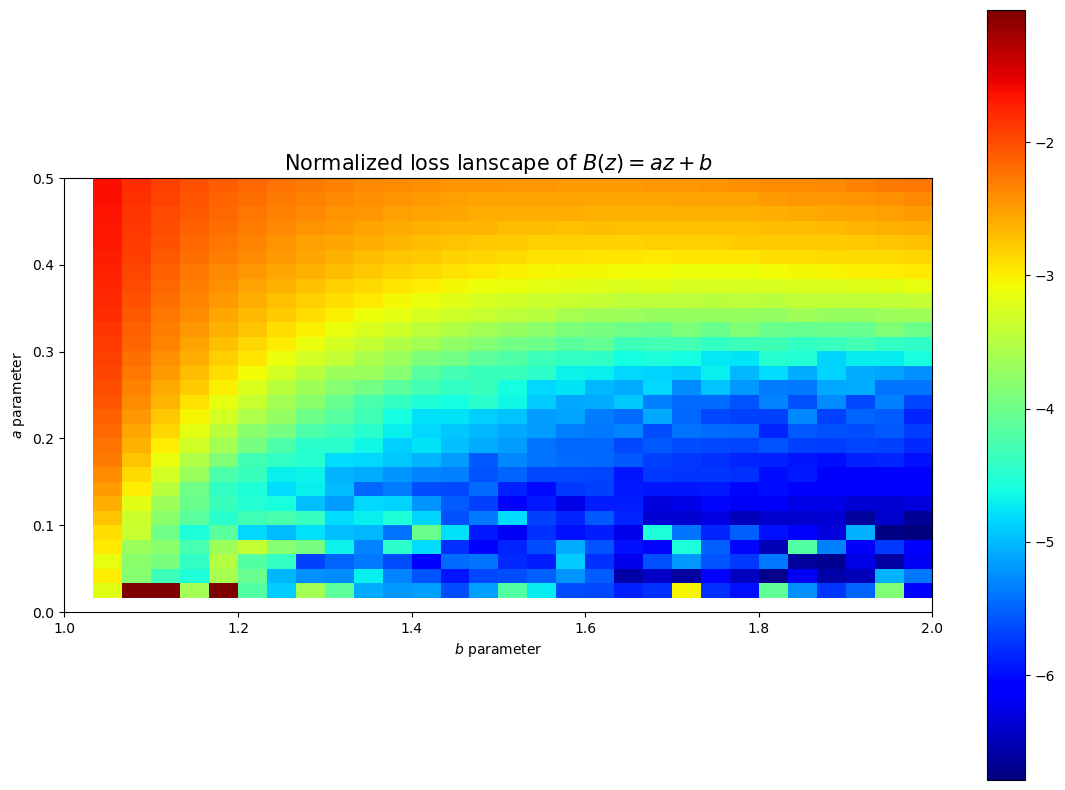

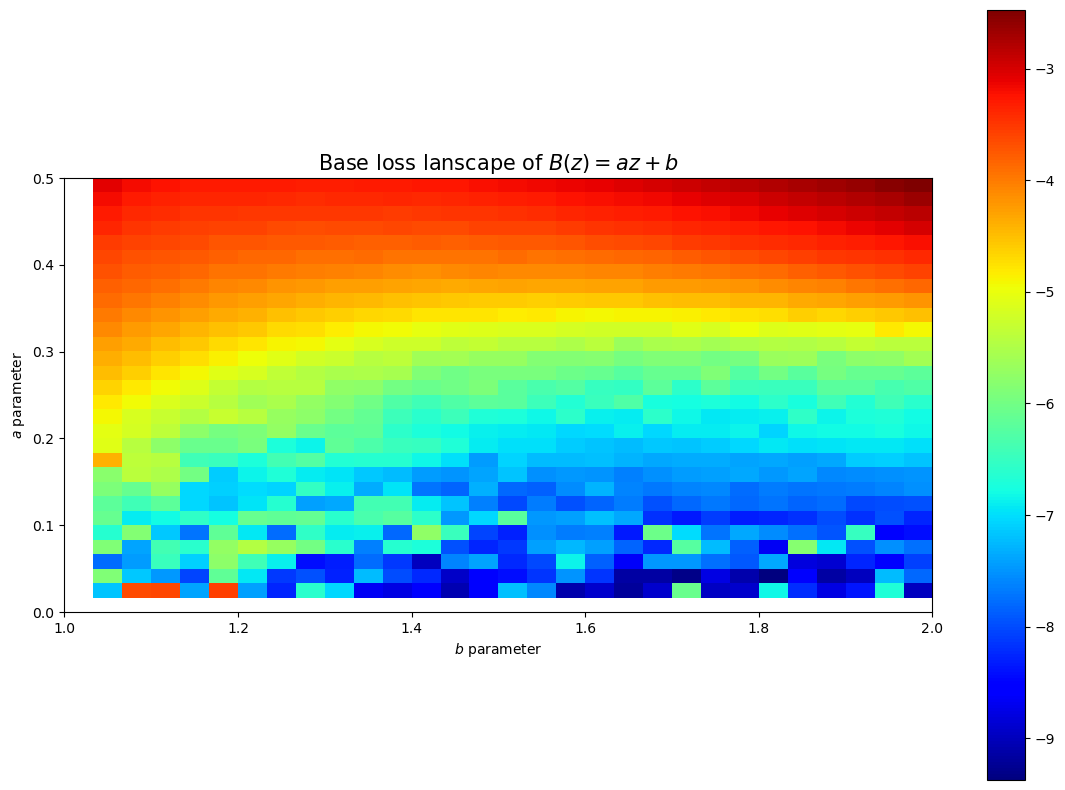

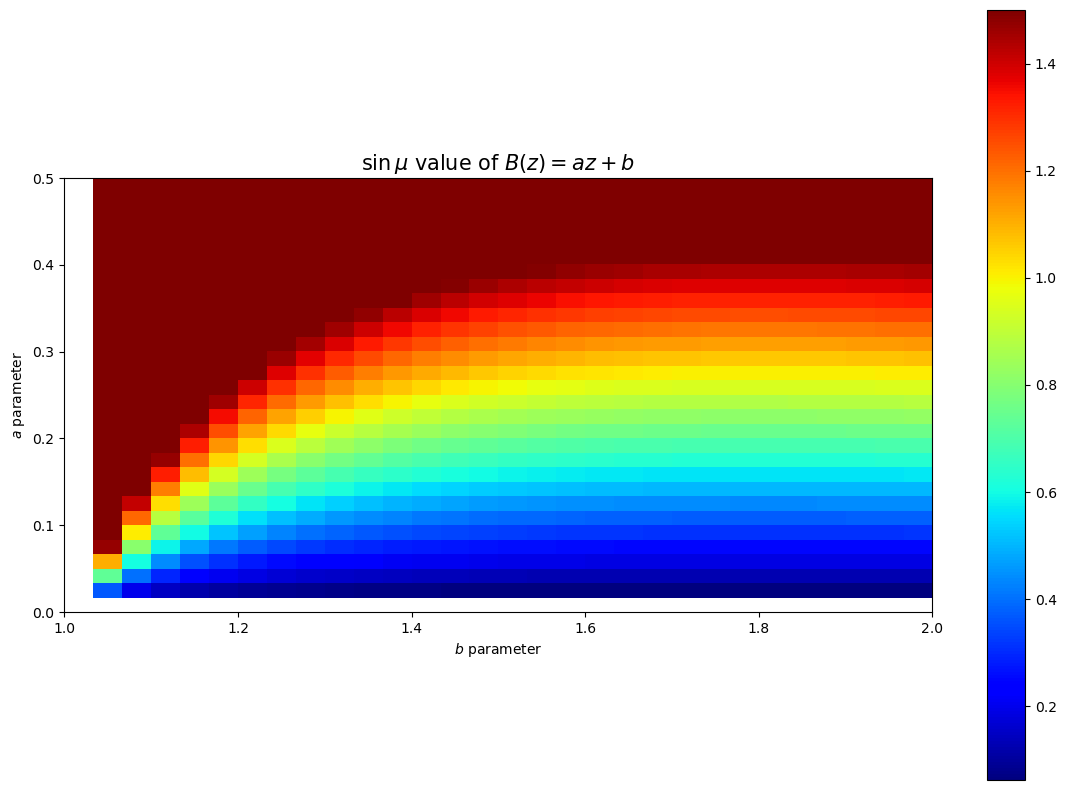

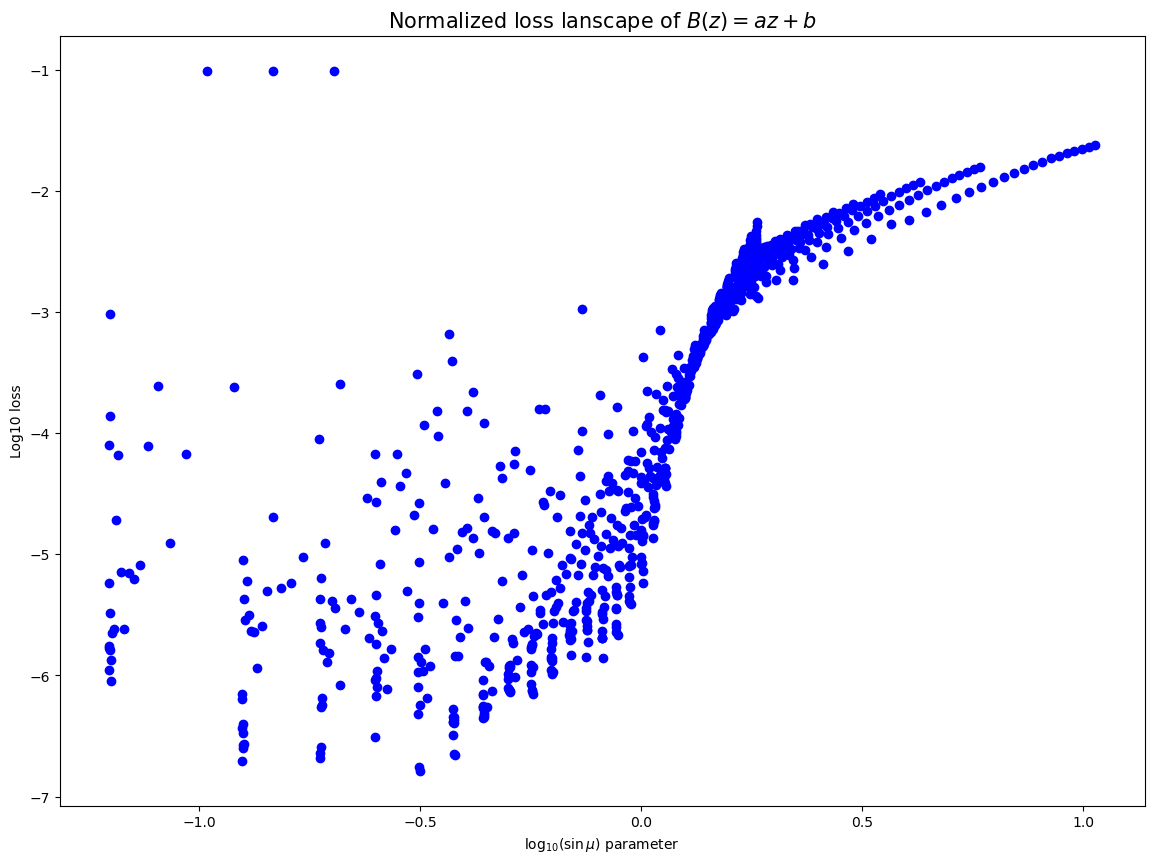

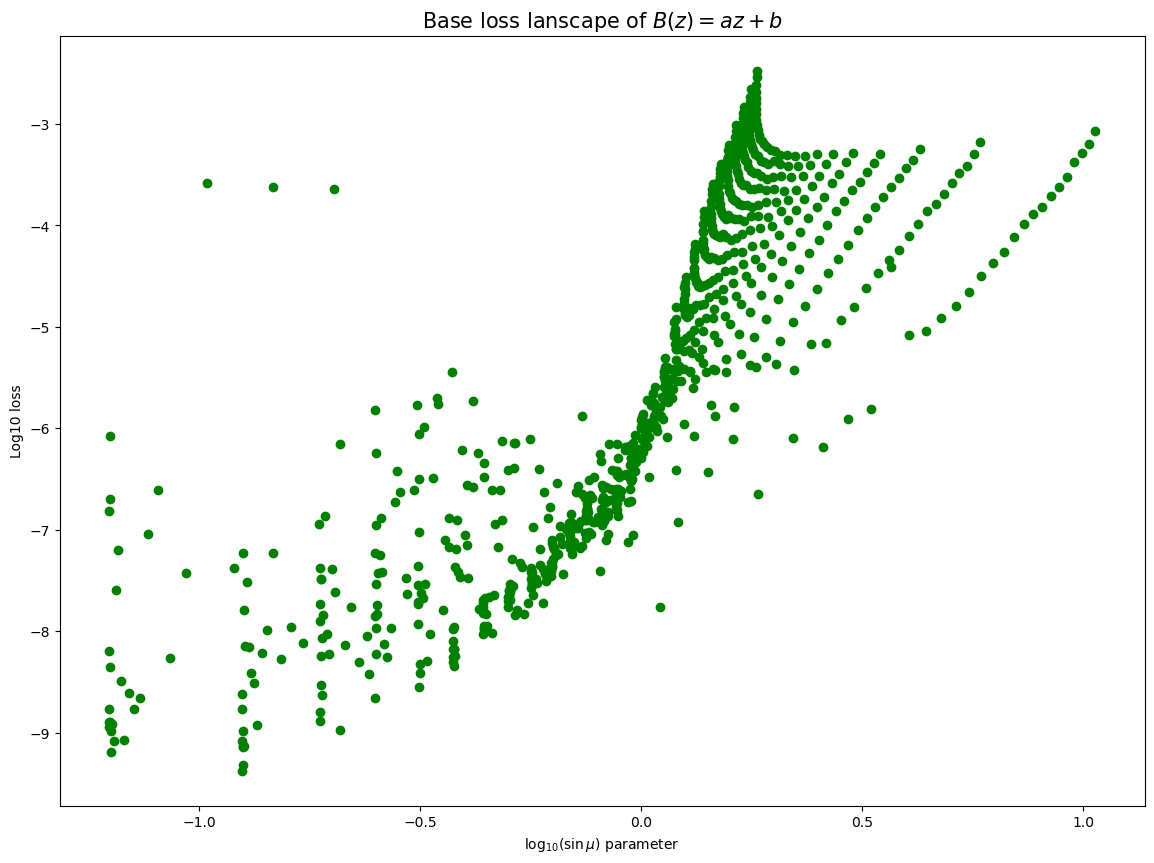

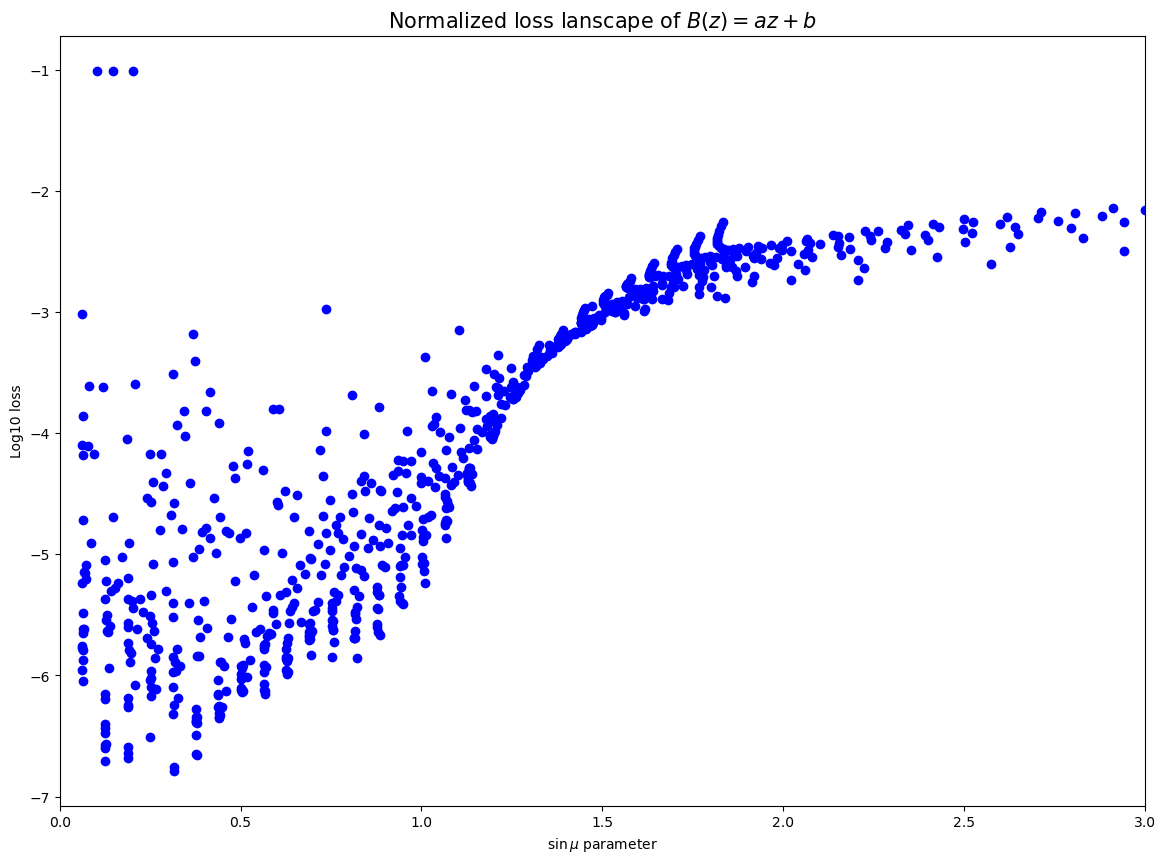

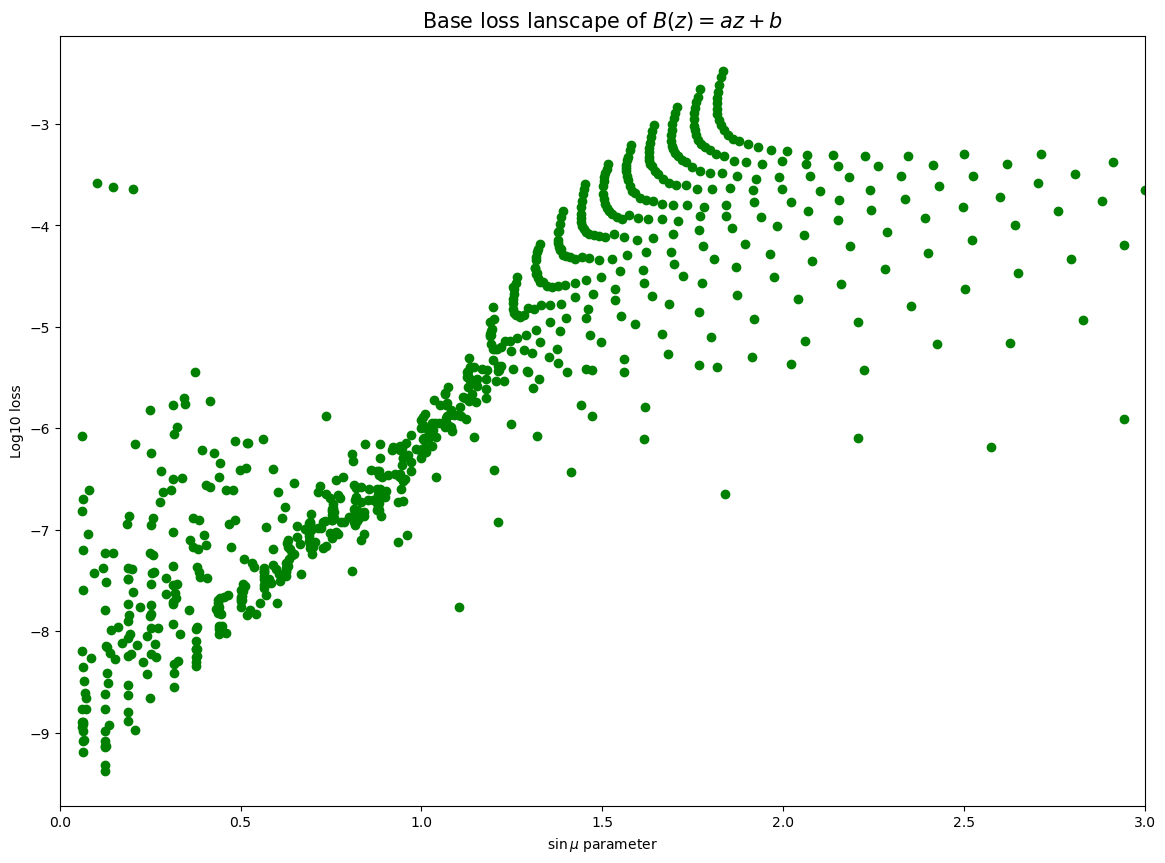

In [787]:
plot_contour_loss_curves_linear(log_res2, run_scan, tags_scan, log_type='base10')
plot_sinmu_losses(log_res2, run_scan, tags_scan, log_type='base10')

In [788]:
# Make sure to kill the Neptune logger run
run_scan.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-319


##### Moving to a quadratic $B(z) = az^2+c$

In [ ]:
num_a = 30
num_c = 30

scan_range_a3 = np.linspace(0, 1, num=num_a)
scan_range_c3 = np.linspace(0, 1, num=num_c)
param_grid3 = np.dstack(np.meshgrid(scan_range_a3, scan_range_c3)).reshape(-1, 2)



run_scan = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_QuadScan2_{}".format(i))

log_res3 = {'params':param_grid3, 'sinmu':np.empty([num_a, num_c]), 'loss_scale':np.empty([num_a, num_c]), 'loss_no_scale':np.empty([num_a, num_c])}

for i, params_lin in enumerate(param_grid3):
    
    a_index = i % num_a
    c_index = int((i - i % num_a)/num_a)
    
    # Differential cross section is positive for all z values

    print('Starting the simulation with a={} and c={}'.format(params_lin[0],params_lin[1]))

    params_scan = {'batch_size': 64,
             'epochs_num': 500,
             'learning_rate': 0.001,
             'lr_scheduler': False, 
             'beta1' : 0.85,
             'beta2' : 0.999,
             'integral_points': 25,
             'method_int': 'trapz',
             'activation': 'ReLU',
             'fund_dom': False,
             'layer_list': [64, 64, 64, 64],
             'final_layer': 'Tanh',
             'loss': 'MSE',
             'scaled_loss': False,
             'scan_param': None,
             'bound_phi': math.pi,
             'num_nets' : 1,
             'p_value': None,
             'lambda_repulsive': 0.0}

    tags_scan = {'constant function': 'az^2+c', 'optimizer': 'Adam', 'Mode': 'Scan param quadratic'}
    run_scan["sys/tags"].add(list(tags_scan.values()))

    run_scan['parameters'] = params_scan

    coeffs_scan = np.array([params_lin[1], 0.0, params_lin[0]])

    modnet = ModuleNetPolynomial(polynomial_coeffs=coeffs_scan, device=device)
    netsolver = train_run(params_scan, device, run_scan, module_net=modnet)

    sinmu, loss_scale, loss_no_scale = eval_run_scans(netsolver, params_scan, device, run_scan)
    log_res3['sinmu'][a_index, c_index] = sinmu.cpu().numpy()
    log_res3['loss_scale'][a_index, c_index] = loss_scale.cpu().numpy()
    log_res3['loss_no_scale'][a_index, c_index] = loss_no_scale.cpu().numpy()


https://app.neptune.ai/zulap/2to2scattering/e/TOS-735
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Starting the simulation with a=0.0 and c=0.0
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)
Begin Memory: 0
1 - After model to device 0
Train Epoch: 0 ; tLoss: 0.000000
Train Epoch: 20 ; tLoss: 0.000000
Train Epoch: 40 ; tLoss: 0.000000
Tra

Train Epoch: 20 ; tLoss: 0.000007
Train Epoch: 40 ; tLoss: 0.000002
Train Epoch: 60 ; tLoss: 0.000002
Train Epoch: 80 ; tLoss: 0.000001
Train Epoch: 100 ; tLoss: 0.000001
Train Epoch: 120 ; tLoss: 0.000001
Train Epoch: 140 ; tLoss: 0.000001
Train Epoch: 160 ; tLoss: 0.000001
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 200 ; tLoss: 0.000001
Train Epoch: 220 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000001
Train Epoch: 260 ; tLoss: 0.000001
Train Epoch: 280 ; tLoss: 0.000001
Train Epoch: 300 ; tLoss: 0.000001
Train Epoch: 320 ; tLoss: 0.000001
Train Epoch: 340 ; tLoss: 0.000001
Train Epoch: 360 ; tLoss: 0.000001
Train Epoch: 380 ; tLoss: 0.000000
Train Epoch: 400 ; tLoss: 0.000001
Train Epoch: 420 ; tLoss: 0.000000
Train Epoch: 440 ; tLoss: 0.000000
Train Epoch: 460 ; tLoss: 0.000000
Train Epoch: 480 ; tLoss: 0.000001
Starting the simulation with a=0.20689655172413793 and c=0.0
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_

Train Epoch: 380 ; tLoss: 0.000005
Train Epoch: 400 ; tLoss: 0.000008
Train Epoch: 420 ; tLoss: 0.000006
Train Epoch: 440 ; tLoss: 0.000007
Train Epoch: 460 ; tLoss: 0.000006
Train Epoch: 480 ; tLoss: 0.000010
Starting the simulation with a=0.3793103448275862 and c=0.0
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)
Begin Memory: 0
1 - After model to device 0
Train Epoch: 0 ; tLoss: 0.006143
Train Epoch: 20 ; tLoss: 0.000062
Train Epoch: 40 ; tLoss: 0.000049
Train Epoch: 60 ; tLoss: 0.000036
Train

Train Epoch: 20 ; tLoss: 0.000220
Train Epoch: 40 ; tLoss: 0.000218
Train Epoch: 60 ; tLoss: 0.000165
Train Epoch: 80 ; tLoss: 0.000123
Train Epoch: 100 ; tLoss: 0.000139
Train Epoch: 120 ; tLoss: 0.000109
Train Epoch: 140 ; tLoss: 0.000088
Train Epoch: 160 ; tLoss: 0.000086
Train Epoch: 180 ; tLoss: 0.000084
Train Epoch: 200 ; tLoss: 0.000065
Train Epoch: 220 ; tLoss: 0.000095
Train Epoch: 240 ; tLoss: 0.000079
Train Epoch: 260 ; tLoss: 0.000079
Train Epoch: 280 ; tLoss: 0.000066
Train Epoch: 300 ; tLoss: 0.000047
Train Epoch: 320 ; tLoss: 0.000083
Train Epoch: 340 ; tLoss: 0.000046
Train Epoch: 360 ; tLoss: 0.000047
Train Epoch: 380 ; tLoss: 0.000032
Train Epoch: 400 ; tLoss: 0.000049
Train Epoch: 420 ; tLoss: 0.000040
Train Epoch: 440 ; tLoss: 0.000044
Train Epoch: 460 ; tLoss: 0.000039
Train Epoch: 480 ; tLoss: 0.000062
Starting the simulation with a=0.5862068965517241 and c=0.0
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_f

Train Epoch: 380 ; tLoss: 0.000105
Train Epoch: 400 ; tLoss: 0.000158
Train Epoch: 420 ; tLoss: 0.000138
Train Epoch: 440 ; tLoss: 0.000160
Train Epoch: 460 ; tLoss: 0.000126
Train Epoch: 480 ; tLoss: 0.000205
Starting the simulation with a=0.7586206896551724 and c=0.0
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)
Begin Memory: 0
1 - After model to device 0
Train Epoch: 0 ; tLoss: 0.035656
Train Epoch: 20 ; tLoss: 0.000743
Train Epoch: 40 ; tLoss: 0.000769
Train Epoch: 60 ; tLoss: 0.000608
Train

Train Epoch: 20 ; tLoss: 0.001714
Train Epoch: 40 ; tLoss: 0.001731
Train Epoch: 60 ; tLoss: 0.001380
Train Epoch: 80 ; tLoss: 0.001055
Train Epoch: 100 ; tLoss: 0.001170
Train Epoch: 120 ; tLoss: 0.000898
Train Epoch: 140 ; tLoss: 0.000732
Train Epoch: 160 ; tLoss: 0.000733
Train Epoch: 180 ; tLoss: 0.000725
Train Epoch: 200 ; tLoss: 0.000564
Train Epoch: 220 ; tLoss: 0.000823
Train Epoch: 240 ; tLoss: 0.000690
Train Epoch: 260 ; tLoss: 0.000678
Train Epoch: 280 ; tLoss: 0.000585
Train Epoch: 300 ; tLoss: 0.000514
Train Epoch: 320 ; tLoss: 0.000765
Train Epoch: 340 ; tLoss: 0.000398
Train Epoch: 360 ; tLoss: 0.000457
Train Epoch: 380 ; tLoss: 0.000299
Train Epoch: 400 ; tLoss: 0.000429
Train Epoch: 420 ; tLoss: 0.000367
Train Epoch: 440 ; tLoss: 0.000410
Train Epoch: 460 ; tLoss: 0.000346
Train Epoch: 480 ; tLoss: 0.000575
Starting the simulation with a=0.9655172413793103 and c=0.0
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_f

Train Epoch: 360 ; tLoss: 0.000000
Train Epoch: 380 ; tLoss: 0.000000
Train Epoch: 400 ; tLoss: 0.000000
Train Epoch: 420 ; tLoss: 0.000000
Train Epoch: 440 ; tLoss: 0.000000
Train Epoch: 460 ; tLoss: 0.000000
Train Epoch: 480 ; tLoss: 0.000000
Starting the simulation with a=0.10344827586206896 and c=0.034482758620689655
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)
Begin Memory: 0
1 - After model to device 0
Train Epoch: 0 ; tLoss: 0.001112
Train Epoch: 20 ; tLoss: 0.000008
Train Epoch: 40 ; tL

Train Epoch: 20 ; tLoss: 0.000056
Train Epoch: 40 ; tLoss: 0.000037
Train Epoch: 60 ; tLoss: 0.000020
Train Epoch: 80 ; tLoss: 0.000011
Train Epoch: 100 ; tLoss: 0.000010
Train Epoch: 120 ; tLoss: 0.000006
Train Epoch: 140 ; tLoss: 0.000003
Train Epoch: 160 ; tLoss: 0.000002
Train Epoch: 180 ; tLoss: 0.000001
Train Epoch: 200 ; tLoss: 0.000001
Train Epoch: 220 ; tLoss: 0.000001
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 260 ; tLoss: 0.000000
Train Epoch: 280 ; tLoss: 0.000000
Train Epoch: 300 ; tLoss: 0.000000
Train Epoch: 320 ; tLoss: 0.000000
Train Epoch: 340 ; tLoss: 0.000000
Train Epoch: 360 ; tLoss: 0.000000
Train Epoch: 380 ; tLoss: 0.000000
Train Epoch: 400 ; tLoss: 0.000000
Train Epoch: 420 ; tLoss: 0.000000
Train Epoch: 440 ; tLoss: 0.000000
Train Epoch: 460 ; tLoss: 0.000000
Train Epoch: 480 ; tLoss: 0.000000
Starting the simulation with a=0.3103448275862069 and c=0.034482758620689655
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (laye

Train Epoch: 320 ; tLoss: 0.000001
Train Epoch: 340 ; tLoss: 0.000001
Train Epoch: 360 ; tLoss: 0.000001
Train Epoch: 380 ; tLoss: 0.000000
Train Epoch: 400 ; tLoss: 0.000000
Train Epoch: 420 ; tLoss: 0.000000
Train Epoch: 440 ; tLoss: 0.000000
Train Epoch: 460 ; tLoss: 0.000000
Train Epoch: 480 ; tLoss: 0.000000
Starting the simulation with a=0.48275862068965514 and c=0.034482758620689655
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)
Begin Memory: 0
1 - After model to device 0
Train Epoch: 0 ; 

Train Epoch: 20 ; tLoss: 0.000748
Train Epoch: 40 ; tLoss: 0.000714
Train Epoch: 60 ; tLoss: 0.000527
Train Epoch: 80 ; tLoss: 0.000358
Train Epoch: 100 ; tLoss: 0.000357
Train Epoch: 120 ; tLoss: 0.000245
Train Epoch: 140 ; tLoss: 0.000172
Train Epoch: 160 ; tLoss: 0.000151
Train Epoch: 180 ; tLoss: 0.000132
Train Epoch: 200 ; tLoss: 0.000084
Train Epoch: 220 ; tLoss: 0.000105
Train Epoch: 240 ; tLoss: 0.000069
Train Epoch: 260 ; tLoss: 0.000060
Train Epoch: 280 ; tLoss: 0.000041
Train Epoch: 300 ; tLoss: 0.000042
Train Epoch: 320 ; tLoss: 0.000041
Train Epoch: 340 ; tLoss: 0.000037
Train Epoch: 360 ; tLoss: 0.000020
Train Epoch: 380 ; tLoss: 0.000013
Train Epoch: 400 ; tLoss: 0.000016
Train Epoch: 420 ; tLoss: 0.000011
Train Epoch: 440 ; tLoss: 0.000013
Train Epoch: 460 ; tLoss: 0.000011
Train Epoch: 480 ; tLoss: 0.000014
Starting the simulation with a=0.6896551724137931 and c=0.034482758620689655
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (laye

Train Epoch: 320 ; tLoss: 0.000161
Train Epoch: 340 ; tLoss: 0.000101
Train Epoch: 360 ; tLoss: 0.000081
Train Epoch: 380 ; tLoss: 0.000057
Train Epoch: 400 ; tLoss: 0.000079
Train Epoch: 420 ; tLoss: 0.000055
Train Epoch: 440 ; tLoss: 0.000066
Train Epoch: 460 ; tLoss: 0.000056
Train Epoch: 480 ; tLoss: 0.000083
Starting the simulation with a=0.8620689655172413 and c=0.034482758620689655
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)
Begin Memory: 0
1 - After model to device 0
Train Epoch: 0 ; t

Train Epoch: 20 ; tLoss: 0.000005
Train Epoch: 40 ; tLoss: 0.000000
Train Epoch: 60 ; tLoss: 0.000000
Train Epoch: 80 ; tLoss: 0.000000
Train Epoch: 100 ; tLoss: 0.000000
Train Epoch: 120 ; tLoss: 0.000000
Train Epoch: 140 ; tLoss: 0.000000
Train Epoch: 160 ; tLoss: 0.000000
Train Epoch: 180 ; tLoss: 0.000000
Train Epoch: 200 ; tLoss: 0.000000
Train Epoch: 220 ; tLoss: 0.000000
Train Epoch: 240 ; tLoss: 0.000000
Train Epoch: 260 ; tLoss: 0.000000
Train Epoch: 280 ; tLoss: 0.000000
Train Epoch: 300 ; tLoss: 0.000000
Train Epoch: 320 ; tLoss: 0.000000
Train Epoch: 340 ; tLoss: 0.000000
Train Epoch: 360 ; tLoss: 0.000000
Train Epoch: 380 ; tLoss: 0.000000
Train Epoch: 400 ; tLoss: 0.000000
Train Epoch: 420 ; tLoss: 0.000000
Train Epoch: 440 ; tLoss: 0.000000
Train Epoch: 460 ; tLoss: 0.000000
Train Epoch: 480 ; tLoss: 0.000000
Starting the simulation with a=0.034482758620689655 and c=0.06896551724137931
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (lay

Train Epoch: 320 ; tLoss: 0.000000
Train Epoch: 340 ; tLoss: 0.000000
Train Epoch: 360 ; tLoss: 0.000000
Train Epoch: 380 ; tLoss: 0.000000
Train Epoch: 400 ; tLoss: 0.000000
Train Epoch: 420 ; tLoss: 0.000000
Train Epoch: 440 ; tLoss: 0.000000
Train Epoch: 460 ; tLoss: 0.000000
Train Epoch: 480 ; tLoss: 0.000000
Starting the simulation with a=0.20689655172413793 and c=0.06896551724137931
PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)
Begin Memory: 0
1 - After model to device 0
Train Epoch: 0 ; t

In [ ]:
plot_contour_loss_curves_linear(log_res3, run_scan, tags_scan, log_type='base10')
plot_sinmu_losses(log_res3, run_scan, tags_scan, log_type='base10')

In [ ]:
# Make sure to kill the Neptune logger run
run_scan.stop()

### Ambiguity Study

##### Crichton Ambiguity

In [9]:
class ModuleNetCrichton(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self):
        super(ModuleNetCrichton, self).__init__()
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function. Can iterate on the overall scale if we want to
        """
        return torch.sqrt(1.38065 + 3.1118 *x - 1.60815*torch.pow(x,2) - 4.731*torch.pow(x,3) + 6.58* torch.pow(x,4)) # Crichton example

In [159]:
import matplotlib.pyplot as plt
from neptune.new.types import File

def crichton_solutions(zpoints):
    z = zpoints.cpu()
    sol1 = torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(z,2)-1)*np.sin(math.pi/9)-np.exp(-7*1j*math.pi/54)*np.sin(7*math.pi/54)-3*np.exp(-869*1j*math.pi/3600)*z*np.sin(869*math.pi/3600))
    sol1 = math.pi - sol1 - 2*math.pi*torch.heaviside(-sol1, torch.tensor(0.0)) + 2*math.pi*torch.heaviside(sol1-2*math.pi, torch.tensor(0.0))
    sol2 = math.pi - torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(z,2)-1)*np.sin(math.pi/9)+np.exp(659*1j*math.pi/1200)*np.cos(59*math.pi/1200)-3*np.exp(-59*1j*math.pi/400)*z*np.sin(59*math.pi/400))
    
    return sol1, sol2

def plot_point_loss_crichton(zpoints, point_loss_data_ses, neptune_run):

    fig = plt.figure(figsize=(14, 10))
    
    for point_loss_data_s in point_loss_data_ses:
        plt.plot(zpoints.cpu(), point_loss_data_s.cpu(), '-', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['Network {} : Normalized point loss'.format(i+1) for i in range(len(point_loss_data_ses))])
    plt.show()

    neptune_run[f'evaluation/point_loss_evaluation'].upload(File.as_image(fig))
    plt.close(fig)
    
    
def plot_summary_crichton(zpoints, phipoints_list, neptune_run):
    
    
    fig3 = plt.figure(figsize=(14, 10))
    
    sol1, sol2 = crichton_solutions(zpoints)
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '--', linewidth = 2)   
    plt.plot(zpoints.cpu(),sol1, 'g', linewidth = 2)   
    plt.plot(zpoints.cpu(),sol2, 'k', linewidth = 2)   
    
     
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('Differential cross section categorization: B(z) : Crichton', fontsize = 15)
    plt.xlim([-1,1])
    legend_nets = ['$\phi(z)$ network {}'.format(i+1) for i in range(len(phipoints_list))]
    plt.legend(legend_nets + ['$\phi_1(z)$ exact', '$\phi_2(z)$ exact'])
    plt.show()

    neptune_run[f'evaluation/overview'].upload(File.as_image(fig3))
    plt.close(fig3)

In [12]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_crichton17")

params = {'batch_size': 64,
         'epochs_num': 2500,
         'learning_rate': 0.001,
         'lr_scheduler': False, 
         'beta1' : 0.85,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'fund_dom': False,
         #'layer_list': [64, 128, 128, 64],
         'layer_list': [16, 16, 16, 16, 16, 16, 16, 16, 16],
         'final_layer': 'Tanh',
         'loss': 'Huber',
         'scaled_loss': True,
         'scan_param': None,
         'bound_phi': 2*math.pi,
         'num_nets': 2,
         'p_value': 2,
         'lambda_repulsive': 0.001}

tags = {'constant function': 'Crichton', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-689
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=16, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=16, out_features=16, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=16, out_features=16, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=16, out_features=16, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=16, out_features=16, bias=True)
    (activation_5): ReLU()
    (layer_6): Linear(in_features=16, out_features=16, bias=True)
    (activation_6): ReLU()
    (layer_7): Linear(in_features=16, out_features=16, bias=True)
    (activation_7): ReLU()
    (layer_8): Linear(in_features=16, out_features=16, bias=True)
    (activation_8): ReLU()
    (layer_9): Linear(in_features=16, out_features=16, bias=True)
    (activation_9): ReLU()
    (layer_10): Linear(in_features=16, out_features=1, bias=True)
    (final_layer): T

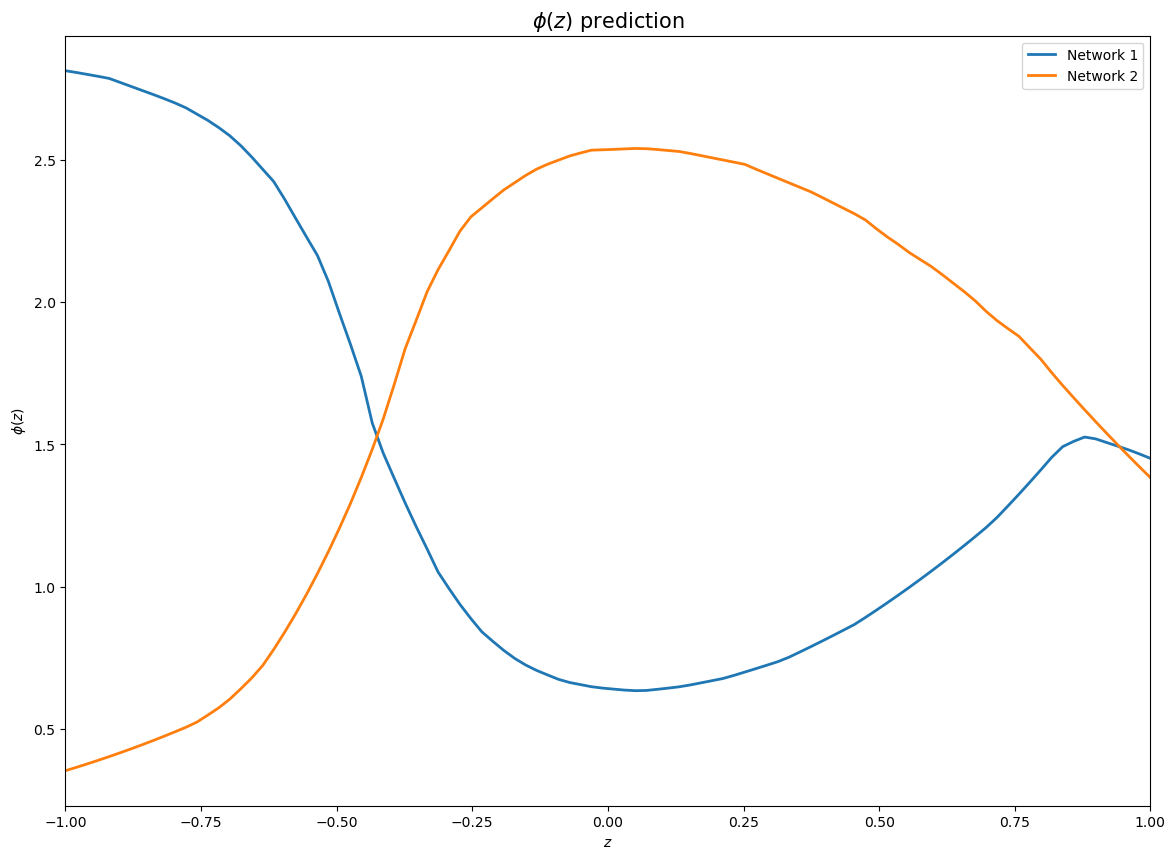

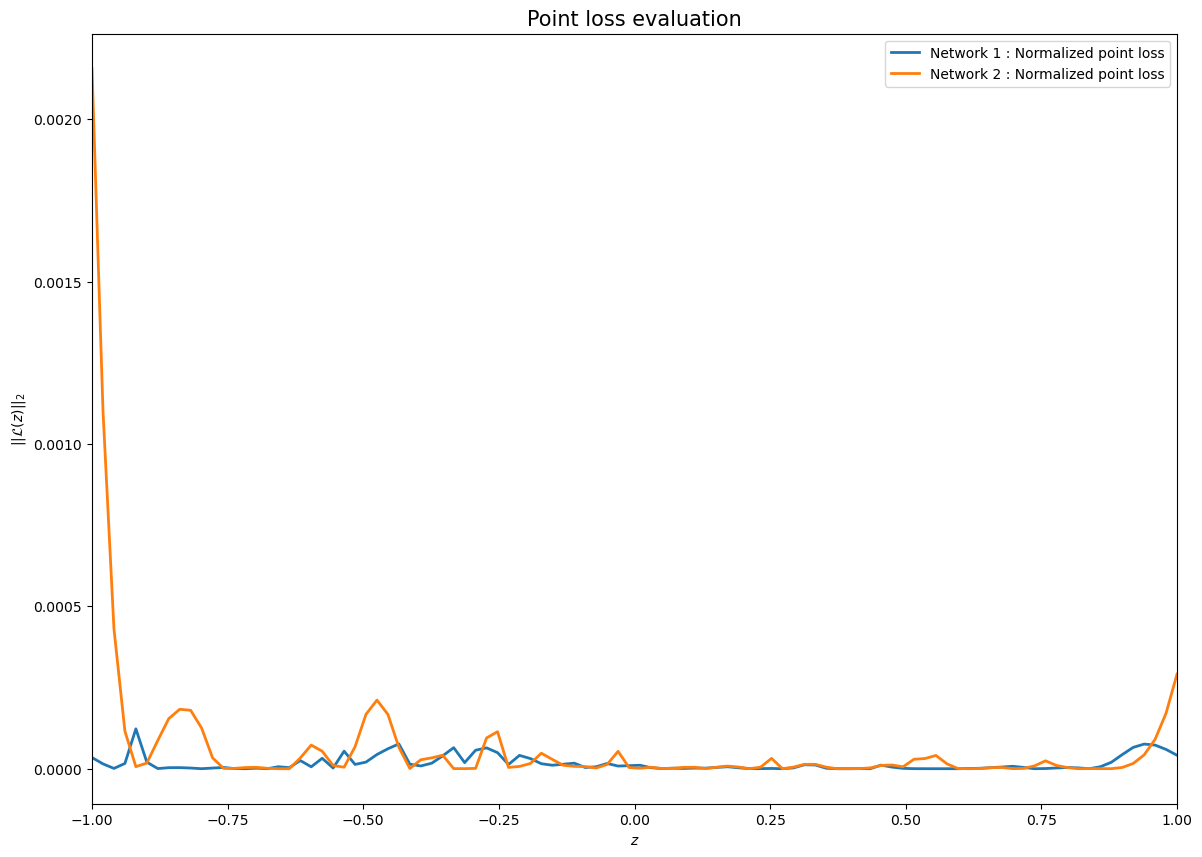

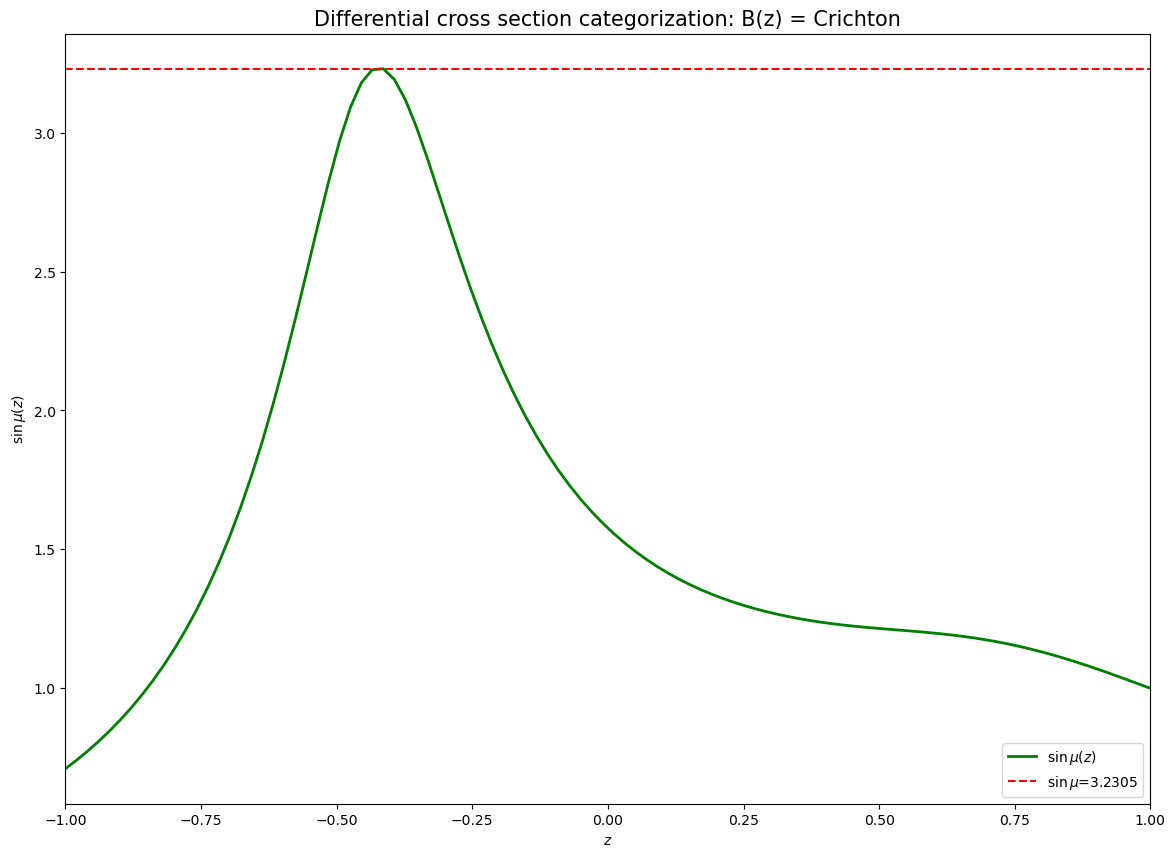

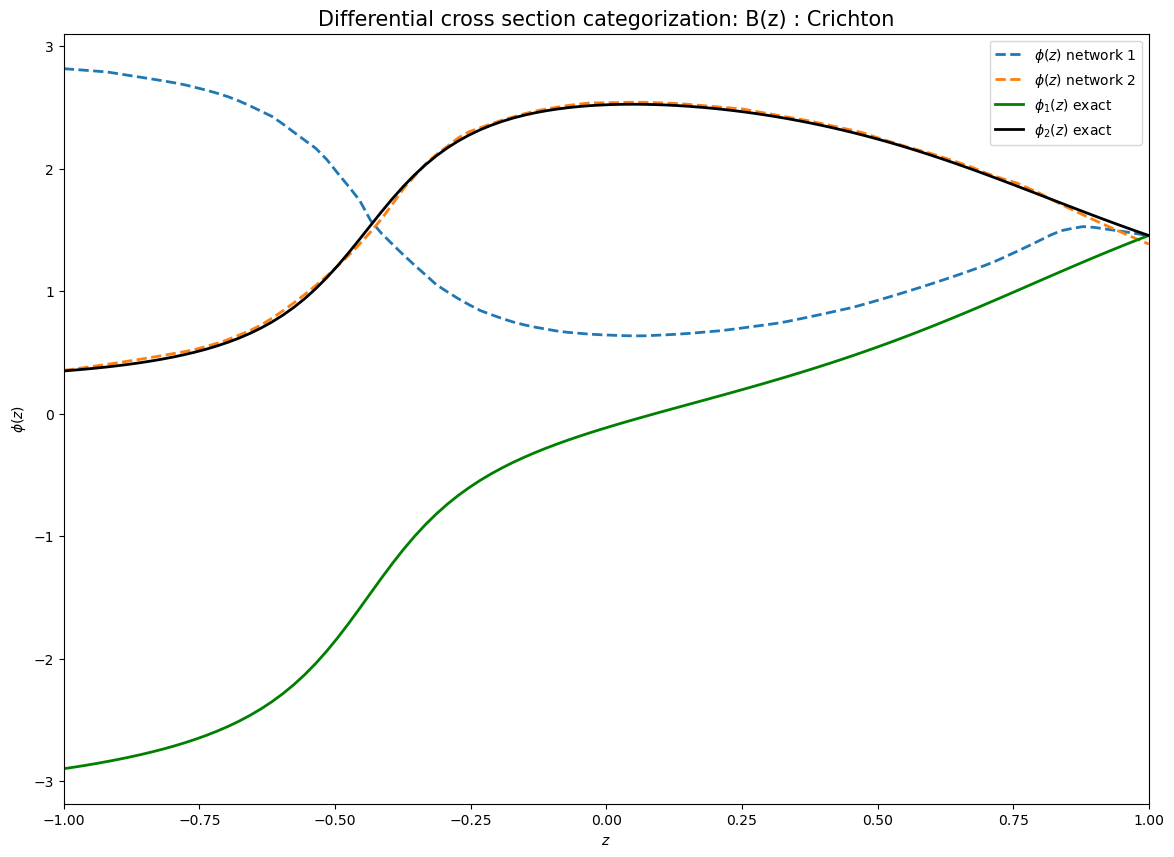

In [235]:
crichtonnet = ModuleNetCrichton()
netsolver = train_run(params, device, run, module_net=crichtonnet, seed_num=42)

phievals = []
eval_pt_loss_ses = []
for i in range(params['num_nets']):
    
    if params['num_nets'] > 1: 
        netsolver.phi_net = netsolver.multi_nets[i]
    zpointseval, phieval, _, eval_pt_loss_s, _ = eval_run(netsolver, params, device, run)
    phievals.append(phieval)
    eval_pt_loss_ses.append(eval_pt_loss_s)

plot_phases(zpointseval, phievals, run)
plot_point_loss_crichton(zpointseval, eval_pt_loss_ses, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summary_crichton(zpointseval, phievals, run)

In [236]:
# Make sure to kill the Neptune logger run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-672


Tuning the network for resolving the discontinuity

In [241]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_test2")

params = {'batch_size': 64,
         'epochs_num': 2500,
         'learning_rate': 0.001,
         'lr_scheduler': False, 
         'beta1' : 0.85,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'fund_dom': False,
         #'layer_list': [64, 128, 128, 64],
         #'layer_list': [64, 64, 64, 64, 64],
         #'layer_list': [128, 256, 256, 128, 64],
         'layer_list' : [64,64, 64, 64],
         'final_layer': 'Tanh',
         'loss': 'MSE',
         'scaled_loss': False,
         'scan_param': None,
         'bound_phi': math.pi,
         'num_nets': 2,
         'p_value': 2,
         'lambda_repulsive': 1.0}

tags = {'constant function': 'Crichton', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-734
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)
Begin Memory: 0
1 - After model to device 0
Train Epoch: 0 ; tLoss: 10.950087
Train Epoch: 20 ; tLoss: 0.767168
Train Epoch: 40 ; tLoss: 0.451479
Train Epoch: 60 ; tLoss: 0.113247
Train Epoch: 80 ; tLoss: 0.056100
Train Epoch: 100 ; tLoss: 0.056652
Train Epoch: 120 ; tLoss: 0.048180
Train Epoch: 140 ; tLoss: 0.038537
Train Epoch: 160 ; tLoss: 0.041796
Train Epoch: 180 ; tLoss: 0.035977
Train Epoch: 200 ; tLoss: 0.032792
Train Epoch: 220 ; tLoss: 0.02

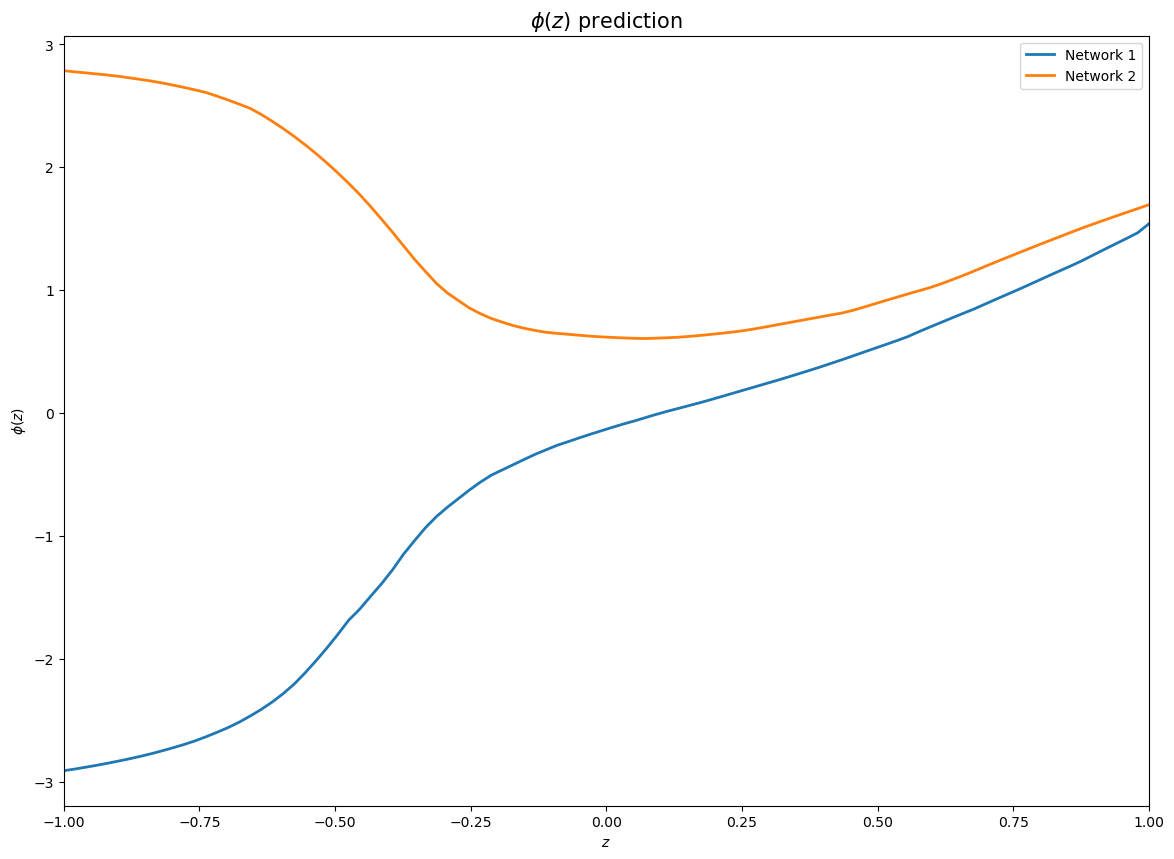

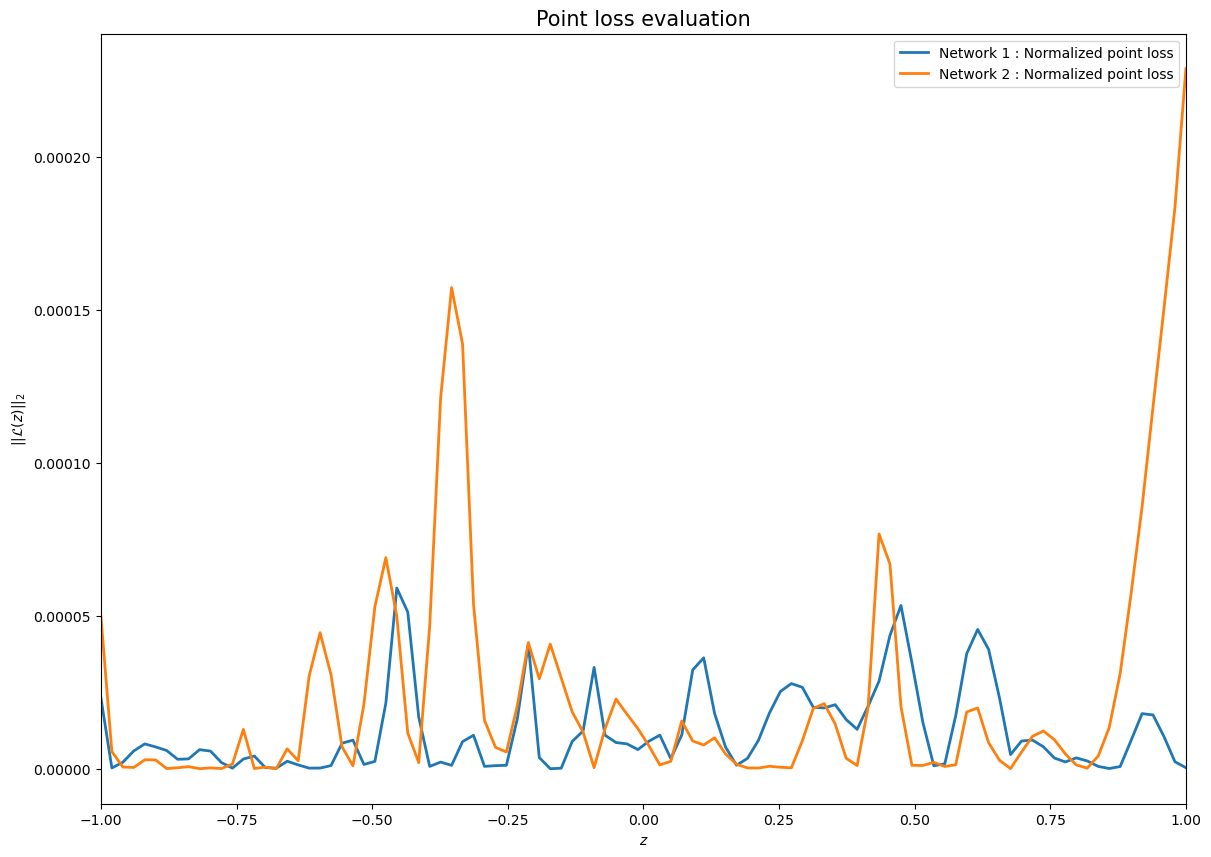

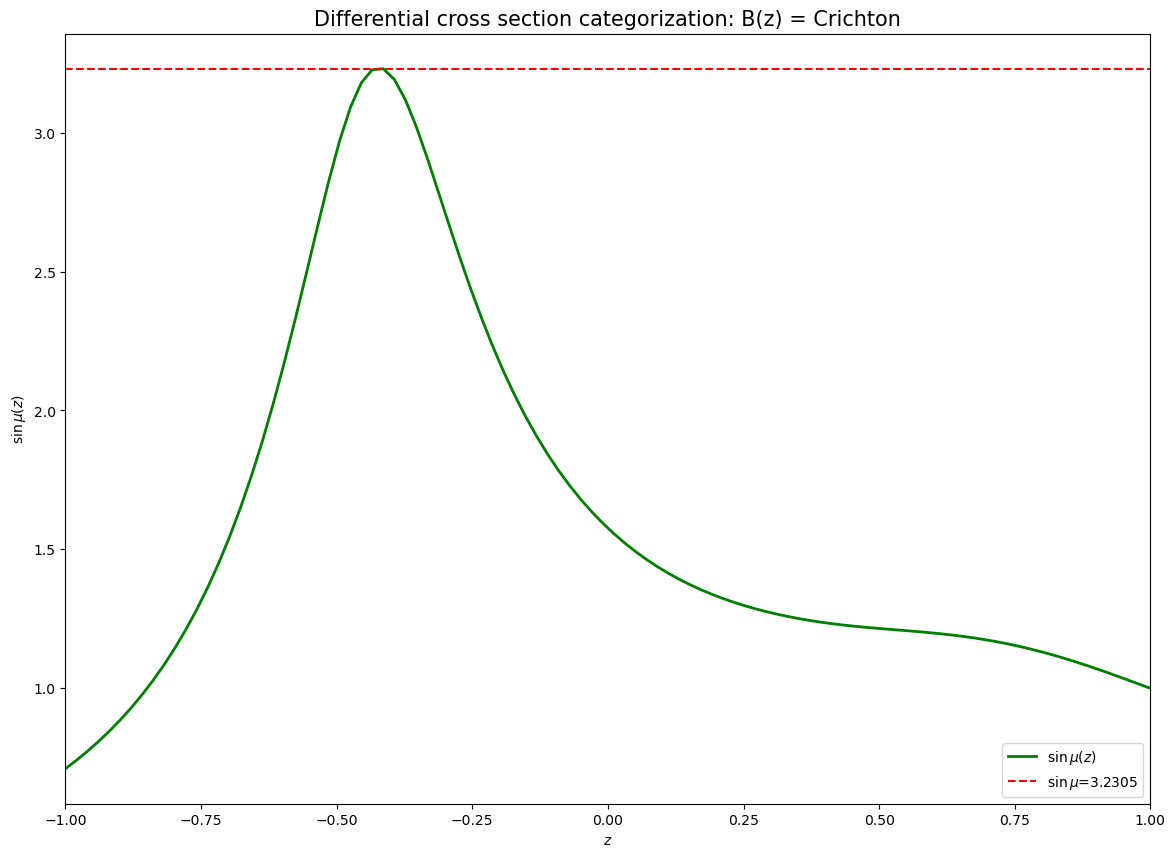

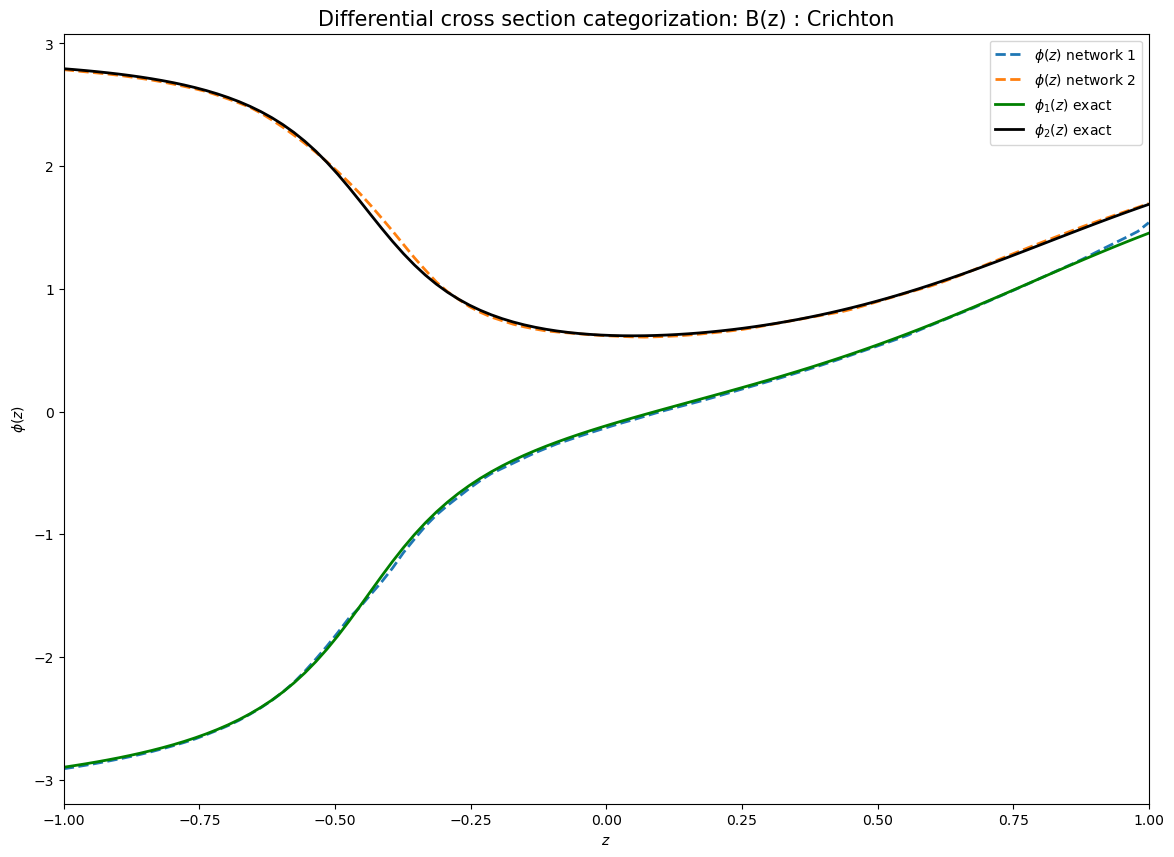

In [242]:
crichtonnet = ModuleNetCrichton()
netsolver = train_run(params, device, run, module_net=crichtonnet, seed_num=42, optim_name='Adam')

phievals = []
eval_pt_loss_ses = []
for i in range(params['num_nets']):
    
    if params['num_nets'] > 1: 
        netsolver.phi_net = netsolver.multi_nets[i]
    zpointseval, phieval, _, eval_pt_loss_s, _ = eval_run(netsolver, params, device, run)
    phievals.append(phieval)
    eval_pt_loss_ses.append(eval_pt_loss_s)

plot_phases(zpointseval, phievals, run)
plot_point_loss_crichton(zpointseval, eval_pt_loss_ses, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summary_crichton(zpointseval, phievals, run)

In [243]:
# Make sure to kill the Neptune logger run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 181 operations to synchronize with Neptune. Do not kill this process.
All 181 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-734


##### Verifying that we get 0 loss for the expected solution

In [154]:
class DummyNet(nn.Module):
    """
    Class for parametrizing the solution of the phase
    """
    def __init__(self, paramsol=0):
        self.paramsol = paramsol
        super(DummyNet, self).__init__()
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function. Can iterate on the overall scale if we want to
        """
        
        if self.paramsol == 0:
            return torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(x,2)-1)*np.sin(math.pi/9)+np.exp(659*1j*math.pi/1200)*np.cos(59*math.pi/1200)-3*np.exp(-59*1j*math.pi/400)*x*np.sin(59*math.pi/400))
        else:
            sol1 = torch.angle((5/2)*np.exp(1j*math.pi/9)*(3*torch.pow(x,2)-1)*np.sin(math.pi/9)-np.exp(-7*1j*math.pi/54)*np.sin(7*math.pi/54)-3*np.exp(-869*1j*math.pi/3600)*x*np.sin(869*math.pi/3600))
#            return math.pi - sol1 - torch.div(math.pi - sol1, math.pi, rounding_mode = "floor")*2*math.pi
            return math.pi - sol1 - 2*math.pi*torch.heaviside(-sol1, torch.tensor(0.0)) + 2*math.pi*torch.heaviside(sol1-2*math.pi, torch.tensor(0.0))

In [155]:
dummynet = DummyNet(1)
dummynet = dummynet.to(device)
netsolver.eval_points_num = 25
netsolver.scaled_loss = True

In [156]:
#rzpoints = torch.rand(64, requires_grad=False, generator=netsolver.rand_gen, device='cpu').to(netsolver.device)*2 - 1
rzpoints = torch.linspace(-1,1,64, device=device)

In [157]:
rzpoints

tensor([-1.0000, -0.9683, -0.9365, -0.9048, -0.8730, -0.8413, -0.8095, -0.7778,
        -0.7460, -0.7143, -0.6825, -0.6508, -0.6190, -0.5873, -0.5556, -0.5238,
        -0.4921, -0.4603, -0.4286, -0.3968, -0.3651, -0.3333, -0.3016, -0.2698,
        -0.2381, -0.2063, -0.1746, -0.1429, -0.1111, -0.0794, -0.0476, -0.0159,
         0.0159,  0.0476,  0.0794,  0.1111,  0.1429,  0.1746,  0.2063,  0.2381,
         0.2698,  0.3016,  0.3333,  0.3651,  0.3968,  0.4286,  0.4603,  0.4921,
         0.5238,  0.5556,  0.5873,  0.6190,  0.6508,  0.6825,  0.7143,  0.7460,
         0.7778,  0.8095,  0.8413,  0.8730,  0.9048,  0.9365,  0.9683,  1.0000])

In [142]:
dummynet(rzpoints)

tensor([-2.8994, -2.8778, -2.8540, -2.8279, -2.7989, -2.7665, -2.7301, -2.6888,
        -2.6415, -2.5871, -2.5236, -2.4490, -2.3607, -2.2554, -2.1302, -1.9827,
        -1.8130, -1.6256, -1.4301, -1.2388, -1.0623, -0.9066, -0.7726, -0.6585,
        -0.5612, -0.4776, -0.4048, -0.3406, -0.2830, -0.2307, -0.1824, -0.1373,
        -0.0945, -0.0535, -0.0137,  0.0252,  0.0638,  0.1022,  0.1407,  0.1797,
         0.2194,  0.2599,  0.3015,  0.3443,  0.3885,  0.4342,  0.4816,  0.5307,
         0.5816,  0.6343,  0.6886,  0.7447,  0.8022,  0.8611,  0.9210,  0.9817,
         1.0429,  1.1041,  1.1651,  1.2253,  1.2846,  1.3426,  1.3990,  1.4535])

In [158]:
dummynet(rzpoints)

tensor([-2.8994, -2.8778, -2.8540, -2.8279, -2.7989, -2.7665, -2.7301, -2.6888,
        -2.6415, -2.5871, -2.5236, -2.4490, -2.3607, -2.2554, -2.1302, -1.9827,
        -1.8130, -1.6256, -1.4301, -1.2388, -1.0623, -0.9066, -0.7726, -0.6585,
        -0.5612, -0.4776, -0.4048, -0.3406, -0.2830, -0.2307, -0.1824, -0.1373,
        -0.0945, -0.0535, -0.0137,  0.0252,  0.0638,  0.1022,  0.1407,  0.1797,
         0.2194,  0.2599,  0.3015,  0.3443,  0.3885,  0.4342,  0.4816,  0.5307,
         0.5816,  0.6343,  0.6886,  0.7447,  0.8022,  0.8611,  0.9210,  0.9817,
         1.0429,  1.1041,  1.1651,  1.2253,  1.2846,  1.3426,  1.3990,  1.4535])

In [122]:
netsolver.phi_net = dummynet

In [110]:
netsolver.loss_function(rzpoints)

tensor(2.6532e-05)

In [111]:
netsolver.integral_approximator(rzpoints)

tensor([0.9711, 0.9343, 0.8994, 0.8663, 0.8350, 0.8054, 0.7777, 0.7518, 0.7276,
        0.7053, 0.6848, 0.6661, 0.6491, 0.6340, 0.6207, 0.6092, 0.5995, 0.5916,
        0.5854, 0.5811, 0.5786, 0.5779, 0.5790, 0.5819, 0.5865, 0.5930, 0.6013,
        0.6114, 0.6233, 0.6370, 0.6525, 0.6698, 0.6889, 0.7098, 0.7325, 0.7570,
        0.7833, 0.8113, 0.8412, 0.8729, 0.9064, 0.9417, 0.9788, 1.0177, 1.0585,
        1.1010, 1.1453, 1.1914, 1.2393, 1.2890, 1.3405, 1.3938, 1.4489, 1.5058,
        1.5645, 1.6250, 1.6874, 1.7515, 1.8174, 1.8851, 1.9546, 2.0259, 2.0990,
        2.1740])

In [112]:
torch.sin(netsolver.phi_net(rzpoints))*netsolver.mod_net(rzpoints)

tensor([0.9619, 0.9261, 0.8921, 0.8598, 0.8293, 0.8006, 0.7737, 0.7485, 0.7251,
        0.7034, 0.6836, 0.6655, 0.6491, 0.6346, 0.6218, 0.6107, 0.6015, 0.5940,
        0.5883, 0.5843, 0.5821, 0.5816, 0.5830, 0.5861, 0.5909, 0.5976, 0.6060,
        0.6162, 0.6281, 0.6418, 0.6573, 0.6746, 0.6936, 0.7144, 0.7370, 0.7613,
        0.7874, 0.8153, 0.8449, 0.8763, 0.9095, 0.9444, 0.9811, 1.0196, 1.0599,
        1.1019, 1.1457, 1.1912, 1.2385, 1.2876, 1.3385, 1.3911, 1.4455, 1.5017,
        1.5596, 1.6193, 1.6808, 1.7440, 1.8090, 1.8758, 1.9443, 2.0146, 2.0867,
        2.1606])

In [113]:
diff = 1-(netsolver.integral_approximator(rzpoints)/(torch.sin(netsolver.phi_net(rzpoints))*netsolver.mod_net(rzpoints)))

In [114]:
F.huber_loss((netsolver.integral_approximator(rzpoints)/(torch.sin(netsolver.phi_net(rzpoints))*netsolver.mod_net(rzpoints))), torch.ones(rzpoints.size(), device=device), delta=1)

tensor(1.3266e-05)

In [115]:
F.mse_loss((netsolver.integral_approximator(rzpoints)/(torch.sin(netsolver.phi_net(rzpoints))*netsolver.mod_net(rzpoints))), torch.ones(rzpoints.size(), device=device))

tensor(2.6532e-05)

In [116]:
torch.pow(diff, 2)

tensor([9.1544e-05, 7.9602e-05, 6.7962e-05, 5.6767e-05, 4.6155e-05, 3.6281e-05,
        2.7303e-05, 1.9375e-05, 1.2646e-05, 7.2481e-06, 3.2945e-06, 8.6503e-07,
        1.9140e-09, 6.9982e-07, 2.8964e-06, 6.4616e-06, 1.1190e-05, 1.6793e-05,
        2.2935e-05, 2.9282e-05, 3.5558e-05, 4.1507e-05, 4.6907e-05, 5.1552e-05,
        5.5259e-05, 5.7898e-05, 5.9386e-05, 5.9719e-05, 5.8935e-05, 5.7105e-05,
        5.4363e-05, 5.0859e-05, 4.6759e-05, 4.2232e-05, 3.7457e-05, 3.2582e-05,
        2.7758e-05, 2.3107e-05, 1.8735e-05, 1.4728e-05, 1.1146e-05, 8.0351e-06,
        5.4264e-06, 3.3314e-06, 1.7550e-06, 6.8859e-07, 1.1726e-07, 1.8436e-08,
        3.6471e-07, 1.1256e-06, 2.2697e-06, 3.7636e-06, 5.5757e-06, 7.6739e-06,
        1.0027e-05, 1.2607e-05, 1.5383e-05, 1.8331e-05, 2.1429e-05, 2.4648e-05,
        2.7977e-05, 3.1389e-05, 3.4875e-05, 3.8408e-05])